In [1]:
!pip install tmx
!pip install beautifulsoup4
!pip install bitsandbytes
!pip install --upgrade transformers
!pip install --upgrade peft
!pip install datasets
!pip install sacrebleu
!pip install bert-score
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.4/366.4 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tmx: filename=tmx-1.10-py3-none-any.whl size=16758 sha256=9657520b8030f033fe4ffed648e8d2e98baa8119fe9483deb92869686d0d5f03
  Stored in directory: /root/.cache/pip/wheels/ec/e7/be/890fb8ec350afec71724aeecba990ecae6a6335bc803068a36
Successfully built tmx
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

In [ ]:
from bs4 import BeautifulSoup
import random
import json

# Load and parse the TMX file
with open("de-fr_04-11-2015_Website_final.tmx", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "xml")

# Extract all translation units
translation_units = soup.find_all("tu")
print("Number of translation units found:", len(translation_units))

# List to store German-French pairs
sentence_pairs = []

for tu in translation_units:
    tuv_tags = tu.find_all("tuv")
    # Ensure there are exactly 2 translation units per 'tu'
    if len(tuv_tags) != 2:
        continue

    # Try to get language attributes from either "xml:lang" or "lang", then convert to uppercase
    lang1 = (tuv_tags[0].get("xml:lang") or tuv_tags[0].get("lang") or "").upper()
    lang2 = (tuv_tags[1].get("xml:lang") or tuv_tags[1].get("lang") or "").upper()

    # Extract the sentence segments
    seg1 = tuv_tags[0].find("seg")
    seg2 = tuv_tags[1].find("seg")
    if seg1 is None or seg2 is None:
        continue
    text1 = seg1.text.strip()
    text2 = seg2.text.strip()

    # Use string matching to determine language, e.g. "DE-DE" should count as German.
    if lang1.startswith("DE") and lang2.startswith("FR"):
        sentence_pairs.append({"german": text1, "french": text2})
    elif lang1.startswith("FR") and lang2.startswith("DE"):
        sentence_pairs.append({"german": text2, "french": text1})
    # Otherwise, skip

print("Number of German-French pairs found:", len(sentence_pairs))

# Randomly sample up to 1000 pairs (or all if fewer)
sampled_pairs = random.sample(sentence_pairs, min(1000, len(sentence_pairs)))

# Save the dataset as JSON
with open("dataset_a.json", "w", encoding="utf-8") as json_file:
    json.dump(sampled_pairs, json_file, ensure_ascii=False, indent=4)

# Preview the first 5 pairs
print(sampled_pairs[:5])


Number of translation units found: 11852
Number of German-French pairs found: 11852
[{'german': 'Ich freue mich, dass es gelungen ist, die Akademie gemeinsam mit dem Freistaat Bayern und der Stadt Nürnberg auf den Weg zu bringen.', 'french': 'Je me félicite qu’il ait été possible de lancer cette académie avec le concours de l’État libre de Bavière et de la ville de Nuremberg.'}, {'german': 'Bedeutung hat diese Regelung für kurzfristige Aufenthalte: das Visum begründet jetzt ausdrücklich eine Aufenthaltsberechtigung; nach dem früheren Ausländergesetz galt dies nur für Aufenthaltstitel, die nach der Einreise innerhalb Deutschlands erworben wurden.', 'french': 'Cette réglementation est importante pour les séjours de courte durée\xa0: le visa fonde désormais expressément un droit au séjour. Selon l’ancienne loi sur les étrangers, ceci ne s’appliquait qu’aux titres de séjour obtenus après l’entrée en Allemagne.'}, {'german': 'Als letzte Station wird der Steinmeier am Dienstag (2.6.) in Pari

In [ ]:
import json
import random

# Assume sentence_pairs is your list of all 11,852 German-French pairs
# Randomly sample 1000 pairs to create Dataset A
sampled_pairs = random.sample(sentence_pairs, 1000)

# Save the 1000 pairs to a JSON file for later reuse
with open("dataset_a.json", "w", encoding="utf-8") as json_file:
    json.dump(sampled_pairs, json_file, ensure_ascii=False, indent=4)

# Load the saved Dataset A (optional if you want to split in a fresh session)
with open("dataset_a.json", "r", encoding="utf-8") as json_file:
    data = json.load(json_file)

# Define your split ratio (e.g., 80% training, 20% testing)
split_ratio = 0.8
train_size = int(len(data) * split_ratio)
train_data = data[:train_size]
test_data = data[train_size:]

# Save the training and testing sets into separate JSON files
with open("dataset_a_train.json", "w", encoding="utf-8") as train_file:
    json.dump(train_data, train_file, ensure_ascii=False, indent=4)
with open("dataset_a_test.json", "w", encoding="utf-8") as test_file:
    json.dump(test_data, test_file, ensure_ascii=False, indent=4)

print("Number of training pairs:", len(train_data))
print("Number of testing pairs:", len(test_data))


Number of training pairs: 800
Number of testing pairs: 200


# **Model A**

In [ ]:
import json
import torch
import re
from langdetect import detect
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import Dataset
import sacrebleu
from bert_score import score

model_name = "microsoft/phi-2"
# Create a BitsAndBytesConfig for 8-bit quantization
quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=True  # Optional: offload some operations to CPU for stability
)

# Load the model with the quantization configuration
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quant_config, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load the saved test dataset
with open("dataset_a_test.json", "r", encoding="utf-8") as file:
    test_data = json.load(file)


# Function to filter out non-French parts while keeping valid French sentences
def filter_french_text(text):
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split into sentences
    french_sentences = [sent for sent in sentences if detect(sent) == "fr"]  # Keep only French sentences
    return " ".join(french_sentences).strip()  # Reconstruct filtered text

# Function to generate translation and retry if needed
def generate_translation(input_text, max_new_tokens=50, max_attempts=2):
    input_text = input_text.replace("->", "").strip()
    conditioned_text = "Translate the following German text into French: " + input_text

    attempt = 0
    while attempt < max_attempts:
        attempt += 1
        inputs = tokenizer(conditioned_text, return_tensors="pt", truncation=True, max_length=128).to(model.device)
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=5,
            early_stopping=True,
            temperature=0.7,        # Reduced randomness
            repetition_penalty=2.0,  # Increase penalty to discourage repetition
            length_penalty=1.5,      # Encourage longer, more complete responses,
        )
        translation = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
        translation = translation.replace("->", "").strip()

        # Filter out non-French parts
        filtered_translation = filter_french_text(translation)

        # If there is at least some French text, return it
        if filtered_translation:
            return filtered_translation

        print(f"Attempt {attempt}: No French detected. Retrying...")

    # If max attempts reached, return the last attempt (even if incorrect)
    print(f"Max retries reached. Returning last attempt: {translation}")
    return translation

# Initialize lists for results
generated_translations = []
reference_translations = []  # List of reference texts (one per sample)

# Loop through test data
for idx, sample in enumerate(test_data):
    try:
        german_input = sample["german"]
        ref_french = sample["french"]
        generated = generate_translation(german_input, max_new_tokens=50)

        if generated:  # Only add non-empty translations
            print(f"Sample {idx}:")
            print("German input:", german_input)
            print("Generated translation (validated):", generated)
            print("Reference translation:", ref_french)
            print("-" * 50)

            generated_translations.append(generated)
            reference_translations.append(ref_french)
        else:
            print(f"Skipping Sample {idx} due to repeated non-French output.")
    except Exception as e:
        print(f"Error processing sample {idx}: {e}")

print("Number of valid French translations:", len(generated_translations))

# Compute BLEU score only if translations exist
if generated_translations:
    bleu = sacrebleu.corpus_bleu(generated_translations, [[ref] for ref in reference_translations])
    print("BLEU score on quick test set:", bleu.score)
else:
    print("No valid translations generated. Skipping BLEU score.")

# Compute BERTScore only if translations exist
if generated_translations:
    P, R, F1 = score(generated_translations, reference_translations, lang="fr", verbose=True)
    print("Average BERTScore F1 on test set:", F1.mean().item())
else:
    print("No valid translations generated. Skipping BERTScore.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: OSZE-Generalsekretär Zannier (Archiv) © picture-alliance/dpa/A. Köhler
The head of the Federal Office for the Protection of the Constitution (Bundesamt für Verfassungsschutz, BfV) Hans-Georg Zannier said on Friday that he
Sample 0:
German input: OSZE-Generalsekretär Zannier (Archiv) © picture-alliance/dpa
Generated translation (validated): Translate the following German text into French: OSZE-Generalsekretär Zannier (Archiv) © picture-alliance/dpa/A. Köhler
The head of the Federal Office for the Protection of the Constitution (Bundesamt für Verfassungsschutz, BfV) Hans-Georg Zannier said on Friday that he
Reference translation: Le secrétaire général de l’OSCE M. Zannier (Archives) © picture-alliance/dpa
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 1:
German input: Damit wird an den Aktionsplan vom 2003 angeknüpft.
Generated translation (validated): Translation: Qu'est-ce que cela signifie?
Reference translation: Ce nouveau plan s'inscrit dans la continuation du plan d'action de 2003.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Nach dem Einmarsch der Sowjetischen Truppen 1979 wurde der Arg-Komplex  beschädigt und verfiel zunehmend.
Translation: After the armistice of the Soviet troops in 1979, the Arg-Komplex was severely damaged and completely destroyed.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
Sample 2:
German input: Nach dem Einmarsch der Sowjetischen Truppen 1979 wurde der Arg-Komplex  beschädigt und verfiel zunehmend.
Generated translation (validated): Translate the following German text into French: Nach dem Einmarsch der Sowjetischen Truppen 1979 wurde der Arg-Komplex  beschädigt und verfiel zunehmend.
Translation: After the armistice of the Soviet troops in 1979, the Arg-Komplex was severely damaged and completely destroyed.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
Reference trans

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 3:
German input: "Es wäre unverantwortlich, die vielleicht letzten Chancen zur Entschärfung des Konfliks auszulassen."
Generated translation (validated): Translate the following German text into French: "Es wäre unverantwortlich, die vielleicht letzten Chancen zur Entschärfung des Konfliks auszulassen."
## INPUT

##OUTPUT
"Il était inconnue que les dernières opportunités pour répondre aux problèmes de conflit n'ont pas été pr
Reference translation: « Il serait irresponsable d’ignorer ce qui constitue peut-être les dernières chances de désamorcer le conflit. »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Das Auswärtige Amt bietet in Kooperation mit dem Goethe-Institut ein umfangreiches, themenorientiertes Sprachkursprogramm speziell für höhere EU-Bedienstete und Ministerialbeamte aus EU-Partnerländern und weiteren europäischen Nachbarländern an, um Deutsch als Arbeits- und Verhandlungssprache in der EU zu stärken.
Translation: The Federal Foreign Office cooperates with the Goethe-Institut to provide a comprehensive, thematically oriented language course specifically designed for higher-level EU officials and ministers from EU partner countries and other European neighbors. The goal is to
Sample 4:
German input: Das Auswärtige Amt bietet in Kooperation mit dem Goethe-Institut ein umfangreiches, themenorientiertes Sprachkursprogramm speziell für höhere EU-Bedienstete und Ministerialbeamte aus EU-Partnerländern und weiteren europäischen Nachbarländern an

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Auf die Anerkennung des Westwerks und der Civitas Corvey als Weltkulturerbe dürfe heute ganz Deutschland stolz sein - ganz besonders aber Ostwestfalen.
Translation: On the recognition of the Westworks and the Civitas Corvey as a world culture, today Germany is certainly proud - especially in East Westphalia.
The translation contains an error pertaining to
Options:
(A) Mod
Sample 5:
German input: Auf die Anerkennung des Westwerks und der Civitas Corvey als Weltkulturerbe dürfe heute ganz Deutschland stolz sein - ganz besonders aber Ostwestfalen.
Generated translation (validated): Translate the following German text into French: Auf die Anerkennung des Westwerks und der Civitas Corvey als Weltkulturerbe dürfe heute ganz Deutschland stolz sein - ganz besonders aber Ostwestfalen.
Translation: On the recognition of the Westworks and the Civitas Corvey as a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 6:
German input: Tuvalu
Generated translation (validated): Output: Tuvalu est une petite nation d'îles située d
Reference translation: Tuvalu
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Es sei deshalb notwendig, jede Chance zu nutzen, um eine Deeskalation herbeizuführen, so Steinmeier.
Translation: It is important to take advantage of every opportunity, like Steinmeier said.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C
Sample 7:
German input: Es sei deshalb notwendig, jede Chance zu nutzen, um eine Deeskalation herbeizuführen, so Steinmeier.
Generated translation (validated): Translate the following German text into French: Es sei deshalb notwendig, jede Chance zu nutzen, um eine Deeskalation herbeizuführen, so Steinmeier.
Translation: It is important to take advantage of every opportunity, like Steinmeier said.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C
Reference translation: D’où la nécessité de saisir t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Merkel und Hollande bekräftigten in ihrer gemeinsamen Pressekonferenz am Dienstagnachmittag, gerade die Verhandlungen mit Iran seien beispielhaft für die enge deutsch-französische Zusammenarbeit - ebenso wie die Beratungen zur Ukraine-Krise im sogenannten Normandie-Format zwischen Frankreich, Deutschland, Russland und der Ukraine.
Translation: Merkel and Hollande discussed in their joint press conference on Monday the results of their cooperation with Iran, as well as the consultations on the Ukraine crisis in the Normandy format between France, Germany, Russia, and Ukraine.
The translation contains an
Sample 8:
German input: Merkel und Hollande bekräftigten in ihrer gemeinsamen Pressekonferenz am Dienstagnachmittag, gerade die Verhandlungen mit Iran seien beispielhaft für die enge deutsch-französische Zusammenarbeit - ebenso wie die Beratungen zur Uk

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 9:
German input: Wir müssen auf diese Tragödie immer wieder hinweisen und alles tun, um diese Gruppen zu schützen.
Generated translation (validated): ## INPUT

##OUTPUT
Translation: Nous devons toujours renouveler leurs efforts et tout ce qu'il faut faire, pour protéger ces groupes.
Reference translation: Nous devons attirer sans cesse l’attention sur cette tragédie et tout faire pour protéger ces groupes.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 10:
German input: Fahrerlaubnis
Generated translation (validated): ##OUTPUT
Laissez-passer.
Reference translation: Permis de conduire
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 11:
German input: Südafrika
Generated translation (validated): ##OUTPUT
Afrique du Sud.
Reference translation: Afrique du Sud
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: 01.05.2004: Beitritte von Estland, Lettland, Litauen, Malta, Polen, Slowenien, Slowakei, Tschechische Republik, Ungarn, Zypern, Äthiopien, Südost-Afrika, Nordafrika, Südost-Ostafrika, Südwest-Ostafrika, Südost-Mitteleuropa,
Sample 12:
German input: 01.05.2004: Beitritte von Estland, Lettland, Litauen, Malta, Polen, Slowenien, Slowakei, Tschechische Republik, Ungarn, Zypern
Generated translation (validated): Translate the following German text into French: 01.05.2004: Beitritte von Estland, Lettland, Litauen, Malta, Polen, Slowenien, Slowakei, Tschechische Republik, Ungarn, Zypern, Äthiopien, Südost-Afrika, Nordafrika, Südost-Ostafrika, Südwest-Ostafrika, Südost-Mitteleuropa,
Reference translation: 1er mai 2004 : adhésion de Chypre, de l’Estonie, de la Hongrie, de la Lettonie, de la Lituanie, de Malte, de la Pologne, de la République tchèque, de la Slo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Außenminister Steinmeier ist am 14.01. mit NATO-Generalsekretär Stoltenberg zusammengekommen.
Translation: Foreign Minister Steinmeier met with NATO Secretary General Jens Stoltenberg on January 14th.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numer
Sample 13:
German input: Außenminister Steinmeier ist am 14.01. mit NATO-Generalsekretär Stoltenberg zusammengekommen.
Generated translation (validated): Translate the following German text into French: Außenminister Steinmeier ist am 14.01. mit NATO-Generalsekretär Stoltenberg zusammengekommen.
Translation: Foreign Minister Steinmeier met with NATO Secretary General Jens Stoltenberg on January 14th.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numer
Reference translation: Frank-Walter Steinmeier a rencontré le secrét

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: WDR-Europaforum: "Die Europäische Union ist ein wichtiges Thema für Deutschland."
Translation: WDR-Europaforum: "La Union européenne est un thème important pour la France."
Sample 14:
German input: WDR-Europaforum:
Generated translation (validated): Translate the following German text into French: WDR-Europaforum: "Die Europäische Union ist ein wichtiges Thema für Deutschland."
Translation: WDR-Europaforum: "La Union européenne est un thème important pour la France."
Reference translation: Forum européen de la WDR :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Aber den Weg zu einer Lösung werden wir nicht ohne Griechenland finden können.
Translation: But the way to a solution cannot be found without Greece.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation
Sample 15:
German input: Aber den Weg zu einer Lösung werden wir nicht ohne Griechenland finden können.
Generated translation (validated): Translate the following German text into French: Aber den Weg zu einer Lösung werden wir nicht ohne Griechenland finden können.
Translation: But the way to a solution cannot be found without Greece.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation
Reference translation: Il n’en reste pas moins que nous ne parviendrons pas à trouver une solution sans la Grèce.
-----------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Betreuung von Binnenvertriebenen durch den Arbeiter-Samariter-Bund in Kiew © Arbeiter-Samariter-Bund (ASB)
The ASB is a non-profit organization that has been working for more than 100 years to help people in need. It was founded in Germany in 1894 and has since become one of the largest humanitarian organizations in the world
Sample 16:
German input: Betreuung von Binnenvertriebenen durch den Arbeiter-Samariter-Bund in Kiew © Arbeiter-Samariter-Bund
Generated translation (validated): Translate the following German text into French: Betreuung von Binnenvertriebenen durch den Arbeiter-Samariter-Bund in Kiew © Arbeiter-Samariter-Bund (ASB)
The ASB is a non-profit organization that has been working for more than 100 years to help people in need. It was founded in Germany in 1894 and has since become one of the largest humanitarian organizations in the wor

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 17:
German input: "Ich würde mir wünschen, dass Iran seinen Einfluss nutzt, um die syrische Regierung an den Verhandlungstisch für den Einstieg in einen politischen Übergangsprozess zu bringen.
Generated translation (validated): Es gibt keine andere Weg."

Solution:
"Je voudrais vous assurer, que l'Iran peut avoir un effet significatif sur la gouvernance syrienne, pour
Reference translation: « Je souhaiterais que l’Iran use de son influence pour amener le gouvernement syrien à la table des négociations afin d’entrer dans un processus de transition politique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Damit ist eine hohe Kontinuität bei der Behandlung von Menschenrechtsfragen in den Vereinten Nationen gesichert.
Translation: It is a high continuity in the treatment of human rights issues in the United Nations.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Sample 18:
German input: Damit ist eine hohe Kontinuität bei der Behandlung von Menschenrechtsfragen in den Vereinten Nationen gesichert.
Generated translation (validated): Translate the following German text into French: Damit ist eine hohe Kontinuität bei der Behandlung von Menschenrechtsfragen in den Vereinten Nationen gesichert.
Translation: It is a high continuity in the treatment of human rights issues in the United Nations.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Ref

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Die Aktivisten aus Subsahara-Afrika setzen sich für die Rechte der Lesben, Schwulen, Bisexuellen, Transsexuellen und Intersexuellen in ihren Heimatländern ein.
Translation: The activists from Sub-Saharan Africa are fighting for the rights of lesbians, gays, bisexuals, transgender and intersex people in their countries.
The translation contains an error pertaining to
Options:
(A) Modifiers or
Sample 19:
German input: Die Aktivisten aus Subsahara-Afrika setzen sich für die Rechte der Lesben, Schwulen, Bisexuellen, Transsexuellen und Intersexuellen in ihren Heimatländern ein.
Generated translation (validated): Translate the following German text into French: Die Aktivisten aus Subsahara-Afrika setzen sich für die Rechte der Lesben, Schwulen, Bisexuellen, Transsexuellen und Intersexuellen in ihren Heimatländern ein.
Translation: The activists from Sub-Sah

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Westbalkankonferenz für mehr Regional-Kooperationen.
Translation: The Western Balkan Conference for More Regional Cooperation.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation
Sample 20:
German input: Westbalkankonferenz für mehr Regional-Kooperation
Generated translation (validated): Translate the following German text into French: Westbalkankonferenz für mehr Regional-Kooperationen.
Translation: The Western Balkan Conference for More Regional Cooperation.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation
Reference translation: La conférence sur les Balkans occidentaux favorable au renforcement de la coopération régionale
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Auch wenn die Verhandlungen in den kommenden Tagen sicherlich schwierig bleiben: So kurz vor dem Ziel dürfe eine Lösung des Konflikts nicht aufs Spiel gesetzt werden, betonte Steinmeier erneut.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D) Named Entities
(E) Dro
Sample 21:
German input: Auch wenn die Verhandlungen in den kommenden Tagen sicherlich schwierig bleiben: So kurz vor dem Ziel dürfe eine Lösung des Konflikts nicht aufs Spiel gesetzt werden, betonte Steinmeier erneut.
Generated translation (validated): Translate the following German text into French: Auch wenn die Verhandlungen in den kommenden Tagen sicherlich schwierig bleiben: So kurz vor dem Ziel dürfe eine Lösung des Konflikts nicht aufs Spiel gesetzt werden, betonte Steinmeier erneut.
The translatio

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Die Dauer der Beitrittsverhandlungen wird vom Reformtempo und den Annäherungsfortschritten des Beitrittskandidaten bestimmt und kann daher stark variieren.
Translation: The duration of the pre-election debates is determined by the reform tempo and the announcement of the candidate's manifesto.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B
Sample 22:
German input: Die Dauer der Beitrittsverhandlungen wird vom Reformtempo und den Annäherungsfortschritten des Beitrittskandidaten bestimmt und kann daher stark variieren.
Generated translation (validated): Translate the following German text into French: Die Dauer der Beitrittsverhandlungen wird vom Reformtempo und den Annäherungsfortschritten des Beitrittskandidaten bestimmt und kann daher stark variieren.
Translation: The duration of the pre-election debates is de

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Ansonsten ist die Frage der "foreign fighters" ein Problem für die gesamte EU und macht noch einmal deutlich: Auch unsere Sicherheit erhöht sich, wenn wir dem Westbalkan eine klare Perspektive eröffnen können.
Translation: The question of "foreign fighters" is a problem for the whole EU and has become increasingly important: Even our security depends on us being able to see the situation in the Western Balkans clearly.

The translation contains an error pertaining to
Sample 23:
German input: Ansonsten ist die Frage der "foreign fighters" ein Problem für die gesamte EU und macht noch einmal deutlich: Auch unsere Sicherheit erhöht sich, wenn wir dem Westbalkan eine klare Perspektive eröffnen können.
Generated translation (validated): Translate the following German text into French: Ansonsten ist die Frage der "foreign fighters" ein Problem für die gesam

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gemeinsames Konzept für EU-Flüchtlingsrettung
Gemeinsames Konzept für EU-Flüchtlingsrettung
The European Union (EU) and its Member States are facing an unprecedented challenge. The COVID-19 pandemic has led to a dramatic increase in the
Sample 24:
German input: Gemeinsames Konzept für EU-Flüchtlingsrettung
Generated translation (validated): Translate the following German text into French: Gemeinsames Konzept für EU-Flüchtlingsrettung
Gemeinsames Konzept für EU-Flüchtlingsrettung
The European Union (EU) and its Member States are facing an unprecedented challenge. The COVID-19 pandemic has led to a dramatic increase in the
Reference translation: Concept commun européen pour le sauvetage des réfugiés
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Jeder Mitgliedsstaat des Europarats ist zur Ratifikation der Konvention verpflichtet.
Translation: Each member state of the European Parliament is required to ratify the Convention.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C
Sample 25:
German input: Jeder Mitgliedsstaat des Europarats ist zur Ratifikation der Konvention verpflichtet.
Generated translation (validated): Translate the following German text into French: Jeder Mitgliedsstaat des Europarats ist zur Ratifikation der Konvention verpflichtet.
Translation: Each member state of the European Parliament is required to ratify the Convention.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C
Reference translation: Tous les États membres du Conseil de l’Europe doivent ratifier 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Schwerpunkt der knapp zweiwöchigen Asien-Pazifik-Wochen ist das Thema "Smart Cities". Dazu Böhmer:
Translation: The main focus of the smart Asia-Pacific week is the theme "Smart Cities".
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Sample 26:
German input: Schwerpunkt der knapp zweiwöchigen Asien-Pazifik-Wochen ist das Thema "Smart Cities". Dazu Böhmer:
Generated translation (validated): Translate the following German text into French: Schwerpunkt der knapp zweiwöchigen Asien-Pazifik-Wochen ist das Thema "Smart Cities". Dazu Böhmer:
Translation: The main focus of the smart Asia-Pacific week is the theme "Smart Cities".
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Reference translation: Les Semaines Asie-Pacifique qui dureront presq

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Mit diesen Worten begrüßte der Beauftragte für Cyberaußenpolitik im Auswärtigen Amt, Norbert Riedel, die Teilnehmerinnen und Teilnehmer des internationalen „Cybersummit 2014“.
Translation: Thank you, Mr. Riedel, for your contribution to cyber policy in the Federal Foreign Office, as well as the participants of the international “Cybersummit 2014”.

The translation contains an error pertaining
Sample 27:
German input: Mit diesen Worten begrüßte der Beauftragte für Cyberaußenpolitik im Auswärtigen Amt, Norbert Riedel, die Teilnehmerinnen und Teilnehmer des internationalen „Cybersummit 2014“.
Generated translation (validated): Translate the following German text into French: Mit diesen Worten begrüßte der Beauftragte für Cyberaußenpolitik im Auswärtigen Amt, Norbert Riedel, die Teilnehmerinnen und Teilnehmer des internationalen „Cybersummit 2014“.
Transl

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Deutschland allein hat dafür über 20 Millionen Euro zur Verfügung gestellt.
Translation: France alone has raised over 20 million euros for the campaign.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation
Sample 28:
German input: Deutschland allein hat dafür über 20 Millionen Euro zur Verfügung gestellt.
Generated translation (validated): Translate the following German text into French: Deutschland allein hat dafür über 20 Millionen Euro zur Verfügung gestellt.
Translation: France alone has raised over 20 million euros for the campaign.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation
Reference translation: pour lequel l’Allemagne à elle seule a débloqué plus de 20 millions d’euros.
----------------------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Am Mittwoch (15.04.) haben die Außenminister der G7-Staaten ihr Frühjahrstreffen unter deutscher Präsidentschaft beendet.
Translation: On Monday (April 15th), the foreign ministers of the G7 countries had their annual meeting with German Chancellor Merkel.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(
Sample 29:
German input: Am Mittwoch (15.04.) haben die Außenminister der G7-Staaten ihr Frühjahrstreffen unter deutscher Präsidentschaft beendet.
Generated translation (validated): Translate the following German text into French: Am Mittwoch (15.04.) haben die Außenminister der G7-Staaten ihr Frühjahrstreffen unter deutscher Präsidentschaft beendet.
Translation: On Monday (April 15th), the foreign ministers of the G7 countries had their annual meeting with German Chancellor Merkel.
The translation contains an err

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Akute internationale Krisen, die die globale Ordnung in Frage stellen, sieht Steinmeier beispielsweise in der Frage des iranischen Atomprogramms, im gemeinsamen Kampf gegen den islamistischen Terrorismus und in der Bewältigung der Ukrainekrise.
Translation: Acute international crises, which pose a threat to global order, are discussed by Steinmeier, for example, in the question of the Iranian atomic program, in the joint struggle against Islamic terrorism and in the handling of the Ukrainian crisis.
Sample 30:
German input: Akute internationale Krisen, die die globale Ordnung in Frage stellen, sieht Steinmeier beispielsweise in der Frage des iranischen Atomprogramms, im gemeinsamen Kampf gegen den islamistischen Terrorismus und in der Bewältigung der Ukrainekrise.
Generated translation (validated): Translate the following German text into French: Akut

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Integration ist ein langfristiger Prozess, der zum Ziel hat, alle Menschen, die dauerhaft und rechtmäßig in Deutschland leben, in die Gesellschaft einzubeziehen.
Translation: Integration is a difficult process that aims to exclude all people who have lived in Germany for a long time from society.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B
Sample 31:
German input: Integration ist ein langfristiger Prozess, der zum Ziel hat, alle Menschen, die dauerhaft und rechtmäßig in Deutschland leben, in die Gesellschaft einzubeziehen.
Generated translation (validated): Translate the following German text into French: Integration ist ein langfristiger Prozess, der zum Ziel hat, alle Menschen, die dauerhaft und rechtmäßig in Deutschland leben, in die Gesellschaft einzubeziehen.
Translation: Integration is a difficult proc

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: In Israel halten sich zahlreiche afrikanische Flüchtlinge und Asylsuchende auf.
Translation: In Israel, there are numerous African refugees and asylum seekers.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation
Sample 32:
German input: In Israel halten sich zahlreiche afrikanische Flüchtlinge und Asylsuchende auf.
Generated translation (validated): Translate the following German text into French: In Israel halten sich zahlreiche afrikanische Flüchtlinge und Asylsuchende auf.
Translation: In Israel, there are numerous African refugees and asylum seekers.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation
Reference translation: De nombreux réfugiés et demandeurs d’asile originaires d’Afrique se trouvent sur le sol israé

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Beispiele dafür sind:
Translation: The examples given above are:
A. True
B. False

Solution:
The translation contains an error pertaining to:
(C) Negation or Antonyms

Explanation:
In the original German
Sample 33:
German input: Beispiele dafür sind:
Generated translation (validated): Translate the following German text into French: Beispiele dafür sind:
Translation: The examples given above are:
A. True
B. False

Solution:
The translation contains an error pertaining to:
(C) Negation or Antonyms

Explanation:
In the original German
Reference translation: En voici quelques exemples :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Wer Fragen rund um das Thema "Arbeiten und Lernen in Deutschland" hat, kann sich direkt an das Info-Center der Zentralen Auslands - und Fachvermittlung (ZAV) der Bundesagentur für Arbeit wenden.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D) Named Entities
(E) Dro
Sample 34:
German input: Wer Fragen rund um das Thema "Arbeiten und Lernen in Deutschland" hat, kann sich direkt an das Info-Center der Zentralen Auslands - und Fachvermittlung (ZAV) der Bundesagentur für Arbeit wenden.
Generated translation (validated): Translate the following German text into French: Wer Fragen rund um das Thema "Arbeiten und Lernen in Deutschland" hat, kann sich direkt an das Info-Center der Zentralen Auslands - und Fachvermittlung (ZAV) der Bundesagentur für Arbeit wenden.
The transla

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Derzeit befindet sich die Mission MISCA der Afrikanischen Union (AU) im Land.
Translation: The mission MISCA of the African Union (AU) is located in Africa.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(
Sample 35:
German input: Derzeit befindet sich die Mission MISCA der Afrikanischen Union (AU) im Land.
Generated translation (validated): Translate the following German text into French: Derzeit befindet sich die Mission MISCA der Afrikanischen Union (AU) im Land.
Translation: The mission MISCA of the African Union (AU) is located in Africa.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(
Reference translation: La Mission internationale de soutien à la Centrafrique sous conduite africaine (MISCA) de l’Union africaine (UA) est actuel

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Finnland (2) is a country in Northern Europe. It is known for its beautiful landscapes, including fjords, lakes, and forests. The official language of Finland is Finnish, but Swedish is also widely spoken. The population of Finland is approximately 5.5 million
Sample 36:
German input: Finnland (2)
Generated translation (validated): Translate the following German text into French: Finnland (2) is a country in Northern Europe. It is known for its beautiful landscapes, including fjords, lakes, and forests. The official language of Finland is Finnish, but Swedish is also widely spoken. The population of Finland is approximately 5.5 million
Reference translation: Finlande (2)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Mit keinem Partner stimmen wir uns in außenpolitischen Fragen heute umfassender und intensiver ab als mit Frankreich.
Translation: Without a partner, we will not discuss foreign policy questions today as thoroughly and intensively as with France.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) N
Sample 37:
German input: Mit keinem Partner stimmen wir uns in außenpolitischen Fragen heute umfassender und intensiver ab als mit Frankreich.
Generated translation (validated): Translate the following German text into French: Mit keinem Partner stimmen wir uns in außenpolitischen Fragen heute umfassender und intensiver ab als mit Frankreich.
Translation: Without a partner, we will not discuss foreign policy questions today as thoroughly and intensively as with France.
The translation contains an error pertaining to
Opt

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Als erste Sonderberichterstatterin wurde die pakistanischen Anwältin Hina Jilani ernannt.
Translation: As the first interpreter, Hina Jilani was awarded the Nobel Peace Prize.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Sample 38:
German input: Als erste Sonderberichterstatterin wurde die pakistanischen Anwältin Hina Jilani ernannt.
Generated translation (validated): Translate the following German text into French: Als erste Sonderberichterstatterin wurde die pakistanischen Anwältin Hina Jilani ernannt.
Translation: As the first interpreter, Hina Jilani was awarded the Nobel Peace Prize.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Reference translation: L’avocate Hina Jilani (Pakistan) a été la première à exercer ces fonctions.
-

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gemeinsam mit seinen EU-Partnern und mit anderen westlichen Staaten verfolgt Deutschland aufmerksam die Einhaltung der Menschenrechte und auch die Entwicklung der humanitären Lage in Sri Lanka.
Translation: Germany is working together with its EU partners and other western states to ensure the protection of human rights and the development of humanitarian conditions in Sri Lanka.
The translation contains an error pertaining to
Options:
(A) Modifiers or
Sample 39:
German input: Gemeinsam mit seinen EU-Partnern und mit anderen westlichen Staaten verfolgt Deutschland aufmerksam die Einhaltung der Menschenrechte und auch die Entwicklung der humanitären Lage in Sri Lanka.
Generated translation (validated): Translate the following German text into French: Gemeinsam mit seinen EU-Partnern und mit anderen westlichen Staaten verfolgt Deutschland aufmerksam die

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Unterstützung für Aufnahmestaaten.
## INPUT

##OUTPUT
The translation of the German text "Unterstützung für Aufnahmestaaten" into French is "Soutien pour les acteurs."
Sample 40:
German input: Unterstützung für Aufnahmestaaten
Generated translation (validated): Translate the following German text into French: Unterstützung für Aufnahmestaaten.
## INPUT

##OUTPUT
The translation of the German text "Unterstützung für Aufnahmestaaten" into French is "Soutien pour les acteurs."
Reference translation: Soutien aux pays d'accueil
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 41:
German input: Das werden wir sehen.
Generated translation (validated): Output: Nous allons voir.
Reference translation: L’avenir le dira.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: In Ramallah und Jerusalem stand der Nahost-Friedensprozess im Mittelpunkt seiner Unterredungen mit den politisch Verantwortlichen beider Seiten.
Translation: In Ramallah and Jerusalem stand the peace process in the center of its negotiations with the political representatives of both sides.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B
Sample 42:
German input: In Ramallah und Jerusalem stand der Nahost-Friedensprozess im Mittelpunkt seiner Unterredungen mit den politisch Verantwortlichen beider Seiten.
Generated translation (validated): Translate the following German text into French: In Ramallah und Jerusalem stand der Nahost-Friedensprozess im Mittelpunkt seiner Unterredungen mit den politisch Verantwortlichen beider Seiten.
Translation: In Ramallah and Jerusalem stand the peace process in the center of its 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 43:
German input: Deshalb hätte Europa "ein Interesse daran, dass dieses tunesische Beispiel nicht nur überlegt, sondern lebt und sich entwickle".
Generated translation (validated): ## INPUT

##OUTPUT
"Désolé, je ne parle pas français. J'ai besoin d'aide pour traduire ce texte."
Reference translation: C’est pourquoi l’Europe « a intérêt à ce que cet exemple tunisien non seulement survive mais soit bien vivant et se développe ».
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier für stärkere OSZE-Rolle in Ukraine-Krise.
Translation: Steinmeier for stronger OSZE role in Ukraine crisis.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation
Sample 44:
German input: Steinmeier für stärkere OSZE-Rolle in Ukraine-Krise
Generated translation (validated): Translate the following German text into French: Steinmeier für stärkere OSZE-Rolle in Ukraine-Krise.
Translation: Steinmeier for stronger OSZE role in Ukraine crisis.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation
Reference translation: Steinmeier : « Renforcer le rôle de l’OSCE dans la crise ukrainienne »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Diese Sammlung von Links und Informationen soll Ihnen den Zugang dazu erleichtern.
Translation: This collection of links and information will help you find your way.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Neg
Sample 45:
German input: Diese Sammlung von Links und Informationen soll Ihnen den Zugang dazu erleichtern.
Generated translation (validated): Translate the following German text into French: Diese Sammlung von Links und Informationen soll Ihnen den Zugang dazu erleichtern.
Translation: This collection of links and information will help you find your way.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Neg
Reference translation: Notre liste de liens et d’informations vous permettra d’y accéder plus facilement.
-----

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Das Welterbekomitee besteht aus 21 Mitgliedern, von denen etwa ein Drittel alle zwei Jahre von der Generalversammlung der inzwischen 190 Vertragsstaaten der Welterbekonvention neu gewählt wird.
Translation: The Intergovernmental Panel on Climate Change consists of 21 members, of whom at least one third has been a member for at least two years since the general meeting of the 190 contracting parties to the Convention.
The translation contains an error pertaining
Sample 46:
German input: Das Welterbekomitee besteht aus 21 Mitgliedern, von denen etwa ein Drittel alle zwei Jahre von der Generalversammlung der inzwischen 190 Vertragsstaaten der Welterbekonvention neu gewählt wird.
Generated translation (validated): Translate the following German text into French: Das Welterbekomitee besteht aus 21 Mitgliedern, von denen etwa ein Drittel alle zwei Jahre von

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 47:
German input: Wir wollen das nach Kräften unterstützen.
Generated translation (validated): Output: Nous voulons assister à lutter contre les maladies.
Reference translation: Nous voulons le soutenir au maximum dans l’accomplissement de cette tâche.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 48:
German input: Die Verhandlungspartner hätten zwar Fortschritte gemacht und neue Ideen auf den Tisch gebracht - diese müssten jedoch erst von Experten überprüft werden.
Generated translation (validated): A: Les partenaires de la réunion ont constaté des progrès et de nouvelles idées sur le tableau - cela doit être prise en compte par les experts
Reference translation: Les partenaires de négociation ont certes progressé et mis de nouvelles idées sur la table, mais celles-ci doivent tout d’abord être examinées par les experts, a-t-il poursuivi.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Während der zuvor gültige Rahmen ("Hyogo Framework for Action") sich hauptsächlich auf die Reduzierung von Katastrophen konzentriert hatte, geht das neue Rahmenwerk nun einen Schritt weiter und gibt allen Staaten und der Zivilgesellschaft ein Instrument für vorrausschauendes Risikomanagement an die Hand.
Translation: During the previous phase of the Hyogo Framework for Action (2005-2015), the main focus was on reducing the impact of disasters. Now, the new framework is taking a step forward and provides all states and society with an instrument for
Sample 49:
German input: Während der zuvor gültige Rahmen ("Hyogo Framework for Action") sich hauptsächlich auf die Reduzierung von Katastrophen konzentriert hatte, geht das neue Rahmenwerk nun einen Schritt weiter und gibt allen Staaten und der Zivilgesellschaft ein Instrument für vorrausschauendes Risikom

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Lesen Sie mehr: https://www.google.com/search?q=translate+german+to+french&oq=translate+german+to+french&aqs=chrome..69i57j0l5.
Sample 50:
German input: Lesen Sie mehr:
Generated translation (validated): Translate the following German text into French: Lesen Sie mehr: https://www.google.com/search?q=translate+german+to+french&oq=translate+german+to+french&aqs=chrome..69i57j0l5.
Reference translation: Pour en savoir plus :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: In einem gemeinsamen Auftaktstatement mit Rinkēvičs erklärte Steinmeier, die häufigen Treffen mit seinem lettischen Amtskollegen in den letzten Wochen seien nicht nur ein Zeichen für die vertrauensvolle Zusammenarbeit, sondern auch ein Signal für die großen Aufgaben, die es derzeit zu bewältigen gebe: "Wir müssen das Leben unserer Vereinten Nationen schaffen."
Translation: In a joint statement with Rinkēvičs, Steinmeier clarified that the recent meetings with his Lithuanian counterpart
Sample 51:
German input: In einem gemeinsamen Auftaktstatement mit Rinkēvičs erklärte Steinmeier, die häufigen Treffen mit seinem lettischen Amtskollegen in den letzten Wochen seien nicht nur ein Zeichen für die vertrauensvolle Zusammenarbeit, sondern auch ein Signal für die großen Aufgaben, die es derzeit zu bewältigen gebe:
Generated translation (validated): Translate

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 52:
German input: Wer Menschenrechte stärkt, stärkt den Frieden
Generated translation (validated): ## INPUT

##OUTPUT
Que les droits de l'homme construisent, construisent la paix.
Reference translation: Renforcer les droits de l’homme, c’est renforcer la paix
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Deshalb sage ich: "Ich bin müde."
Translation: Je suis fatigué.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C
Sample 53:
German input: Deshalb sage ich:
Generated translation (validated): Translate the following German text into French: Deshalb sage ich: "Ich bin müde."
Translation: Je suis fatigué.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C
Reference translation: C’est pourquoi je le dis :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 54:
German input: Seine Aufgabe ist es, zur weiteren Annäherung beider Gesellschaften beizutragen und gemeinsame deutsch-polnische Projekte voranzubringen.
Generated translation (validated): A: Son rôle est de l'événement de rencontre entre les deux sociétés et de développer des projets communs en général et en particulier
Reference translation: Sa mission est de contribuer au rapprochement des deux sociétés et au développement de projets germano-polonais.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Deutschland hat seitdem die G7-Präsidentschaft übernommen.
Translation: France has been the president of the G7 for several years.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Neg
Sample 55:
German input: Deutschland hat seitdem die G7-Präsidentschaft übernommen.
Generated translation (validated): Translate the following German text into French: Deutschland hat seitdem die G7-Präsidentschaft übernommen.
Translation: France has been the president of the G7 for several years.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Neg
Reference translation: Depuis cette date, l’Allemagne exerce la présidence du G7.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Mehr zum Treffen in Kopenhagen (1.12.). lesen Sie hier.
Translation: There will be more meetings in Copenhagen (1.12.). read here.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C
Sample 56:
German input: Mehr zum Treffen in Kopenhagen (1.12.). lesen Sie hier.
Generated translation (validated): Translate the following German text into French: Mehr zum Treffen in Kopenhagen (1.12.). lesen Sie hier.
Translation: There will be more meetings in Copenhagen (1.12.). read here.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C
Reference translation: Vous trouverez ici de plus amples informations sur la rencontre de Copenhague (1er décembre).
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Kloster Corvey ist wie Palmyra einer der Stätten, an denen uns bewusst wird, woher wir kommen, auf welchen Schultern wir stehen, wo die entscheidenden Entwicklungsschritte der Menschheit stattgefunden haben, die Teil unserer Identität geworden sind.
Translation: The monastery of Corvey is like Palmyra among the states, where we come, on what school grounds we stand, where the decisive developments of human society have taken place, that which defines our identity.
The translation contains an error
Sample 57:
German input: Kloster Corvey ist wie Palmyra einer der Stätten, an denen uns bewusst wird, woher wir kommen, auf welchen Schultern wir stehen, wo die entscheidenden Entwicklungsschritte der Menschheit stattgefunden haben, die Teil unserer Identität geworden sind.
Generated translation (validated): Translate the following German text into French: K

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Erste Reihe v.l.:
Translation: The first book is on the shelf.

The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
Sample 58:
German input: Erste Reihe v.l.:
Generated translation (validated): Translate the following German text into French: Erste Reihe v.l.:
Translation: The first book is on the shelf.

The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
Reference translation: Au premier rang de g. à d. :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 59:
German input: Viel Zeit ist nicht mehr.
Generated translation (validated): Output: Il faut qu'il reste plus de temps.
Reference translation: Le temps est compté.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 60:
German input: Welche Instrumente stehen ihr zur Verfügung und wie sind diese in Bündnisse und Partnerschaften eingebettet?
Generated translation (validated): ## INPUT

##OUTPUT
Qu'est-ce que ces instruments sont-ils utilisés pour le travail et comment sont-ils considérés dans les alliances et partenari
Reference translation: Quels sont les instruments dont elle dispose et comment sont-ils intégrés dans les alliances et partenariats ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Der Nürnberger Prozess gegen die Hauptkriegsverbrecher (November 1945 bis Oktober 1946) im Saal 600 des Nürnberger Justizpalastes © picture alliance / akg-images.de
"Der Nürnberger Prozess gegen die Hauptkriegsverbrecher (November 1945 bis Oktober 1946) im Saal 600 des Nürnberger Justizpalastes © picture
Sample 61:
German input: Der Nürnberger Prozess gegen die Hauptkriegsverbrecher (November 1945 bis Oktober 1946) im Saal 600 des Nürnberger Justizpalastes © picture alliance / akg-images
Generated translation (validated): Translate the following German text into French: Der Nürnberger Prozess gegen die Hauptkriegsverbrecher (November 1945 bis Oktober 1946) im Saal 600 des Nürnberger Justizpalastes © picture alliance / akg-images.de
"Der Nürnberger Prozess gegen die Hauptkriegsverbrecher (November 1945 bis Oktober 1946) im Saal 600 des Nürnberger Justi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Außenminister Frank-Walter Steinmeier vor dem Treffen der EU-Außenminister © consilium.europa.eu
The President of the European Commission, Jean-Claude Juncker, and the President of the European Council, Donald Tusk, will hold a joint press conference at the end of today's meeting of EU foreign ministers in Brussels. They will be
Sample 62:
German input: Außenminister Frank-Walter Steinmeier vor dem Treffen der EU-Außenminister © consilium.europa.eu
Generated translation (validated): Translate the following German text into French: Außenminister Frank-Walter Steinmeier vor dem Treffen der EU-Außenminister © consilium.europa.eu
The President of the European Commission, Jean-Claude Juncker, and the President of the European Council, Donald Tusk, will hold a joint press conference at the end of today's meeting of EU foreign ministers in Brussels. They wil

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Sprachkurse in Deutschland für EU-Bedienstete und Ministerialbeamte aus den EU-Mitgliedstaaten und weiteren Staaten (Webseite auf Deutsch und Englisch)
Translation: Language courses in Germany for EU civil servants and ministerial staff from EU member states and other countries.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical
Sample 63:
German input: Sprachkurse in Deutschland für EU-Bedienstete und Ministerialbeamte aus den EU-Mitgliedstaaten und weiteren Staaten (Webseite auf Deutsch und Englisch)
Generated translation (validated): Translate the following German text into French: Sprachkurse in Deutschland für EU-Bedienstete und Ministerialbeamte aus den EU-Mitgliedstaaten und weiteren Staaten (Webseite auf Deutsch und Englisch)
Translation: Language courses in Germany for EU civil servants and mini

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 64:
German input: Worauf haben wir uns also geeinigt?
Generated translation (validated): Translation: Où sont nous aussi prêts?
Reference translation: Voici les points sur lesquels nous nous sommes mis d’accord :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Inhaber gültiger Visa der EWR-Staaten (EU-Staaten und Island, Lichtenstein, Norwegen, Schweiz) sowie Japan, Kanada und den Vereinigten Staaten von Amerika ausgestellter Visa.
Translation: The holder of a valid visa of the EWR-States (EU-States and Islands, Lichtenstein, Norway, Switzerland, Japan, Canada and the United States of America) is allowed to enter.
The translation contains an
Sample 65:
German input: Inhaber gültiger Visa der EWR-Staaten (EU-Staaten und Island, Lichtenstein, Norwegen, Schweiz) sowie Japan, Kanada und den Vereinigten Staaten von Amerika ausgestellter Visa.
Generated translation (validated): Translate the following German text into French: Inhaber gültiger Visa der EWR-Staaten (EU-Staaten und Island, Lichtenstein, Norwegen, Schweiz) sowie Japan, Kanada und den Vereinigten Staaten von Amerika ausgestellter Visa.
Translation: Th

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Trotz des rasanten Wandels auf dem afrikanischen Kontinent verhindern bewaffnete Konflikte, politische und ethnische Spannungen, Grenzstreitigkeiten und fragile Staatlichkeit in einigen Teilen Afrikas weiterhin sozialen, wirtschaftlichen und politischen Fortschritt.
Translation: Despite the rapid changes on the African continent, conflicts, political and ethnic tensions, border disputes, and fragile states in some parts of Africa have led to social, economic, and political progress.
The translation contains an error pertaining to
Sample 66:
German input: Trotz des rasanten Wandels auf dem afrikanischen Kontinent verhindern bewaffnete Konflikte, politische und ethnische Spannungen, Grenzstreitigkeiten und fragile Staatlichkeit in einigen Teilen Afrikas weiterhin sozialen, wirtschaftlichen und politischen Fortschritt.
Generated translation (validated): 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Regierungsführung, Sicherheit und Entwicklung.
Translation: Government management, security and development.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(
Sample 67:
German input: Regierungsführung, Sicherheit und Entwicklung.
Generated translation (validated): Translate the following German text into French: Regierungsführung, Sicherheit und Entwicklung.
Translation: Government management, security and development.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(
Reference translation: gouvernance, sécurité et développement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 68:
German input: Außenminister Frank-Walter Steinmeier bei der Podiumsdiskussion "Warm up: Wir diskutieren Außenpolitik in Lübeck!" © AA
Generated translation (validated): Translate the following German text into French: Außenminister Frank-Walter Steinmeier bei der Podiumsdiskussion "Warm up: Wir diskutieren Außenpolitik in Lübeck!" © AA
Au sommet du débat sur les politiques étrangères de l'Union européenne à Lübeck, le ministre français de l'Étranger Frank-Walter Stein
Reference translation: Le ministre fédéral des Affaires étrangères, Frank-Walter Steinmeier, lors de la table ronde « Warm Up – Nous discutons politique étrangère à Lübeck » © Ministère fédéral des Affaires étrangères
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Von dort war die Unglücksmaschine am 24.03. gestartet.
Translation: The disaster machine was activated on March 24th.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Ant
Sample 69:
German input: Von dort war die Unglücksmaschine am 24.03. gestartet.
Generated translation (validated): Translate the following German text into French: Von dort war die Unglücksmaschine am 24.03. gestartet.
Translation: The disaster machine was activated on March 24th.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Ant
Reference translation: C’est de Barcelone qu’avait décollé l’appareil le 24 mars.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gemeinsame Pressekonferenz nach dem Trialog © photothek.net/Trutschel
Gemeinsame Pressekonferenz nach dem Trialog © photothek.net/Trutschel
Sample 70:
German input: Gemeinsame Pressekonferenz nach dem Trialog © photothek.net/Trutschel
Generated translation (validated): Translate the following German text into French: Gemeinsame Pressekonferenz nach dem Trialog © photothek.net/Trutschel
Gemeinsame Pressekonferenz nach dem Trialog © photothek.net/Trutschel
Reference translation: Conférence de presse conjointe après les entretiens trilatéraux © photothek.net/Trutschel
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 71:
German input: Wir sind noch lange nicht über den Berg.
Generated translation (validated): Output: Nous sommes plus tard que jamais sur la montagne.
Reference translation: Nous sommes pourtant loin d’être au bout de nos peines.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Koordinator für die transatlantische Zusammenarbeit, Auswärtiges Amt, 11013 Berlin.
Translation: Coordinator for transatlantic cooperation, Foreign Office, 11013 Berlin.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C
Sample 72:
German input: Koordinator für die transatlantische Zusammenarbeit, Auswärtiges Amt, 11013 Berlin
Generated translation (validated): Translate the following German text into French: Koordinator für die transatlantische Zusammenarbeit, Auswärtiges Amt, 11013 Berlin.
Translation: Coordinator for transatlantic cooperation, Foreign Office, 11013 Berlin.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C
Reference translation: Koordinator für die transatlantische Zusammenarbeit, Auswärtiges Amt, 11013 Berlin
-------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Techniken, wie zum Beispiel Java-Applets oder Active-X-Controls, die es ermöglichen, das Zugriffsverhalten der Nutzerinnen und Nutzer nachzuvollziehen, werden nicht eingesetzt.
Translation: Technologies, such as Java-applets or Active-X-Controls, that allow users to interact with applications, are not implemented.
The translation contains an error pertaining to
Options:
(A) Modifiers or Ad
Sample 73:
German input: Techniken, wie zum Beispiel Java-Applets oder Active-X-Controls, die es ermöglichen, das Zugriffsverhalten der Nutzerinnen und Nutzer nachzuvollziehen, werden nicht eingesetzt.
Generated translation (validated): Translate the following German text into French: Techniken, wie zum Beispiel Java-Applets oder Active-X-Controls, die es ermöglichen, das Zugriffsverhalten der Nutzerinnen und Nutzer nachzuvollziehen, werden nicht eingesetzt.
Transla

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Ebenfalls anerkannt werden kann nach Prüfung auch eine 3 jährige aktuelle Berufserfahrung ohne Abschluss.
## INPUT
Ebenfalls anerkannt werden kann nach Prüfung auch eine 3 jährige aktuelle Berufserfahrung ohne Abschluss
Sample 74:
German input: Ebenfalls anerkannt werden kann nach Prüfung auch eine 3 jährige aktuelle Berufserfahrung ohne Abschluss.
Generated translation (validated): Translate the following German text into French: Ebenfalls anerkannt werden kann nach Prüfung auch eine 3 jährige aktuelle Berufserfahrung ohne Abschluss.
## INPUT
Ebenfalls anerkannt werden kann nach Prüfung auch eine 3 jährige aktuelle Berufserfahrung ohne Abschluss
Reference translation: De même, une expérience professionnelle récente de 3 ans sans certificat pourra être reconnue après avoir été examinée.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Schillernde Teilnehmerinnen und breites Themenspektrum.

Solution:
To translate the German text "Schillernde Teilnehmerinnen und breites Themenspektrum" into French, we can follow these steps:

Step 1: Identify the
Sample 75:
German input: Schillernde Teilnehmerinnen und breites Themenspektrum
Generated translation (validated): Translate the following German text into French: Schillernde Teilnehmerinnen und breites Themenspektrum.

Solution:
To translate the German text "Schillernde Teilnehmerinnen und breites Themenspektrum" into French, we can follow these steps:

Step 1: Identify the
Reference translation: Des participantes rayonnantes et un large éventail de sujets
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Deutschland erhöht Hilfe für die Opfer des Syrien-Konflikts (15.01.2014)
Translation: Germany provides assistance for the victims of the Syrian conflict (January 15, 2014).
Sample 76:
German input: Deutschland erhöht Hilfe für die Opfer des Syrien-Konflikts (15.01.2014)
Generated translation (validated): Translate the following German text into French: Deutschland erhöht Hilfe für die Opfer des Syrien-Konflikts (15.01.2014)
Translation: Germany provides assistance for the victims of the Syrian conflict (January 15, 2014).
Reference translation: L’Allemagne augmente l’aide aux victimes du conflit syrien (15/01/2014)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 77:
German input: 1981 – 1983 Institut d’Etudes Politiques, Paris (Diplom)
Generated translation (validated): Translate the following German text into French: 1981 – 1983 Institut d’Etudes Politiques, Paris (Diplom) 1984 – 1986 École nationale d’administration (ENA), Paris (Diplôme d’État Supérieur de la République française)

References

External links
Reference translation: 1981 – 1983 Institut d’Études Politiques, Paris (diplôme)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 78:
German input: Ich freue mich, dass es gelungen ist, die Akademie gemeinsam mit dem Freistaat Bayern und der Stadt Nürnberg auf den Weg zu bringen.
Generated translation (validated): A: Je suis heureux de savoir que c'est généralement vrai, que l'Académie coopératif avec la République française et la V
Reference translation: Je me félicite qu’il ait été possible de lancer cette académie avec le concours de l’État libre de Bavière et de la ville de Nuremberg.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Die Ausbildung qualifizierter ausländischer Studierender an deutschen Hochschulen ist ein vordringliches Anliegen der Bundesregierung.
Translation: The training of qualified foreign students at German universities is a controversial issue for the federal government.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Sample 79:
German input: Die Ausbildung qualifizierter ausländischer Studierender an deutschen Hochschulen ist ein vordringliches Anliegen der Bundesregierung.
Generated translation (validated): Translate the following German text into French: Die Ausbildung qualifizierter ausländischer Studierender an deutschen Hochschulen ist ein vordringliches Anliegen der Bundesregierung.
Translation: The training of qualified foreign students at German universities is a controversial issue for the

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Im Blick: Eine neue Welt.
Translation: In the blink of an eye: A new world.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Sample 80:
German input: Im Blick:
Generated translation (validated): Translate the following German text into French: Im Blick: Eine neue Welt.
Translation: In the blink of an eye: A new world.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Reference translation: En focus :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Der OSZE komme dabei eine sehr verantwortungsvolle Rolle zu, so Steinmeier weiter.
Translation: The OSZE has a very important role to play, so Steinmeier will continue.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Sample 81:
German input: Der OSZE komme dabei eine sehr verantwortungsvolle Rolle zu, so Steinmeier weiter.
Generated translation (validated): Translate the following German text into French: Der OSZE komme dabei eine sehr verantwortungsvolle Rolle zu, so Steinmeier weiter.
Translation: The OSZE has a very important role to play, so Steinmeier will continue.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Reference translation: Dans ce contexte, a-t-il poursuivi, l’OSCE joue un rôle essentiel et responsable.
----------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier und Amtskollege Linkevičius © photothek.net
German Foreign Minister Frank-Walter Steinmeier and Lithuanian Foreign Minister Linas Linkevičius have signed an agreement on cooperation in the field of foreign and security policy. The two countries will work together to promote peace and stability in the
Sample 82:
German input: Steinmeier und Amtskollege Linkevičius © photothek.net
Generated translation (validated): Translate the following German text into French: Steinmeier und Amtskollege Linkevičius © photothek.net
German Foreign Minister Frank-Walter Steinmeier and Lithuanian Foreign Minister Linas Linkevičius have signed an agreement on cooperation in the field of foreign and security policy. The two countries will work together to promote peace and stability in the
Reference translation: M. Steinmeier et son homologue M. Linkevičius © ph

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Die wachsende Bedeutung des Internets und die stetig zunehmende Zahl an Nutzern werde sich eben nicht von selbst regulieren, so der Außenminister weiter.
Translation: The growing importance of the Internet and the stable number of users will not be regulated by themselves, so the foreign minister will have to take action.
The translation contains an error pertaining to
Options:
(A) Modifiers or
Sample 83:
German input: Die wachsende Bedeutung des Internets und die stetig zunehmende Zahl an Nutzern werde sich eben nicht von selbst regulieren, so der Außenminister weiter.
Generated translation (validated): Translate the following German text into French: Die wachsende Bedeutung des Internets und die stetig zunehmende Zahl an Nutzern werde sich eben nicht von selbst regulieren, so der Außenminister weiter.
Translation: The growing importance of the Inter

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Auch im Zentrum des Gesprächs der Außenminister Steinmeier und Gentiloni standen vornehmlich Fragen "von großer europäischer Reichweite".
Auch im Zentrum des Gesprächs der Außenminister Steinmeier und Gentiloni standen vornehmlich Fragen "von großer europäischer Reichweite".
Translation:
Sample 84:
German input: Auch im Zentrum des Gesprächs der Außenminister Steinmeier und Gentiloni standen vornehmlich Fragen "von großer europäischer Reichweite".
Generated translation (validated): Translate the following German text into French: Auch im Zentrum des Gesprächs der Außenminister Steinmeier und Gentiloni standen vornehmlich Fragen "von großer europäischer Reichweite".
Auch im Zentrum des Gesprächs der Außenminister Steinmeier und Gentiloni standen vornehmlich Fragen "von großer europäischer Reichweite".
Translation:
Reference translation: Des questions «

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Im Weltsaal des Auswärtigen Amts kamen außerdem Vertreter der internationalen Gemeinschaft zu den Friedensverhandlungen hinzu.
Translation: In the conference room of the Ministry of Foreign Affairs, there were also representatives of the international community at the peace negotiations.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(
Sample 85:
German input: Im Weltsaal des Auswärtigen Amts kamen außerdem Vertreter der internationalen Gemeinschaft zu den Friedensverhandlungen hinzu.
Generated translation (validated): Translate the following German text into French: Im Weltsaal des Auswärtigen Amts kamen außerdem Vertreter der internationalen Gemeinschaft zu den Friedensverhandlungen hinzu.
Translation: In the conference room of the Ministry of Foreign Affairs, there were also representatives of the international

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Syrischer Oppositionsführer zu Gespräch bei Steinmeier:
Translation: The Syrian opposition leader met with President Steinmeier.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Ant
Sample 86:
German input: Syrischer Oppositionsführer zu Gespräch bei Steinmeier:
Generated translation (validated): Translate the following German text into French: Syrischer Oppositionsführer zu Gespräch bei Steinmeier:
Translation: The Syrian opposition leader met with President Steinmeier.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Ant
Reference translation: Rencontre entre M. Steinmeier et le chef de l’opposition syrienne :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Der Druck der Klickzahlen - ein Wettbewerbsnachteil für die Außenpolitik?
Translation: The click-through rate - a key performance indicator for online marketing.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C)
Sample 87:
German input: Der Druck der Klickzahlen - ein Wettbewerbsnachteil für die Außenpolitik?
Generated translation (validated): Translate the following German text into French: Der Druck der Klickzahlen - ein Wettbewerbsnachteil für die Außenpolitik?
Translation: The click-through rate - a key performance indicator for online marketing.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C)
Reference translation: Le nombre de clics, un handicap concurrentiel pour la politique étrangère ?
-------------------------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Schutz von Menschenrechtsverteidigern.
Translation: Protection of human rights.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D
Sample 88:
German input: Schutz von Menschenrechtsverteidigern
Generated translation (validated): Translate the following German text into French: Schutz von Menschenrechtsverteidigern.
Translation: Protection of human rights.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D
Reference translation: Protection des défenseurs des droits de l’homme
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Zusammenhalt in einer Solidargemeinschaft.
## INPUT

##OUTPUT
The translation of the given German text "Zusammenhalt in einer Solidargemeinschaft" into French is "Coexistence in a Solidary Community".
Sample 89:
German input: Zusammenhalt in einer Solidargemeinschaft
Generated translation (validated): Translate the following German text into French: Zusammenhalt in einer Solidargemeinschaft.
## INPUT

##OUTPUT
The translation of the given German text "Zusammenhalt in einer Solidargemeinschaft" into French is "Coexistence in a Solidary Community".
Reference translation: La cohésion d’une communauté solidaire
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 90:
German input: Ich hatte mir vier Schwerpunkte gesetzt: das europäische Schiff durch stürmische See zu bringen; die richtigen Antworten auf die neuen Freiheitsbewegungen in unserer südlichen und östlichen Nachbarschaft zu geben; neue strategische Partnerschaften mit den aufstrebenden Kraftzentren der Welt zu begründen.
Generated translation (validated): Output: J'ai préféré de traduire cette phrase en français: "J'ai choisi quatre priorités: l'église européenne à travers les eaux tumult
Reference translation: Je m’étais fixé quatre priorités : assurer la traversée du bateau européen malgré des eaux tumultueuses ; donner les bonnes réponses aux nouveaux mouvements de libération dans notre voisinage au sud et à l’est ; créer de nouveaux partenariats stratégiques avec les pôles de puissance émergents de la planète.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Mitarbeiter des UNHCR kümmern sich um die Registrierung der Flüchtlinge © Photothek/Imo.
The United Nations High Commissioner for Refugees (UNHCR) is an agency of the United Nations that provides international protection and assistance to people forced to flee their homes because of persecution, conflict, generalized violence, or human rights violations. It also works
Sample 91:
German input: Mitarbeiter des UNHCR kümmern sich um die Registrierung der Flüchtlinge © Photothek/Imo
Generated translation (validated): Translate the following German text into French: Mitarbeiter des UNHCR kümmern sich um die Registrierung der Flüchtlinge © Photothek/Imo.
The United Nations High Commissioner for Refugees (UNHCR) is an agency of the United Nations that provides international protection and assistance to people forced to flee their homes because of persecution

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 92:
German input: Das Komitee der Ministerbeauftragten befasste sich im Jahr 2013 in einer thematischen Debatte mit der Rolle der Menschenrechtsverteidiger und der Interaktion des Europarats mit der Zivilgesellschaft.
Generated translation (validated): Output: Le Comité des ministres de l'aéronautique, de l'espace et du développement de l'Union européenne met en évidence leur présence dans
Reference translation: Le Comité des Délégués des Ministres s’est consacré en 2013 à un débat thématique sur le rôle des défenseurs des droits de l’homme et l’interaction du Conseil de l’Europe avec la société civile.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 93:
German input: Leitlinien der EU zum Thema Kinder und bewaffnete Konflikte
Generated translation (validated): ##OUTPUT
Règles de l'UE sur le thème des enf
Reference translation: Orientations de l’UE sur les enfants face aux conflits armés
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 94:
German input: Wir hoffen jetzt, dass sich Iran an die Verabredung der gestern vereinbarten Eckpunkte hält.
Generated translation (validated): A: Nous sommes heureux de vous rencontrer aujourd'hui. Nous sommes heureux de vous rencontrer aujourd'hui.
Reference translation: Nous espérons maintenant que l’Iran respectera les paramètres sur lesquels nous nous sommes accordés hier.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: An diesem Dienstag, dem zweiten Tag des NATO-Außenministerrats, steht die Vorbereitung des NATO-Gipfels im Herbst 2014 auf der Tagesordnung.
Translation: On this day, the second day of the NATO foreign ministers' meeting, the preparation of the NATO summit in the autumn of 2014 is on the agenda.
The translation contains an error pertaining to
Options:
(A) Mod
Sample 95:
German input: An diesem Dienstag, dem zweiten Tag des NATO-Außenministerrats, steht die Vorbereitung des NATO-Gipfels im Herbst 2014 auf der Tagesordnung.
Generated translation (validated): Translate the following German text into French: An diesem Dienstag, dem zweiten Tag des NATO-Außenministerrats, steht die Vorbereitung des NATO-Gipfels im Herbst 2014 auf der Tagesordnung.
Translation: On this day, the second day of the NATO foreign ministers' meeting, the preparation of the NATO s

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier im Gespräch mit Stipendiaten © Photothek / Trutschel
German Foreign Minister Frank-Walter Steinmeier (SPD) met with a group of young researchers from Germany and abroad at the Federal Foreign Office in Berlin on Monday. The meeting was organized by the German Research Foundation (DFG) and the
Sample 96:
German input: Steinmeier im Gespräch mit Stipendiaten © Photothek / Trutschel
Generated translation (validated): Translate the following German text into French: Steinmeier im Gespräch mit Stipendiaten © Photothek / Trutschel
German Foreign Minister Frank-Walter Steinmeier (SPD) met with a group of young researchers from Germany and abroad at the Federal Foreign Office in Berlin on Monday. The meeting was organized by the German Research Foundation (DFG) and the
Reference translation: M. Steinmeier en train de discuter avec des jeunes boursi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Der Gesetzestext selbst sowie statistische Angaben zur ausländischen Bevölkerung in Deutschland finden sich auf der Internetseite der Beauftragten der Bundesregierung für Migration, Flüchtlinge und Integration.
Translation: The official text and statistical data on foreign population in Germany can be found on the website of the Federal Ministry for Migration, Refugees and Integration.
The translation contains an error pertaining to
Options:
(A) Modifiers or Ad
Sample 97:
German input: Der Gesetzestext selbst sowie statistische Angaben zur ausländischen Bevölkerung in Deutschland finden sich auf der Internetseite der Beauftragten der Bundesregierung für Migration, Flüchtlinge und Integration.
Generated translation (validated): Translate the following German text into French: Der Gesetzestext selbst sowie statistische Angaben zur ausländischen Bevölker

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Zugleich schafft die AKBP weltweit Vertrauen in Deutschland - unsere Gesellschaft, Wirtschaft und Politik gewinnen wichtige und verlässliche Partner.
## INPUT
Zugleich schafft die AKBP weltweit Vertrauen in Deutschland - unsere Gesellschaft, Wirtschaft und Politik gewinnen wichtige und
Sample 98:
German input: Zugleich schafft die AKBP weltweit Vertrauen in Deutschland - unsere Gesellschaft, Wirtschaft und Politik gewinnen wichtige und verlässliche Partner.
Generated translation (validated): Translate the following German text into French: Zugleich schafft die AKBP weltweit Vertrauen in Deutschland - unsere Gesellschaft, Wirtschaft und Politik gewinnen wichtige und verlässliche Partner.
## INPUT
Zugleich schafft die AKBP weltweit Vertrauen in Deutschland - unsere Gesellschaft, Wirtschaft und Politik gewinnen wichtige und
Reference translation: D’autre

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Die Sonderbeauftragte für Kinder in bewaffneten Konflikten müssen ihre Einschränkungen auf die Sicherheitsverordnung (Sicherheitsgesetz, SGB) verwendet werden.
Translation:
Sample 99:
German input: Die Sonderbeauftragte für Kinder in bewaffneten Konflikten
Generated translation (validated): Translate the following German text into French: Die Sonderbeauftragte für Kinder in bewaffneten Konflikten müssen ihre Einschränkungen auf die Sicherheitsverordnung (Sicherheitsgesetz, SGB) verwendet werden.
Translation:
Reference translation: La Représentante spéciale du Secrétaire général pour les enfants et les conflits armés
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: "Als Vorsitzende des Komitees werde ich mich insbesondere für das nachhaltige Management von Welterbestätten und die Erhaltung von gefährdeten Monumenten einsetzen. Es ist wichtig, Ihnen zu überprüfen, welche Strategien und Möglichkeiten können, um die Zukunft der Welterbestätten zu
Sample 100:
German input: "Als Vorsitzende des Komitees werde ich mich insbesondere für das nachhaltige Management von Welterbestätten und die Erhaltung von gefährdeten Monumenten einsetzen.
Generated translation (validated): Translate the following German text into French: "Als Vorsitzende des Komitees werde ich mich insbesondere für das nachhaltige Management von Welterbestätten und die Erhaltung von gefährdeten Monumenten einsetzen. Es ist wichtig, Ihnen zu überprüfen, welche Strategien und Möglichkeiten können, um die Zukunft der Welterbestätten zu
Reference translatio

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Corvey gehörte zu den einflussreichsten Klöstern des Frankenreiches: Württemberg, Baden und Hohenzollern.
Translation: Corvey went to the most influential castles of the Franconian region: Württemberg, Baden and Hohenzollern.
The
Sample 101:
German input: Corvey gehörte zu den einflussreichsten Klöstern des Frankenreiches:
Generated translation (validated): Translate the following German text into French: Corvey gehörte zu den einflussreichsten Klöstern des Frankenreiches: Württemberg, Baden und Hohenzollern.
Translation: Corvey went to the most influential castles of the Franconian region: Württemberg, Baden and Hohenzollern.
The
Reference translation: Sous l’Empire franc, Corvey comptait parmi les monastères les plus influents :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Die Proteste in Kiew dauern an © dpa/picture alliance
"The protests in Kiew have been going on for a while now."
A: Les protestations à Kiew ont continué pour longtemps.
Sample 102:
German input: Die Proteste in Kiew dauern an © dpa/picture alliance
Generated translation (validated): Translate the following German text into French: Die Proteste in Kiew dauern an © dpa/picture alliance
"The protests in Kiew have been going on for a while now."
A: Les protestations à Kiew ont continué pour longtemps.
Reference translation: Les protestations se poursuivent à Kiev
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gleichzeitig soll die Mandatsobergrenze von 180 auf bis zu 250 Soldaten ansteigen - das bedeutet, dass in Zukunft mehr deutsche Ausbilder nach Mali geschickt werden können.
Translation: It is necessary to extend the mandate of the peacekeeping mission from 180 to 250 soldiers - this means that in the future more German soldiers will be deployed to Mali.
The translation contains an error pertaining to
Options:
(A
Sample 103:
German input: Gleichzeitig soll die Mandatsobergrenze von 180 auf bis zu 250 Soldaten ansteigen - das bedeutet, dass in Zukunft mehr deutsche Ausbilder nach Mali geschickt werden können.
Generated translation (validated): Translate the following German text into French: Gleichzeitig soll die Mandatsobergrenze von 180 auf bis zu 250 Soldaten ansteigen - das bedeutet, dass in Zukunft mehr deutsche Ausbilder nach Mali geschickt werden

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Sommercamp für Kinder mit Down-Syndrom im Gazastreifen (Archivbild) © picture alliance / Photoshot
Sommercamp für Kinder mit Down-Syndrom im Gazastreifen (Archivbild) © picture alliance / Photoshot
Sample 104:
German input: Sommercamp für Kinder mit Down-Syndrom im Gazastreifen (Archivbild) © picture alliance / Photoshot
Generated translation (validated): Translate the following German text into French: Sommercamp für Kinder mit Down-Syndrom im Gazastreifen (Archivbild) © picture alliance / Photoshot
Sommercamp für Kinder mit Down-Syndrom im Gazastreifen (Archivbild) © picture alliance / Photoshot
Reference translation: Camp d’été dans la bande de Gaza pour les enfants atteints de trisomie 21 (image d’archives)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Am Montag stehen Treffen unter anderem mit Staatspräsident Nasarbajew wie auch mit Vertretern der kasachischen Zivilgesellschaft auf dem Reiseplan.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D) Named Entities
(E) Dro
Sample 105:
German input: Am Montag stehen Treffen unter anderem mit Staatspräsident Nasarbajew wie auch mit Vertretern der kasachischen Zivilgesellschaft auf dem Reiseplan.
Generated translation (validated): Translate the following German text into French: Am Montag stehen Treffen unter anderem mit Staatspräsident Nasarbajew wie auch mit Vertretern der kasachischen Zivilgesellschaft auf dem Reiseplan.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D) Named Entities
(

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Venezuela is a country located in South America, bordered by Colombia to the north, Brazil to the east, and the Atlantic Ocean to the west. It is known for its diverse geography, including the Andes Mountains, the Orinoco River, and
Sample 106:
German input: Venezuela
Generated translation (validated): Translate the following German text into French: Venezuela is a country located in South America, bordered by Colombia to the north, Brazil to the east, and the Atlantic Ocean to the west. It is known for its diverse geography, including the Andes Mountains, the Orinoco River, and
Reference translation: Venezuela
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Die Welt ist aus den Fugen geraten - auch im übertragenen Sinne, denn sie ist nicht mehr so „verfugt“, wie unsere Denkmuster das gewohnt waren.
Translation: The world is full of wonders - even in the midst of destruction, it is not forgotten, as our monuments remind us.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
Sample 107:
German input: Die Welt ist aus den Fugen geraten - auch im übertragenen Sinne, denn sie ist nicht mehr so „verfugt“, wie unsere Denkmuster das gewohnt waren.
Generated translation (validated): Translate the following German text into French: Die Welt ist aus den Fugen geraten - auch im übertragenen Sinne, denn sie ist nicht mehr so „verfugt“, wie unsere Denkmuster das gewohnt waren.
Translation: The world is full of wonders - even in the midst of destruction, it is not forgotten, as our mon

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Ein wichtiger Schwerpunkt ihrer Arbeit ist ihr Engagement für die regionale und grenzüberschreitende Zusammenarbeit.
Translation: An important aspect of their work is their engagement for local and cross-border cooperation.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Sample 108:
German input: Ein wichtiger Schwerpunkt ihrer Arbeit ist ihr Engagement für die regionale und grenzüberschreitende Zusammenarbeit.
Generated translation (validated): Translate the following German text into French: Ein wichtiger Schwerpunkt ihrer Arbeit ist ihr Engagement für die regionale und grenzüberschreitende Zusammenarbeit.
Translation: An important aspect of their work is their engagement for local and cross-border cooperation.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectiv

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Um einen intensiven Austausch zwischen Zivilgesellschaft, Politik und Wirtschaft über globale Fragen der Digitalisierung.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D) Named Entities
(E) Dro
Sample 109:
German input: Um einen intensiven Austausch zwischen Zivilgesellschaft, Politik und Wirtschaft über globale Fragen der Digitalisierung.
Generated translation (validated): Translate the following German text into French: Um einen intensiven Austausch zwischen Zivilgesellschaft, Politik und Wirtschaft über globale Fragen der Digitalisierung.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D) Named Entities
(E) Dro
Reference translation: à savoir un échange intensif entre société civil

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Rede von Außenminister Steinmeier zum Thema Mediation bei der OSZE (02.07.2015)
Translation: Speech by Foreign Minister Steinmeier on the topic of mediation at the OSZE (02.07.2015)

Question 2:
Translate the following German text into English: "Die Auswirkungen des Klim
Sample 110:
German input: Rede von Außenminister Steinmeier zum Thema Mediation bei der OSZE (02.07.2015)
Generated translation (validated): Translate the following German text into French: Rede von Außenminister Steinmeier zum Thema Mediation bei der OSZE (02.07.2015)
Translation: Speech by Foreign Minister Steinmeier on the topic of mediation at the OSZE (02.07.2015)

Question 2:
Translate the following German text into English: "Die Auswirkungen des Klim
Reference translation: Discours du ministre fédéral des Affaires étrangères Frank-Walter Steinmeier sur la médiation de l’OSCE (0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 111:
German input: In den vergangenen zehn Jahren ist das Bruttoinlandsprodukt des Kontinents um 30 Prozent gewachsen.
Generated translation (validated): A: Dans les dernières 10 années, le produit bruttoinlandois de l'Océanie a été réalisé environ 30 % de la production continentale.
Reference translation: Au cours des dix dernières années, le produit intérieur brut du continent a augmenté de 30 %.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: c) Für nationale Visa gilt für Minderjährige der halbe Gebührensatz, also 30,-- EUR.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D) Named Entities
(E) Dro
Sample 112:
German input: c) Für nationale Visa gilt für Minderjährige der halbe Gebührensatz, also 30,-- EUR.
Generated translation (validated): Translate the following German text into French: c) Für nationale Visa gilt für Minderjährige der halbe Gebührensatz, also 30,-- EUR.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D) Named Entities
(E) Dro
Reference translation: c) Pour les visas nationaux, le montant des droits perçus pour les mineurs est réduit de moitié et fixé à 30 euros.
-------------------------------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Deutschland ist bereit, seine Unterstützung für den Übergangsprozess in Libyen zu verstärken.
Translation: France is ready to provide support for the transition process in Libya.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Neg
Sample 113:
German input: Deutschland ist bereit, seine Unterstützung für den Übergangsprozess in Libyen zu verstärken.
Generated translation (validated): Translate the following German text into French: Deutschland ist bereit, seine Unterstützung für den Übergangsprozess in Libyen zu verstärken.
Translation: France is ready to provide support for the transition process in Libya.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Neg
Reference translation: L’Allemagne est prête à accroître son soutien au p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Der Beitrag des "African Union Border Programme" zu Frieden und Sicherheit auf dem afrikanischen Kontinent werden alljährlich mit dem African Border Day gewürdigt - in diesem Jahr fanden die Feierlichkeiten in Burkina Faso statt.
Translation: The contribution of the "African Union Border Programme" to peace and security on the African continent will be officially recognized at the African Border Day celebration in Burkina Faso this year.
The translation contains an error pertaining to
Options:
Sample 114:
German input: Der Beitrag des "African Union Border Programme" zu Frieden und Sicherheit auf dem afrikanischen Kontinent werden alljährlich mit dem African Border Day gewürdigt - in diesem Jahr fanden die Feierlichkeiten in Burkina Faso statt.
Generated translation (validated): Translate the following German text into French: Der Beitrag des "African

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Zentrales Problem bleibt der Umgang mit den Waffen- und Munitionsbeständen als Hinterlassenschaft des Gaddafi-Regimes.
Translation: The central problem remains the management of weapons and munitions as a legacy of the Gaddafi regime.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Sample 115:
German input: Zentrales Problem bleibt der Umgang mit den Waffen- und Munitionsbeständen als Hinterlassenschaft des Gaddafi-Regimes.
Generated translation (validated): Translate the following German text into French: Zentrales Problem bleibt der Umgang mit den Waffen- und Munitionsbeständen als Hinterlassenschaft des Gaddafi-Regimes.
Translation: The central problem remains the management of weapons and munitions as a legacy of the Gaddafi regime.
The translation contains an error pertaining to
Options:
(

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Mogherini und El Arabi in Brüssel © Europäische Union
Mogherini und El Arabi in Brüssel
© Europäische Union
The EU's foreign policy chief, Federica Mogherini, and her Moroccan counterpart, Saadeddine Othmani,
Sample 116:
German input: Mogherini und El Arabi in Brüssel © Europäische Union
Generated translation (validated): Translate the following German text into French: Mogherini und El Arabi in Brüssel © Europäische Union
Mogherini und El Arabi in Brüssel
© Europäische Union
The EU's foreign policy chief, Federica Mogherini, and her Moroccan counterpart, Saadeddine Othmani,
Reference translation: Mme Mogherini et M. El-Arabi à Bruxelles © Union européenne
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Clark: Wie geht es dir?
Translation: How are you?
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or
Sample 117:
German input: Clark:
Generated translation (validated): Translate the following German text into French: Clark: Wie geht es dir?
Translation: How are you?
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or
Reference translation: Christopher Clark :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Umso wichtiger ist das Beispiel Tunesien.
Translation: The example of Switzerland is important.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(
Sample 118:
German input: Umso wichtiger ist das Beispiel Tunesien.
Generated translation (validated): Translate the following German text into French: Umso wichtiger ist das Beispiel Tunesien.
Translation: The example of Switzerland is important.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(
Reference translation: L’exemple de la Tunisie est donc d’autant plus important.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Fabius, Steinmeier, Mogherini, Zarif und Hammond in Brüssel (v.l.n.r.)
Translation: Fabius, Steinmeier, Mogherini, Zarif und Hammond in Bruxelles (v.l.n.r.)
Sample 119:
German input: Fabius, Steinmeier, Mogherini, Zarif und Hammond in Brüssel (v.l.n.r.)
Generated translation (validated): Translate the following German text into French: Fabius, Steinmeier, Mogherini, Zarif und Hammond in Brüssel (v.l.n.r.)
Translation: Fabius, Steinmeier, Mogherini, Zarif und Hammond in Bruxelles (v.l.n.r.)
Reference translation: MM. Fabius et Steinmeier, Mme Mogherini, MM. Zarif et Hammond à Bruxelles (de gauche à droite)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Auf europäischer Ebene findet die Resolution 1325 im Rahmen der Europäischen Sicherheits- und Verteidigungspolitik Anwendung.
Translation: In European territory, the resolution 1325 is applied in the field of European security and defense policy implementation.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) N
Sample 120:
German input: Auf europäischer Ebene findet die Resolution 1325 im Rahmen der Europäischen Sicherheits- und Verteidigungspolitik Anwendung.
Generated translation (validated): Translate the following German text into French: Auf europäischer Ebene findet die Resolution 1325 im Rahmen der Europäischen Sicherheits- und Verteidigungspolitik Anwendung.
Translation: In European territory, the resolution 1325 is applied in the field of European security and defense policy implementation.
The translat

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 121:
German input: "Einen Unterschied machen in einer oft unruhigen Welt"
Generated translation (validated): Translate the following German text into French: "Einen Unterschied machen in einer oft unruhigen Welt"
## INPUT

##OUTPUT
"Une différence produit dans un monde où il peut être tragique."
Reference translation: « Contribuer à faire face dans un monde souvent agité »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 122:
German input: Sie engagieren sich heute in der Gemeinschaft der Überlebenden Ihres Lagers und setzen sich für die Interessen der ehemaligen Häftlinge ein.
Generated translation (validated): ANSWER: Ils partent ce soir dans la société des survivants de l'incarcérateur et se réunissent pour mettre en place des intérêts des ex-prisonn
Reference translation: Vous vous mobilisez aujourd’hui au sein de l’association ou de l’amicale des survivants de votre camp et vous y défendez les intérêts des anciens déportés.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Der von der UN-Friedensmission MONUSCO betriebene, politisch unabhängige Radiosender "Radio Okapi" begleitet seit 2002 den Friedensprozess im Land.
Translation: The radio station "Radio Okapi" operated by the United Nations peacekeeping mission MONUSCO has been broadcasting since 2002 to support the peace process in the country.
The translation contains an error pertaining to
Options:
(A
Sample 123:
German input: Der von der UN-Friedensmission MONUSCO betriebene, politisch unabhängige Radiosender "Radio Okapi" begleitet seit 2002 den Friedensprozess im Land.
Generated translation (validated): Translate the following German text into French: Der von der UN-Friedensmission MONUSCO betriebene, politisch unabhängige Radiosender "Radio Okapi" begleitet seit 2002 den Friedensprozess im Land.
Translation: The radio station "Radio Okapi" operated by the Unite

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Joint Declaration by the Foreign Ministers of Ukraine, Russia, France and Germany
Joint Declaration by the Foreign Ministers of Ukraine, Russia, France and Germany
The foreign ministers of Ukraine, Russia, France and Germany met in Kyiv today to discuss the situation on the Ukrainian-Russian border. The meeting took place against the
Sample 124:
German input: Joint Declaration by the Foreign Ministers of Ukraine, Russia, France and Germany
Generated translation (validated): Translate the following German text into French: Joint Declaration by the Foreign Ministers of Ukraine, Russia, France and Germany
Joint Declaration by the Foreign Ministers of Ukraine, Russia, France and Germany
The foreign ministers of Ukraine, Russia, France and Germany met in Kyiv today to discuss the situation on the Ukrainian-Russian border. The meeting took place against the

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Mitverantwortlich dafür sind die Auswirkungen des Klimawandels.
Translation: The effects of climate change are insignificant.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
Sample 125:
German input: Mitverantwortlich dafür sind die Auswirkungen des Klimawandels.
Generated translation (validated): Translate the following German text into French: Mitverantwortlich dafür sind die Auswirkungen des Klimawandels.
Translation: The effects of climate change are insignificant.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
Reference translation: Les répercussions du changement climatique en sont en partie responsables.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gemeinsame Pressekonferenz der beiden Außenminister © Photothek/Köhler
Gemeinsame Pressekonferenz der beiden Außenminister
© Photothek/Köhler
The joint press conference of the foreign ministers of Germany and France, Heiko Maas and
Sample 126:
German input: Gemeinsame Pressekonferenz der beiden Außenminister © Photothek/Köhler
Generated translation (validated): Translate the following German text into French: Gemeinsame Pressekonferenz der beiden Außenminister © Photothek/Köhler
Gemeinsame Pressekonferenz der beiden Außenminister
© Photothek/Köhler
The joint press conference of the foreign ministers of Germany and France, Heiko Maas and
Reference translation: Conférence de presse commune © Photothek/Köhler
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Die Idee zur Errichtung der Internationalen Akademie Nürnberger Prinzipien entstand aus dem historischen Erbe der Nürnberger Kriegsverbrecherprozesse nach dem 2. Weltkrieg.
Translation: The idea of establishing the International Academy of Nuremberg Principles is based on the historical legacy of the Nuremberg War Criminals' trials after World War II.
The translation contains an error pertaining to
Options:
(A
Sample 127:
German input: Die Idee zur Errichtung der Internationalen Akademie Nürnberger Prinzipien entstand aus dem historischen Erbe der Nürnberger Kriegsverbrecherprozesse nach dem 2. Weltkrieg.
Generated translation (validated): Translate the following German text into French: Die Idee zur Errichtung der Internationalen Akademie Nürnberger Prinzipien entstand aus dem historischen Erbe der Nürnberger Kriegsverbrecherprozesse nach dem 2. Welt

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 128:
German input: Folgeresolutionen
Generated translation (validated): Translation: Resolutions.
Reference translation: Résolutions suivantes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 129:
German input: Ich hoffe, dass das nun auch ein lauter Weckruf ist.
Generated translation (validated): Output: Je suis sûr, que ce n'est pas toujours un peu doux.
Reference translation: J’espère qu’elle fera aussi l’effet d’un puissant signal d’alarme.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 130:
German input: African Border Day 2015
Generated translation (validated): Aujourd'hui, le jour de la frontière africaine est annuellement déclaré comme l'année dernière. Cette journée a été annon
Reference translation: Journée africaine des frontières 2015
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Lübeck G7 Warm Up – Wir diskutieren Außenpolitik, Entwicklungspolitik, Energie und Umwelt.
Translation: Lübeck G7 Meeting – We will discuss foreign policy, development policy, energy and environment.
The translation contains an error pertaining to
Options
Sample 131:
German input: Lübeck G7 Warm Up – Wir diskutieren Außenpolitik
Generated translation (validated): Translate the following German text into French: Lübeck G7 Warm Up – Wir diskutieren Außenpolitik, Entwicklungspolitik, Energie und Umwelt.
Translation: Lübeck G7 Meeting – We will discuss foreign policy, development policy, energy and environment.
The translation contains an error pertaining to
Options
Reference translation: « Warm Up – Nous discutons politique étrangère à Lübeck »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Das Auswärtige Amt finanzierte in diesem Zusammenhang im November 2013 eine Schulung von Richtern und Staatsanwälten sowie Mitarbeitern der Projektpartner in Manama, Bahrain durch deutsche Experten.
Translation: The Federal Foreign Office financed in this context in November 2013 a study by experts of the project partners in Manama, Bahrain.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
Sample 132:
German input: Das Auswärtige Amt finanzierte in diesem Zusammenhang im November 2013 eine Schulung von Richtern und Staatsanwälten sowie Mitarbeitern der Projektpartner in Manama, Bahrain durch deutsche Experten.
Generated translation (validated): Translate the following German text into French: Das Auswärtige Amt finanzierte in diesem Zusammenhang im November 2013 eine Schulung von Richtern und Staatsanwälten sowie Mi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Zur Pressemitteilung der Gesellschaft für Konsumforschung.
Translation: The press release of the Society for Consumer Research.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or
Sample 133:
German input: Zur Pressemitteilung der Gesellschaft für Konsumforschung
Generated translation (validated): Translate the following German text into French: Zur Pressemitteilung der Gesellschaft für Konsumforschung.
Translation: The press release of the Society for Consumer Research.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or
Reference translation: Communiqué de presse de la société GfK
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: So sind etwa die Flüsse, vor allem die beiden großen Ströme Amu Darja und Syr Darja, Grundlage für Trinkwasserversorgung, Bewässerung in der Landwirtschaft und Stromerzeugung zugleich.
Translation: The two great rivers Amu Darja and Syr Darja are the main sources of drinking water, as well as irrigation and electricity generation.
The translation contains an error pertaining to
Options:
(A) Modifiers or
Sample 134:
German input: So sind etwa die Flüsse, vor allem die beiden großen Ströme Amu Darja und Syr Darja, Grundlage für Trinkwasserversorgung, Bewässerung in der Landwirtschaft und Stromerzeugung zugleich.
Generated translation (validated): Translate the following German text into French: So sind etwa die Flüsse, vor allem die beiden großen Ströme Amu Darja und Syr Darja, Grundlage für Trinkwasserversorgung, Bewässerung in der Landwirtschaft und S

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Vor diesem Hintergrund rufen wir Regierung und Sicherheitsbehörden ebenso wie Demonstranten zur Mäßigung und dazu auf, die Streitigkeiten auf demokratischem Wege zu lösen.
Translation: In this context, we call upon the government and security forces as well as demonstrators to help resolve conflicts on the democratic path.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
Sample 135:
German input: Vor diesem Hintergrund rufen wir Regierung und Sicherheitsbehörden ebenso wie Demonstranten zur Mäßigung und dazu auf, die Streitigkeiten auf demokratischem Wege zu lösen.
Generated translation (validated): Translate the following German text into French: Vor diesem Hintergrund rufen wir Regierung und Sicherheitsbehörden ebenso wie Demonstranten zur Mäßigung und dazu auf, die Streitigkeiten auf demokratischem Wege zu lösen.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Äthiopien ist ein Land in Südostafrika.
Translation: Ethiopia is a country in East Africa.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) N
Sample 136:
German input: Äthiopien
Generated translation (validated): Translate the following German text into French: Äthiopien ist ein Land in Südostafrika.
Translation: Ethiopia is a country in East Africa.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) N
Reference translation: Éthiopie
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Der Umfang des iranischen Atomprogramms soll auf etwa zehn Jahre beschränkt werden.
Translation: The completion of the Iranian atomic program will take at least ten years.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C)
Sample 137:
German input: Der Umfang des iranischen Atomprogramms soll auf etwa zehn Jahre beschränkt werden.
Generated translation (validated): Translate the following German text into French: Der Umfang des iranischen Atomprogramms soll auf etwa zehn Jahre beschränkt werden.
Translation: The completion of the Iranian atomic program will take at least ten years.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C)
Reference translation: L’ampleur du programme nucléaire iranien doit être limitée à une dizaine d’années.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gibt es überhaupt Kräfte in Deutschland, die das aufweichen wollen?
Translation: Does Germany have enough resources to meet its needs?
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Ant
Sample 138:
German input: Gibt es überhaupt Kräfte in Deutschland, die das aufweichen wollen?
Generated translation (validated): Translate the following German text into French: Gibt es überhaupt Kräfte in Deutschland, die das aufweichen wollen?
Translation: Does Germany have enough resources to meet its needs?
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Ant
Reference translation: Y a-t-il véritablement des courants qui veulent remettre ce principe en cause en Allemagne ?
-----------------------------------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Reise von Außenminister Steinmeier nach Saudi-Arabien.
## INPUT

##OUTPUT
Voyage de ministre de l'étranger Steinmeier vers Saudi-Arabie.
Sample 139:
German input: Reise von Außenminister Steinmeier nach Saudi-Arabien
Generated translation (validated): Translate the following German text into French: Reise von Außenminister Steinmeier nach Saudi-Arabien.
## INPUT

##OUTPUT
Voyage de ministre de l'étranger Steinmeier vers Saudi-Arabie.
Reference translation: Déplacement de M. Steinmeier en Arabie saoudite
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 140:
German input: Hier müssen wir gemeinsam ansetzen.
Generated translation (validated): Output: Nous devons être ensemble.
Reference translation: Nous devons développer une approche commune.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Außenminister Steinmeier begrüßt "Berliner Erklärung" der sudanesischen Opposition zum "Nationalen Dialog"
Translation: Foreign Minister Steinmeier welcomes the Berlin statement of the southern German opposition to the national dialogue.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Sample 141:
German input: Außenminister Steinmeier begrüßt "Berliner Erklärung" der sudanesischen Opposition zum "Nationalen Dialog"
Generated translation (validated): Translate the following German text into French: Außenminister Steinmeier begrüßt "Berliner Erklärung" der sudanesischen Opposition zum "Nationalen Dialog"
Translation: Foreign Minister Steinmeier welcomes the Berlin statement of the southern German opposition to the national dialogue.
The translation contains an error pertaining to
Options:
(A) Mod

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 142:
German input: Geschichte entwickelt sich nicht linear, sondern in Widersprüchen und Windungen.
Generated translation (validated): ## INPUT

##OUTPUT
Histoire ne doit pas être construite linéairement, mais en formes différentes et dans des défis.
Reference translation: L’histoire n’est pas linéaire, elle est pleine de contradictions et de méandres.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Der Umsatz wird auf mindestens 10 Milliarden US-Dollar pro Jahr geschätzt.
Translation: The investment is worth approximately 10 billion US dollars per year.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation
Sample 143:
German input: Der Umsatz wird auf mindestens 10 Milliarden US-Dollar pro Jahr geschätzt.
Generated translation (validated): Translate the following German text into French: Der Umsatz wird auf mindestens 10 Milliarden US-Dollar pro Jahr geschätzt.
Translation: The investment is worth approximately 10 billion US dollars per year.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation
Reference translation: Son chiffre d’affaires estimé représente au moins 10 milliards de dollars par an.
-------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Das Jahr 2014 steht auch für das hundertjährige Gedenken an den Ausbruch des Ersten Weltkrieges.
Translation: The year 2014 also marks the hundredth anniversary of the end of the First World War.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Sample 144:
German input: Das Jahr 2014 steht auch für das hundertjährige Gedenken an den Ausbruch des Ersten Weltkrieges.
Generated translation (validated): Translate the following German text into French: Das Jahr 2014 steht auch für das hundertjährige Gedenken an den Ausbruch des Ersten Weltkrieges.
Translation: The year 2014 also marks the hundredth anniversary of the end of the First World War.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Reference translation: L’année 2014 marque aussi le 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Bundeskanzlerin Merkel hat mehr als 50 Frauen aus G7-Staaten und Entwicklungsländern zum zweitägigen Dialog ins Bundeskanzleramt eingeladen.
Translation: The Chancellor Merkel has appointed more than 50 women from G7 countries and developing nations to her cabinet.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numer
Sample 145:
German input: Bundeskanzlerin Merkel hat mehr als 50 Frauen aus G7-Staaten und Entwicklungsländern zum zweitägigen Dialog ins Bundeskanzleramt eingeladen.
Generated translation (validated): Translate the following German text into French: Bundeskanzlerin Merkel hat mehr als 50 Frauen aus G7-Staaten und Entwicklungsländern zum zweitägigen Dialog ins Bundeskanzleramt eingeladen.
Translation: The Chancellor Merkel has appointed more than 50 women from G7 countries and developing nations t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 146:
German input: „Für mich ist die Reise nach Deutschland ein Abenteuer.
Generated translation (validated): Translate the following German text into French: „Für mich ist die Reise nach Deutschland ein Abenteuer.“
## INPUT

##OUTPUT
"Pour moi, le voyage vers la France est une expérience d'adventure."
Reference translation: « Ce séjour en Allemagne est pour moi une aventure.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: "Germany - Looking Beyond its Borders" - Rede von Außenminister Steinmeier bei Carnegie Europe (englisch)
Translation: "Germany - Looking Beyond its Borders" - Speech by Foreign Minister Steinmeier at Carnegie Europe (englisch)
Sample 147:
German input: "Germany - Looking Beyond its Borders" - Rede von Außenminister Steinmeier bei Carnegie Europe (englisch)
Generated translation (validated): Translate the following German text into French: "Germany - Looking Beyond its Borders" - Rede von Außenminister Steinmeier bei Carnegie Europe (englisch)
Translation: "Germany - Looking Beyond its Borders" - Speech by Foreign Minister Steinmeier at Carnegie Europe (englisch)
Reference translation: « Germany – Looking Beyond its Borders » – Discours du ministre fédéral des Affaires étrangères, M. Steinmeier, à Carnegie Europe (en anglais)
-------------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Beunruhigt Sie der Aufstieg der Extremisten in Europa?
Translation: Are you aware of the rise of extremists in Europe?
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or
Sample 148:
German input: Beunruhigt Sie der Aufstieg der Extremisten in Europa?
Generated translation (validated): Translate the following German text into French: Beunruhigt Sie der Aufstieg der Extremisten in Europa?
Translation: Are you aware of the rise of extremists in Europe?
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or
Reference translation: Êtes-vous inquiet de la montée des extrémistes en Europe ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Damit wird das bisherige Delegiertenbüro der Deutschen Wirtschaft zu einer vollwertigen Auslandshandelskammer aufgewertet.
## INPUT

##OUTPUT
Il faut traduire la phrase "Damit wird das bisherige Delegiertenbüro der Deutschen Wirtschaft zu einer
Sample 149:
German input: Damit wird das bisherige Delegiertenbüro der Deutschen Wirtschaft zu einer vollwertigen Auslandshandelskammer aufgewertet.
Generated translation (validated): Translate the following German text into French: Damit wird das bisherige Delegiertenbüro der Deutschen Wirtschaft zu einer vollwertigen Auslandshandelskammer aufgewertet.
## INPUT

##OUTPUT
Il faut traduire la phrase "Damit wird das bisherige Delegiertenbüro der Deutschen Wirtschaft zu einer
Reference translation: La simple délégation de l’économie allemande qui existe aujourd’hui s’en trouvera transformée en une chambre de comme

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier und Schetyna © Photothek/Imo.
The Federal Foreign Minister Frank-Walter Steinmeier (SPD) and the President of the European Commission Jean-Claude Juncker (EPP) met in Berlin today to discuss the future of the European Union. The two leaders agreed
Sample 150:
German input: Steinmeier und Schetyna © Photothek/Imo
Generated translation (validated): Translate the following German text into French: Steinmeier und Schetyna © Photothek/Imo.
The Federal Foreign Minister Frank-Walter Steinmeier (SPD) and the President of the European Commission Jean-Claude Juncker (EPP) met in Berlin today to discuss the future of the European Union. The two leaders agreed
Reference translation: MM. Steinmeier et Schetyna © Photothek/Imo
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gibt es eine Aufteilung:
Translation: Is there a division?
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D)
Sample 151:
German input: Gibt es eine Aufteilung:
Generated translation (validated): Translate the following German text into French: Gibt es eine Aufteilung:
Translation: Is there a division?
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D)
Reference translation: Est-ce une répartition des rôles :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 152:
German input: Recht auf Privatsphäre im digitalen Zeitalter
Generated translation (validated): Translation: Le droit sur la vie privée dans l'économie numérique.
Reference translation: Droit à la vie privée à l’ère numérique
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Mehr Überwachung und Kontrollen im Mittelmeer.
Translation: More surveillance and control in the Mediterranean.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
Sample 153:
German input: Mehr Überwachung und Kontrollen im Mittelmeer
Generated translation (validated): Translate the following German text into French: Mehr Überwachung und Kontrollen im Mittelmeer.
Translation: More surveillance and control in the Mediterranean.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
Reference translation: Croissance et contrôle accrus en Méditerranée
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Die Finanzhilfe des EFSM dient zur kurzfristigen Überbrückung, bis ein Finanzhilfeprogramm des ESM mit Griechenland verhandelt ist.
Translation: The European Financial Stability Mechanism (EFSM) provides short-term financing to support Greece's exit from the program.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
Sample 154:
German input: Die Finanzhilfe des EFSM dient zur kurzfristigen Überbrückung, bis ein Finanzhilfeprogramm des ESM mit Griechenland verhandelt ist.
Generated translation (validated): Translate the following German text into French: Die Finanzhilfe des EFSM dient zur kurzfristigen Überbrückung, bis ein Finanzhilfeprogramm des ESM mit Griechenland verhandelt ist.
Translation: The European Financial Stability Mechanism (EFSM) provides short-term financing to support Greece's exit from the program.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Mit einer aktiven pro-europäischen Politik gegen die Glaubwürdigkeitskrise der Europäischen Union hat Deutschland eine wichtige Rolle.
Translation: With an inactive pro-european political stance, Germany has played a minor role in the crisis of the European Union.
The
Sample 155:
German input: Mit einer aktiven pro-europäischen Politik gegen die Glaubwürdigkeitskrise
Generated translation (validated): Translate the following German text into French: Mit einer aktiven pro-europäischen Politik gegen die Glaubwürdigkeitskrise der Europäischen Union hat Deutschland eine wichtige Rolle.
Translation: With an inactive pro-european political stance, Germany has played a minor role in the crisis of the European Union.
The
Reference translation: Opposer une politique vigoureusement pro-européenne à la crise de crédibilité
---------------------------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Was ihr im Augenblick am meisten Sorgen mache, sei, dass es sehr viel Unbekanntes gebe.
## INPUT

##OUTPUT
A possible translation is:

Was ich im Augenblick am meisten Sorgen mache, sei, dass es sehr viel Unbekannt
Sample 156:
German input: Was ihr im Augenblick am meisten Sorgen mache, sei, dass es sehr viel Unbekanntes gebe.
Generated translation (validated): Translate the following German text into French: Was ihr im Augenblick am meisten Sorgen mache, sei, dass es sehr viel Unbekanntes gebe.
## INPUT

##OUTPUT
A possible translation is:

Was ich im Augenblick am meisten Sorgen mache, sei, dass es sehr viel Unbekannt
Reference translation: Ce qui préoccupe actuellement le plus la chancelière, c'est la grande part d'inconnu à laquelle l'Allemagne est confrontée.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gleich zum Auftakt hatten rund 120 Jugendliche auf Einladung des Auswärtigen Amts und des Lübecker Willy-Brandt-Hauses die Gelegenheit, in lockerer Atmosphäre ihre Fragen an Außenminister Frank-Walter Steinmeier und die EU-Außenbeauftragte Federica Mogherini loszuwerden.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D) Named Entities
(E) Dro
Sample 157:
German input: Gleich zum Auftakt hatten rund 120 Jugendliche auf Einladung des Auswärtigen Amts und des Lübecker Willy-Brandt-Hauses die Gelegenheit, in lockerer Atmosphäre ihre Fragen an Außenminister Frank-Walter Steinmeier und die EU-Außenbeauftragte Federica Mogherini loszuwerden.
Generated translation (validated): Translate the following German text into French: Gleich zum Auftakt hatten rund 120 Jugendliche auf 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Das deutsche Duale Berufsbildungssystem trägt viel zur wirtschaftlichen Stärke Deutschlands bei.
## INPUT

##OUTPUT
The German dual vocational training system contributes significantly to the economic strength of Germany.
Sample 158:
German input: Das deutsche Duale Berufsbildungssystem trägt viel zur wirtschaftlichen Stärke Deutschlands bei.
Generated translation (validated): Translate the following German text into French: Das deutsche Duale Berufsbildungssystem trägt viel zur wirtschaftlichen Stärke Deutschlands bei.
## INPUT

##OUTPUT
The German dual vocational training system contributes significantly to the economic strength of Germany.
Reference translation: La formation professionnelle en alternance contribue pour beaucoup à la réussite économique de l’Allemagne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Für deren Einsatz brauche es jedoch eine Sicherheitsgarantie der Konfliktsparteien.
Translation: For their mission, they need a security guarantee of the conflict parties.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C)
Sample 159:
German input: Für deren Einsatz brauche es jedoch eine Sicherheitsgarantie der Konfliktsparteien.
Generated translation (validated): Translate the following German text into French: Für deren Einsatz brauche es jedoch eine Sicherheitsgarantie der Konfliktsparteien.
Translation: For their mission, they need a security guarantee of the conflict parties.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C)
Reference translation: Leur envoi nécessite cependant que les parties au conflit se portent garantes de l

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 160:
German input: Portugal (2)
Generated translation (validated): Output: Portugal (2) est un
Reference translation: Portugal (2)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 161:
German input: Die Projekte umfassen dabei das gesamte Spektrum des Menschenrechtsschutzes und spiegeln die aktuellen Handlungsfelder deutscher Menschenrechtspolitik wider.
Generated translation (validated): Output: Les projets préconisent maintenant l'ensemble du système juridique des droits de l'homme et décrivent les domaines actifs de la politique
Reference translation: Les projets portent sur l’ensemble de la protection des droits de l’homme et reflètent tous les champs d’action actuels de la politique allemande des droits de l’homme.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: In seiner Eröffnungsrede machte Steinmeier deutlich, wie die Literatur es schaffe, die Grenzen der Politik zu überwinden:
"In seiner Eröffnungsrede machte Steinmeier deutlich, wie die Literatur es schaffe, die Grenzen der Politik zu überwinden."
Translation: "In his
Sample 162:
German input: In seiner Eröffnungsrede machte Steinmeier deutlich, wie die Literatur es schaffe, die Grenzen der Politik zu überwinden:
Generated translation (validated): Translate the following German text into French: In seiner Eröffnungsrede machte Steinmeier deutlich, wie die Literatur es schaffe, die Grenzen der Politik zu überwinden:
"In seiner Eröffnungsrede machte Steinmeier deutlich, wie die Literatur es schaffe, die Grenzen der Politik zu überwinden."
Translation: "In his
Reference translation: Dans son discours d’ouverture, M. Steinmeier a exprimé clairement comment 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Vor seinem Abflug in die Ukraine sagte Steinmeier:
"Vor seinem Abflug in die Ukraine sagte Steinmeier: "Es ist ein schöner Tag, das wir uns zusammenarbeiten können. Wir müss
Sample 163:
German input: Vor seinem Abflug in die Ukraine sagte Steinmeier:
Generated translation (validated): Translate the following German text into French: Vor seinem Abflug in die Ukraine sagte Steinmeier:
"Vor seinem Abflug in die Ukraine sagte Steinmeier: "Es ist ein schöner Tag, das wir uns zusammenarbeiten können. Wir müss
Reference translation: Avant de prendre l’avion pour l’Ukraine, il a déclaré :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Außenminister Steinmeier eröffnet Internationale Energiekonferenz im Auswärtigen Amt.
Translation: The Foreign Minister Steinmeier established an international energy conference in the Ministry of Foreign Affairs.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Sample 164:
German input: Außenminister Steinmeier eröffnet Internationale Energiekonferenz im Auswärtigen Amt.
Generated translation (validated): Translate the following German text into French: Außenminister Steinmeier eröffnet Internationale Energiekonferenz im Auswärtigen Amt.
Translation: The Foreign Minister Steinmeier established an international energy conference in the Ministry of Foreign Affairs.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
Reference translation: Le c

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier erhielt ein sogenanntes "Guayaberas"-Hemd, ein für die Küste Kolumbiens typisches Leinen-Hemd.
Translation: Steinmeier received a well-known "guayabera" shirt, a type of coastal shirt from Colombia.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B
Sample 165:
German input: Steinmeier erhielt ein sogenanntes "Guayaberas"-Hemd, ein für die Küste Kolumbiens typisches Leinen-Hemd.
Generated translation (validated): Translate the following German text into French: Steinmeier erhielt ein sogenanntes "Guayaberas"-Hemd, ein für die Küste Kolumbiens typisches Leinen-Hemd.
Translation: Steinmeier received a well-known "guayabera" shirt, a type of coastal shirt from Colombia.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B
Reference translation: une chemise Guayabera en lin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Wir fokussieren auch vor dem Hintergrund schwieriger Erfahrungen bei den Beitrittsverhandlungen in den vergangenen Jahrzehnten die EU-Annäherungsprozesse sehr stark auf Fragen der Rechtsstaatlichkeit, der Demokratie, der Zusammenarbeit im Justizbereich, der Unabhängigkeit der Medien, aber auch auf die Lösungsfähigkeit einer europäischen Verantwortung.
Translation: We also faced more difficult experiences during the initial negotiations of the EU accession process in the past decades. These experiences raised questions about the legal
Sample 166:
German input: Wir fokussieren auch vor dem Hintergrund schwieriger Erfahrungen bei den Beitrittsverhandlungen in den vergangenen Jahrzehnten die EU-Annäherungsprozesse sehr stark auf Fragen der Rechtsstaatlichkeit, der Demokratie, der Zusammenarbeit im Justizbereich, der Unabhängigkeit der Medien, aber auch au

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Mit Blick auf die Krise in der Ukraine betonten die Minister aus Deutschland und Frankreich erneut, dass "Diplomatie und Dialog" die einzige Lösung seien – dies sei ihre "gemeinsame Botschaft an Kiew und Moskau":
"Mit Blick auf die Krise in der Ukraine betonten die Minister aus Deutschland und Frankreich erneut, dass "Diplomatie und Dialog" die einzige Lösung
Sample 167:
German input: Mit Blick auf die Krise in der Ukraine betonten die Minister aus Deutschland und Frankreich erneut, dass "Diplomatie und Dialog" die einzige Lösung seien – dies sei ihre "gemeinsame Botschaft an Kiew und Moskau":
Generated translation (validated): Translate the following German text into French: Mit Blick auf die Krise in der Ukraine betonten die Minister aus Deutschland und Frankreich erneut, dass "Diplomatie und Dialog" die einzige Lösung seien – dies sei ihre "gemeins

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Große Übereinstimmung bei internationalen Fragen.
## INPUT

##OUTPUT
The translation of the given German text "Große Übereinstimmung bei internationalen Fragen" into French is "Grande sensibilité à des questions international
Sample 168:
German input: Große Übereinstimmung bei internationalen Fragen
Generated translation (validated): Translate the following German text into French: Große Übereinstimmung bei internationalen Fragen.
## INPUT

##OUTPUT
The translation of the given German text "Große Übereinstimmung bei internationalen Fragen" into French is "Grande sensibilité à des questions international
Reference translation: Grande concordance de vues sur les dossiers internationaux
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier beim Pressestatement in Athen © photothek/Köhler.
The President of the Federal Republic of Germany, Frank-Walter Steinmeier, delivered a statement at the opening of the European Parliament's plenary session in Strasbourg today.
"I would like to begin by congratulating you on your
Sample 169:
German input: Steinmeier beim Pressestatement in Athen © photothek/Köhler
Generated translation (validated): Translate the following German text into French: Steinmeier beim Pressestatement in Athen © photothek/Köhler.
The President of the Federal Republic of Germany, Frank-Walter Steinmeier, delivered a statement at the opening of the European Parliament's plenary session in Strasbourg today.
"I would like to begin by congratulating you on your
Reference translation: M. Steinmeier s’adressant à la presse à Athènes © Photothek/Köhler
-------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Ihre Aufgabe ist es, die seeseitigen Grenzen des Libanon zu sichern und die Fähigkeiten der libanesischen Marine aufzubauen, damit das Land seine Grenzen bald auch eigenverantwortlich sichern kann.
## INPUT
Ihre Aufgabe ist es, die seeseitigen Grenzen des Libanon zu sichern und die Fähigkeiten der libanesischen Marine aufzubau
Sample 170:
German input: Ihre Aufgabe ist es, die seeseitigen Grenzen des Libanon zu sichern und die Fähigkeiten der libanesischen Marine aufzubauen, damit das Land seine Grenzen bald auch eigenverantwortlich sichern kann.
Generated translation (validated): Translate the following German text into French: Ihre Aufgabe ist es, die seeseitigen Grenzen des Libanon zu sichern und die Fähigkeiten der libanesischen Marine aufzubauen, damit das Land seine Grenzen bald auch eigenverantwortlich sichern kann.
## INPUT
Ihre Aufgabe ist es

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Weitere Informationen zum Review-Prozess auf www.review2014.de
Translation: More information about the review process on www.review2014.de
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Neg
Sample 171:
German input: Weitere Informationen zum Review-Prozess auf www.review2014.de
Generated translation (validated): Translate the following German text into French: Weitere Informationen zum Review-Prozess auf www.review2014.de
Translation: More information about the review process on www.review2014.de
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Neg
Reference translation: Plus d’informations sur l’examen de la politique étrangère allemande : www.review2014.de (en allemand)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Aber wir konnten nicht einfach zur Tagesordnung übergehen, als Russland mit der Annexion der Krim Völkerrecht gebrochen hatte und nicht bereit war, sein Handeln zu korrigieren.
Translation: But we could not easily enforce the daily routine, as Russia with the annexation of Crimea did not respect the Treaty of Versailles and was not ready to correct its behavior.
The translation contains an error pertaining to
Options:
Sample 172:
German input: Aber wir konnten nicht einfach zur Tagesordnung übergehen, als Russland mit der Annexion der Krim Völkerrecht gebrochen hatte und nicht bereit war, sein Handeln zu korrigieren.
Generated translation (validated): Translate the following German text into French: Aber wir konnten nicht einfach zur Tagesordnung übergehen, als Russland mit der Annexion der Krim Völkerrecht gebrochen hatte und nicht bereit war, sein H

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Es sei daher wichtig, die neuen außenpolitischen Rahmenbedingungen in Europa und der Welt zu analysieren und zu überlegen, wie der flexible Teil des Haushalts angemessen in diesem neuen Umfeld eingesetzt werden könne.
Translation: It is important to analyze and understand the new external political conditions in Europe and the world, as well as the flexible component of the welfare state in this new environment.
The translation contains an error pertaining to
Options:
(A
Sample 173:
German input: Es sei daher wichtig, die neuen außenpolitischen Rahmenbedingungen in Europa und der Welt zu analysieren und zu überlegen, wie der flexible Teil des Haushalts angemessen in diesem neuen Umfeld eingesetzt werden könne.
Generated translation (validated): Translate the following German text into French: Es sei daher wichtig, die neuen außenpolitischen Rahmenbedi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Am Grab von Dr. Martin Luther King: "I have a dream that one day this nation will rise up and live out the true meaning of its creed: 'We hold these truths to be self-evident, that all men are created equal.'"
## INPUT

##OU
Sample 174:
German input: Am Grab von Dr. Martin Luther King:
Generated translation (validated): Translate the following German text into French: Am Grab von Dr. Martin Luther King: "I have a dream that one day this nation will rise up and live out the true meaning of its creed: 'We hold these truths to be self-evident, that all men are created equal.'"
## INPUT

##OU
Reference translation: Devant la tombe de Martin Luther King :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 175:
German input: OSZE weiter stärken
Generated translation (validated): Translation: Où sommes-nous?
Reference translation: Renforcer encore l’OSCE
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Mehr Informationen über die neueste Technologie
Translation: More information about the latest technology
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(
Sample 176:
German input: Mehr Informationen
Generated translation (validated): Translate the following German text into French: Mehr Informationen über die neueste Technologie
Translation: More information about the latest technology
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(
Reference translation: Pour de plus amples informations :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Bei den Sondertreffen der Innenminister am Dienstag (22.9.) sowie der Staats- und Regierungschefs der EU-Mitgliedsstaaten am Mittwoch (23.9.) konnten wichtige Ergebnisse erzielt werden.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(D) Named Entities
(E) Dro
Sample 177:
German input: Bei den Sondertreffen der Innenminister am Dienstag (22.9.) sowie der Staats- und Regierungschefs der EU-Mitgliedsstaaten am Mittwoch (23.9.) konnten wichtige Ergebnisse erzielt werden.
Generated translation (validated): Translate the following German text into French: Bei den Sondertreffen der Innenminister am Dienstag (22.9.) sowie der Staats- und Regierungschefs der EU-Mitgliedsstaaten am Mittwoch (23.9.) konnten wichtige Ergebnisse erzielt werden.
The translation contains an error per

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Die Abteilung S wurde als Ergebnis des Prozesses "Review 2014 - Außenpolitik weiter denken" im März 2015 neu geschaffen.
Translation: The department S was the result of the trial "Review 2014 - Foreign Policy thinking further" in March 2015.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B)
Sample 178:
German input: Die Abteilung S wurde als Ergebnis des Prozesses "Review 2014 - Außenpolitik weiter denken" im März 2015 neu geschaffen.
Generated translation (validated): Translate the following German text into French: Die Abteilung S wurde als Ergebnis des Prozesses "Review 2014 - Außenpolitik weiter denken" im März 2015 neu geschaffen.
Translation: The department S was the result of the trial "Review 2014 - Foreign Policy thinking further" in March 2015.
The translation contains an error pertaining to
Options:
(A

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Einleitung: In diesem Beitrag werden die Entwicklungsgeschichte der deutschen Wirtschaft im 19. Jahrhundert und ihre Bedeutung für die Geschichte
Sample 179:
German input: Einleitung:
Generated translation (validated): Translate the following German text into French: Einleitung: In diesem Beitrag werden die Entwicklungsgeschichte der deutschen Wirtschaft im 19. Jahrhundert und ihre Bedeutung für die Geschichte
Reference translation: Einleitung:
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Abrüstung weltweit unterstützen: "Abrüstung weltweit unterstützen".
## INPUT

##OUTPUT
The translation of the German text "Abrüstung weltweit unterstützen
Sample 180:
German input: Abrüstung weltweit unterstützen:
Generated translation (validated): Translate the following German text into French: Abrüstung weltweit unterstützen: "Abrüstung weltweit unterstützen".
## INPUT

##OUTPUT
The translation of the German text "Abrüstung weltweit unterstützen
Reference translation: Cautionner le désarmement à travers le monde :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 181:
German input: Dies geschieht unter anderem durch einen intensiveren politischen Dialog aber auch durch eine verstärkte Zusammenarbeit in den Bereichen Recht, Freiheit und Sicherheit.
Generated translation (validated): ## INPUT

##OUTPUT
D'accord, le texte est traduit en français comme suivant:

Il fait partie d'un processus intensif de dialogue polit
Reference translation: Un dialogue politique plus intense mais aussi une coopération renforcée dans les domaines du droit, de la liberté et de la sécurité comptent parmi les moyens d’y parvenir.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Auf der Fregatte 'Bayern' © picture-alliance/ZB/M. Krause
Auf der Fregatte 'Bayern' © picture-alliance/ZB/M. Krause
"Ich habe keine Gefahr, dass
Sample 182:
German input: Auf der Fregatte 'Bayern' © picture-alliance/ZB
Generated translation (validated): Translate the following German text into French: Auf der Fregatte 'Bayern' © picture-alliance/ZB/M. Krause
Auf der Fregatte 'Bayern' © picture-alliance/ZB/M. Krause
"Ich habe keine Gefahr, dass
Reference translation: À bord de la frégate Bayern © picture-alliance/ZB
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 183:
German input: Spaltung Europas verhindern
Generated translation (validated): ##OUTPUT
L'évolution climatique européenne est retardée.
Reference translation: Empêcher la division de l’Europe
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier und Hammond nutzten das Forum, um in Gesprächen mit dem bosnischen Außenminister Zlatko Lagumdžija und seinen Amtskolleginnen und –Kollegen aus der Region für eine Revitalisierung des Reformprozesses in Bosnien und Herzegowina zu werben.
Translation: Steinmeier and Hammond used the forum to have discussions with the Bosnian foreign minister Zlatko Lagumdžija and his colleagues from the region for the revitalization of the reform process in Bosnia and Herzegovina.
Sample 184:
German input: Steinmeier und Hammond nutzten das Forum, um in Gesprächen mit dem bosnischen Außenminister Zlatko Lagumdžija und seinen Amtskolleginnen und –Kollegen aus der Region für eine Revitalisierung des Reformprozesses in Bosnien und Herzegowina zu werben.
Generated translation (validated): Translate the following German text into French: Steinmeier und Hammond nu

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Rede von Außenminister Steinmeier zur Eröffnung der #EuroDIG, 12.06.14 (in englischer Sprache)
Translation: Address by Foreign Minister Steinmeier at the Opening of the #EuroDIG, 12.06.14 (in English)

The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
Sample 185:
German input: Rede von Außenminister Steinmeier zur Eröffnung der #EuroDIG, 12.06.14 (in englischer Sprache)
Generated translation (validated): Translate the following German text into French: Rede von Außenminister Steinmeier zur Eröffnung der #EuroDIG, 12.06.14 (in englischer Sprache)
Translation: Address by Foreign Minister Steinmeier at the Opening of the #EuroDIG, 12.06.14 (in English)

The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
Reference translation: Discours d’ouverture de M. Steinmeier à #EuroDIG, le 12 juin 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Macau (6) is a special administrative region of the People's Republic of China, located in Southeast Asia. It is known for its unique blend of Chinese and Portuguese influences, as well as its vibrant culture and bustling economy.
Answer: Macau (6) est
Sample 186:
German input: Macau (6)
Generated translation (validated): Translate the following German text into French: Macau (6) is a special administrative region of the People's Republic of China, located in Southeast Asia. It is known for its unique blend of Chinese and Portuguese influences, as well as its vibrant culture and bustling economy.
Answer: Macau (6) est
Reference translation: Macao (6)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Rede von Außenminister Steinmeier bei der Einweihung des neuen Kanzleigebäudes der Deutschen Botschaft Tunis, 24. April 2014.
Translation: Address by Foreign Minister Steinmeier at the inauguration of the new building of the German Embassy in Tunis, 24 April 2014.

The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
Sample 187:
German input: Rede von Außenminister Steinmeier bei der Einweihung des neuen Kanzleigebäudes der Deutschen Botschaft Tunis, 24. April 2014
Generated translation (validated): Translate the following German text into French: Rede von Außenminister Steinmeier bei der Einweihung des neuen Kanzleigebäudes der Deutschen Botschaft Tunis, 24. April 2014.
Translation: Address by Foreign Minister Steinmeier at the inauguration of the new building of the German Embassy in Tunis, 24 April 2014.

The transla

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Seit einigen Tagen steht dort ein neuer Name:
Translation: Sometimes there is a new name.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(
Sample 188:
German input: Seit einigen Tagen steht dort ein neuer Name:
Generated translation (validated): Translate the following German text into French: Seit einigen Tagen steht dort ein neuer Name:
Translation: Sometimes there is a new name.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C) Negation or Antonyms
(
Reference translation: Depuis quelques jours, un nouveau nom y figure :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Deutschland tritt mit seinen Partnern besonders in der EU und der NATO für die Stärkung bestehender internationaler Verträge sowie für deren Weiterentwicklung ein.
Translation: Germany is particularly active with its partners in the EU and NATO for the strengthening of international agreements and their further development.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B
Sample 189:
German input: Deutschland tritt mit seinen Partnern besonders in der EU und der NATO für die Stärkung bestehender internationaler Verträge sowie für deren Weiterentwicklung ein.
Generated translation (validated): Translate the following German text into French: Deutschland tritt mit seinen Partnern besonders in der EU und der NATO für die Stärkung bestehender internationaler Verträge sowie für deren Weiterentwicklung ein.
Translation

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Übersicht: Die Entwicklungsgeschichte Deutschland im 19. Jahrhundert ist ein wichtiges Thema in der Geschichtswissenschaft.
Translation: Overview: The history of
Sample 190:
German input: Übersicht:
Generated translation (validated): Translate the following German text into French: Übersicht: Die Entwicklungsgeschichte Deutschland im 19. Jahrhundert ist ein wichtiges Thema in der Geschichtswissenschaft.
Translation: Overview: The history of
Reference translation: Tableau
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 191:
German input: Die Geschichte des Gedenkens an Ilse Stöbe soll uns eine Mahnung sein, Erinnerungen wach zu halten und sie ständig aufs Neue kritisch zu prüfen.
Generated translation (validated): Output: La histoire de la mémoire d'Ilse Stöbe doit être traduite en français comme: La mémoire d'Ilse Stöbe devrait �
Reference translation: Les circonstances de cet hommage à la mémoire d’Ilse Stöbe doivent être pour nous une exhortation à entretenir le souvenir en y portant toujours un regard critique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier betonte, dass er dies zu verhindern suche - auch im Hinblick auf die Sicherheit in und für Europa, die es nur "gemeinsam mit Russland und nicht gegen Russland" geben könne.
Translation: Steinmeier stated that he would like to reverse this - also in the consideration of security in and for Europe, which can only be achieved together with Russia, not against Russia.

The translation contains an error pertaining to
Options:
Sample 192:
German input: Steinmeier betonte, dass er dies zu verhindern suche - auch im Hinblick auf die Sicherheit in und für Europa, die es nur "gemeinsam mit Russland und nicht gegen Russland" geben könne.
Generated translation (validated): Translate the following German text into French: Steinmeier betonte, dass er dies zu verhindern suche - auch im Hinblick auf die Sicherheit in und für Europa, die es nur "gemeinsam m

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier und Gröhe dankten der Lufthansa und dem Robert-Koch-Institut für die schnelle Umrüstung des Flugzeugs.
Translation: Steinmeier and Gröhe thanked the Lufthansa and the Robert-Koch-Institute for the quick repair of the aircraft.
The translation contains an error pertaining to
Options:
(A) Modifiers
Sample 193:
German input: Steinmeier und Gröhe dankten der Lufthansa und dem Robert-Koch-Institut für die schnelle Umrüstung des Flugzeugs.
Generated translation (validated): Translate the following German text into French: Steinmeier und Gröhe dankten der Lufthansa und dem Robert-Koch-Institut für die schnelle Umrüstung des Flugzeugs.
Translation: Steinmeier and Gröhe thanked the Lufthansa and the Robert-Koch-Institute for the quick repair of the aircraft.
The translation contains an error pertaining to
Options:
(A) Modifiers
Reference translation

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Auch strukturelle Veränderungen im Auswärtigen Amt kündigte der Außenminister an.
Auch strukturelle Veränderungen im Auswärtigen Amt kündigte der Außenminister an.
Sample 194:
German input: Auch strukturelle Veränderungen im Auswärtigen Amt kündigte der Außenminister an.
Generated translation (validated): Translate the following German text into French: Auch strukturelle Veränderungen im Auswärtigen Amt kündigte der Außenminister an.
Auch strukturelle Veränderungen im Auswärtigen Amt kündigte der Außenminister an.
Reference translation: M. Steinmeier a également annoncé des changements structurels au sein du ministère.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Europäische Schriftstellerkonferenz, 8.-9. Mai 2014, Berlin
Europäische Schriftstellerkonferenz, 8.-9. Mai 2014, Berlin
Berlin, 9. Mai 2014 - 10. Mai 2014
The European Parliament and the Council of the European Union are
Sample 195:
German input: Europäische Schriftstellerkonferenz, 8.-9. Mai 2014
Generated translation (validated): Translate the following German text into French: Europäische Schriftstellerkonferenz, 8.-9. Mai 2014, Berlin
Europäische Schriftstellerkonferenz, 8.-9. Mai 2014, Berlin
Berlin, 9. Mai 2014 - 10. Mai 2014
The European Parliament and the Council of the European Union are
Reference translation: conférence européenne des écrivains, 8/9 mai 2014
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Die Konferenz "Wasser und gutnachbarschaftliche Beziehungen in Zentralasien" am 7. und 8. September 2015 markiert den Beginn der Phase III (2015-17).
Translation: The conference "Water and friendly relations in Central Asia" on September 7 and 8, 2015 marks the beginning of Phase III (2015-17).
The translation contains an error pertaining to
Options:
(A) Modifiers or
Sample 196:
German input: Die Konferenz "Wasser und gutnachbarschaftliche Beziehungen in Zentralasien" am 7. und 8. September 2015 markiert den Beginn der Phase III (2015-17).
Generated translation (validated): Translate the following German text into French: Die Konferenz "Wasser und gutnachbarschaftliche Beziehungen in Zentralasien" am 7. und 8. September 2015 markiert den Beginn der Phase III (2015-17).
Translation: The conference "Water and friendly relations in Central Asia" on Septe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Luxemburg (2)
Luxembourg is a small country located in Western Europe. It is bordered by Belgium, France, and Germany. Luxembourg has a population of approximately 600,000 people and is known for its rich history and cultural heritage. The official language
Sample 197:
German input: Luxemburg (2)
Generated translation (validated): Translate the following German text into French: Luxemburg (2)
Luxembourg is a small country located in Western Europe. It is bordered by Belgium, France, and Germany. Luxembourg has a population of approximately 600,000 people and is known for its rich history and cultural heritage. The official language
Reference translation: Luxembourg (2)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Deutschland beteiligt sich an internationalen Wahlbeobachtermissionen der OSZE und der EU.
Translation: Germany supports international election observer missions of the OSCE and the EU.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C)
Sample 198:
German input: Deutschland beteiligt sich an internationalen Wahlbeobachtermissionen der OSZE und der EU.
Generated translation (validated): Translate the following German text into French: Deutschland beteiligt sich an internationalen Wahlbeobachtermissionen der OSZE und der EU.
Translation: Germany supports international election observer missions of the OSCE and the EU.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(C)
Reference translation: L’Allemagne participe aux missions d’observatio

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...
Attempt 2: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Er freue sich, dass der von ihm und Großbritanniens Außenminister Philip Hammond angestoßene Prozess zu einer "mutigen Reformagenda" geführt habe.
Translation: He is happy that the British foreign minister, Philip Hammond, has initiated a mutable reform agenda.
The translation contains an error pertaining to
Options:
(A) Modifiers or Adjectives
(B) Numer
Sample 199:
German input: Er freue sich, dass der von ihm und Großbritanniens Außenminister Philip Hammond angestoßene Prozess zu einer "mutigen Reformagenda" geführt habe.
Generated translation (validated): Translate the following German text into French: Er freue sich, dass der von ihm und Großbritanniens Außenminister Philip Hammond angestoßene Prozess zu einer "mutigen Reformagenda" geführt habe.
Translation: He is happy that the British foreign minister,

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/7 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 2.01 seconds, 99.36 sentences/sec
Average BERTScore F1 on test set: 0.6385698318481445


# **Model B**

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Create a quantization configuration object
quant_config = BitsAndBytesConfig(
    load_in_8bit=True,                      # load the model in 8-bit mode
    llm_int8_enable_fp32_cpu_offload=True,    # optional: offload some operations to CPU for stability
)

model_name = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quant_config, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from datasets import Dataset

# Create training texts by concatenating the German input and French translation
train_texts = [sample["german"] + " -> " + sample["french"] for sample in train_data]

# Create a Hugging Face Dataset from the training texts
train_dataset = Dataset.from_dict({"text": train_texts})

# Tokenize the dataset (reduce max_length to help with memory)
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])



Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,  # For language modeling tasks
    inference_mode=False,
    r=32,              # Increase the rank to 32 for more capacity
    lora_alpha=64,     # Increase scaling factor to 64
    lora_dropout=0.1,  # Keep dropout at 0.1
)

model = get_peft_model(model, peft_config)

# Freeze the base parameters (if not already done)
for name, param in model.named_parameters():
    if "lora" not in name:
        param.requires_grad = False



In [ ]:
import torch
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
import json
from datasets import Dataset
from transformers import TrainerCallback

# Optionally clear GPU cache
torch.cuda.empty_cache()

# Create a data collator for causal language modeling (no masked LM)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Load test dataset
test_set_path = "/content/dataset_a_test.json"  # Update path if needed
with open(test_set_path, "r", encoding="utf-8") as file:
    test_data = json.load(file)

# Convert test data into Dataset format
test_dataset = Dataset.from_list(test_data)

def preprocess_function(example):
    tokenized = tokenizer(
        example["french"], truncation=True, padding="max_length", max_length=512
    )
    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "labels": tokenized["input_ids"]  # Labels needed for causal LM
    }

# Tokenize test dataset
tokenized_eval = test_dataset.map(preprocess_function, batched=True)

# Convert dataset into PyTorch tensors
tokenized_eval.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Define a custom callback to monitor GPU utilization
class GPUUsageCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        gpu_memory_allocated = torch.cuda.memory_allocated() / 1024 ** 3  # GB
        gpu_memory_reserved = torch.cuda.memory_reserved() / 1024 ** 3  # GB
        logs['gpu_memory_allocated_gb'] = gpu_memory_allocated
        logs['gpu_memory_reserved_gb'] = gpu_memory_reserved

# Define training arguments with corrected `eval_strategy`
training_args = TrainingArguments(
    output_dir="./phi2-8bit-lora-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    fp16=False,
    save_steps=100,
    save_total_limit=2,
    eval_strategy="steps",  # Updated to avoid FutureWarning
    eval_steps=100,         # Frequency of evaluation
    logging_steps=100,      # How often to log training metrics
    logging_dir='./logs',   # Directory for TensorBoard logs
    load_best_model_at_end=True,  # Save the best model
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    prediction_loss_only=False,  # Enable reporting more than just loss
    report_to=["tensorboard"]    # Enable TensorBoard monitoring
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,  # Now properly formatted
    data_collator=data_collator,
    callbacks=[GPUUsageCallback()]
)

# Fine-tune the quantized model
trainer.train()

# Save the model (including LoRA adapter weights) locally
trainer.save_model("./my_finetuned_phi2")


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Memory Allocated Gb,Memory Reserved Gb
100,2.754300,2.760353,3.329604,7.736328
200,2.591900,2.673506,3.329420,7.736328
300,2.469400,2.622561,3.329289,7.736328
400,2.389300,2.596919,3.329199,7.736328
500,2.354100,2.584697,3.329195,7.736328
600,2.375400,2.580258,3.329127,7.736328
700,2.349700,2.570148,3.329262,7.736328
800,2.308700,2.564936,3.329125,7.736328
900,2.310600,2.559844,3.329067,7.736328
1000,2.309700,2.554832,3.329097,7.736328


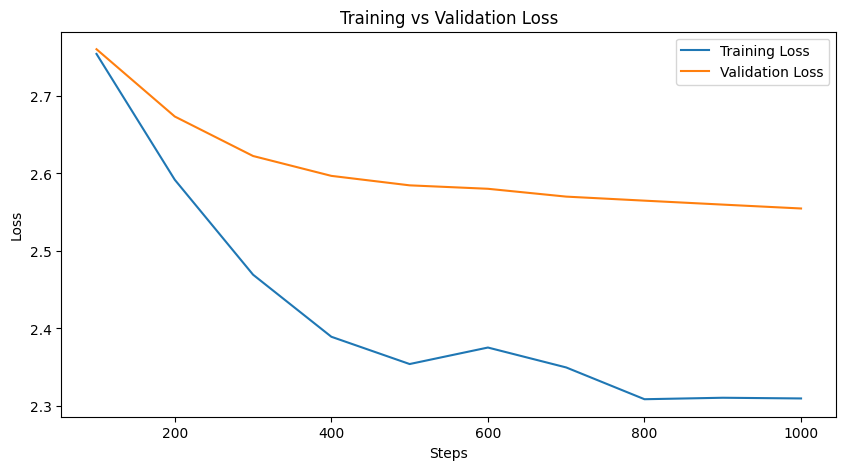

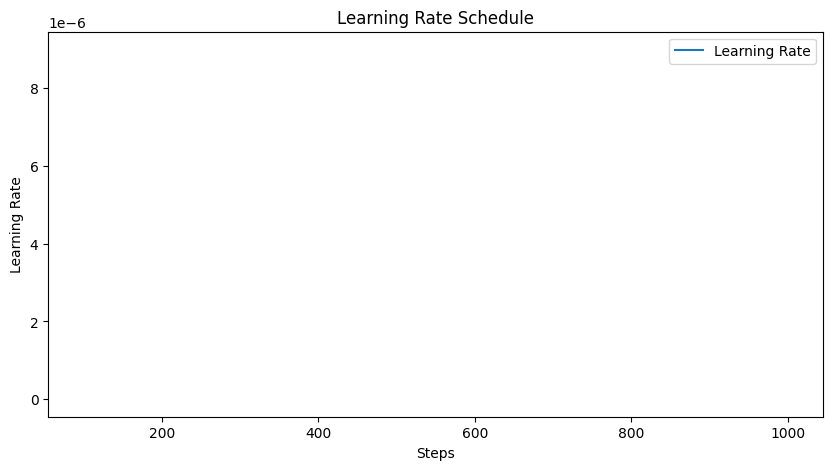

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd

# Extract logged history
log_history = trainer.state.log_history

# Convert to DataFrame for easy processing
df = pd.DataFrame(log_history)

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(df[df['loss'].notna()]['step'], df[df['loss'].notna()]['loss'], label="Training Loss")
if 'eval_loss' in df.columns:
    plt.plot(df[df['eval_loss'].notna()]['step'], df[df['eval_loss'].notna()]['eval_loss'], label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Plot Learning Rate if available
if 'learning_rate' in df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df['step'], df['learning_rate'], label="Learning Rate")
    plt.xlabel("Steps")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.legend()
    plt.show()

# Plot GPU Memory Usage if logged
if 'gpu_memory_allocated_gb' in df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df['step'], df['gpu_memory_allocated_gb'], label="GPU Memory Allocated (GB)")
    plt.plot(df['step'], df['gpu_memory_reserved_gb'], label="GPU Memory Reserved (GB)")
    plt.xlabel("Steps")
    plt.ylabel("Memory (GB)")
    plt.title("GPU Memory Usage Over Training")
    plt.legend()
    plt.show()

In [ ]:
import torch
from langdetect import detect
import sacrebleu
from bert_score import score
import re

# Function to filter out non-French parts while keeping valid French sentences
def filter_french_text(text):
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split into sentences
    french_sentences = [sent for sent in sentences if detect(sent) == "fr"]  # Keep only French sentences
    return " ".join(french_sentences).strip()  # Reconstruct filtered text

# Function to generate translation and retry if needed
def generate_translation(input_text, max_new_tokens=50, max_attempts=5):
    input_text = input_text.replace("->", "").strip()
    conditioned_text = "Translate the following German text into French: " + input_text

    attempt = 0
    while attempt < max_attempts:
        attempt += 1
        inputs = tokenizer(conditioned_text, return_tensors="pt", truncation=True, max_length=128).to(model.device)
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=5,
            early_stopping=True,
            temperature=0.7,        # Reduced randomness
            repetition_penalty=2.0,  # Increase penalty to discourage repetition
            length_penalty=1.5,      # Encourage longer, more complete responses,
        )
        translation = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
        translation = translation.replace("->", "").strip()

        # Filter out non-French parts
        filtered_translation = filter_french_text(translation)

        # If there is at least some French text, return it
        if filtered_translation:
            return filtered_translation

        print(f"Attempt {attempt}: No French detected. Retrying...")

    # If max attempts reached, return the last attempt (even if incorrect)
    print(f"Max retries reached. Returning last attempt: {translation}")
    return translation

# Initialize lists for results
generated_translations = []
reference_translations = []  # List of reference texts (one per sample)

# Loop through test data
for idx, sample in enumerate(test_data):
    try:
        german_input = sample["german"]
        ref_french = sample["french"]
        generated = generate_translation(german_input, max_new_tokens=50)

        if generated:  # Only add non-empty translations
            print(f"Sample {idx}:")
            print("German input:", german_input)
            print("Generated translation (validated):", generated)
            print("Reference translation:", ref_french)
            print("-" * 50)

            generated_translations.append(generated)
            reference_translations.append(ref_french)
        else:
            print(f"Skipping Sample {idx} due to repeated non-French output.")
    except Exception as e:
        print(f"Error processing sample {idx}: {e}")

print("Number of valid French translations:", len(generated_translations))

# Compute BLEU score only if translations exist
if generated_translations:
    bleu = sacrebleu.corpus_bleu(generated_translations, [[ref] for ref in reference_translations])
    print("BLEU score on quick test set:", bleu.score)
else:
    print("No valid translations generated. Skipping BLEU score.")

# Compute BERTScore only if translations exist
if generated_translations:
    P, R, F1 = score(generated_translations, reference_translations, lang="fr", verbose=True)
    print("Average BERTScore F1 on test set:", F1.mean().item())
else:
    print("No valid translations generated. Skipping BERTScore.")


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: OSZE-Generalsekretär Zannier (Archiv) © picture-alliance/dpa/A. Müller, © picture-alliance/dpa/B. Schmiedel, © picture-alliance/dpa/C. Hoffmann, © picture-alliance/
Sample 0:
German input: OSZE-Generalsekretär Zannier (Archiv) © picture-alliance/dpa
Generated translation (validated): Translate the following German text into French: OSZE-Generalsekretär Zannier (Archiv) © picture-alliance/dpa/A. Müller, © picture-alliance/dpa/B. Schmiedel, © picture-alliance/dpa/C. Hoffmann, © picture-alliance/
Reference translation: Le secrétaire général de l’OSCE M. Zannier (Archives) © picture-alliance/dpa
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 1:
German input: Damit wird an den Aktionsplan vom 2003 angeknüpft.
Generated translation (validated): C’est le plan d’action qui a été annulé en 2003. C’est le plan d’action qui a été annulé en 2003. C’est le
Reference translation: Ce nouveau plan s'inscrit dans la continuation du plan d'action de 2003.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 2:
German input: Nach dem Einmarsch der Sowjetischen Truppen 1979 wurde der Arg-Komplex  beschädigt und verfiel zunehmend.
Generated translation (validated): Après le marché militaire de l’Union soviétique en 1979, la complexité argentine a été agressée et déterminée. Après le marché militaire de l
Reference translation: Après l’invasion des troupes soviétiques en 1979, le complexe de l’Arg fut endommagé et tomba en ruines.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 3:
German input: "Es wäre unverantwortlich, die vielleicht letzten Chancen zur Entschärfung des Konfliks auszulassen."
Generated translation (validated): Translate the following German text into French: "Es wäre unverantwortlich, die vielleicht letzten Chancen zur Entschärfung des Konfliks auszulassen."  "Il était inadvisable d’avoir pensé qu’il y avait peu d’opportunités pour réduire le conflit.”  “Il était
Reference translation: « Il serait irresponsable d’ignorer ce qui constitue peut-être les dernières chances de désamorcer le conflit. »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 4:
German input: Das Auswärtige Amt bietet in Kooperation mit dem Goethe-Institut ein umfangreiches, themenorientiertes Sprachkursprogramm speziell für höhere EU-Bedienstete und Ministerialbeamte aus EU-Partnerländern und weiteren europäischen Nachbarländern an, um Deutsch als Arbeits- und Verhandlungssprache in der EU zu stärken.
Generated translation (validated): Le Ministère des Affaires étrangères coopérate avec l’Institut français de la langue étrangère pour offrir une cours d’apprentissage
Reference translation: En coopération avec le Goethe-Institut, le ministère fédéral des Affaires étrangères propose un vaste programme de cours de langue thématiques à destination des hauts fonctionnaires de l’UE et des pays partenaires membres ou non de l’UE pour renforcer le poids de l’allemand comme langue de travail et de négociation dans l’UE.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 5:
German input: Auf die Anerkennung des Westwerks und der Civitas Corvey als Weltkulturerbe dürfe heute ganz Deutschland stolz sein - ganz besonders aber Ostwestfalen.
Generated translation (validated): Lorsqu’on connaît le développement de l’église et de la cité de Corvey comme culture mondiale, c’est qu’Allemagne est
Reference translation: Il a conclu en déclarant qu’aujourd’hui, toute l’Allemagne avait raison d’être fière de la reconnaissance du massif occidental et de la « Civitas Corvey » comme patrimoine culturel mondial, mais en particulier la Westphalie de l’Est.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 6:
German input: Tuvalu
Generated translation (validated): Translate the following German text into French: Tuvalu est un pays situé en l’océan Pacifique. C’est une région où la plupart des habitants sont exposés à des risques de catastrophes naturelles
Reference translation: Tuvalu
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 7:
German input: Es sei deshalb notwendig, jede Chance zu nutzen, um eine Deeskalation herbeizuführen, so Steinmeier.
Generated translation (validated): Il est nécessaire d’utiliser toutes les chances possibles pour répondre à la dégradation de l’eau. Il faut utiliser toutes les chances possibles pour ré
Reference translation: D’où la nécessité de saisir toute chance de désescalade qui s’offre.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 8:
German input: Merkel und Hollande bekräftigten in ihrer gemeinsamen Pressekonferenz am Dienstagnachmittag, gerade die Verhandlungen mit Iran seien beispielhaft für die enge deutsch-französische Zusammenarbeit - ebenso wie die Beratungen zur Ukraine-Krise im sogenannten Normandie-Format zwischen Frankreich, Deutschland, Russland und der Ukraine.
Generated translation (validated): Le ministre allemand et le ministre français ont été présents à l’occasion de la conférence des presse mondiales auprès du minist
Reference translation: Dans leur conférence de presse conjointe de mardi après-midi, Mme Merkel et M. Hollande ont affirmé que les négociations avec l’Iran illustraient justement l’intensité de la coopération franco-allemande, tout comme les consultations sur la crise ukrainienne menées en « format Normandie » entre la France, l’Allemagne, la Russie et l’Ukraine.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 9:
German input: Wir müssen auf diese Tragödie immer wieder hinweisen und alles tun, um diese Gruppen zu schützen.
Generated translation (validated): Nous devons continuer à s’engager dans cette tragédie jusqu’au moment où nous avons besoin de protéger ces groupes. Nous dev
Reference translation: Nous devons attirer sans cesse l’attention sur cette tragédie et tout faire pour protéger ces groupes.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 10:
German input: Fahrerlaubnis
Generated translation (validated): ## INPUT
Fahrerlaubnis  Licence de conduire. ##OUTPUT
Licence de conduire  Licence de conduire. La licence de conduire est
Reference translation: Permis de conduire
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 11:
German input: Südafrika
Generated translation (validated): Côte d’Ivoire  Côte d’Ivoire. L’Algérie  Algérie.
Reference translation: Afrique du Sud
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error processing sample 12: No features in text.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 13:
German input: Außenminister Steinmeier ist am 14.01. mit NATO-Generalsekretär Stoltenberg zusammengekommen.
Generated translation (validated): Le ministre allemand de l’extrême-occident, Frank-Walter Steinmeier, a eu le 14 janvier avec le ministre allemand des Affaires étrangè
Reference translation: Frank-Walter Steinmeier a rencontré le secrétaire général de l’OTAN, Jens Stoltenberg, le 14 janvier.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 14:
German input: WDR-Europaforum:
Generated translation (validated): Forum européen de l’ORTF. Forum européen de l’ORTF. Forum européen de l’ORT
Reference translation: Forum européen de la WDR :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 15:
German input: Aber den Weg zu einer Lösung werden wir nicht ohne Griechenland finden können.
Generated translation (validated): Alors que le chemin vers un résultat doit être trouvé, nous ne pouvons pas être sans la Grèce. Quand le chemin vers un résult
Reference translation: Il n’en reste pas moins que nous ne parviendrons pas à trouver une solution sans la Grèce.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 16:
German input: Betreuung von Binnenvertriebenen durch den Arbeiter-Samariter-Bund in Kiew © Arbeiter-Samariter-Bund
Generated translation (validated): Assistance des travailleurs sécurisés par l’ASB
Reference translation: Les déplacés internes accueillent par l’ASB à Kiev © Arbeiter-Samariter-Bund
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 17:
German input: "Ich würde mir wünschen, dass Iran seinen Einfluss nutzt, um die syrische Regierung an den Verhandlungstisch für den Einstieg in einen politischen Übergangsprozess zu bringen.
Generated translation (validated): J’aimerais voir que l’Iran peut avoir un impact significatif sur la région syrienne, afin qu’la gouvernement syrienne puisse accéder à
Reference translation: « Je souhaiterais que l’Iran use de son influence pour amener le gouvernement syrien à la table des négociations afin d’entrer dans un processus de transition politique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 18:
German input: Damit ist eine hohe Kontinuität bei der Behandlung von Menschenrechtsfragen in den Vereinten Nationen gesichert.
Generated translation (validated): Il est également une grande continuité en matière de gestion des questions de droits de l’homme entre les Nations unies. Il est également une grande continuité en
Reference translation: Les Nations Unies peuvent ainsi garantir une grande continuité dans le traitement des questions relatives aux droits de l’homme.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 19:
German input: Die Aktivisten aus Subsahara-Afrika setzen sich für die Rechte der Lesben, Schwulen, Bisexuellen, Transsexuellen und Intersexuellen in ihren Heimatländern ein.
Generated translation (validated): Les activistes de l’Afrique subsaharienne ont contribué à protéger les droits des gays, les bisexuelles, les transsexuelles et les intersexes dans le
Reference translation: Ces militants venus d’Afrique subsaharienne défendent les droits des lesbiennes, gays, bisexuels, transgenres et intersexués dans leur pays.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 20:
German input: Westbalkankonferenz für mehr Regional-Kooperation
Generated translation (validated): Conférence du Conseil de l’Ouest pour améliorer la coopération régionale. Conférence du Conseil de l’Ouest pour amé
Reference translation: La conférence sur les Balkans occidentaux favorable au renforcement de la coopération régionale
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 21:
German input: Auch wenn die Verhandlungen in den kommenden Tagen sicherlich schwierig bleiben: So kurz vor dem Ziel dürfe eine Lösung des Konflikts nicht aufs Spiel gesetzt werden, betonte Steinmeier erneut.
Generated translation (validated): C’est également important qu’un résultat de ces réunions ne soit pas considéré comme une solution pour la conflit. Il est également important que le r
Reference translation: Même si les négociations des prochains jours resteront certainement difficiles, il ne faut pas compromettre un règlement du conflit alors que nous sommes si près du but, a réaffirmé M. Steinmeier.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 22:
German input: Die Dauer der Beitrittsverhandlungen wird vom Reformtempo und den Annäherungsfortschritten des Beitrittskandidaten bestimmt und kann daher stark variieren.
Generated translation (validated): L’heure d’entrée des réformes est déterminée par l’évènement du candidat et peut être élevé ou diminue. Le temps
Reference translation: Le rythme des négociations dépend ainsi de la cadence des réformes entreprises et des progrès réalisés par le pays candidat et de son adaptation au droit de l’UE ; la durée des négociations est donc très variable.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 23:
German input: Ansonsten ist die Frage der "foreign fighters" ein Problem für die gesamte EU und macht noch einmal deutlich: Auch unsere Sicherheit erhöht sich, wenn wir dem Westbalkan eine klare Perspektive eröffnen können.
Generated translation (validated): Le problème des « militants étrangers » est un problème majeur pour l’Union européenne et doit être répondu avant tout: il est important que n
Reference translation: Par ailleurs, la question des combattants étrangers constitue un problème pour toute l’Union européenne et souligne une fois de plus que notre propre sécurité s’accroît si nous sommes en mesure d’offrir une claire perspective d’adhésion aux Balkans.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 24:
German input: Gemeinsames Konzept für EU-Flüchtlingsrettung
Generated translation (validated): Conception commune pour le rétablissement des réfugiés de l’Union européenne. Conception commune pour la rétablissement des réfugiés de l’UE
Reference translation: Concept commun européen pour le sauvetage des réfugiés
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 25:
German input: Jeder Mitgliedsstaat des Europarats ist zur Ratifikation der Konvention verpflichtet.
Generated translation (validated): Tous les États membres du Parlement européen sont obligés à ratifier la convention. Tous les États membres du Parlement européen sont obligés à rat
Reference translation: Tous les États membres du Conseil de l’Europe doivent ratifier la Convention.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 26:
German input: Schwerpunkt der knapp zweiwöchigen Asien-Pazifik-Wochen ist das Thema "Smart Cities". Dazu Böhmer:
Generated translation (validated): Dazu Böhmer:  C’est le thème « Ville intelligente » de l’Asie du Sud. Le thème « Ville intelligente » de l’Asie du Sud est la plus importante.
Reference translation: Les Semaines Asie-Pacifique qui dureront presque deux semaines auront pour thème principal les « smart cities ». Mme Böhmer :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 27:
German input: Mit diesen Worten begrüßte der Beauftragte für Cyberaußenpolitik im Auswärtigen Amt, Norbert Riedel, die Teilnehmerinnen und Teilnehmer des internationalen „Cybersummit 2014“.
Generated translation (validated): Le ministre de l’affaires étrangères, Norbert Riedel, a grâce à ces mots présenté par le ministre de l’affaires étrang
Reference translation: C’est en ces termes que le délégué à la cyberpolitique internationale du ministère fédéral des Affaires étrangères, Norbert Riedel, a accueilli les participantes et participants au cybersommet international 2014.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 28:
German input: Deutschland allein hat dafür über 20 Millionen Euro zur Verfügung gestellt.
Generated translation (validated): L’Allemagne n’a pas jamais donné plus de 20 milliards d’euros pour l’affaire. L’Allemagne n’a jamais
Reference translation: pour lequel l’Allemagne à elle seule a débloqué plus de 20 millions d’euros.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 29:
German input: Am Mittwoch (15.04.) haben die Außenminister der G7-Staaten ihr Frühjahrstreffen unter deutscher Präsidentschaft beendet.
Generated translation (validated): Le dimanche 15 février, les ministres des Affaires étrangères des pays membres de l’Union européenne ont rendu leur première réunion auprè
Reference translation: La réunion de printemps des ministres des Affaires étrangères du G7 sous présidence allemande s’est terminée mercredi (15 avril).
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 30:
German input: Akute internationale Krisen, die die globale Ordnung in Frage stellen, sieht Steinmeier beispielsweise in der Frage des iranischen Atomprogramms, im gemeinsamen Kampf gegen den islamistischen Terrorismus und in der Bewältigung der Ukrainekrise.
Generated translation (validated): Les crises étrangères actuelles, dont l’ordre mondial n’est pas seulement en question, sont préoccupantes pour Steinmeier comme par exemple dans
Reference translation: M. Steinmeier considère par exemple comme crises internationales aiguës mettant en péril l’ordre mondial, la question du programme nucléaire iranien, la lutte commune contre le terrorisme islamiste et la gestion de la crise ukrainienne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 31:
German input: Integration ist ein langfristiger Prozess, der zum Ziel hat, alle Menschen, die dauerhaft und rechtmäßig in Deutschland leben, in die Gesellschaft einzubeziehen.
Generated translation (validated): L’intégration est une processe longue et difficile, où l’objectif est que tous les gens, durant le temps et à la mesure qu’ils s
Reference translation: L’intégration est un processus de long terme dont l’objectif est d’intégrer dans la société tous ceux qui vivent de façon durable et régulière en Allemagne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 32:
German input: In Israel halten sich zahlreiche afrikanische Flüchtlinge und Asylsuchende auf.
Generated translation (validated): Dans l’Israël, il y a de nombreuses réfugiées africaines et d’asileurs en développement. En Allemagne, il existe
Reference translation: De nombreux réfugiés et demandeurs d’asile originaires d’Afrique se trouvent sur le sol israélien.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 33:
German input: Beispiele dafür sind:
Generated translation (validated): Translate the following German text into French: Beispiele dafür sind:  Par exemple, ces éléments sont utilisés pour illustrer le rôle que j’ai jusqu’à l’époque. C’est un exemple
Reference translation: En voici quelques exemples :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 34:
German input: Wer Fragen rund um das Thema "Arbeiten und Lernen in Deutschland" hat, kann sich direkt an das Info-Center der Zentralen Auslands - und Fachvermittlung (ZAV) der Bundesagentur für Arbeit wenden.
Generated translation (validated): Les questions sur le thème « travail et apprendre en Allemagne » ont été répondues directement à l’Info-Centre de l’Agence fédérale
Reference translation: Pour de plus amples informations sur les questions ayant trait au travail et à la formation en Allemagne, vous pouvez vous adresser directement au centre d’information du Service central de placement (ZAV) de l’Agence fédérale pour l’emploi.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 35:
German input: Derzeit befindet sich die Mission MISCA der Afrikanischen Union (AU) im Land.
Generated translation (validated): La mission MISCA de l’Union africaine (AU) est située en Afrique. Le mission MISCA de l’Union africaine (AU) est située dans l’Afrique.
Reference translation: La Mission internationale de soutien à la Centrafrique sous conduite africaine (MISCA) de l’Union africaine (UA) est actuellement déployée dans le pays.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Finnland (2)  Finlande (2)  Finlande (2)  Finlande (2)  Finlande (2)  Finlande (2)  Finlande (2)
Sample 36:
German input: Finnland (2)
Generated translation (validated): Translate the following German text into French: Finnland (2)  Finlande (2)  Finlande (2)  Finlande (2)  Finlande (2)  Finlande (2)  Finlande (2)
Reference translation: Finlande (2)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 37:
German input: Mit keinem Partner stimmen wir uns in außenpolitischen Fragen heute umfassender und intensiver ab als mit Frankreich.
Generated translation (validated): Nous avons besoin d’avoir un partenariat avec l’Allemagne pour résoudre les questions étrangères ce soir. Nous avons besoin d’
Reference translation: Aujourd’hui, la France est le partenaire avec lequel nous nous accordons de la manière la plus complète et la plus intense dans le domaine de la politique étrangère.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 38:
German input: Als erste Sonderberichterstatterin wurde die pakistanischen Anwältin Hina Jilani ernannt.
Generated translation (validated): Elle est la première représentante de l’Ancien Régime pakistanaise, Hina Jilani. Elle est la première représentante de l’
Reference translation: L’avocate Hina Jilani (Pakistan) a été la première à exercer ces fonctions.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 39:
German input: Gemeinsam mit seinen EU-Partnern und mit anderen westlichen Staaten verfolgt Deutschland aufmerksam die Einhaltung der Menschenrechte und auch die Entwicklung der humanitären Lage in Sri Lanka.
Generated translation (validated): En commun avec ses partenaires européens et avec les autres pays occidentaux, l’Allemagne fait face à la protection des droits de l’homme et à la dé
Reference translation: Avec ses partenaires européens et d’autres États occidentaux, l’Allemagne observe attentivement le respect des droits de l’homme ainsi que l’évolution de la situation humanitaire de Sri Lanka.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 40:
German input: Unterstützung für Aufnahmestaaten
Generated translation (validated): Le soutien aux députés est une valeur majeure dans le domaine de l’Union europ
Reference translation: Soutien aux pays d'accueil
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 41:
German input: Das werden wir sehen.
Generated translation (validated): Nous allons voir. Vous allez voir. Est-ce que vous allez voir? Oui, vous allez voir. Non, nous n’avons pas
Reference translation: L’avenir le dira.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 42:
German input: In Ramallah und Jerusalem stand der Nahost-Friedensprozess im Mittelpunkt seiner Unterredungen mit den politisch Verantwortlichen beider Seiten.
Generated translation (validated): Dans les villes de Ramallah et de Jerusalem, le processus de la négociation de la paix est situé dans le centre de ses rapports avec les députés politiques de l’
Reference translation: À Ramallah comme à Jérusalem, le processus de paix a été au cœur de ses discussions avec les responsables politiques des deux bords.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 43:
German input: Deshalb hätte Europa "ein Interesse daran, dass dieses tunesische Beispiel nicht nur überlegt, sondern lebt und sich entwickle".
Generated translation (validated): Il existe une intérêt pour l’Union européenne en ce qui concerne cette example musicale. Il existe une intérêt pour l’Union européenne en ce
Reference translation: C’est pourquoi l’Europe « a intérêt à ce que cet exemple tunisien non seulement survive mais soit bien vivant et se développe ».
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 44:
German input: Steinmeier für stärkere OSZE-Rolle in Ukraine-Krise
Generated translation (validated): Steinmeier pour une rôle plus forte dans l’OSZE en Ukraine. Steinmeier pour une rôle plus forte dans l’OSZE en Ukraine.
Reference translation: Steinmeier : « Renforcer le rôle de l’OSCE dans la crise ukrainienne »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 45:
German input: Diese Sammlung von Links und Informationen soll Ihnen den Zugang dazu erleichtern.
Generated translation (validated): Cette collection de links et de données permettra à vous rencontrer. Cette collection de links et de données permettra à vous rencontrer. Cette collection de links
Reference translation: Notre liste de liens et d’informations vous permettra d’y accéder plus facilement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 46:
German input: Das Welterbekomitee besteht aus 21 Mitgliedern, von denen etwa ein Drittel alle zwei Jahre von der Generalversammlung der inzwischen 190 Vertragsstaaten der Welterbekonvention neu gewählt wird.
Generated translation (validated): Le Conseil de l’Union européenne est composé d’21 membres, desquelles plusieurs décennies ont été partis. Les membres du Con
Reference translation: Le comité du patrimoine mondial se compose de 21 membres, dont un tiers environ est renouvelé tous les deux ans par l’assemblée générale des 190 États parties à la convention du patrimoine mondial.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 47:
German input: Wir wollen das nach Kräften unterstützen.
Generated translation (validated): Nous avons besoin de répondre aux défis. Nous avons besoin de répondre aux défis. Nous avons besoin de répondre aux défis
Reference translation: Nous voulons le soutenir au maximum dans l’accomplissement de cette tâche.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 48:
German input: Die Verhandlungspartner hätten zwar Fortschritte gemacht und neue Ideen auf den Tisch gebracht - diese müssten jedoch erst von Experten überprüft werden.
Generated translation (validated): Les partenaires de la réunion ont construit des progrès et nouveaux idées sur le tableau - ces idées doivent être évaluées par des experts.
Reference translation: Les partenaires de négociation ont certes progressé et mis de nouvelles idées sur la table, mais celles-ci doivent tout d’abord être examinées par les experts, a-t-il poursuivi.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 49:
German input: Während der zuvor gültige Rahmen ("Hyogo Framework for Action") sich hauptsächlich auf die Reduzierung von Katastrophen konzentriert hatte, geht das neue Rahmenwerk nun einen Schritt weiter und gibt allen Staaten und der Zivilgesellschaft ein Instrument für vorrausschauendes Risikomanagement an die Hand.
Generated translation (validated): Le système de réduction des catastrophes (Framework pour l’action en matière de réduction des catastrophes, FRAM) a été concentré sur la réduction des catastrophes
Reference translation: Tandis que le cadre applicable jusqu’à présent (« Cadre d’action de Hyogo ») se concentrait essentiellement sur la réduction des catastrophes, le nouveau cadre fait un pas de plus en fournissant à tous les États et à la société civile un instrument de gestion prospective des risques.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 50:
German input: Lesen Sie mehr:
Generated translation (validated): Lire ce livre est intéressant. J’aime lire ce livre. J’adore lire ce livre.
Reference translation: Pour en savoir plus :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 51:
German input: In einem gemeinsamen Auftaktstatement mit Rinkēvičs erklärte Steinmeier, die häufigen Treffen mit seinem lettischen Amtskollegen in den letzten Wochen seien nicht nur ein Zeichen für die vertrauensvolle Zusammenarbeit, sondern auch ein Signal für die großen Aufgaben, die es derzeit zu bewältigen gebe:
Generated translation (validated): Le président de l’Union européenne, Emmanuel Macron,
Reference translation: Lors d’une déclaration inaugurale conjointe, M. Steinmeier a indiqué que ses rencontres fréquentes des dernières semaines avec son homologue letton témoignaient non seulement d’une coopération empreinte de confiance mais aussi de l’ampleur des tâches à accomplir actuellement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 52:
German input: Wer Menschenrechte stärkt, stärkt den Frieden
Generated translation (validated): Les droits de l’homme s’affirment, s’affirment la paix. Les droits de l’homme s’affirment, s’affir
Reference translation: Renforcer les droits de l’homme, c’est renforcer la paix
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 53:
German input: Deshalb sage ich:
Generated translation (validated): Translate the following German text into French: Deshalb sage ich: "Je suis très heureux de vous rencontrer."  Je suis très heureux de vous rencontrer. Je suis très heureux de vous rencontrer
Reference translation: C’est pourquoi je le dis :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 54:
German input: Seine Aufgabe ist es, zur weiteren Annäherung beider Gesellschaften beizutragen und gemeinsame deutsch-polnische Projekte voranzubringen.
Generated translation (validated): Ses objectifs sont d’élargir la communication entre les deux sociétés et de développer des projets cohérents allemand-polnien.
Reference translation: Sa mission est de contribuer au rapprochement des deux sociétés et au développement de projets germano-polonais.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 55:
German input: Deutschland hat seitdem die G7-Präsidentschaft übernommen.
Generated translation (validated): La France a été présidente de la conférence du G7 depuis demain. La France a été présidente de la conférence du G7 depuis demain.
Reference translation: Depuis cette date, l’Allemagne exerce la présidence du G7.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 56:
German input: Mehr zum Treffen in Kopenhagen (1.12.). lesen Sie hier.
Generated translation (validated): Vraiment plus pour la conférence à Kopenhagen (1er décembre). vous pouvez voir ici. Il y a plus de temps pour la conférence à Kopenh
Reference translation: Vous trouverez ici de plus amples informations sur la rencontre de Copenhague (1er décembre).
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 57:
German input: Kloster Corvey ist wie Palmyra einer der Stätten, an denen uns bewusst wird, woher wir kommen, auf welchen Schultern wir stehen, wo die entscheidenden Entwicklungsschritte der Menschheit stattgefunden haben, die Teil unserer Identität geworden sind.
Generated translation (validated): La cathédrale de Corvey est comme Palmyra dans une région, où nous avons besoin de décider qu’est-ce que nous allons voir et pourqu
Reference translation: Tout comme Palmyre, l’abbaye de Corvey fait partie de ces sites qui nous font comprendre d’où nous venons, sur quelles épaules nous reposons, quelles ont été les étapes cruciales de l’évolution du genre humain qui font à présent partie de notre identité.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 58:
German input: Erste Reihe v.l.:
Generated translation (validated): Première classe. Première classe. Première classe. Première classe. Première classe. Première classe.
Reference translation: Au premier rang de g. à d. :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 59:
German input: Viel Zeit ist nicht mehr.
Generated translation (validated): Il n’y a plus de temps. Il n’y a plus de temps. Il n’y a plus de temps. Il n’y a plus de temps.
Reference translation: Le temps est compté.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 60:
German input: Welche Instrumente stehen ihr zur Verfügung und wie sind diese in Bündnisse und Partnerschaften eingebettet?
Generated translation (validated): Quels instruments sont-ils utilisés pour le déploiement et comment sont ces moyens utilisés dans les alliances et partenariats?
Reference translation: Quels sont les instruments dont elle dispose et comment sont-ils intégrés dans les alliances et partenariats ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 61:
German input: Der Nürnberger Prozess gegen die Hauptkriegsverbrecher (November 1945 bis Oktober 1946) im Saal 600 des Nürnberger Justizpalastes © picture alliance / akg-images
Generated translation (validated): Translate the following German text into French: Der Nürnberger Prozess gegen die Hauptkriegsverbrecher (November 1945 bis Oktober 1946) im Saal 600 des Nürnberger Justizpalastes © picture alliance / akg-images.de  Le procès de Nuremberg sur la guerre mondiale (Novembre 1945 à octobre 1946) au Palais de Justice de Nuremberg © picture alliance / akg-images
Reference translation: Le procès de Nuremberg contre les grands criminels de guerre (novembre 1945 à octobre 1946) dans la salle 600 du palais de justice © picture alliance / akg-images
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 62:
German input: Außenminister Frank-Walter Steinmeier vor dem Treffen der EU-Außenminister © consilium.europa.eu
Generated translation (validated): Translate the following German text into French: Außenminister Frank-Walter Steinmeier vor dem Treffen der EU-Außenminister © consilium.europa.eu/de/presse/aktuell  Le ministre fédéral de l’Union européenne, Frank-Walter Steinmeier, a présenté au Conseil des ministres
Reference translation: Frank-Walter Steinmeier peu avant la réunion des ministres européens des Affaires étrangères © consilium.europa.eu
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Sprachkurse in Deutschland für EU-Bedienstete und Ministerialbeamte aus den EU-Mitgliedstaaten und weiteren Staaten (Webseite auf Deutsch und Englisch)  Cours de langue allemande en Allemagne pour les membres du Conseil européen et des ministres étrangers de l’Union européenne et d’autres pays
Sample 63:
German input: Sprachkurse in Deutschland für EU-Bedienstete und Ministerialbeamte aus den EU-Mitgliedstaaten und weiteren Staaten (Webseite auf Deutsch und Englisch)
Generated translation (validated): Translate the following German text into French: Sprachkurse in Deutschland für EU-Bedienstete und Ministerialbeamte aus den EU-Mitgliedstaaten und weiteren Staaten (Webseite auf Deutsch und Englisch)  Cours de langue allemande en Allemagne pour les membres du Conseil européen et des ministres étrangers de l’Union européenne et d’autres pays
Reference tr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 64:
German input: Worauf haben wir uns also geeinigt?
Generated translation (validated): Qu’est-ce que nous avons fait aussi?
Reference translation: Voici les points sur lesquels nous nous sommes mis d’accord :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 65:
German input: Inhaber gültiger Visa der EWR-Staaten (EU-Staaten und Island, Lichtenstein, Norwegen, Schweiz) sowie Japan, Kanada und den Vereinigten Staaten von Amerika ausgestellter Visa.
Generated translation (validated): Le président de l’Organisation européenne pour la sécurité des migrations (OESM) a déclaré que les États membres de l’Union europé
Reference translation: les titulaires d’un visa valide délivré par un État de l’Espace économique européen (États de l’UE et Islande, Liechtenstein, Norvège, Suisse), le Canada, les États-Unis d’Amérique ou le Japon.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 66:
German input: Trotz des rasanten Wandels auf dem afrikanischen Kontinent verhindern bewaffnete Konflikte, politische und ethnische Spannungen, Grenzstreitigkeiten und fragile Staatlichkeit in einigen Teilen Afrikas weiterhin sozialen, wirtschaftlichen und politischen Fortschritt.
Generated translation (validated): Le changement récent dans le contexte africain engendre des conflits politiques et éthniques, des tensions politiques et culturelles, des frontières stratégiques et une
Reference translation: Malgré les changements rapides qui s’opèrent sur le continent africain, les conflits armés ainsi que des tensions politiques et ethniques, des différends frontaliers et la fragilité des systèmes politiques continuent, dans certaines régions de l’Afrique, de faire entrave au progrès social, économique et politique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 67:
German input: Regierungsführung, Sicherheit und Entwicklung.
Generated translation (validated): Le gouvernement fédéral, la sécurité et le développement. Le gouvernement fédéral, la sécurité et le développement. Le gouvern
Reference translation: gouvernance, sécurité et développement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Außenminister Frank-Walter Steinmeier bei der Podiumsdiskussion "Warm up: Wir diskutieren Außenpolitik in Lübeck!" © AA. © AA. © AA. © AA. © AA. © AA. © AA. © AA. © AA. © AA. © AA. © AA. © AA.
Sample 68:
German input: Außenminister Frank-Walter Steinmeier bei der Podiumsdiskussion "Warm up: Wir diskutieren Außenpolitik in Lübeck!" © AA
Generated translation (validated): Translate the following German text into French: Außenminister Frank-Walter Steinmeier bei der Podiumsdiskussion "Warm up: Wir diskutieren Außenpolitik in Lübeck!" © AA. © AA. © AA. © AA. © AA. © AA. © AA. © AA. © AA. © AA. © AA. © AA. © AA.
Reference translation: Le ministre fédéral des Affaires étrangères, Frank-Walter Steinmeier, lors de la table ronde « Warm Up – Nous discutons politique étrangère à Lübeck » © Ministère fédéral des Affaires étrangères
------------------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 69:
German input: Von dort war die Unglücksmaschine am 24.03. gestartet.
Generated translation (validated): C’était le début de la mauvaise fonctionnalité de l’appareil d’incendie qui a été activé le 24 mars. Le début de
Reference translation: C’est de Barcelone qu’avait décollé l’appareil le 24 mars.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gemeinsame Pressekonferenz nach dem Trialog © photothek.net/Trutschel | © photothek.net/Trutschel | © photothek.net/Trutschel | © photothek.net/Trutschel | © photothek.net/Trut
Sample 70:
German input: Gemeinsame Pressekonferenz nach dem Trialog © photothek.net/Trutschel
Generated translation (validated): Translate the following German text into French: Gemeinsame Pressekonferenz nach dem Trialog © photothek.net/Trutschel | © photothek.net/Trutschel | © photothek.net/Trutschel | © photothek.net/Trutschel | © photothek.net/Trut
Reference translation: Conférence de presse conjointe après les entretiens trilatéraux © photothek.net/Trutschel
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 71:
German input: Wir sind noch lange nicht über den Berg.
Generated translation (validated): Nous sommes plus tard sur le côté de la montagne. Nous sommes plus tard sur le côté de la montagne. Nous sommes plus tard sur
Reference translation: Nous sommes pourtant loin d’être au bout de nos peines.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 72:
German input: Koordinator für die transatlantische Zusammenarbeit, Auswärtiges Amt, 11013 Berlin
Generated translation (validated): Direction générale pour la coopération transatlantique, Ministère des Affaires étrangères, 11003 Berlin. Direction générale pour la coopération transatlantique
Reference translation: Koordinator für die transatlantische Zusammenarbeit, Auswärtiges Amt, 11013 Berlin
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 73:
German input: Techniken, wie zum Beispiel Java-Applets oder Active-X-Controls, die es ermöglichen, das Zugriffsverhalten der Nutzerinnen und Nutzer nachzuvollziehen, werden nicht eingesetzt.
Generated translation (validated): Les méthodes, comme l’exemple de Java-Applets ou de Control Active-X, qui peuvent être utilisées, ne sont pas également disponibles
Reference translation: Les techniques telles que les appliquettes (applet) Java ou les contrôles Active X, qui permettent de suivre le comportement des utilisateurs sur internet, ne sont pas utilisées.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 74:
German input: Ebenfalls anerkannt werden kann nach Prüfung auch eine 3 jährige aktuelle Berufserfahrung ohne Abschluss.
Generated translation (validated): Il est possible d’être considéré comme déterminé après un examen précédent, même si elle n’a pas été terminée. Il est
Reference translation: De même, une expérience professionnelle récente de 3 ans sans certificat pourra être reconnue après avoir été examinée.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 75:
German input: Schillernde Teilnehmerinnen und breites Themenspektrum
Generated translation (validated): Les actrices et actifs de l’économie allemande ont un rôle clé pour l’avenir.
Reference translation: Des participantes rayonnantes et un large éventail de sujets
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 76:
German input: Deutschland erhöht Hilfe für die Opfer des Syrien-Konflikts (15.01.2014)
Generated translation (validated): Le pays allemand apporte aide aux victimes de la guerre en Syrie
Reference translation: L’Allemagne augmente l’aide aux victimes du conflit syrien (15/01/2014)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 77:
German input: 1981 – 1983 Institut d’Etudes Politiques, Paris (Diplom)
Generated translation (validated): Translate the following German text into French: 1981 – 1983 Institut d’Etudes Politiques, Paris (Diplom)  1981-1983 École nationale d’études politiques de Paris (Diplômé). 1981-1983 École nationale d’études politiques de Paris.
Reference translation: 1981 – 1983 Institut d’Études Politiques, Paris (diplôme)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 78:
German input: Ich freue mich, dass es gelungen ist, die Akademie gemeinsam mit dem Freistaat Bayern und der Stadt Nürnberg auf den Weg zu bringen.
Generated translation (validated): Je suis heureux de savoir que ce n’est pas fait que la Académie coopératif avec l’État allemand et le communauté urbaine de N
Reference translation: Je me félicite qu’il ait été possible de lancer cette académie avec le concours de l’État libre de Bavière et de la ville de Nuremberg.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 79:
German input: Die Ausbildung qualifizierter ausländischer Studierender an deutschen Hochschulen ist ein vordringliches Anliegen der Bundesregierung.
Generated translation (validated): L’éducation professionnelle des élèves qui ont étudié à l’école supérieure d’Allemagne est une réponse du gouvernement féd
Reference translation: La formation d’étudiants étrangers qualifiés dans des établissements d’enseignement supérieur allemands est l’une des toutes premières priorités du gouvernement fédéral.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 80:
German input: Im Blick:
Generated translation (validated): Translate the following German text into French: Im Blick:  Dans l’œil:  Il fait beau aujourd’hui:  El clima est agréable aujourd’hui:  C’est une belle
Reference translation: En focus :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 81:
German input: Der OSZE komme dabei eine sehr verantwortungsvolle Rolle zu, so Steinmeier weiter.
Generated translation (validated): Le ministre de la République fédérale allemande, Frank-Walter Steinmeier, affirme que l’OSZE a un rôle très forte et responsable.
Reference translation: Dans ce contexte, a-t-il poursuivi, l’OSCE joue un rôle essentiel et responsable.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier und Amtskollege Linkevičius © photothek.net/ © photothek.net/ © photothek.net/ © photothek.net/ © photothek.net/ © photothek.net/ © phot
Sample 82:
German input: Steinmeier und Amtskollege Linkevičius © photothek.net
Generated translation (validated): Translate the following German text into French: Steinmeier und Amtskollege Linkevičius © photothek.net/ © photothek.net/ © photothek.net/ © photothek.net/ © photothek.net/ © photothek.net/ © phot
Reference translation: M. Steinmeier et son homologue M. Linkevičius © photothek.net
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 83:
German input: Die wachsende Bedeutung des Internets und die stetig zunehmende Zahl an Nutzern werde sich eben nicht von selbst regulieren, so der Außenminister weiter.
Generated translation (validated): L’importance actuelle de l’internet et la grande quantité de personnes qui utilisent cette technologie ne pourraient pas être régulièrement contrôlées par
Reference translation: il ne faut pas compter sur le fait que l’importance croissante de l’Internet et le nombre toujours grandissant d’internautes se régulent d’eux-mêmes.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 84:
German input: Auch im Zentrum des Gesprächs der Außenminister Steinmeier und Gentiloni standen vornehmlich Fragen "von großer europäischer Reichweite".
Generated translation (validated): Bien sûr dans le centre de la conférence de ministres Steinmeier et Gentiloni, les questions « de grande représentation européenne » ont été soumises.
Reference translation: Des questions « d'une grande portée européenne » étaient également au cœur de l'entretien de MM. Steinmeier et Gentiloni.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 85:
German input: Im Weltsaal des Auswärtigen Amts kamen außerdem Vertreter der internationalen Gemeinschaft zu den Friedensverhandlungen hinzu.
Generated translation (validated): Dans la salle de presse du ministère des Affaires étrangères, il existe aussi des représentants internationaux de l’Union européenne et de l’
Reference translation: Des représentants de la communauté internationale ont également rejoint les négociations de paix dans la Weltsaal du ministère fédéral des Affaires étrangères.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 86:
German input: Syrischer Oppositionsführer zu Gespräch bei Steinmeier:
Generated translation (validated): Translate the following German text into French: Syrischer Oppositionsführer zu Gespräch bei Steinmeier:  Le président de l’Union européenne, Jean-Claude Juncker, a répondu à le ministre des Affaires étrangères, Frank-Walter Steinmeier, qui a
Reference translation: Rencontre entre M. Steinmeier et le chef de l’opposition syrienne :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 87:
German input: Der Druck der Klickzahlen - ein Wettbewerbsnachteil für die Außenpolitik?
Generated translation (validated): Le nombre d’affichages de clicks - un facteur important pour la politique étrangère. Le nombre d’affichages de clicks est un facteur important pour la politique é
Reference translation: Le nombre de clics, un handicap concurrentiel pour la politique étrangère ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 88:
German input: Schutz von Menschenrechtsverteidigern
Generated translation (validated): Protection des droits de l’homme. Protection des droits de l’homme. Protection des droits de l’homme.
Reference translation: Protection des défenseurs des droits de l’homme
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 89:
German input: Zusammenhalt in einer Solidargemeinschaft
Generated translation (validated): Il est important de s’assurer dans une communauté solidarité. Il est important de s’assurer dans une communauté solidarité. Il faut
Reference translation: La cohésion d’une communauté solidaire
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 90:
German input: Ich hatte mir vier Schwerpunkte gesetzt: das europäische Schiff durch stürmische See zu bringen; die richtigen Antworten auf die neuen Freiheitsbewegungen in unserer südlichen und östlichen Nachbarschaft zu geben; neue strategische Partnerschaften mit den aufstrebenden Kraftzentren der Welt zu begründen.
Generated translation (validated): J’ai besoin de traduire cet texte de langue allemande en français: « Je m’ai fournis quatre principaux objectifs: l’équipement
Reference translation: Je m’étais fixé quatre priorités : assurer la traversée du bateau européen malgré des eaux tumultueuses ; donner les bonnes réponses aux nouveaux mouvements de libération dans notre voisinage au sud et à l’est ; créer de nouveaux partenariats stratégiques avec les pôles de puissance émergents de la planète.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Mitarbeiter des UNHCR kümmern sich um die Registrierung der Flüchtlinge © Photothek/Imo / © photothek.net/ © photothek.net/ © photothek.net/ © photothek.net/ © photothek.net/ © phot
Sample 91:
German input: Mitarbeiter des UNHCR kümmern sich um die Registrierung der Flüchtlinge © Photothek/Imo
Generated translation (validated): Translate the following German text into French: Mitarbeiter des UNHCR kümmern sich um die Registrierung der Flüchtlinge © Photothek/Imo / © photothek.net/ © photothek.net/ © photothek.net/ © photothek.net/ © photothek.net/ © phot
Reference translation: Le personnel du HCR s'occupe de l'enregistrement des réfugiés © Photothek/Imo
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 92:
German input: Das Komitee der Ministerbeauftragten befasste sich im Jahr 2013 in einer thematischen Debatte mit der Rolle der Menschenrechtsverteidiger und der Interaktion des Europarats mit der Zivilgesellschaft.
Generated translation (validated): Le Conseil de ministres a présenté en 2013 une débat thématique sur le rôle des représentants des droits de l’homme et l’interaction du par
Reference translation: Le Comité des Délégués des Ministres s’est consacré en 2013 à un débat thématique sur le rôle des défenseurs des droits de l’homme et l’interaction du Conseil de l’Europe avec la société civile.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 93:
German input: Leitlinien der EU zum Thema Kinder und bewaffnete Konflikte
Generated translation (validated): Législations de l’UE sur le thème des enfants et les conflits affichés. Lois de l’UE sur le thème des enfants et les conf
Reference translation: Orientations de l’UE sur les enfants face aux conflits armés
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 94:
German input: Wir hoffen jetzt, dass sich Iran an die Verabredung der gestern vereinbarten Eckpunkte hält.
Generated translation (validated): Nous sommes heureux de vous rencontrer aujourd’hui, et nous sommes confiés que c’est le cas qu’Iran a répondu à
Reference translation: Nous espérons maintenant que l’Iran respectera les paramètres sur lesquels nous nous sommes accordés hier.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 95:
German input: An diesem Dienstag, dem zweiten Tag des NATO-Außenministerrats, steht die Vorbereitung des NATO-Gipfels im Herbst 2014 auf der Tagesordnung.
Generated translation (validated): Ce dimanche, le dernier jour du ministre des Affaires étrangères de l’Union européenne, s’est présenté la première étape de l�
Reference translation: Le deuxième jour de réunion des ministres des Affaires étrangères de l’OTAN, sera entre autres consacré à la préparation du sommet de l’OTAN à l’automne 2014.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 96:
German input: Steinmeier im Gespräch mit Stipendiaten © Photothek / Trutschel
Generated translation (validated): Steinmeier a été présent à l’occasion de la rencontre avec le ministre des Affaires étrangères et de l’Enseignement supérie
Reference translation: M. Steinmeier en train de discuter avec des jeunes boursiers © Photothek / Trutschel
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 97:
German input: Der Gesetzestext selbst sowie statistische Angaben zur ausländischen Bevölkerung in Deutschland finden sich auf der Internetseite der Beauftragten der Bundesregierung für Migration, Flüchtlinge und Integration.
Generated translation (validated): Le texte de la Loi est également traduit en français et apporte des données statistiques sur le nombre de personnes étrangères dans l’Allem
Reference translation: Vous trouverez le texte de la loi et des statistiques sur la population étrangère en Allemagne sur le site du délégué du Gouvernement fédéral à la migration, aux réfugiés et à l’intégration.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 98:
German input: Zugleich schafft die AKBP weltweit Vertrauen in Deutschland - unsere Gesellschaft, Wirtschaft und Politik gewinnen wichtige und verlässliche Partner.
Generated translation (validated): C’est aussi que l’AKBP s’engage au monde entier à la confiance en Allemagne – notre société, notre économie et notre politique
Reference translation: D’autre part, la politique culturelle et éducative à l’étranger instaure dans le monde entier la confiance dans l’Allemagne, ce qui fait de notre société, de notre économie et de notre politique des partenaires importants et fiables.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 99:
German input: Die Sonderbeauftragte für Kinder in bewaffneten Konflikten
Generated translation (validated): Les représentants spécialisés pour les enfants dans des conflits étrangers sont déposés. Les représentants spécial
Reference translation: La Représentante spéciale du Secrétaire général pour les enfants et les conflits armés
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 100:
German input: "Als Vorsitzende des Komitees werde ich mich insbesondere für das nachhaltige Management von Welterbestätten und die Erhaltung von gefährdeten Monumenten einsetzen.
Generated translation (validated): C’est-à-dire que je serai membre de l’équipe chargée de la gestion écologique des villes et de la protection des monuments en danger.
Reference translation: « Je m’engagerai tout particulièrement, en tant que présidente du comité, pour la gestion durable des biens inscrits au patrimoine mondial et pour la préservation des monuments en péril.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Corvey gehörte zu den einflussreichsten Klöstern des Frankenreiches: Frankreich, Deutschland, Italien, Allemagne, Belgien, Suisse, Luxembourg, Liechtenstein, Österreich, Schweiz, Türkei, Südafrika, Nordafrika
Sample 101:
German input: Corvey gehörte zu den einflussreichsten Klöstern des Frankenreiches:
Generated translation (validated): Translate the following German text into French: Corvey gehörte zu den einflussreichsten Klöstern des Frankenreiches: Frankreich, Deutschland, Italien, Allemagne, Belgien, Suisse, Luxembourg, Liechtenstein, Österreich, Schweiz, Türkei, Südafrika, Nordafrika
Reference translation: Sous l’Empire franc, Corvey comptait parmi les monastères les plus influents :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Die Proteste in Kiew dauern an © dpa/picture alliance. © dpa/picture alliance © dpa/picture alliance © dpa/picture alliance © dpa/picture alliance © dpa/picture alliance © dpa/picture alliance © dpa/picture alliance
Sample 102:
German input: Die Proteste in Kiew dauern an © dpa/picture alliance
Generated translation (validated): Translate the following German text into French: Die Proteste in Kiew dauern an © dpa/picture alliance. © dpa/picture alliance © dpa/picture alliance © dpa/picture alliance © dpa/picture alliance © dpa/picture alliance © dpa/picture alliance © dpa/picture alliance
Reference translation: Les protestations se poursuivent à Kiev
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 103:
German input: Gleichzeitig soll die Mandatsobergrenze von 180 auf bis zu 250 Soldaten ansteigen - das bedeutet, dass in Zukunft mehr deutsche Ausbilder nach Mali geschickt werden können.
Generated translation (validated): Il est obligatoire pour les militaires allemandes de répondre à la demande du ministre des Affaires étrangères en ce qui concerne l’établissement de
Reference translation: Le nombre de militaires autorisé par le mandat doit parallèlement passer de 180 à 250, ce qui signifie que davantage d’instructeurs allemands peuvent être envoyés à l’avenir au Mali.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Sommercamp für Kinder mit Down-Syndrom im Gazastreifen (Archivbild) © picture alliance / Photoshot.de
Sommercamp für Kinder mit Down-Syndrom im Gazastreifen (Archivbild) © picture alliance / Photoshot.de © picture alliance / Photoshot.de ©
Sample 104:
German input: Sommercamp für Kinder mit Down-Syndrom im Gazastreifen (Archivbild) © picture alliance / Photoshot
Generated translation (validated): Translate the following German text into French: Sommercamp für Kinder mit Down-Syndrom im Gazastreifen (Archivbild) © picture alliance / Photoshot.de
Sommercamp für Kinder mit Down-Syndrom im Gazastreifen (Archivbild) © picture alliance / Photoshot.de © picture alliance / Photoshot.de ©
Reference translation: Camp d’été dans la bande de Gaza pour les enfants atteints de trisomie 21 (image d’archives)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 105:
German input: Am Montag stehen Treffen unter anderem mit Staatspräsident Nasarbajew wie auch mit Vertretern der kasachischen Zivilgesellschaft auf dem Reiseplan.
Generated translation (validated): Le dimanche, il y a des rencontres entre le président de la République allemande et les représentants de la société civile allemande auprès d�
Reference translation: Des entretiens sont prévus lundi avec le président, M. Nazarbaïev, ainsi qu’avec des représentants de la société civile kazakhe.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Venezuela es un país de Amérique latinoamericana con una historia rica y diversa. Tiene una geografía larga y variada, con montañas, costas, desiert
Sample 106:
German input: Venezuela
Generated translation (validated): Translate the following German text into French: Venezuela es un país de Amérique latinoamericana con una historia rica y diversa. Tiene una geografía larga y variada, con montañas, costas, desiert
Reference translation: Venezuela
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 107:
German input: Die Welt ist aus den Fugen geraten - auch im übertragenen Sinne, denn sie ist nicht mehr so „verfugt“, wie unsere Denkmuster das gewohnt waren.
Generated translation (validated): L’Âge du monde est également développé en faveur de l’avenir – cependant, il ne peut pas être considéré qu’il n�
Reference translation: Le monde est en désordre – au sens figuré également, car l’« ordre » tel que nous le connaissions et le concevions n’existe plus.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 108:
German input: Ein wichtiger Schwerpunkt ihrer Arbeit ist ihr Engagement für die regionale und grenzüberschreitende Zusammenarbeit.
Generated translation (validated): L’importance de son travail est l’engagement pour le développement régional et la coopération entre les frontières.
Reference translation: La coopération régionale et transfrontalière constitue l’une de leurs missions prioritaires.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 109:
German input: Um einen intensiven Austausch zwischen Zivilgesellschaft, Politik und Wirtschaft über globale Fragen der Digitalisierung.
Generated translation (validated): Une discussion intensive entre la société civile, la politique et l’économie mondiale sur les questions du développement numérique. C’est une réunion
Reference translation: à savoir un échange intensif entre société civile et milieux politiques et économiques sur les enjeux mondiaux du numérique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 110:
German input: Rede von Außenminister Steinmeier zum Thema Mediation bei der OSZE (02.07.2015)
Generated translation (validated): Rapport du ministre de l�
Reference translation: Discours du ministre fédéral des Affaires étrangères Frank-Walter Steinmeier sur la médiation de l’OSCE (02.07.2015)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 111:
German input: In den vergangenen zehn Jahren ist das Bruttoinlandsprodukt des Kontinents um 30 Prozent gewachsen.
Generated translation (validated): Dans les dernières cinquante ans, le produit de l’Afrique sub-saharienne a été réduit environ 30 %. Le produit de l’Afrique
Reference translation: Au cours des dix dernières années, le produit intérieur brut du continent a augmenté de 30 %.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 112:
German input: c) Für nationale Visa gilt für Minderjährige der halbe Gebührensatz, also 30,-- EUR.
Generated translation (validated): C’est obligatoire d’obtenir une visa nationale pour les personnes âgées de plus de 30 ans. Il faut obtenir une visa nationale pour les personnes â
Reference translation: c) Pour les visas nationaux, le montant des droits perçus pour les mineurs est réduit de moitié et fixé à 30 euros.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 113:
German input: Deutschland ist bereit, seine Unterstützung für den Übergangsprozess in Libyen zu verstärken.
Generated translation (validated): L’Allemagne est prête, sa coopération avec la Libye pour améliorer le processus d’accueil en Libye. Le pays allemand est prêt
Reference translation: L’Allemagne est prête à accroître son soutien au processus de transition en Libye.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 114:
German input: Der Beitrag des "African Union Border Programme" zu Frieden und Sicherheit auf dem afrikanischen Kontinent werden alljährlich mit dem African Border Day gewürdigt - in diesem Jahr fanden die Feierlichkeiten in Burkina Faso statt.
Generated translation (validated): L’article du Programme de l’Union africaine des frontières pour la paix et la sécurité sur le continent africain est considérablement associé à la journée af
Reference translation: La Journée africaine des frontières, dont les festivités ont eu lieu cette année au Burkina Faso, est l’occasion de rendre hommage tous les ans à la contribution du Programme frontière de l’Union africaine à la paix et à la sécurité sur le continent africain.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 115:
German input: Zentrales Problem bleibt der Umgang mit den Waffen- und Munitionsbeständen als Hinterlassenschaft des Gaddafi-Regimes.
Generated translation (validated): Le problème central reste l’engagement avec les armes et les munitions de la République algérienne après la fin de la régime de Gaddafi. Le problè
Reference translation: Le problème essentiel réside dans le traitement des stocks d’armes et de munitions légués par le régime Kadhafi.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 116:
German input: Mogherini und El Arabi in Brüssel © Europäische Union
Generated translation (validated): Mogherini et l’Égypte dans Bruxelles. → Mogherini et l’Égypte en Bruxelles.
Reference translation: Mme Mogherini et M. El-Arabi à Bruxelles © Union européenne
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 117:
German input: Clark:
Generated translation (validated): Clément: Dans ce problème, nous avons besoin de sout
Reference translation: Christopher Clark :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 118:
German input: Umso wichtiger ist das Beispiel Tunesien.
Generated translation (validated): C’est le cas de Tunisie. C’est le cas de Tunisie. C’est le cas de Tunisie. C’est le cas de Tunisie. C’est le
Reference translation: L’exemple de la Tunisie est donc d’autant plus important.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 119:
German input: Fabius, Steinmeier, Mogherini, Zarif und Hammond in Brüssel (v.l.n.r.)
Generated translation (validated): Le ministre de l’économie et des affaires étrangè
Reference translation: MM. Fabius et Steinmeier, Mme Mogherini, MM. Zarif et Hammond à Bruxelles (de gauche à droite)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 120:
German input: Auf europäischer Ebene findet die Resolution 1325 im Rahmen der Europäischen Sicherheits- und Verteidigungspolitik Anwendung.
Generated translation (validated): Dans le cadre de la politique de sécurité et de protection des droits de l’homme européen, il existe une résolution n°1325. Dans le cadre
Reference translation: Au niveau européen, la résolution 1325 est appliquée dans le cadre de la politique européenne de sécurité et de défense.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 121:
German input: "Einen Unterschied machen in einer oft unruhigen Welt"
Generated translation (validated): Translate the following German text into French: "Einen Unterschied machen in einer oft unruhigen Welt"  "Une différence peut être constatée dans un monde où la vérité n’est pas toujours sûr."  “Une différence peut
Reference translation: « Contribuer à faire face dans un monde souvent agité »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 122:
German input: Sie engagieren sich heute in der Gemeinschaft der Überlebenden Ihres Lagers und setzen sich für die Interessen der ehemaligen Häftlinge ein.
Generated translation (validated): Ils préoccupent-ils aujourd’hui dans la communauté des victimes de l’incapacité et s’engagent en ce qui concerne les intérê
Reference translation: Vous vous mobilisez aujourd’hui au sein de l’association ou de l’amicale des survivants de votre camp et vous y défendez les intérêts des anciens déportés.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 123:
German input: Der von der UN-Friedensmission MONUSCO betriebene, politisch unabhängige Radiosender "Radio Okapi" begleitet seit 2002 den Friedensprozess im Land.
Generated translation (validated): L’équipe de l’ONU pour la paix et la sécurité au Congo (MONUSCO) a mis en œuvre une téléphonie politique étrangère
Reference translation: la radio indépendante Radio Okapi, gérée par la mission de l’ONU MONUSCO, accompagne depuis 2002 le processus de paix dans le pays.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 124:
German input: Joint Declaration by the Foreign Ministers of Ukraine, Russia, France and Germany
Generated translation (validated): Déclaration commune par les ministres des Affaires étrangères de Ukraine, Russie, France et Allemagne. Declaration commune par les ministres des Affaires étrangères
Reference translation: Déclaration commune des ministres des Affaires étrangères d’Ukraine, de Russie, de France et d’Allemagne (en anglais)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 125:
German input: Mitverantwortlich dafür sind die Auswirkungen des Klimawandels.
Generated translation (validated): Il faut dire que les effets du changement climatique ont des conséquences. Il faut dire que les effets du changement climatique ont des conséquences. Il faut dire que
Reference translation: Les répercussions du changement climatique en sont en partie responsables.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gemeinsame Pressekonferenz der beiden Außenminister © Photothek/Köhler © Photothek/Köhler © Photothek/Köhler © Photothek/Köhler © Photothek/Köhler © Photothek/Köhler © Photothek
Sample 126:
German input: Gemeinsame Pressekonferenz der beiden Außenminister © Photothek/Köhler
Generated translation (validated): Translate the following German text into French: Gemeinsame Pressekonferenz der beiden Außenminister © Photothek/Köhler © Photothek/Köhler © Photothek/Köhler © Photothek/Köhler © Photothek/Köhler © Photothek/Köhler © Photothek
Reference translation: Conférence de presse commune © Photothek/Köhler
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 127:
German input: Die Idee zur Errichtung der Internationalen Akademie Nürnberger Prinzipien entstand aus dem historischen Erbe der Nürnberger Kriegsverbrecherprozesse nach dem 2. Weltkrieg.
Generated translation (validated): L’idée pour l’établissement de l’Académie internationale des principes de Nürnberg est d’origine du début de la guerre mondial
Reference translation: L’idée de fonder l’Académie internationale des principes de Nuremberg est issue de l’héritage historique des procès pour crimes de guerre de Nuremberg à la fin de la Seconde Guerre mondiale.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 128:
German input: Folgeresolutionen
Generated translation (validated): Règlement d’accord pour la coopération entre l’Allemagne et l’Al
Reference translation: Résolutions suivantes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 129:
German input: Ich hoffe, dass das nun auch ein lauter Weckruf ist.
Generated translation (validated): J’espère que c’est tout à fait une bonne réponse. J’espère que c’est tout à fait une bonne réponse.
Reference translation: J’espère qu’elle fera aussi l’effet d’un puissant signal d’alarme.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: African Border Day 2015 is an initiative of the African Union (AU) and the European Union (EU). It aims to strengthen cooperation between the AU and the EU in the fight against irregular migration and human trafficking. The event will be co-hosted by the governments of
Sample 130:
German input: African Border Day 2015
Generated translation (validated): Translate the following German text into French: African Border Day 2015 is an initiative of the African Union (AU) and the European Union (EU). It aims to strengthen cooperation between the AU and the EU in the fight against irregular migration and human trafficking. The event will be co-hosted by the governments of
Reference translation: Journée africaine des frontières 2015
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 131:
German input: Lübeck G7 Warm Up – Wir diskutieren Außenpolitik
Generated translation (validated): L’évènement du G7 à Lübeck a été réalisé pour discuter des politiques étrangères
Reference translation: « Warm Up – Nous discutons politique étrangère à Lübeck »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 132:
German input: Das Auswärtige Amt finanzierte in diesem Zusammenhang im November 2013 eine Schulung von Richtern und Staatsanwälten sowie Mitarbeitern der Projektpartner in Manama, Bahrain durch deutsche Experten.
Generated translation (validated): La Direction générale des Affaires étrangères (DGEE) a financé en novembre 2013 une étude du ministère des Affaires étrangères et de l�
Reference translation: Dans ce contexte, le ministère fédéral des Affaires étrangères a financé en novembre 2013 une formation dispensée par des spécialistes allemands à l’intention de magistrats ainsi que de collaborateurs des partenaires de projet à Manama.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 133:
German input: Zur Pressemitteilung der Gesellschaft für Konsumforschung
Generated translation (validated): Le communiqué de presse de l’Association pour la Recherche sur la Consommation (
Reference translation: Communiqué de presse de la société GfK
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 134:
German input: So sind etwa die Flüsse, vor allem die beiden großen Ströme Amu Darja und Syr Darja, Grundlage für Trinkwasserversorgung, Bewässerung in der Landwirtschaft und Stromerzeugung zugleich.
Generated translation (validated): C’est quelque chose comme les fleuves, en particulier les deux grandes rivières Amu Darja et Syr Darja, qui forment la base pour l’ass
Reference translation: Les fleuves, comme les grands fleuves Amu Darya et Syr Darya, constituent la base de l’approvisionnement en eau potable, de l’irrigation agricole et de la production d’électricité.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 135:
German input: Vor diesem Hintergrund rufen wir Regierung und Sicherheitsbehörden ebenso wie Demonstranten zur Mäßigung und dazu auf, die Streitigkeiten auf demokratischem Wege zu lösen.
Generated translation (validated): Pour cette raison, nous avons besoin de soutenir notre gouvernement et nos services de sécurité comme les démocrates et les acteurs des frontières.
Reference translation: Sur ce fond, nous appelons le gouvernement et les autorités de sécurité ainsi que les manifestants à se modérer et à résoudre les différends de manière démocratique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 136:
German input: Äthiopien
Generated translation (validated): Àthiopie est une région de l’Afrique du Sud. → Àthiopie est une région de l’
Reference translation: Éthiopie
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 137:
German input: Der Umfang des iranischen Atomprogramms soll auf etwa zehn Jahre beschränkt werden.
Generated translation (validated): Le programme atomique iranien doit être terminé dès plus de cinq ans. Le programme atomique iranien doit être terminé dès plus de cinq ans.
Reference translation: L’ampleur du programme nucléaire iranien doit être limitée à une dizaine d’années.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 138:
German input: Gibt es überhaupt Kräfte in Deutschland, die das aufweichen wollen?
Generated translation (validated): Est-ce qu’il y a beaucoup de forces en Allemagne, qui veulent s’attaquer? Est-ce qu’il y a beaucoup de forces en Allemagne, qui
Reference translation: Y a-t-il véritablement des courants qui veulent remettre ce principe en cause en Allemagne ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Reise von Außenminister Steinmeier nach Saudi-Arabien.  Voyage de ministre Steinmeier vers l’Arabie saoudite.  Voyage de ministre Steinmeier vers l’Arabie saoudite.  Voyage de ministre Steinmeier vers l
Sample 139:
German input: Reise von Außenminister Steinmeier nach Saudi-Arabien
Generated translation (validated): Translate the following German text into French: Reise von Außenminister Steinmeier nach Saudi-Arabien.  Voyage de ministre Steinmeier vers l’Arabie saoudite.  Voyage de ministre Steinmeier vers l’Arabie saoudite.  Voyage de ministre Steinmeier vers l
Reference translation: Déplacement de M. Steinmeier en Arabie saoudite
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 140:
German input: Hier müssen wir gemeinsam ansetzen.
Generated translation (validated): Il faut travailler ensemble. Il faut travailler ensemble. Il faut travailler ensemble. Il faut travailler ensemble. Il faut travailler ensemble. Il faut tra
Reference translation: Nous devons développer une approche commune.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 141:
German input: Außenminister Steinmeier begrüßt "Berliner Erklärung" der sudanesischen Opposition zum "Nationalen Dialog"
Generated translation (validated): Le ministre allemand de l’extrême-Orient, Frank-Walter Steinmeier, a présenté au ministre allemand des Affaires étrangères
Reference translation: Frank-Walter Steinmeier salue la « déclaration de Berlin » de l’opposition soudanaise sur le « dialogue national »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 142:
German input: Geschichte entwickelt sich nicht linear, sondern in Widersprüchen und Windungen.
Generated translation (validated): L’histoire ne se développe pas linéairement, mais en répétition et dans des crises. La histoire ne développe pas linéairement, mais en ré
Reference translation: L’histoire n’est pas linéaire, elle est pleine de contradictions et de méandres.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 143:
German input: Der Umsatz wird auf mindestens 10 Milliarden US-Dollar pro Jahr geschätzt.
Generated translation (validated): L’impôt sera environ 10 milliards de dollars pour chaque année. Le impôt sera environ 10 milliards de dollars pour chaque année.
Reference translation: Son chiffre d’affaires estimé représente au moins 10 milliards de dollars par an.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 144:
German input: Das Jahr 2014 steht auch für das hundertjährige Gedenken an den Ausbruch des Ersten Weltkrieges.
Generated translation (validated): La année 2014 est également pour le cinquantenaire de la première guerre mondiale. Les années 2014 sont également pour le cinquantenaire de la prem
Reference translation: L’année 2014 marque aussi le centenaire du début de la Première Guerre mondiale.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 145:
German input: Bundeskanzlerin Merkel hat mehr als 50 Frauen aus G7-Staaten und Entwicklungsländern zum zweitägigen Dialog ins Bundeskanzleramt eingeladen.
Generated translation (validated): Le présidente fédérale Mme Merkel a donc plus de 50 femmes des États membres du Conseil de l’Union européenne et des pays en développement
Reference translation: Sur l’invitation d’Angela Merkel, plus de cinquante femmes originaires des États du G7 et de pays en voie de développement se sont réunies pour deux journées de dialogue à la chancellerie fédérale.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 146:
German input: „Für mich ist die Reise nach Deutschland ein Abenteuer.
Generated translation (validated): C’est une expérience magnifique pour moi.“  C’est une expérience magnifique pour moi. C’est une expérience magnifique pour
Reference translation: « Ce séjour en Allemagne est pour moi une aventure.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 147:
German input: "Germany - Looking Beyond its Borders" - Rede von Außenminister Steinmeier bei Carnegie Europe (englisch)
Generated translation (validated): Translate the following German text into French: "Germany - Looking Beyond its Borders" - Rede von Außenminister Steinmeier bei Carnegie Europe (englisch)  "Allemagne - L’avenir à l’extérieur de ses frontières" par le ministre des Affaires étrangères Steinmeier au Carnegie Europe (français
Reference translation: « Germany – Looking Beyond its Borders » – Discours du ministre fédéral des Affaires étrangères, M. Steinmeier, à Carnegie Europe (en anglais)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 148:
German input: Beunruhigt Sie der Aufstieg der Extremisten in Europa?
Generated translation (validated): S’accroît-il le développement de l’extrémisme en Europe? Accroît-il le développement de l’extrémisme en Europe
Reference translation: Êtes-vous inquiet de la montée des extrémistes en Europe ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 149:
German input: Damit wird das bisherige Delegiertenbüro der Deutschen Wirtschaft zu einer vollwertigen Auslandshandelskammer aufgewertet.
Generated translation (validated): C’est le délégation précédente de l’entreprise allemande au comité des affaires étrangères. C’est la délégation précé
Reference translation: La simple délégation de l’économie allemande qui existe aujourd’hui s’en trouvera transformée en une chambre de commerce et d’industrie à l’étranger à part entière.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier und Schetyna © Photothek/Imo. © Photothek/Imo. © Photothek/Imo. © Photothek/Imo. © Photothek/Imo. © Photothek/Imo
Sample 150:
German input: Steinmeier und Schetyna © Photothek/Imo
Generated translation (validated): Translate the following German text into French: Steinmeier und Schetyna © Photothek/Imo. © Photothek/Imo. © Photothek/Imo. © Photothek/Imo. © Photothek/Imo. © Photothek/Imo
Reference translation: MM. Steinmeier et Schetyna © Photothek/Imo
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gibt es eine Aufteilung:  Il y a une division:  Il y a une division.  Il y a une division.  Il y a une division.  Il y a une division.  Il y a une division.  Il y a une division.
Sample 151:
German input: Gibt es eine Aufteilung:
Generated translation (validated): Translate the following German text into French: Gibt es eine Aufteilung:  Il y a une division:  Il y a une division.  Il y a une division.  Il y a une division.  Il y a une division.  Il y a une division.  Il y a une division.
Reference translation: Est-ce une répartition des rôles :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 152:
German input: Recht auf Privatsphäre im digitalen Zeitalter
Generated translation (validated): Le droit sur la protection des données privées dans le monde numérique. Le droit sur la protection des données privées dans le monde numérique.
Reference translation: Droit à la vie privée à l’ère numérique
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 153:
German input: Mehr Überwachung und Kontrollen im Mittelmeer
Generated translation (validated): De plus en plus de surveillance et de contrôles dans l’océan moyen. De plus en plus de surveillance et de contrôles dans l’océan moyen.
Reference translation: Croissance et contrôle accrus en Méditerranée
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 154:
German input: Die Finanzhilfe des EFSM dient zur kurzfristigen Überbrückung, bis ein Finanzhilfeprogramm des ESM mit Griechenland verhandelt ist.
Generated translation (validated): L’aide financière du Fonds européen de soutien aux États membres (FESM) fait l’objet d’une réponse rapide à la
Reference translation: L’aide financière du MESF vise à assurer un financement relais à court terme jusqu’à ce que le programme d’aide financière du MES ait été négocié avec la Grèce.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 155:
German input: Mit einer aktiven pro-europäischen Politik gegen die Glaubwürdigkeitskrise
Generated translation (validated): Le
Reference translation: Opposer une politique vigoureusement pro-européenne à la crise de crédibilité
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 156:
German input: Was ihr im Augenblick am meisten Sorgen mache, sei, dass es sehr viel Unbekanntes gebe.
Generated translation (validated): Qu’est-ce qu’il s’agit d’un moment où il est très difficile de connaître ceux-ci. C’est un moment o
Reference translation: Ce qui préoccupe actuellement le plus la chancelière, c'est la grande part d'inconnu à laquelle l'Allemagne est confrontée.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 157:
German input: Gleich zum Auftakt hatten rund 120 Jugendliche auf Einladung des Auswärtigen Amts und des Lübecker Willy-Brandt-Hauses die Gelegenheit, in lockerer Atmosphäre ihre Fragen an Außenminister Frank-Walter Steinmeier und die EU-Außenbeauftragte Federica Mogherini loszuwerden.
Generated translation (validated): Les 120 jeunes a été accueillis par le ministre allemand de l’affaire étrangère Frank-Walter Steinmeier et du ministre allemand de la coopé
Reference translation: en prélude à la réunion, environ 120 jeunes invités par le ministère fédéral des Affaires étrangères et la Maison Willy Brandt de Lübeck ont eu l’occasion de poser leur questions, dans une ambiance détendue, au ministre fédéral des Affaires étrangères, Frank-Walter Steinmeier, et à la Haute représentante de l’Union pour les affaires étrangères et la politique de sécurité, Federiga Mogherini.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 158:
German input: Das deutsche Duale Berufsbildungssystem trägt viel zur wirtschaftlichen Stärke Deutschlands bei.
Generated translation (validated): Le système d’éducation professionnelle duale allemande contribue beaucoup à l’avenir économique de l’Allemagne. L’éducation
Reference translation: La formation professionnelle en alternance contribue pour beaucoup à la réussite économique de l’Allemagne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 159:
German input: Für deren Einsatz brauche es jedoch eine Sicherheitsgarantie der Konfliktsparteien.
Generated translation (validated): Il faut donner une assurance de sécurité aux partis contre la guerre. Il faut donner une assurance de sécurité aux partis contre la guerre. Il faut
Reference translation: Leur envoi nécessite cependant que les parties au conflit se portent garantes de leur sécurité.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 160:
German input: Portugal (2)
Generated translation (validated): Translate the following German text into French: Portugal (2) est un pays européen situé à l’ouest de l’Europe. Il est connue pour sa culture, sa gastronomie et son tourisme. Translation: Portugal (2) est un pays euro
Reference translation: Portugal (2)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 161:
German input: Die Projekte umfassen dabei das gesamte Spektrum des Menschenrechtsschutzes und spiegeln die aktuellen Handlungsfelder deutscher Menschenrechtspolitik wider.
Generated translation (validated): Les projets sont consacrés à l’ensemble du domaine des droits de l’homme et représentent les pratiques actuelles en matière de politique de
Reference translation: Les projets portent sur l’ensemble de la protection des droits de l’homme et reflètent tous les champs d’action actuels de la politique allemande des droits de l’homme.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 162:
German input: In seiner Eröffnungsrede machte Steinmeier deutlich, wie die Literatur es schaffe, die Grenzen der Politik zu überwinden:
Generated translation (validated): Il a déclaré que la littérature est un
Reference translation: Dans son discours d’ouverture, M. Steinmeier a exprimé clairement comment la littérature parvenait à dépasser les limites de la politique :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 163:
German input: Vor seinem Abflug in die Ukraine sagte Steinmeier:
Generated translation (validated): Il n’y a pas d’échec. Il n’y a pas d’échec.
Reference translation: Avant de prendre l’avion pour l’Ukraine, il a déclaré :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 164:
German input: Außenminister Steinmeier eröffnet Internationale Energiekonferenz im Auswärtigen Amt.
Generated translation (validated): Le ministre allemand de l’étranger Steinmeier a organisé une conférence internationale sur l’énergie au Ministère des Affaires étrangères. Le minist
Reference translation: Le chef de la diplomatie allemande, Frank-Walter Steinmeier ,ouvre au ministère fédéral des Affaires étrangères une conférence internationale sur la transition énergétique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 165:
German input: Steinmeier erhielt ein sogenanntes "Guayaberas"-Hemd, ein für die Küste Kolumbiens typisches Leinen-Hemd.
Generated translation (validated): Steinmeier a déclaré l’existence d’un emblématique « Guayaberas-Hemd » pour la Côte d’Ivoire.
Reference translation: une chemise Guayabera en lin, typique des côtes colombiennes.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 166:
German input: Wir fokussieren auch vor dem Hintergrund schwieriger Erfahrungen bei den Beitrittsverhandlungen in den vergangenen Jahrzehnten die EU-Annäherungsprozesse sehr stark auf Fragen der Rechtsstaatlichkeit, der Demokratie, der Zusammenarbeit im Justizbereich, der Unabhängigkeit der Medien, aber auch auf die Lösung offener bilateraler Fragen.
Generated translation (validated): Nous sommes également intéressés par les problèmes d’intérêt de l’Union européenne en raison des défis qui
Reference translation: Compte tenu notamment des difficultés rencontrées dans le cadre des négociations d’adhésion au cours des dernières décennies, nous concentrons dans une très forte mesure les processus de rapprochement vers l’UE sur les questions relatives à l’état de droit, la démocratie, la coopération dans le domaine des affaires judiciaires, l’indépendance des médias, mais aussi sur le règlement des dossiers bilatéraux non résolus.
-------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 167:
German input: Mit Blick auf die Krise in der Ukraine betonten die Minister aus Deutschland und Frankreich erneut, dass "Diplomatie und Dialog" die einzige Lösung seien – dies sei ihre "gemeinsame Botschaft an Kiew und Moskau":
Generated translation (validated): Translate the following German text into French: Mit Blick auf die Krise in der Ukraine betonten die Minister aus Deutschland und Frankreich erneut, dass "Diplomatie und Dialog" die einzige Lösung seien – dies sei ihre "gemeinsame Botschaft an Kiew und Moskau":  Les ministres des Affaires étrangères de l’Allemagne et de la France ont déclaré qu’il n’y a pas de solution diplomatique pour ce problème.
Reference translation: Eu égard à la crise en Ukraine, les deux ministres ont souligné une fois de plus que « la diplomatie et le dialogue » étaient la seule solution et que tel était leur « message commun à l’adresse de Kiev et Moscou ».
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 168:
German input: Große Übereinstimmung bei internationalen Fragen
Generated translation (validated): L’échelle grande des questions internationales est un problème majeur pour l’Allemagne. Le n
Reference translation: Grande concordance de vues sur les dossiers internationaux
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier beim Pressestatement in Athen © photothek/Köhler  Steinmeier à l’état de presse à Athènes © fotothek/Köhler  Steinmeier à l’état de presse à Athènes
Sample 169:
German input: Steinmeier beim Pressestatement in Athen © photothek/Köhler
Generated translation (validated): Translate the following German text into French: Steinmeier beim Pressestatement in Athen © photothek/Köhler  Steinmeier à l’état de presse à Athènes © fotothek/Köhler  Steinmeier à l’état de presse à Athènes
Reference translation: M. Steinmeier s’adressant à la presse à Athènes © Photothek/Köhler
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 170:
German input: Ihre Aufgabe ist es, die seeseitigen Grenzen des Libanon zu sichern und die Fähigkeiten der libanesischen Marine aufzubauen, damit das Land seine Grenzen bald auch eigenverantwortlich sichern kann.
Generated translation (validated): Votre mission est de protéger les frontières du Liban et de l’accès à la mer libanaise, afin qu’il soit possible de réduire les frontiè
Reference translation: Leur mission est de sécuriser les frontières maritimes du Liban et de renforcer les capacités de la marine libanaise afin que le pays puisse bientôt assurer la sécurité de ses frontières de manière autonome.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 171:
German input: Weitere Informationen zum Review-Prozess auf www.review2014.de
Generated translation (validated): Les nouvelles informations sur la révision de 2014 sont disponibles sur www
Reference translation: Plus d’informations sur l’examen de la politique étrangère allemande : www.review2014.de (en allemand)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 172:
German input: Aber wir konnten nicht einfach zur Tagesordnung übergehen, als Russland mit der Annexion der Krim Völkerrecht gebrochen hatte und nicht bereit war, sein Handeln zu korrigieren.
Generated translation (validated): Il n’y avait pas la possibilité d’obtenir une ordonnance pour la mise en oeuvre de l’ordre du jour après l’annexion de
Reference translation: Cependant, nous ne pouvions pas nous contenter de passer l’éponge lorsque la Russie a violé le droit international en annexant la Crimée et ne s’est pas montrée disposée à corriger son action.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 173:
German input: Es sei daher wichtig, die neuen außenpolitischen Rahmenbedingungen in Europa und der Welt zu analysieren und zu überlegen, wie der flexible Teil des Haushalts angemessen in diesem neuen Umfeld eingesetzt werden könne.
Generated translation (validated): Il est important d’analyser et d’évaluer les nouvelles politiques étrangères de l’Union européenne et du monde entier, ainsi qu�
Reference translation: D’où l’importance d’analyser le nouveau contexte de la politique étrangère en Europe et dans le monde, et de réfléchir aux possibilités d’avoir recours de façon appropriée à la partie flexible du budget pour faire face à ce nouvel environnement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 174:
German input: Am Grab von Dr. Martin Luther King:
Generated translation (validated): Martin Luther King a été révisé à l’occ
Reference translation: Devant la tombe de Martin Luther King :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 175:
German input: OSZE weiter stärken
Generated translation (validated): Nous continuons à améliorer. Nous continuons à améliorer. Nous continuons à améliorer. Nous continuons à améliorer. Nous continuons
Reference translation: Renforcer encore l’OSCE
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 176:
German input: Mehr Informationen
Generated translation (validated): plus de données. plus de connaissances. plus de savoirs. plus de connaissances. plus de connaissances. plus
Reference translation: Pour de plus amples informations :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 177:
German input: Bei den Sondertreffen der Innenminister am Dienstag (22.9.) sowie der Staats- und Regierungschefs der EU-Mitgliedsstaaten am Mittwoch (23.9.) konnten wichtige Ergebnisse erzielt werden.
Generated translation (validated): Le rencontre entre les ministres de l’Innerméditerranée et le ministre des Affaires étrangères a été organisée le vendredi (22.9
Reference translation: D’importants résultats ont été obtenus lors des réunions extraordinaires des États membres rassemblant les ministres de l’Intérieur mardi (22 septembre) et les chefs d’État et de gouvernement mercredi (23 septembre).
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 178:
German input: Die Abteilung S wurde als Ergebnis des Prozesses "Review 2014 - Außenpolitik weiter denken" im März 2015 neu geschaffen.
Generated translation (validated): L’équipe S a été considérée comme le résultat de la procédure “Revue 2014 – Affaires étrangères s’interroger”
Reference translation: La direction générale de la prévention des crises, de la stabilisation et du relèvement post-conflit a été créée en mars 2015 à la suite du processus « Review 2014 – Un regard neuf sur la politique étrangère allemande ».
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 179:
German input: Einleitung:
Generated translation (validated): Translate the following German text into French: Einleitung: La pandémie de Covid-19 a eu un impact majeur sur la société mondiale. Cet épidémie a provoqué des défis économiques, sanitaires et social
Reference translation: Einleitung:
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 180:
German input: Abrüstung weltweit unterstützen:
Generated translation (validated): L’armement mondial a été réduit. L’armement mondial a été réduit
Reference translation: Cautionner le désarmement à travers le monde :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 181:
German input: Dies geschieht unter anderem durch einen intensiveren politischen Dialog aber auch durch eine verstärkte Zusammenarbeit in den Bereichen Recht, Freiheit und Sicherheit.
Generated translation (validated): Ce n’est pas seulement une dialogue politique intensée, mais aussi une coopération intensée dans les domaines des droits, de la liberté et de la sécurité
Reference translation: Un dialogue politique plus intense mais aussi une coopération renforcée dans les domaines du droit, de la liberté et de la sécurité comptent parmi les moyens d’y parvenir.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Auf der Fregatte 'Bayern' © picture-alliance/ZB / dpa / © picture-alliance/dpa / © picture-alliance/dpa / © picture-alliance/dpa / © picture-alliance/dpa /
Sample 182:
German input: Auf der Fregatte 'Bayern' © picture-alliance/ZB
Generated translation (validated): Translate the following German text into French: Auf der Fregatte 'Bayern' © picture-alliance/ZB / dpa / © picture-alliance/dpa / © picture-alliance/dpa / © picture-alliance/dpa / © picture-alliance/dpa /
Reference translation: À bord de la frégate Bayern © picture-alliance/ZB
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 183:
German input: Spaltung Europas verhindern
Generated translation (validated): Le développement européen réduit l’avenir du monde. Le développement européen réduit l’avenir du
Reference translation: Empêcher la division de l’Europe
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 184:
German input: Steinmeier und Hammond nutzten das Forum, um in Gesprächen mit dem bosnischen Außenminister Zlatko Lagumdžija und seinen Amtskolleginnen und –Kollegen aus der Region für eine Revitalisierung des Reformprozesses in Bosnien und Herzegowina zu werben.
Generated translation (validated): Le ministre de l’Europe, Steinmeier, et le ministre des Affaires étrangères, Hammond, ont organisé le Forum, afin de discuter avec le ministre des Affaires
Reference translation: Au cours des discussions avec leur homologue bosniaque, Zlatko Lagumdžija, et les autres ministres des Affaires étrangères de la région, MM. Steinmeier et Hammond ont profité de ce forum pour s’engager en faveur d’une relance du processus de réforme en Bosnie-Herzégovine.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 185:
German input: Rede von Außenminister Steinmeier zur Eröffnung der #EuroDIG, 12.06.14 (in englischer Sprache)
Generated translation (validated): Résultat du ministre al
Reference translation: Discours d’ouverture de M. Steinmeier à #EuroDIG, le 12 juin 2014 (en allemand)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Macau (6)  Macao (6)  Macao (6)  Macao (6)  Macao (6)  Macao (6)  Macao (6)  Macao (6)  Macao (6)  Mac
Sample 186:
German input: Macau (6)
Generated translation (validated): Translate the following German text into French: Macau (6)  Macao (6)  Macao (6)  Macao (6)  Macao (6)  Macao (6)  Macao (6)  Macao (6)  Macao (6)  Mac
Reference translation: Macao (6)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 187:
German input: Rede von Außenminister Steinmeier bei der Einweihung des neuen Kanzleigebäudes der Deutschen Botschaft Tunis, 24. April 2014
Generated translation (validated): Discours de M. Steinmeier au ministre des Affaires étrangères de l’Allemagne à l’occasion du découvert de la nouvelle bâtille de
Reference translation: Discours de M. Frank-Walter Steinmeier à l’occasion de l’inauguration de la nouvelle chancellerie de l’Ambassade d’Allemagne à Tunis, le 24 avril 2014 (en allemand)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 188:
German input: Seit einigen Tagen steht dort ein neuer Name:
Generated translation (validated): Il existe de nombreuses journées où il y a un nouveau nom: Jean-Luc.
Reference translation: Depuis quelques jours, un nouveau nom y figure :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 189:
German input: Deutschland tritt mit seinen Partnern besonders in der EU und der NATO für die Stärkung bestehender internationaler Verträge sowie für deren Weiterentwicklung ein.
Generated translation (validated): L’Allemagne travaille avec ses partenaires particulièrement dans la Union européenne et la NATO pour améliorer les accords internationals et pour le développement
Reference translation: C’est notamment au sein de l’UE et de l’OTAN que l’Allemagne défend, avec ses partenaires, le renforcement et le développement des conventions internationales en la matière.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 190:
German input: Übersicht:
Generated translation (validated): Translate the following German text into French: Übersicht:  Résultat:  Le texte en français doit être traduit de l’anglais. Le texte en anglais doit être traduit en français
Reference translation: Tableau
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 191:
German input: Die Geschichte des Gedenkens an Ilse Stöbe soll uns eine Mahnung sein, Erinnerungen wach zu halten und sie ständig aufs Neue kritisch zu prüfen.
Generated translation (validated): L’histoire de l’obit d’Ilse Stöbe doit être traduisée en français comme une médaille d’honneur, des
Reference translation: Les circonstances de cet hommage à la mémoire d’Ilse Stöbe doivent être pour nous une exhortation à entretenir le souvenir en y portant toujours un regard critique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 192:
German input: Steinmeier betonte, dass er dies zu verhindern suche - auch im Hinblick auf die Sicherheit in und für Europa, die es nur "gemeinsam mit Russland und nicht gegen Russland" geben könne.
Generated translation (validated): Le ministre de l’État-minister des Affaires étrangères, Frank-Walter Steinmeier, a déclaré qu’il s’agissait d’ê
Reference translation: Il a insisté sur sa volonté d’empêcher un tel processus, notamment par rapport à la sécurité en Europe et pour l’Europe, qui ne peut s’accomplir « qu’avec la Russie et non contre la Russie ».
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 193:
German input: Steinmeier und Gröhe dankten der Lufthansa und dem Robert-Koch-Institut für die schnelle Umrüstung des Flugzeugs.
Generated translation (validated): Steinmeier et Gröhe remercie le Lufthansa et le Robert-Koch-Institut pour le répondre rapidement aux besoins de l’avion.
Reference translation: MM. Steinmeier et Gröhe ont remercié la Lufthansa et l’Institut Robert Koch d’avoir équipé l’avion aussi rapidement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 194:
German input: Auch strukturelle Veränderungen im Auswärtigen Amt kündigte der Außenminister an.
Generated translation (validated): Il y a également des changements structuraux dans le Ministère des Affaires étrangères. Il y a également des changements structuraux dans le Ministère des Affaires
Reference translation: M. Steinmeier a également annoncé des changements structurels au sein du ministère.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 195:
German input: Europäische Schriftstellerkonferenz, 8.-9. Mai 2014
Generated translation (validated): Mai 2014  Conférence de presse européenne, 8-9 mai 2014. Conférence de presse européenne, 8-9 mai 2014. Conférence de presse européenne,
Reference translation: conférence européenne des écrivains, 8/9 mai 2014
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 196:
German input: Die Konferenz "Wasser und gutnachbarschaftliche Beziehungen in Zentralasien" am 7. und 8. September 2015 markiert den Beginn der Phase III (2015-17).
Generated translation (validated): La conférence « L’eau et la solidarité des relations internationales en Asie centrale » se débuta le 7 et 8 septembre 2015. La conférence « L’e
Reference translation: La conférence sur « L’eau et les relations de bon voisinage en Asie centrale » des 7 et 8 septembre 2015 marque le début de la phase III (2015 – 2017).
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 197:
German input: Luxemburg (2)
Generated translation (validated): Translate the following German text into French: Luxemburg (2)  Luxembourg (2)  Luxembourg (2)  Luxembourg (2)  Luxembourg (2)  Luxembourg (2)  Luxembourg (2)  Luxembourg (2)  Luxembourg (2)  Luxembourg (2)  Luxembourg (2)
Reference translation: Luxembourg (2)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 198:
German input: Deutschland beteiligt sich an internationalen Wahlbeobachtermissionen der OSZE und der EU.
Generated translation (validated): L’Allemagne fait partie de l’Union européenne et du Conseil des États-Unis en matière d’élections internationales. L’Allem
Reference translation: L’Allemagne participe aux missions d’observation électorale internationales de l’OSCE et de l’UE.
--------------------------------------------------
Sample 199:
German input: Er freue sich, dass der von ihm und Großbritanniens Außenminister Philip Hammond angestoßene Prozess zu einer "mutigen Reformagenda" geführt habe.
Generated translation (validated): Il est triste que le ministre de l’Allemagne, Frank-Walter Steinmeier, a déclaré qu’il n’a pas besoin de répondre à la demande
Reference translation: Il s’est félicité de ce que le processus qu’il avait lancé avec son homologue britannique Philip Hammond ait débouché sur un « programme de réformes courageux ».
---------------------------------

  0%|          | 0/7 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 1.53 seconds, 130.24 sentences/sec
Average BERTScore F1 on test set: 0.7070519328117371


# **Dataset B**

In [ ]:
import openai
import os
import time

from google.colab import drive  # Import Google Drive for saving files

# **Mount Google Drive**
drive.mount('/content/drive')

# **Set up the directory inside Google Drive**
GDRIVE_PATH = "/content/drive/MyDrive/raw_responses"
if not os.path.exists(GDRIVE_PATH):
    os.makedirs(GDRIVE_PATH)

# **Set up the OpenAI-compatible client for SamBanova API**
client = openai.Client(
    api_key="5f1ecebe-f844-4345-b474-ef4d4d35f27f",
    base_url="https://api.sambanova.ai/v1",
)

# Track existing sentences to avoid repetitions
existing_sentences = set()

def generate_synthetic_data(prompt, max_tokens=4096, temperature=0.9, top_p=0.95, retries=5):
    """Requests translation pairs from the SamBanova API with retry logic for rate limits."""
    for attempt in range(retries):
        try:
            response = client.chat.completions.create(
                model="Meta-Llama-3.3-70B-Instruct",
                messages=[
                    {"role": "system", "content": "You are a highly creative assistant that generates advanced, unique, and diverse translations."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=max_tokens,
                temperature=temperature,
                top_p=top_p,
            )
            return response.choices[0].message.content
        except openai.APIError as e:
            if "rate_limit_exceeded" in str(e):
                print(f"Rate limit exceeded. Retrying... (Attempt {attempt+1}/{retries})")
                time.sleep(30)  # Wait 30 seconds before retrying
            else:
                print(f"API request failed due to unexpected error: {e}")
                return None
    print("Max retries reached. Skipping this batch.")
    return None

# === SETTINGS ===
TOTAL_PAIRS = 2000  # Total translation pairs
BATCH_SIZE = 20     # Each request generates exactly 20 pairs
NUM_CALLS = TOTAL_PAIRS // BATCH_SIZE  # Total API calls (100 requests)

# === BATCH REQUEST LOOP ===
for i in range(NUM_CALLS):
    print(f"Requesting batch {i+1}/{NUM_CALLS} ({BATCH_SIZE} pairs)...")

    prompt_text = (
        "IMPORTANT: Output ONLY a valid JSON array and nothing else. Do not include markdown formatting, "
        "explanation, chain-of-thought, or extra text. The output must start with '[' and end with ']'.\n\n"
        f"Generate exactly {BATCH_SIZE} completely unique and diverse German–French translation pairs. "
        "Each element must be a JSON object with two keys: 'german' and 'french'.\n\n"
        "### **INSTRUCTIONS FOR COMPLEXITY & UNIQUENESS:**\n"
        "- **Ensure every sentence is completely unique and does not repeat previous structures.**\n"
        "- **Use varied sentence structures** (passive voice, indirect speech, complex clauses, figurative speech).\n"
        "- **Incorporate idioms, rich vocabulary, and professional/formal phrasing**.\n"
        "- **Use complex word order, inversion, and subjunctive mood (Konjunktiv).**\n"
        "- **Avoid repetitive sentence patterns. Every sentence must feel fresh.**\n"
        "- **Do not use common sentences. Push creativity and originality.**\n\n"
        "**EXAMPLES:**\n"
        "[\n"
        "  {\"german\": \"Wäre ich damals nicht in die falsche Richtung gelaufen, hätte ich den letzten Bus noch erwischt, doch stattdessen musste ich die Nacht auf einer Parkbank verbringen.\",\n"
        "   \"french\": \"Si je n'avais pas pris la mauvaise direction à ce moment-là, j'aurais encore attrapé le dernier bus, mais à la place, j'ai dû passer la nuit sur un banc dans le parc.\"},\n"
        "  {\"german\": \"Die alte Villa am See, die seit Jahren verlassen stand, wirkte in der Dämmerung fast gespenstisch, als ob die Wände die Flüstereien vergangener Zeiten bewahrten.\",\n"
        "   \"french\": \"L'ancienne villa au bord du lac, abandonnée depuis des années, semblait presque hantée au crépuscule, comme si ses murs avaient conservé les murmures du passé.\"},\n"
        "  {\"german\": \"Sollte es jemals regnen, wenn wir auf dem Gipfel des Berges sind, dann werde ich mich daran erinnern, wie du mir erzählt hast, dass die beste Aussicht immer nach dem Sturm kommt.\",\n"
        "   \"french\": \"S'il devait pleuvoir lorsque nous serons au sommet de la montagne, alors je me souviendrai que tu m'as dit que la plus belle vue vient toujours après la tempête.\"}\n"
        "]\n\n"
        "### **IMPORTANT RULES:**\n"
        "- **MUST contain exactly 20 pairs. No more, no less.**\n"
        "- **DO NOT generate repetitive structures or phrases.**\n"
        "- **Every sentence must be unique, no slight variations of the same sentence.**\n"
        "- **Output only the JSON array.**\n"
    )

    response_text = generate_synthetic_data(prompt_text, max_tokens=4096, temperature=0.9, top_p=0.95)

    if response_text is None:
        print(f"Skipping batch {i+1} due to API request failure.")
        continue

    # Check for duplicates before saving
    if response_text in existing_sentences:
        print(f"Duplicate response detected in batch {i+1}. Skipping.")
        continue
    existing_sentences.add(response_text)

    # Save raw response to a text file in Google Drive
    raw_filename = f"{GDRIVE_PATH}/raw_batch_{i+1}.txt"
    with open(raw_filename, "w", encoding="utf-8") as raw_file:
        raw_file.write(response_text)
    print(f"Batch {i+1} saved to {raw_filename}")

    # **Wait 30 seconds between API calls to prevent rate limits**
    time.sleep(10)

print("\n All batches completed! Raw JSON text files saved in Google Drive under 'raw_responses/'.")


In [ ]:
import shutil
from google.colab import drive

# **Mount Google Drive**
drive.mount('/content/drive')

# **Define Paths**
LOCAL_FOLDER = "/content/raw_responses 5"  # The folder in Colab's local storage
GDRIVE_FOLDER = "/content/drive/MyDrive/raw_responses 5"  # Destination in Google Drive

# **Move the folder**
shutil.move(LOCAL_FOLDER, GDRIVE_FOLDER)

print(f"Folder '{LOCAL_FOLDER}' moved to '{GDRIVE_FOLDER}' in Google Drive!")


In [ ]:
import os
import shutil
from google.colab import drive

# **Mount Google Drive**
drive.mount('/content/drive')

# **Define Paths in Google Drive**
source_folder = "/content/drive/MyDrive/raw_responses 5"  # Folder containing the last 45 files
destination_folder = "/content/drive/MyDrive/raw_responses"  # Destination folder

# **Ensure destination folder exists**
os.makedirs(destination_folder, exist_ok=True)

# **Get list of all files in source folder, sort them by name**
files = sorted(os.listdir(source_folder))

# **Select the last 45 files**
files_to_copy = files[-58:]  # Get last 48 files

# **Rename files starting from raw_batch_55 to raw_batch_100**
start_batch_number = 55

for file_name in files_to_copy:
    old_path = os.path.join(source_folder, file_name)  # Original file path
    new_file_name = f"raw_batch_{start_batch_number}.txt"  # New name format
    new_path = os.path.join(destination_folder, new_file_name)  # Destination path

    # **Copy file to destination folder with new name**
    shutil.copy(old_path, new_path)
    print(f" Copied '{file_name}' → '{new_file_name}'")

    start_batch_number += 1  # Increment batch number

print("\n All 45 files copied and renamed successfully!")


In [ ]:
import os
import json
from collections import defaultdict
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the dataset folder in Google Drive
dataset_folder = "/content/drive/MyDrive/raw_responses"

# Ensure the folder exists
if not os.path.exists(dataset_folder):
    raise FileNotFoundError(f"Folder '{dataset_folder}' not found in Google Drive.")

# Initialize tracking variables
total_files_checked = 0
total_pairs = 0
all_pairs = set()  # Store unique pairs
duplicate_pairs = defaultdict(list)  # Track duplicate pairs and their file locations
corrupted_files = []

# Loop through all files in the dataset folder
for file_name in sorted(os.listdir(dataset_folder)):
    file_path = os.path.join(dataset_folder, file_name)

    if not file_name.endswith(".txt"):  # Ensure we only process .txt files
        continue

    try:
        with open(file_path, "r", encoding="utf-8") as file:
            data = json.load(file)

            # Ensure exactly 20 pairs per file
            if len(data) != 20:
                print(f"Warning: {file_name} contains {len(data)} pairs instead of 20.")

            # Check for duplicate pairs
            for pair in data:
                pair_tuple = (pair["german"], pair["french"])  # Create a tuple for uniqueness check
                if pair_tuple in all_pairs:
                    duplicate_pairs[pair_tuple].append(file_name)
                else:
                    all_pairs.add(pair_tuple)

            total_pairs += len(data)
            total_files_checked += 1

    except json.JSONDecodeError:
        print(f"Error: {file_name} is not a valid JSON file or is corrupted.")
        corrupted_files.append(file_name)

# Validation Results
print("\n=== Dataset Validation Summary ===")
print(f"Checked {total_files_checked} files.")
print(f"Total pairs found: {total_pairs}.")

# Check for duplicate pairs
if duplicate_pairs:
    print(f"Found {len(duplicate_pairs)} duplicate pairs. Review the dataset:")
    for pair, file_list in duplicate_pairs.items():
        print(f"Duplicate pair found in files: {', '.join(file_list)}")
        print(f"German: {pair[0]}")
        print(f"French: {pair[1]}")
        print("-" * 50)
else:
    print("No duplicate pairs found. Dataset is unique.")

# Check for corrupted files
if corrupted_files:
    print(f"Found {len(corrupted_files)} corrupted or unreadable files:")
    for file in corrupted_files:
        print(f" - {file}")
else:
    print("No corrupted files detected.")

print("\nDataset verification complete.")


In [ ]:
import os
import json
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
dataset_folder = "/content/drive/MyDrive/raw_responses"
output_file = "/content/drive/MyDrive/dataset_b.json"

# List of files to exclude
excluded_files = {"raw_batch_16.txt", "raw_batch_28.txt", "raw_batch_95.txt"}

# Ensure the dataset folder exists
if not os.path.exists(dataset_folder):
    raise FileNotFoundError(f"Folder '{dataset_folder}' not found in Google Drive.")

# Initialize the combined dataset list
combined_data = []

# Process all files in the folder
for file_name in sorted(os.listdir(dataset_folder)):
    if file_name in excluded_files or not file_name.endswith(".txt"):
        continue  # Skip excluded and non-txt files

    file_path = os.path.join(dataset_folder, file_name)

    try:
        with open(file_path, "r", encoding="utf-8") as file:
            data = json.load(file)

            # Ensure data is a list of dictionaries with expected keys
            if isinstance(data, list) and all(isinstance(pair, dict) and "german" in pair and "french" in pair for pair in data):
                combined_data.extend(data)
            else:
                print(f"Skipping invalid or malformed file: {file_name}")

    except json.JSONDecodeError:
        print(f"Skipping unreadable JSON file: {file_name}")

# Save the combined dataset
with open(output_file, "w", encoding="utf-8") as json_file:
    json.dump(combined_data, json_file, ensure_ascii=False, indent=4)

print(f"Dataset successfully saved as 'dataset_b.json' in Google Drive.")
print(f"Total translation pairs: {len(combined_data)}")


In [ ]:
import json
import os
from collections import defaultdict
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to dataset_b.json
dataset_path = "/content/drive/MyDrive/dataset_b.json"

# Ensure the dataset file exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"File '{dataset_path}' not found in Google Drive.")

# Load dataset_b.json
with open(dataset_path, "r", encoding="utf-8") as file:
    dataset = json.load(file)

# Initialize variables for checking duplicates
seen_pairs = set()
duplicate_pairs = defaultdict(int)

# Check for duplicate pairs
for pair in dataset:
    pair_tuple = (pair["german"], pair["french"])  # Convert to tuple for uniqueness check
    if pair_tuple in seen_pairs:
        duplicate_pairs[pair_tuple] += 1  # Count duplicate occurrences
    else:
        seen_pairs.add(pair_tuple)

# Report findings
total_duplicates = sum(duplicate_pairs.values())

print("\n=== Dataset Validation Summary ===")
print(f"Total pairs in dataset: {len(dataset)}")
print(f"Total unique pairs: {len(seen_pairs)}")
print(f"Total duplicate pairs: {total_duplicates}")

if total_duplicates > 0:
    print("\nDuplicate Pairs Found:")
    for pair, count in duplicate_pairs.items():
        print(f"German: {pair[0]}")
        print(f"French: {pair[1]}")
        print(f"Occurrences: {count + 1}")
        print("-" * 50)
else:
    print("No duplicate pairs found. Dataset is unique.")

print("\nDataset verification complete.")


# **Model C**

In [ ]:
import gc
import torch
# Clear garbage and GPU cache
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Memory cleared!")


Memory cleared!


In [ ]:
import json
import random
local_path = "/content/dataset_b.json"

# Load dataset_b (for training)
with open(local_path, "r", encoding="utf-8") as file:
    dataset_b = json.load(file)

# Select 1600 samples from dataset_b if available
if len(dataset_b) > 1600:
    train_data = random.sample(dataset_b, 1600)
else:
    train_data = dataset_b

print(f"Training samples from dataset_b: {len(train_data)}")

# Load test dataset from "/content/dataset_a_test.json" (used for validation)
test_set_path = "/content/dataset_a_test.json"
with open(test_set_path, "r", encoding="utf-8") as file:
    test_data = json.load(file)

print(f"Testing samples from dataset_a_test.json: {len(test_data)}")

# Create training and evaluation texts by concatenating German and French
train_texts = [sample["german"] + " -> " + sample["french"] for sample in train_data]
eval_texts = [sample["german"] + " -> " + sample["french"] for sample in test_data]

from datasets import Dataset
train_dataset = Dataset.from_dict({"text": train_texts})
eval_dataset = Dataset.from_dict({"text": eval_texts})


Training samples from dataset_b: 1600
Testing samples from dataset_a_test.json: 200


In [ ]:
# Load model and tokenizer with quantization configuration
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
quant_config = BitsAndBytesConfig(
    load_in_8bit=True,                      # load the model in 8-bit mode
    llm_int8_enable_fp32_cpu_offload=True,    # offload some operations to CPU for stability
)
model_name = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quant_config, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set padding token

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_eval = eval_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Setup PEFT with LoRA
from peft import get_peft_model, LoraConfig, TaskType
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,  # For language modeling tasks
    inference_mode=False,
    r=32,              # Increase rank for more capacity
    lora_alpha=64,     # Scaling factor
    lora_dropout=0.1,  # Dropout probability
)
model = get_peft_model(model, peft_config)

# Freeze base parameters (only LoRA params are trainable)
for name, param in model.named_parameters():
    if "lora" not in name:
        param.requires_grad = False

model.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear8bit

Memory cleared!


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: poostforoosh (poostforoosh-rptu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
50,2.390900,2.701727
100,2.314900,2.664123
150,2.255100,2.610607
200,2.137200,2.552407
250,2.061800,2.530302
300,2.048400,2.523049
350,1.940800,2.526450
400,1.995600,2.523725
450,1.968900,2.529708
500,1.963800,2.532378


Memory cleared!


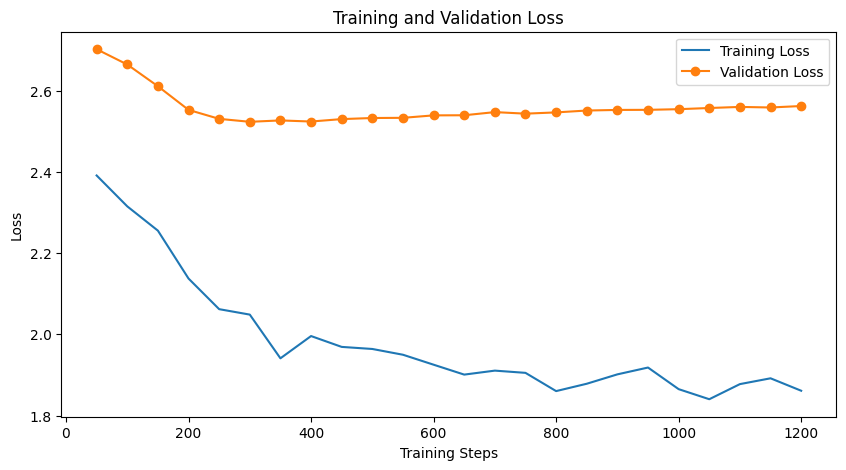

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: OSZE-Generalsekretär Zannier (Archiv) © picture-alliance/dpa/AP Photo/François Lenoir
télécharger le texte en français »
The head of Germany's spy agency, Hans-Georg Maaßen, has called for an end to the use of
Sample 0:
German input: OSZE-Generalsekretär Zannier (Archiv) © picture-alliance/dpa
Generated translation (validated): Translate the following German text into French: OSZE-Generalsekretär Zannier (Archiv) © picture-alliance/dpa/AP Photo/François Lenoir
télécharger le texte en français »
The head of Germany's spy agency, Hans-Georg Maaßen, has called for an end to the use of
Reference translation: Le secrétaire général de l’OSCE M. Zannier (Archives) © picture-alliance/dpa
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 1:
German input: Damit wird an den Aktionsplan vom 2003 angeknüpft.
Generated translation (validated): C'est que le plan d'action de 2003 est annulé. C'est que le plan d'action de 2003 est annulé. C'est que le plan d'action de 2003 est annulé
Reference translation: Ce nouveau plan s'inscrit dans la continuation du plan d'action de 2003.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 2:
German input: Nach dem Einmarsch der Sowjetischen Truppen 1979 wurde der Arg-Komplex  beschädigt und verfiel zunehmend.
Generated translation (validated): Lors de l'entrée des troupes soviétiques en 1979, le complexe d'argus a été blessé et déterminé. Lors de l'entrée des troup
Reference translation: Après l’invasion des troupes soviétiques en 1979, le complexe de l’Arg fut endommagé et tomba en ruines.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: "Es wäre unverantwortlich, die vielleicht letzten Chancen zur Entschärfung des Konfliks auszulassen."
Translation: It would have been foolish to miss the last chances to resolve the conflict.
The translation contains an error pertaining to:
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(
Sample 3:
German input: "Es wäre unverantwortlich, die vielleicht letzten Chancen zur Entschärfung des Konfliks auszulassen."
Generated translation (validated): Translate the following German text into French: "Es wäre unverantwortlich, die vielleicht letzten Chancen zur Entschärfung des Konfliks auszulassen."
Translation: It would have been foolish to miss the last chances to resolve the conflict.
The translation contains an error pertaining to:
Options:
(A) Modifiers or Adjectives
(B) Numerical Values
(
Reference translation: « Il serait irresponsable d’

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 4:
German input: Das Auswärtige Amt bietet in Kooperation mit dem Goethe-Institut ein umfangreiches, themenorientiertes Sprachkursprogramm speziell für höhere EU-Bedienstete und Ministerialbeamte aus EU-Partnerländern und weiteren europäischen Nachbarländern an, um Deutsch als Arbeits- und Verhandlungssprache in der EU zu stärken.
Generated translation (validated): Le Ministère des Affaires étrangères coopérate avec l'Institut de la Poésie de Goethe pour offrir une cours spécialisé dans le français
Reference translation: En coopération avec le Goethe-Institut, le ministère fédéral des Affaires étrangères propose un vaste programme de cours de langue thématiques à destination des hauts fonctionnaires de l’UE et des pays partenaires membres ou non de l’UE pour renforcer le poids de l’allemand comme langue de travail et de négociation dans l’UE.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 5:
German input: Auf die Anerkennung des Westwerks und der Civitas Corvey als Weltkulturerbe dürfe heute ganz Deutschland stolz sein - ganz besonders aber Ostwestfalen.
Generated translation (validated): Lorsque l'apparition de la ville de Westphalie et de la cité de Corvey comme culture urbaine du monde, c'est que tous les pays de l'Ouest s
Reference translation: Il a conclu en déclarant qu’aujourd’hui, toute l’Allemagne avait raison d’être fière de la reconnaissance du massif occidental et de la « Civitas Corvey » comme patrimoine culturel mondial, mais en particulier la Westphalie de l’Est.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Tuvalu is a small island nation in the Pacific Ocean. It has a population of about 11,000 people and is known for its beautiful beaches and coral reefs. Tuvalu is also one of the most vulnerable countries to climate change, as rising sea levels
Sample 6:
German input: Tuvalu
Generated translation (validated): Translate the following German text into French: Tuvalu is a small island nation in the Pacific Ocean. It has a population of about 11,000 people and is known for its beautiful beaches and coral reefs. Tuvalu is also one of the most vulnerable countries to climate change, as rising sea levels
Reference translation: Tuvalu
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 7:
German input: Es sei deshalb notwendig, jede Chance zu nutzen, um eine Deeskalation herbeizuführen, so Steinmeier.
Generated translation (validated): Il est important d'utiliser tout le pouvoir que nous possédons pour améliorer la situation. Il est important de utiliser tout le pouvoir que nous posséd
Reference translation: D’où la nécessité de saisir toute chance de désescalade qui s’offre.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 8:
German input: Merkel und Hollande bekräftigten in ihrer gemeinsamen Pressekonferenz am Dienstagnachmittag, gerade die Verhandlungen mit Iran seien beispielhaft für die enge deutsch-französische Zusammenarbeit - ebenso wie die Beratungen zur Ukraine-Krise im sogenannten Normandie-Format zwischen Frankreich, Deutschland, Russland und der Ukraine.
Generated translation (validated): Merkel et Hollande réussissent dans leurs conférences publiques mondiales à l'occasion de leur conférence conjointe avec l'Iran, où les résultats
Reference translation: Dans leur conférence de presse conjointe de mardi après-midi, Mme Merkel et M. Hollande ont affirmé que les négociations avec l’Iran illustraient justement l’intensité de la coopération franco-allemande, tout comme les consultations sur la crise ukrainienne menées en « format Normandie » entre la France, l’Allemagne, la Russie et l’Ukraine.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 9:
German input: Wir müssen auf diese Tragödie immer wieder hinweisen und alles tun, um diese Gruppen zu schützen.
Generated translation (validated): Nous devons continuer à l'histoire de cette tragédie jusqu'à ce que nous puissions protéger tout ensemble. Nous devons continuer à l'histoire de
Reference translation: Nous devons attirer sans cesse l’attention sur cette tragédie et tout faire pour protéger ces groupes.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 10:
German input: Fahrerlaubnis
Generated translation (validated): Règle de conduire, je vais retourner à travers la rue.
Reference translation: Permis de conduire
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 11:
German input: Südafrika
Generated translation (validated): La Suisse est l'un des pays les plus grandes du monde. La Suisse est l'un des pays les plus grandes du
Reference translation: Afrique du Sud
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: 01.05.2004: Beitritte von Estland, Lettland, Litauen, Malta, Polen, Slowenien, Slowakei, Tschechische Republik, Ungarn, Zypern, Sibérie, Allemagne, Belgique, Suisse, Italie, Espagne, Portugal, Rumania, Czecho-Slovářská republika, Vojvodina,
Sample 12:
German input: 01.05.2004: Beitritte von Estland, Lettland, Litauen, Malta, Polen, Slowenien, Slowakei, Tschechische Republik, Ungarn, Zypern
Generated translation (validated): Translate the following German text into French: 01.05.2004: Beitritte von Estland, Lettland, Litauen, Malta, Polen, Slowenien, Slowakei, Tschechische Republik, Ungarn, Zypern, Sibérie, Allemagne, Belgique, Suisse, Italie, Espagne, Portugal, Rumania, Czecho-Slovářská republika, Vojvodina,
Reference translation: 1er mai 2004 : adhésion de Chypre, de l’Estonie, de la Hongrie, de la Lettonie, de la Lituanie, de Malte, de la Pologne, d

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 13:
German input: Außenminister Steinmeier ist am 14.01. mit NATO-Generalsekretär Stoltenberg zusammengekommen.
Generated translation (validated): Le ministre de l'extérieur Steinmeier est le 14 janvier avec le secrétaire général de la NATO Stoltenberg. Le ministre de l'extérieur
Reference translation: Frank-Walter Steinmeier a rencontré le secrétaire général de l’OTAN, Jens Stoltenberg, le 14 janvier.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 14:
German input: WDR-Europaforum:
Generated translation (validated): Le Forum Europeen de WDR est un problème majeur pour l'avenir
Reference translation: Forum européen de la WDR :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 15:
German input: Aber den Weg zu einer Lösung werden wir nicht ohne Griechenland finden können.
Generated translation (validated): Il n'y a rien que la Grèce pour trouver une solution. Il n'y a rien que la Grèce pour trouver une solution. Il n'y a rien que la Grè
Reference translation: Il n’en reste pas moins que nous ne parviendrons pas à trouver une solution sans la Grèce.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 16:
German input: Betreuung von Binnenvertriebenen durch den Arbeiter-Samariter-Bund in Kiew © Arbeiter-Samariter-Bund
Generated translation (validated): / Fédération Internationale des Samaritains du Travail, L'Union Internationale des Samaritaines du Travail, ist eine internationale Vereinigung
Reference translation: Les déplacés internes accueillent par l’ASB à Kiev © Arbeiter-Samariter-Bund
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 17:
German input: "Ich würde mir wünschen, dass Iran seinen Einfluss nutzt, um die syrische Regierung an den Verhandlungstisch für den Einstieg in einen politischen Übergangsprozess zu bringen.
Generated translation (validated): Je voudrais que l'Iran avait un impact significatif sur la région syrienne pour améliorer le processus de transition politique."
## INPUT

##OUTPUT
Je
Reference translation: « Je souhaiterais que l’Iran use de son influence pour amener le gouvernement syrien à la table des négociations afin d’entrer dans un processus de transition politique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 18:
German input: Damit ist eine hohe Kontinuität bei der Behandlung von Menschenrechtsfragen in den Vereinten Nationen gesichert.
Generated translation (validated): Il y a une grande continuité entre la prise en compte des questions de droits de l'homme dans les nations unies.
Reference translation: Les Nations Unies peuvent ainsi garantir une grande continuité dans le traitement des questions relatives aux droits de l’homme.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 19:
German input: Die Aktivisten aus Subsahara-Afrika setzen sich für die Rechte der Lesben, Schwulen, Bisexuellen, Transsexuellen und Intersexuellen in ihren Heimatländern ein.
Generated translation (validated): Les activistes de l'Afrique subsaharienne ont déclaré leur demande pour la protection des droits des hommes et des femmes trans, bisexuelles, transsexuelles et
Reference translation: Ces militants venus d’Afrique subsaharienne défendent les droits des lesbiennes, gays, bisexuels, transgenres et intersexués dans leur pays.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 20:
German input: Westbalkankonferenz für mehr Regional-Kooperation
Generated translation (validated): Conférence transatlantique pour plus de coopération régionale. Conférence transatlantique pour plus de coopération régionale. La conférence transatlant
Reference translation: La conférence sur les Balkans occidentaux favorable au renforcement de la coopération régionale
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 21:
German input: Auch wenn die Verhandlungen in den kommenden Tagen sicherlich schwierig bleiben: So kurz vor dem Ziel dürfe eine Lösung des Konflikts nicht aufs Spiel gesetzt werden, betonte Steinmeier erneut.
Generated translation (validated): Pourtant que les débats récentisés devraient être préservés à long terme, il était important de trouver un résultat qui n'a pas été fixé
Reference translation: Même si les négociations des prochains jours resteront certainement difficiles, il ne faut pas compromettre un règlement du conflit alors que nous sommes si près du but, a réaffirmé M. Steinmeier.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 22:
German input: Die Dauer der Beitrittsverhandlungen wird vom Reformtempo und den Annäherungsfortschritten des Beitrittskandidaten bestimmt und kann daher stark variieren.
Generated translation (validated): Le temps d'entretien des candidats pour la réforme est déterminé par le temps du candidat et peut-être changer de façon significative.
Reference translation: Le rythme des négociations dépend ainsi de la cadence des réformes entreprises et des progrès réalisés par le pays candidat et de son adaptation au droit de l’UE ; la durée des négociations est donc très variable.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 23:
German input: Ansonsten ist die Frage der "foreign fighters" ein Problem für die gesamte EU und macht noch einmal deutlich: Auch unsere Sicherheit erhöht sich, wenn wir dem Westbalkan eine klare Perspektive eröffnen können.
Generated translation (validated): Le problème de les étrangers militaires est un problème majeur pour l'Union européenne et même aujourd'hui ne peut pas être réduit
Reference translation: Par ailleurs, la question des combattants étrangers constitue un problème pour toute l’Union européenne et souligne une fois de plus que notre propre sécurité s’accroît si nous sommes en mesure d’offrir une claire perspective d’adhésion aux Balkans.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 24:
German input: Gemeinsames Konzept für EU-Flüchtlingsrettung
Generated translation (validated): Un concept commun pour la réussite de l'immigration européenne. Un concept commun pour la réussite de l'immigration européenne. Le concept commun pour la réussite de l'immigration
Reference translation: Concept commun européen pour le sauvetage des réfugiés
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 25:
German input: Jeder Mitgliedsstaat des Europarats ist zur Ratifikation der Konvention verpflichtet.
Generated translation (validated): Tous les membres de l'Assemblée européenne sont obligés à ratifier la convention. OUTPUT: C'est vrai que tous les membres de l'Assemb
Reference translation: Tous les États membres du Conseil de l’Europe doivent ratifier la Convention.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 26:
German input: Schwerpunkt der knapp zweiwöchigen Asien-Pazifik-Wochen ist das Thema "Smart Cities". Dazu Böhmer:
Generated translation (validated): Le thème central de la
Reference translation: Les Semaines Asie-Pacifique qui dureront presque deux semaines auront pour thème principal les « smart cities ». Mme Böhmer :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 27:
German input: Mit diesen Worten begrüßte der Beauftragte für Cyberaußenpolitik im Auswärtigen Amt, Norbert Riedel, die Teilnehmerinnen und Teilnehmer des internationalen „Cybersummit 2014“.
Generated translation (validated): Avec ces mots-clés, le ministre de l'affaires étrangères, Norbert Riedel, a apprécié la responsabilité des femmes et des hommes
Reference translation: C’est en ces termes que le délégué à la cyberpolitique internationale du ministère fédéral des Affaires étrangères, Norbert Riedel, a accueilli les participantes et participants au cybersommet international 2014.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 28:
German input: Deutschland allein hat dafür über 20 Millionen Euro zur Verfügung gestellt.
Generated translation (validated): L'Allemagne n'a jamais été sans deux millions de euros pour l'exercice. L'Allemagne n'a jamais été sans deux millions de euros pour
Reference translation: pour lequel l’Allemagne à elle seule a débloqué plus de 20 millions d’euros.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 29:
German input: Am Mittwoch (15.04.) haben die Außenminister der G7-Staaten ihr Frühjahrstreffen unter deutscher Präsidentschaft beendet.
Generated translation (validated): Le dimanche 15 août, les ministres des États-Généraux du G7 ont été présentés à Paris par le président de la République frança
Reference translation: La réunion de printemps des ministres des Affaires étrangères du G7 sous présidence allemande s’est terminée mercredi (15 avril).
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 30:
German input: Akute internationale Krisen, die die globale Ordnung in Frage stellen, sieht Steinmeier beispielsweise in der Frage des iranischen Atomprogramms, im gemeinsamen Kampf gegen den islamistischen Terrorismus und in der Bewältigung der Ukrainekrise.
Generated translation (validated): L'urgence mondiale des crises étrangères, où le régime mondial est en question, offre un exemple comme la question de l'atomique iranienne,
Reference translation: M. Steinmeier considère par exemple comme crises internationales aiguës mettant en péril l’ordre mondial, la question du programme nucléaire iranien, la lutte commune contre le terrorisme islamiste et la gestion de la crise ukrainienne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 31:
German input: Integration ist ein langfristiger Prozess, der zum Ziel hat, alle Menschen, die dauerhaft und rechtmäßig in Deutschland leben, in die Gesellschaft einzubeziehen.
Generated translation (validated): L'intégration est un processus longue où l'objectif est de que tous les gens qui vivent pendant longtemps en Allemagne et qui participent à la sociét
Reference translation: L’intégration est un processus de long terme dont l’objectif est d’intégrer dans la société tous ceux qui vivent de façon durable et régulière en Allemagne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 32:
German input: In Israel halten sich zahlreiche afrikanische Flüchtlinge und Asylsuchende auf.
Generated translation (validated): Dans Israel, il y a beaucoup de refugies africaines et d'asyls suivantes. OUTPUT: Il y a beaucoup de refugies africaines et d'as
Reference translation: De nombreux réfugiés et demandeurs d’asile originaires d’Afrique se trouvent sur le sol israélien.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 33:
German input: Beispiele dafür sind:
Generated translation (validated): Translate the following German text into French: Beispiele dafür sind:  Les exemples suivants sont en français:  Les étapes suivantes sont en français. Les résultats suivants sont en français.
Reference translation: En voici quelques exemples :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 34:
German input: Wer Fragen rund um das Thema "Arbeiten und Lernen in Deutschland" hat, kann sich direkt an das Info-Center der Zentralen Auslands - und Fachvermittlung (ZAV) der Bundesagentur für Arbeit wenden.
Generated translation (validated): Quelques questions concernant le theme "l'emploi et l'apprentissage en français de l'Allemagne ont été répondus directement à l'informations-cent
Reference translation: Pour de plus amples informations sur les questions ayant trait au travail et à la formation en Allemagne, vous pouvez vous adresser directement au centre d’information du Service central de placement (ZAV) de l’Agence fédérale pour l’emploi.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 35:
German input: Derzeit befindet sich die Mission MISCA der Afrikanischen Union (AU) im Land.
Generated translation (validated): L'âge aujourd'hui trouve le mission MISCA de l'Union africaine (AU) dans le pays. OUTPUT: Le temps présente la mission MISCA de l'
Reference translation: La Mission internationale de soutien à la Centrafrique sous conduite africaine (MISCA) de l’Union africaine (UA) est actuellement déployée dans le pays.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 36:
German input: Finnland (2)
Generated translation (validated): La France est un pays européen qui a été créé à travers
Reference translation: Finlande (2)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 37:
German input: Mit keinem Partner stimmen wir uns in außenpolitischen Fragen heute umfassender und intensiver ab als mit Frankreich.
Generated translation (validated): Si nous n'avons pas un partenaire, nous pouvons prendre les questions politiques de l'extrême-droite aujourd'hui plus spécifiqu
Reference translation: Aujourd’hui, la France est le partenaire avec lequel nous nous accordons de la manière la plus complète et la plus intense dans le domaine de la politique étrangère.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 38:
German input: Als erste Sonderberichterstatterin wurde die pakistanischen Anwältin Hina Jilani ernannt.
Generated translation (validated): Lorsque elle était le première rédactrice de l'annexe pakistanaise Hina Jilani a été nomme. Quand elle était la prem
Reference translation: L’avocate Hina Jilani (Pakistan) a été la première à exercer ces fonctions.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 39:
German input: Gemeinsam mit seinen EU-Partnern und mit anderen westlichen Staaten verfolgt Deutschland aufmerksam die Einhaltung der Menschenrechte und auch die Entwicklung der humanitären Lage in Sri Lanka.
Generated translation (validated): Par conséquent de ses partenaires européens et de ses autres pays occidentaux, l'Allemagne est assuré que la protection des droits de l'homme et le dé
Reference translation: Avec ses partenaires européens et d’autres États occidentaux, l’Allemagne observe attentivement le respect des droits de l’homme ainsi que l’évolution de la situation humanitaire de Sri Lanka.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 40:
German input: Unterstützung für Aufnahmestaaten
Generated translation (validated): Soutenir les décisions d'auteurs est un facteur clé de la société.
Reference translation: Soutien aux pays d'accueil
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 41:
German input: Das werden wir sehen.
Generated translation (validated): Nous allons voir.
Reference translation: L’avenir le dira.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 42:
German input: In Ramallah und Jerusalem stand der Nahost-Friedensprozess im Mittelpunkt seiner Unterredungen mit den politisch Verantwortlichen beider Seiten.
Generated translation (validated): Dans la ville de Ramallah et de Jerusalem, le processus de la paix d'amitié est situé à l'échelle centrale de ses rapports politiques entre les deux villes
Reference translation: À Ramallah comme à Jérusalem, le processus de paix a été au cœur de ses discussions avec les responsables politiques des deux bords.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 43:
German input: Deshalb hätte Europa "ein Interesse daran, dass dieses tunesische Beispiel nicht nur überlegt, sondern lebt und sich entwickle".
Generated translation (validated): Il était intéressant que l'Europe a un intérêt spécifique en ce qui concerne cette musique traditionnelle. Il était intéressant que l'
Reference translation: C’est pourquoi l’Europe « a intérêt à ce que cet exemple tunisien non seulement survive mais soit bien vivant et se développe ».
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 44:
German input: Steinmeier für stärkere OSZE-Rolle in Ukraine-Krise
Generated translation (validated): Le ministre Steinmeier pourrait avoir un rôle plus forte dans la crise urbaine en Ukraine.
Reference translation: Steinmeier : « Renforcer le rôle de l’OSCE dans la crise ukrainienne »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 45:
German input: Diese Sammlung von Links und Informationen soll Ihnen den Zugang dazu erleichtern.
Generated translation (validated): Cette collection de links et de informations vous aidera à l'entendre. Cette collection de links et de informations vous aide à l'entendre.
Reference translation: Notre liste de liens et d’informations vous permettra d’y accéder plus facilement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 46:
German input: Das Welterbekomitee besteht aus 21 Mitgliedern, von denen etwa ein Drittel alle zwei Jahre von der Generalversammlung der inzwischen 190 Vertragsstaaten der Welterbekonvention neu gewählt wird.
Generated translation (validated): Le Conseil du Béton est compris d'21 membres, dequelles peuvent être environ un moins de trois ans de la réunion générale inter-états
Reference translation: Le comité du patrimoine mondial se compose de 21 membres, dont un tiers environ est renouvelé tous les deux ans par l’assemblée générale des 190 États parties à la convention du patrimoine mondial.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 47:
German input: Wir wollen das nach Kräften unterstützen.
Generated translation (validated): Nous voulons protéger-nous-ils contre les choses qui pèsent. Nous avons besoin de protéger-nous-ils contre les défis que l'on
Reference translation: Nous voulons le soutenir au maximum dans l’accomplissement de cette tâche.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 48:
German input: Die Verhandlungspartner hätten zwar Fortschritte gemacht und neue Ideen auf den Tisch gebracht - diese müssten jedoch erst von Experten überprüft werden.
Generated translation (validated): Les partenaires de la réunion avaient obtenu des progrès et des nouvelles idées sur le tableau - elles étaient souvent prises en compte par les experts
Reference translation: Les partenaires de négociation ont certes progressé et mis de nouvelles idées sur la table, mais celles-ci doivent tout d’abord être examinées par les experts, a-t-il poursuivi.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 49:
German input: Während der zuvor gültige Rahmen ("Hyogo Framework for Action") sich hauptsächlich auf die Reduzierung von Katastrophen konzentriert hatte, geht das neue Rahmenwerk nun einen Schritt weiter und gibt allen Staaten und der Zivilgesellschaft ein Instrument für vorrausschauendes Risikomanagement an die Hand.
Generated translation (validated): Le système de réduction de catastrophes hygienique (Hyogo Framework for Action) a été concentré sur la réduction des catastrophes et ajouté un nouveau rô
Reference translation: Tandis que le cadre applicable jusqu’à présent (« Cadre d’action de Hyogo ») se concentrait essentiellement sur la réduction des catastrophes, le nouveau cadre fait un pas de plus en fournissant à tous les États et à la société civile un instrument de gestion prospective des risques.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 50:
German input: Lesen Sie mehr:
Generated translation (validated): Translate the following German text into French: Lesen Sie mehr:  Lisez plus:  Le livre est très intéressant. Le livre est très intéressant. Le livre est très intéressant. Le livre est
Reference translation: Pour en savoir plus :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 51:
German input: In einem gemeinsamen Auftaktstatement mit Rinkēvičs erklärte Steinmeier, die häufigen Treffen mit seinem lettischen Amtskollegen in den letzten Wochen seien nicht nur ein Zeichen für die vertrauensvolle Zusammenarbeit, sondern auch ein Signal für die großen Aufgaben, die es derzeit zu bewältigen gebe:
Generated translation (validated): Dans un acte de concertation commune avec Rinkēvičs, le ministre de la République a déclaré
Reference translation: Lors d’une déclaration inaugurale conjointe, M. Steinmeier a indiqué que ses rencontres fréquentes des dernières semaines avec son homologue letton témoignaient non seulement d’une coopération empreinte de confiance mais aussi de l’ampleur des tâches à accomplir actuellement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 52:
German input: Wer Menschenrechte stärkt, stärkt den Frieden
Generated translation (validated): Les droits de l'homme sont la source de la paix. OUTPUT: Les droits de l'homme sont la source de la paix.
Reference translation: Renforcer les droits de l’homme, c’est renforcer la paix
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 53:
German input: Deshalb sage ich:
Generated translation (validated): Je suis très heureux de vous rencontrer. Je suis très heureux de vous rencontrer.
Reference translation: C’est pourquoi je le dis :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 54:
German input: Seine Aufgabe ist es, zur weiteren Annäherung beider Gesellschaften beizutragen und gemeinsame deutsch-polnische Projekte voranzubringen.
Generated translation (validated): Ses objectifs sont d'améliorer la communication entre les deux sociétés et promouvoir des projets coopératifs en français et polonais.
Reference translation: Sa mission est de contribuer au rapprochement des deux sociétés et au développement de projets germano-polonais.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 55:
German input: Deutschland hat seitdem die G7-Präsidentschaft übernommen.
Generated translation (validated): L'Allemagne a toujours été présidente dans le G7. L'Allemagne a toujours été présidente dans le G7.
Reference translation: Depuis cette date, l’Allemagne exerce la présidence du G7.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 56:
German input: Mehr zum Treffen in Kopenhagen (1.12.). lesen Sie hier.
Generated translation (validated): Bienvenue à la réunion de Kopenhagen (1.12.). vous pouvez voir ici. Bienvenue à la réunion de Kopenhagen (1.12.).
Reference translation: Vous trouverez ici de plus amples informations sur la rencontre de Copenhague (1er décembre).
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 57:
German input: Kloster Corvey ist wie Palmyra einer der Stätten, an denen uns bewusst wird, woher wir kommen, auf welchen Schultern wir stehen, wo die entscheidenden Entwicklungsschritte der Menschheit stattgefunden haben, die Teil unserer Identität geworden sind.
Generated translation (validated): La cathédrale de Corvey est comme Palmyra d'une région, où nous avons commencé à vivre, en ce qui concerne les établissements scol
Reference translation: Tout comme Palmyre, l’abbaye de Corvey fait partie de ces sites qui nous font comprendre d’où nous venons, sur quelles épaules nous reposons, quelles ont été les étapes cruciales de l’évolution du genre humain qui font à présent partie de notre identité.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 58:
German input: Erste Reihe v.l.:
Generated translation (validated): Première série. Première série. Première série. Première série. Première série.
Reference translation: Au premier rang de g. à d. :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 59:
German input: Viel Zeit ist nicht mehr.
Generated translation (validated): Il n'y a plus de temps. Il n'y a plus de temps. Il n'y a plus de temps. Il n'y a plus de temps.
Reference translation: Le temps est compté.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 60:
German input: Welche Instrumente stehen ihr zur Verfügung und wie sind diese in Bündnisse und Partnerschaften eingebettet?
Generated translation (validated): Quel instrument est-il que l'on utilise pour la prise en charge et comment est-il considéré dans les alliances et partenariats? Quelles instruments sont-ils utilisés
Reference translation: Quels sont les instruments dont elle dispose et comment sont-ils intégrés dans les alliances et partenariats ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 61:
German input: Der Nürnberger Prozess gegen die Hauptkriegsverbrecher (November 1945 bis Oktober 1946) im Saal 600 des Nürnberger Justizpalastes © picture alliance / akg-images
Generated translation (validated): Translate the following German text into French: Der Nürnberger Prozess gegen die Hauptkriegsverbrecher (November 1945 bis Oktober 1946) im Saal 600 des Nürnberger Justizpalastes © picture alliance / akg-images.de
télécharger le texte en français → Le procès de Nuremberg entre novembre 1945 et octobre 1946 dans la salle du Palais de justice de Nure
Reference translation: Le procès de Nuremberg contre les grands criminels de guerre (novembre 1945 à octobre 1946) dans la salle 600 du palais de justice © picture alliance / akg-images
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Außenminister Frank-Walter Steinmeier vor dem Treffen der EU-Außenminister © consilium.europa.eu/de/pressemitteilungen/2019/ausführliche-bericht-von-frank-walter-steinmeier-vor-dem-treffen-der-eu-aussenministerie
Sample 62:
German input: Außenminister Frank-Walter Steinmeier vor dem Treffen der EU-Außenminister © consilium.europa.eu
Generated translation (validated): Translate the following German text into French: Außenminister Frank-Walter Steinmeier vor dem Treffen der EU-Außenminister © consilium.europa.eu/de/pressemitteilungen/2019/ausführliche-bericht-von-frank-walter-steinmeier-vor-dem-treffen-der-eu-aussenministerie
Reference translation: Frank-Walter Steinmeier peu avant la réunion des ministres européens des Affaires étrangères © consilium.europa.eu
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 63:
German input: Sprachkurse in Deutschland für EU-Bedienstete und Ministerialbeamte aus den EU-Mitgliedstaaten und weiteren Staaten (Webseite auf Deutsch und Englisch)
Generated translation (validated): Cours de langue en français pour des
Reference translation: Cours d’allemand en Allemagne pour les agents de l’UE et les fonctionnaires des États membres de l’UE et d’autres États (site internet en allemand et en français)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 64:
German input: Worauf haben wir uns also geeinigt?
Generated translation (validated): Où sommes-nous aussi précisés?
Reference translation: Voici les points sur lesquels nous nous sommes mis d’accord :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 65:
German input: Inhaber gültiger Visa der EWR-Staaten (EU-Staaten und Island, Lichtenstein, Norwegen, Schweiz) sowie Japan, Kanada und den Vereinigten Staaten von Amerika ausgestellter Visa.
Generated translation (validated): Le président de l'organisation européenne pour la sécurité des réfugiés (Organisation européenne pour la sécurité des réfugiés, Österreich, Lie
Reference translation: les titulaires d’un visa valide délivré par un État de l’Espace économique européen (États de l’UE et Islande, Liechtenstein, Norvège, Suisse), le Canada, les États-Unis d’Amérique ou le Japon.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 66:
German input: Trotz des rasanten Wandels auf dem afrikanischen Kontinent verhindern bewaffnete Konflikte, politische und ethnische Spannungen, Grenzstreitigkeiten und fragile Staatlichkeit in einigen Teilen Afrikas weiterhin sozialen, wirtschaftlichen und politischen Fortschritt.
Generated translation (validated): Le changement rapide dans le contexte africain n'a jamais réduit les conflits politiques et ethno-culturels, les frontières sociales, économiques et polit
Reference translation: Malgré les changements rapides qui s’opèrent sur le continent africain, les conflits armés ainsi que des tensions politiques et ethniques, des différends frontaliers et la fragilité des systèmes politiques continuent, dans certaines régions de l’Afrique, de faire entrave au progrès social, économique et politique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 67:
German input: Regierungsführung, Sicherheit und Entwicklung.
Generated translation (validated): Renseignement gouvernemental, sécurité et développement.
Reference translation: gouvernance, sécurité et développement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 68:
German input: Außenminister Frank-Walter Steinmeier bei der Podiumsdiskussion "Warm up: Wir diskutieren Außenpolitik in Lübeck!" © AA
Generated translation (validated): Translate the following German text into French: Außenminister Frank-Walter Steinmeier bei der Podiumsdiskussion "Warm up: Wir diskutieren Außenpolitik in Lübeck!" © AAÖ, Fotolia.com
télécharger le texte en français → Le ministre de l'extérieur Frank-Walter Steinmeier a été présent à la table
Reference translation: Le ministre fédéral des Affaires étrangères, Frank-Walter Steinmeier, lors de la table ronde « Warm Up – Nous discutons politique étrangère à Lübeck » © Ministère fédéral des Affaires étrangères
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 69:
German input: Von dort war die Unglücksmaschine am 24.03. gestartet.
Generated translation (validated): Lors de l'après-midi, le bâtiment a été couvert par une machine d'incendie. Pendant l'après-midi, le bâ
Reference translation: C’est de Barcelone qu’avait décollé l’appareil le 24 mars.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gemeinsame Pressekonferenz nach dem Trialog © photothek.net/Trutschel, CC BY-SA 3.0, https://creativecommons.org/licenses/by-sa/3.0/de/deed.en.jpg
Gemeinsame Pressekonferenz n
Sample 70:
German input: Gemeinsame Pressekonferenz nach dem Trialog © photothek.net/Trutschel
Generated translation (validated): Translate the following German text into French: Gemeinsame Pressekonferenz nach dem Trialog © photothek.net/Trutschel, CC BY-SA 3.0, https://creativecommons.org/licenses/by-sa/3.0/de/deed.en.jpg
Gemeinsame Pressekonferenz n
Reference translation: Conférence de presse conjointe après les entretiens trilatéraux © photothek.net/Trutschel
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 71:
German input: Wir sind noch lange nicht über den Berg.
Generated translation (validated): Nous sommes plus tard que jamais sur le mont. Nous sommes plus tard que jamais sur la montagne.
Reference translation: Nous sommes pourtant loin d’être au bout de nos peines.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 72:
German input: Koordinator für die transatlantische Zusammenarbeit, Auswärtiges Amt, 11013 Berlin
Generated translation (validated): Coordinateur de la coopération transatlantique, Ministère des Affaires étrangères, 11013 Berlin.
Reference translation: Koordinator für die transatlantische Zusammenarbeit, Auswärtiges Amt, 11013 Berlin
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 73:
German input: Techniken, wie zum Beispiel Java-Applets oder Active-X-Controls, die es ermöglichen, das Zugriffsverhalten der Nutzerinnen und Nutzer nachzuvollziehen, werden nicht eingesetzt.
Generated translation (validated): Techniques, comme les exemples Java-Applets ou Actives-X-Controles, qui peuvent être utilisées pour améliorer le comportement des utilisateurs, ne
Reference translation: Les techniques telles que les appliquettes (applet) Java ou les contrôles Active X, qui permettent de suivre le comportement des utilisateurs sur internet, ne sont pas utilisées.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 74:
German input: Ebenfalls anerkannt werden kann nach Prüfung auch eine 3 jährige aktuelle Berufserfahrung ohne Abschluss.
Generated translation (validated): Il est possible que lors de la préparation d'une examen, on peut avoir une expérience professionnelle récente sans fin. OUTPUT: Il est possible que lors de la
Reference translation: De même, une expérience professionnelle récente de 3 ans sans certificat pourra être reconnue après avoir été examinée.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 75:
German input: Schillernde Teilnehmerinnen und breites Themenspektrum
Generated translation (validated): Les participantes de la recherche étaient très importantes pour l'étude. Les participants de la recherche ont ét
Reference translation: Des participantes rayonnantes et un large éventail de sujets
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 76:
German input: Deutschland erhöht Hilfe für die Opfer des Syrien-Konflikts (15.01.2014)
Generated translation (validated): Translate the following German text into French: Deutschland erhöht Hilfe für die Opfer des Syrien-Konflikts (15.01.2014)  L'Allemagne offre de l'aide aux victimes de la conflit syrienne (15.01.2014)  Le pays allemand apporte de l'aide aux victimes de la conf
Reference translation: L’Allemagne augmente l’aide aux victimes du conflit syrien (15/01/2014)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 77:
German input: 1981 – 1983 Institut d’Etudes Politiques, Paris (Diplom)
Generated translation (validated): Translate the following German text into French: 1981 – 1983 Institut d’Etudes Politiques, Paris (Diplom) / École nationale d’administration, Paris (État-major) / École nationale d’administration, Strasbourg (État-major) / École nationale d’
Reference translation: 1981 – 1983 Institut d’Études Politiques, Paris (diplôme)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 78:
German input: Ich freue mich, dass es gelungen ist, die Akademie gemeinsam mit dem Freistaat Bayern und der Stadt Nürnberg auf den Weg zu bringen.
Generated translation (validated): J'apprécie beaucoup que les étudiants de l'Académie commune avec la République de Bayern et la ville de Nuremberg avaient pu trouver le chemin
Reference translation: Je me félicite qu’il ait été possible de lancer cette académie avec le concours de l’État libre de Bavière et de la ville de Nuremberg.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 79:
German input: Die Ausbildung qualifizierter ausländischer Studierender an deutschen Hochschulen ist ein vordringliches Anliegen der Bundesregierung.
Generated translation (validated): L'apprentissage qualifié des étudiants en langues étrangères à l'école supérieure nationale d'enseignement supérieur français est un
Reference translation: La formation d’étudiants étrangers qualifiés dans des établissements d’enseignement supérieur allemands est l’une des toutes premières priorités du gouvernement fédéral.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Im Blick:  Dans l'œil,  Il y a  Il y a
Sample 80:
German input: Im Blick:
Generated translation (validated): Translate the following German text into French: Im Blick:  Dans l'œil,  Il y a  Il y a
Reference translation: En focus :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 81:
German input: Der OSZE komme dabei eine sehr verantwortungsvolle Rolle zu, so Steinmeier weiter.
Generated translation (validated): L'OSZE a commencé à jouer un rôle très forte et responsable, mais Steinmeier n'a pas pu continuer. L'OSZE a commencé à jou
Reference translation: Dans ce contexte, a-t-il poursuivi, l’OSCE joue un rôle essentiel et responsable.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier und Amtskollege Linkevičius © photothek.net/Steinmeier und Amtskollege Linkevičius © photothek.net/Steinmeier und Amtskollege Linkevičius
télécharger le texte en franç
Sample 82:
German input: Steinmeier und Amtskollege Linkevičius © photothek.net
Generated translation (validated): Translate the following German text into French: Steinmeier und Amtskollege Linkevičius © photothek.net/Steinmeier und Amtskollege Linkevičius © photothek.net/Steinmeier und Amtskollege Linkevičius
télécharger le texte en franç
Reference translation: M. Steinmeier et son homologue M. Linkevičius © photothek.net
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 83:
German input: Die wachsende Bedeutung des Internets und die stetig zunehmende Zahl an Nutzern werde sich eben nicht von selbst regulieren, so der Außenminister weiter.
Generated translation (validated): La véritable importance de l'internet et le grand nombre de personnes qui utilisent-ils ne pourraient pas être régulièrement contrôlées par le ministre d'
Reference translation: il ne faut pas compter sur le fait que l’importance croissante de l’Internet et le nombre toujours grandissant d’internautes se régulent d’eux-mêmes.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 84:
German input: Auch im Zentrum des Gesprächs der Außenminister Steinmeier und Gentiloni standen vornehmlich Fragen "von großer europäischer Reichweite".
Generated translation (validated): Bien sûr dans le centre de la conversation entre les ministres Steinmeier et Gentiloni, ils présentent des questions de grande échelle de région européenne.
Reference translation: Des questions « d'une grande portée européenne » étaient également au cœur de l'entretien de MM. Steinmeier et Gentiloni.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 85:
German input: Im Weltsaal des Auswärtigen Amts kamen außerdem Vertreter der internationalen Gemeinschaft zu den Friedensverhandlungen hinzu.
Generated translation (validated): Dans le salon de l'ambassade générale, il y avait aussi des représentants de la communauté mondiale aux débats sur la paix.
Reference translation: Des représentants de la communauté internationale ont également rejoint les négociations de paix dans la Weltsaal du ministère fédéral des Affaires étrangères.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 86:
German input: Syrischer Oppositionsführer zu Gespräch bei Steinmeier:
Generated translation (validated): L'opposition syrienne à la conversation avec Steinmeier. L'opposition syrienne à la conversation avec Steinmeier. L
Reference translation: Rencontre entre M. Steinmeier et le chef de l’opposition syrienne :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 87:
German input: Der Druck der Klickzahlen - ein Wettbewerbsnachteil für die Außenpolitik?
Generated translation (validated): Le nombre de clicks de l'email est un facteur important pour la politique étrangère. OUTPUT: Le nombre de clicks de l'email est un facteur important pour la politique étrang
Reference translation: Le nombre de clics, un handicap concurrentiel pour la politique étrangère ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 88:
German input: Schutz von Menschenrechtsverteidigern
Generated translation (validated): L'égalité des droits de l'homme est un défi important pour la société.
Reference translation: Protection des défenseurs des droits de l’homme
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 89:
German input: Zusammenhalt in einer Solidargemeinschaft
Generated translation (validated): Il est important de s'assurer dans une communauté solidarité pour changer la société.
Reference translation: La cohésion d’une communauté solidaire
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 90:
German input: Ich hatte mir vier Schwerpunkte gesetzt: das europäische Schiff durch stürmische See zu bringen; die richtigen Antworten auf die neuen Freiheitsbewegungen in unserer südlichen und östlichen Nachbarschaft zu geben; neue strategische Partnerschaften mit den aufstrebenden Kraftzentren der Welt zu begründen.
Generated translation (validated): J'ai décidé qu'il y avait quatre points importantes que je pouvais fixer: le voyage européen dans la mer météorologique, les réponses
Reference translation: Je m’étais fixé quatre priorités : assurer la traversée du bateau européen malgré des eaux tumultueuses ; donner les bonnes réponses aux nouveaux mouvements de libération dans notre voisinage au sud et à l’est ; créer de nouveaux partenariats stratégiques avec les pôles de puissance émergents de la planète.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 91:
German input: Mitarbeiter des UNHCR kümmern sich um die Registrierung der Flüchtlinge © Photothek/Imo
Generated translation (validated): Translate the following German text into French: Mitarbeiter des UNHCR kümmern sich um die Registrierung der Flüchtlinge © Photothek/Imo Köhler
télécharger le texte en français → Le travailleur de l'UNHCR était prêt à répondre à la demande de registration des enfants
Reference translation: Le personnel du HCR s'occupe de l'enregistrement des réfugiés © Photothek/Imo
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 92:
German input: Das Komitee der Ministerbeauftragten befasste sich im Jahr 2013 in einer thematischen Debatte mit der Rolle der Menschenrechtsverteidiger und der Interaktion des Europarats mit der Zivilgesellschaft.
Generated translation (validated): Le Comité des ministres de gouvernement prévoit l'année 2013 dans une débat thématique sur le rôle des defenders des droits de l'homme et l'interaction
Reference translation: Le Comité des Délégués des Ministres s’est consacré en 2013 à un débat thématique sur le rôle des défenseurs des droits de l’homme et l’interaction du Conseil de l’Europe avec la société civile.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 93:
German input: Leitlinien der EU zum Thema Kinder und bewaffnete Konflikte
Generated translation (validated): Législations de l'Union européenne contribuent à réduire les conflits entre les enfants. Les lois de l'UE contribuent à réduire
Reference translation: Orientations de l’UE sur les enfants face aux conflits armés
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 94:
German input: Wir hoffen jetzt, dass sich Iran an die Verabredung der gestern vereinbarten Eckpunkte hält.
Generated translation (validated): Nous pouvons-nous venir maintenant que c'était le jour où les éléments de notre plan annoncés avaient été retrouvés.
Reference translation: Nous espérons maintenant que l’Iran respectera les paramètres sur lesquels nous nous sommes accordés hier.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 95:
German input: An diesem Dienstag, dem zweiten Tag des NATO-Außenministerrats, steht die Vorbereitung des NATO-Gipfels im Herbst 2014 auf der Tagesordnung.
Generated translation (validated): Le dimanche prochain, le dernier jour des ministres de l'Alliance Nord-Américaine, se trouve la préparation du nouveau point de vue de l'Alliance
Reference translation: Le deuxième jour de réunion des ministres des Affaires étrangères de l’OTAN, sera entre autres consacré à la préparation du sommet de l’OTAN à l’automne 2014.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 96:
German input: Steinmeier im Gespräch mit Stipendiaten © Photothek / Trutschel
Generated translation (validated): Translate the following German text into French: Steinmeier im Gespräch mit Stipendiaten © Photothek / Trutschel
télécharger le texte en français → Le texte en français est également disponible à l'adresse de cet article. → Le texte en français
Reference translation: M. Steinmeier en train de discuter avec des jeunes boursiers © Photothek / Trutschel
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 97:
German input: Der Gesetzestext selbst sowie statistische Angaben zur ausländischen Bevölkerung in Deutschland finden sich auf der Internetseite der Beauftragten der Bundesregierung für Migration, Flüchtlinge und Integration.
Generated translation (validated): L'article de loi selon elle-même et des données statistiques sur l'immigration à l'étranger dans la République allemande trouvent-elles sur le site
Reference translation: Vous trouverez le texte de la loi et des statistiques sur la population étrangère en Allemagne sur le site du délégué du Gouvernement fédéral à la migration, aux réfugiés et à l’intégration.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 98:
German input: Zugleich schafft die AKBP weltweit Vertrauen in Deutschland - unsere Gesellschaft, Wirtschaft und Politik gewinnen wichtige und verlässliche Partner.
Generated translation (validated): C'est évidemment que l'AKBP entrepris la confiance mondiale en Allemagne - notre société, notre économie et notre politique obtenaient
Reference translation: D’autre part, la politique culturelle et éducative à l’étranger instaure dans le monde entier la confiance dans l’Allemagne, ce qui fait de notre société, de notre économie et de notre politique des partenaires importants et fiables.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 99:
German input: Die Sonderbeauftragte für Kinder in bewaffneten Konflikten
Generated translation (validated): Le commissaire de sécurité pour les enfants dans des conflits étrangers est un problème essentiel.
Reference translation: La Représentante spéciale du Secrétaire général pour les enfants et les conflits armés
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 100:
German input: "Als Vorsitzende des Komitees werde ich mich insbesondere für das nachhaltige Management von Welterbestätten und die Erhaltung von gefährdeten Monumenten einsetzen.
Generated translation (validated): Lorsque j'étais président du conseil, je serais particulièrement intéressé par la gestion durable des sites de bien-être et la protection des monuments en danger.
Reference translation: « Je m’engagerai tout particulièrement, en tant que présidente du comité, pour la gestion durable des biens inscrits au patrimoine mondial et pour la préservation des monuments en péril.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 101:
German input: Corvey gehörte zu den einflussreichsten Klöstern des Frankenreiches:
Generated translation (validated): Le Louvre, le Musée d'Orsay, et le Château de Versailles éta
Reference translation: Sous l’Empire franc, Corvey comptait parmi les monastères les plus influents :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 102:
German input: Die Proteste in Kiew dauern an © dpa/picture alliance
Generated translation (validated): Translation: Le protestage à Kiew commence à demain.
Reference translation: Les protestations se poursuivent à Kiev
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 103:
German input: Gleichzeitig soll die Mandatsobergrenze von 180 auf bis zu 250 Soldaten ansteigen - das bedeutet, dass in Zukunft mehr deutsche Ausbilder nach Mali geschickt werden können.
Generated translation (validated): Il faut que le mandat de la montagne de 180 à 250 soldats s'arrête pour entraîner plus de décideurs méditerranéens à Bamako. OUTPUT: Il est
Reference translation: Le nombre de militaires autorisé par le mandat doit parallèlement passer de 180 à 250, ce qui signifie que davantage d’instructeurs allemands peuvent être envoyés à l’avenir au Mali.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 104:
German input: Sommercamp für Kinder mit Down-Syndrom im Gazastreifen (Archivbild) © picture alliance / Photoshot
Generated translation (validated): Translate the following German text into French: Sommercamp für Kinder mit Down-Syndrom im Gazastreifen (Archivbild) © picture alliance / Photoshot.de
télécharger le texte en français → télécharger le texte en français → Télécharger le texte en français → Télécharger
Reference translation: Camp d’été dans la bande de Gaza pour les enfants atteints de trisomie 21 (image d’archives)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 105:
German input: Am Montag stehen Treffen unter anderem mit Staatspräsident Nasarbajew wie auch mit Vertretern der kasachischen Zivilgesellschaft auf dem Reiseplan.
Generated translation (validated): L'événement du dimanche consiste d'obtenir des rencontres avec le président de la République Nasarbaque et autres membres de la société civile
Reference translation: Des entretiens sont prévus lundi avec le président, M. Nazarbaïev, ainsi qu’avec des représentants de la société civile kazakhe.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Venezuela is a country located in South America. It is known for its diverse landscapes, including the Amazon rainforest, the Andes mountains, and the Orinoco river. The country has a rich cultural heritage, with influences from indigenous tribes, Spanish colonization
Sample 106:
German input: Venezuela
Generated translation (validated): Translate the following German text into French: Venezuela is a country located in South America. It is known for its diverse landscapes, including the Amazon rainforest, the Andes mountains, and the Orinoco river. The country has a rich cultural heritage, with influences from indigenous tribes, Spanish colonization
Reference translation: Venezuela
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 107:
German input: Die Welt ist aus den Fugen geraten - auch im übertragenen Sinne, denn sie ist nicht mehr so „verfugt“, wie unsere Denkmuster das gewohnt waren.
Generated translation (validated): La Terre est remplie de fleurs qui ont été créées par les vents, même si elles n'ont jamais été encore retrouvées comme nous
Reference translation: Le monde est en désordre – au sens figuré également, car l’« ordre » tel que nous le connaissions et le concevions n’existe plus.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 108:
German input: Ein wichtiger Schwerpunkt ihrer Arbeit ist ihr Engagement für die regionale und grenzüberschreitende Zusammenarbeit.
Generated translation (validated): Un important point de vue de leur travail est l'engagement pour le développement régional et la coopération à travers les frontières.
Reference translation: La coopération régionale et transfrontalière constitue l’une de leurs missions prioritaires.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 109:
German input: Um einen intensiven Austausch zwischen Zivilgesellschaft, Politik und Wirtschaft über globale Fragen der Digitalisierung.
Generated translation (validated): Un échange intensif entre la société civile, la politique et l'économie mondiale sur des questions de digitalisation.
Reference translation: à savoir un échange intensif entre société civile et milieux politiques et économiques sur les enjeux mondiaux du numérique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 110:
German input: Rede von Außenminister Steinmeier zum Thema Mediation bei der OSZE (02.07.2015)
Generated translation (validated): Résolution du ministre de l'é
Reference translation: Discours du ministre fédéral des Affaires étrangères Frank-Walter Steinmeier sur la médiation de l’OSCE (02.07.2015)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 111:
German input: In den vergangenen zehn Jahren ist das Bruttoinlandsprodukt des Kontinents um 30 Prozent gewachsen.
Generated translation (validated): Dans les dernières de cinq ans, le produit de l'île du Sud a été produit environ 30 % de la production continentale. Dans les dernières
Reference translation: Au cours des dix dernières années, le produit intérieur brut du continent a augmenté de 30 %.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 112:
German input: c) Für nationale Visa gilt für Minderjährige der halbe Gebührensatz, also 30,-- EUR.
Generated translation (validated): Le visa national est obligatoire pour les journées de plusieurs années. La visa national est obligatoire pour les journées de plusieurs années. Le visa national est oblig
Reference translation: c) Pour les visas nationaux, le montant des droits perçus pour les mineurs est réduit de moitié et fixé à 30 euros.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 113:
German input: Deutschland ist bereit, seine Unterstützung für den Übergangsprozess in Libyen zu verstärken.
Generated translation (validated): L'Allemagne est prête pour soutenir le processus d'établissement de la transition économique et sociale en Algérie.
Reference translation: L’Allemagne est prête à accroître son soutien au processus de transition en Libye.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 114:
German input: Der Beitrag des "African Union Border Programme" zu Frieden und Sicherheit auf dem afrikanischen Kontinent werden alljährlich mit dem African Border Day gewürdigt - in diesem Jahr fanden die Feierlichkeiten in Burkina Faso statt.
Generated translation (validated): L'article du Programme de la Union Africaine pour la paix et la sécurité sur les frontières africaines est considéré comme un élément essentiel pour la paix et
Reference translation: La Journée africaine des frontières, dont les festivités ont eu lieu cette année au Burkina Faso, est l’occasion de rendre hommage tous les ans à la contribution du Programme frontière de l’Union africaine à la paix et à la sécurité sur le continent africain.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 115:
German input: Zentrales Problem bleibt der Umgang mit den Waffen- und Munitionsbeständen als Hinterlassenschaft des Gaddafi-Regimes.
Generated translation (validated): Le problème central reste la confrontation avec les armes et les munitions des régimes de Gaddafi. ##OUTPUT
Le problème central reste la confrontation avec les armes et les munitions
Reference translation: Le problème essentiel réside dans le traitement des stocks d’armes et de munitions légués par le régime Kadhafi.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 116:
German input: Mogherini und El Arabi in Brüssel © Europäische Union
Generated translation (validated): → Mogherini et El-Arabi à Bruxelles. → L'Union européenne de la science, de l'enseignement et de la
Reference translation: Mme Mogherini et M. El-Arabi à Bruxelles © Union européenne
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error processing sample 117: No features in text.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 118:
German input: Umso wichtiger ist das Beispiel Tunesien.
Generated translation (validated): C'était un exemple important de Tunisie. OUTPUT: C'était un exemple important de Tunisie.
Reference translation: L’exemple de la Tunisie est donc d’autant plus important.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Fabius, Steinmeier, Mogherini, Zarif und Hammond in Brüssel (v.l.n.r.)  Fabien, Steinmeier, Mogherini, Zarif et Macron dans Bruxelles (v.l.n.r.)  Le père Fabien, le président Steinmeier, le ministre Mogher
Sample 119:
German input: Fabius, Steinmeier, Mogherini, Zarif und Hammond in Brüssel (v.l.n.r.)
Generated translation (validated): Translate the following German text into French: Fabius, Steinmeier, Mogherini, Zarif und Hammond in Brüssel (v.l.n.r.)  Fabien, Steinmeier, Mogherini, Zarif et Macron dans Bruxelles (v.l.n.r.)  Le père Fabien, le président Steinmeier, le ministre Mogher
Reference translation: MM. Fabius et Steinmeier, Mme Mogherini, MM. Zarif et Hammond à Bruxelles (de gauche à droite)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 120:
German input: Auf europäischer Ebene findet die Resolution 1325 im Rahmen der Europäischen Sicherheits- und Verteidigungspolitik Anwendung.
Generated translation (validated): Dans le domaine de la sécurité et de la défense européenne, on trouve le résolution 1325 dans le cadre de la politique européenne de sécurité
Reference translation: Au niveau européen, la résolution 1325 est appliquée dans le cadre de la politique européenne de sécurité et de défense.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 121:
German input: "Einen Unterschied machen in einer oft unruhigen Welt"
Generated translation (validated): Translate the following German text into French: "Einen Unterschied machen in einer oft unruhigen Welt"  "Une différence crée dans un monde où il y a toujours des problèmes."
Reference translation: « Contribuer à faire face dans un monde souvent agité »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 122:
German input: Sie engagieren sich heute in der Gemeinschaft der Überlebenden Ihres Lagers und setzen sich für die Interessen der ehemaligen Häftlinge ein.
Generated translation (validated): Elle partage aujourd'hui dans la communauté des survivants de sa maison et est en train de répondre aux intérêts des anciens prisonniers. Elle
Reference translation: Vous vous mobilisez aujourd’hui au sein de l’association ou de l’amicale des survivants de votre camp et vous y défendez les intérêts des anciens déportés.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 123:
German input: Der von der UN-Friedensmission MONUSCO betriebene, politisch unabhängige Radiosender "Radio Okapi" begleitet seit 2002 den Friedensprozess im Land.
Generated translation (validated): L'organisation de la United Nations de la paix MONUSCO a mis en place une radiophonie politiquement indépendante depuis 2002 dans le pays.
Reference translation: la radio indépendante Radio Okapi, gérée par la mission de l’ONU MONUSCO, accompagne depuis 2002 le processus de paix dans le pays.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 124:
German input: Joint Declaration by the Foreign Ministers of Ukraine, Russia, France and Germany
Generated translation (validated): Le ministre de l'État français, le ministre de l'État russe, le ministre de l'État Ukrainien et le
Reference translation: Déclaration commune des ministres des Affaires étrangères d’Ukraine, de Russie, de France et d’Allemagne (en anglais)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 125:
German input: Mitverantwortlich dafür sind die Auswirkungen des Klimawandels.
Generated translation (validated): Il est important de comprendre les résultats du changement climatique. Il est important de comprendre les résultats du changement climatique. Il est important de comprendre les r
Reference translation: Les répercussions du changement climatique en sont en partie responsables.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 126:
German input: Gemeinsame Pressekonferenz der beiden Außenminister © Photothek/Köhler
Generated translation (validated): Translate the following German text into French: Gemeinsame Pressekonferenz der beiden Außenminister © Photothek/Köhler, CC BY-SA 3.0 Deutschland und Suisse sont unis dans une conférence de presse transatlantique présentée par les ministres de l'Europe et de l'Afrique
Reference translation: Conférence de presse commune © Photothek/Köhler
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 127:
German input: Die Idee zur Errichtung der Internationalen Akademie Nürnberger Prinzipien entstand aus dem historischen Erbe der Nürnberger Kriegsverbrecherprozesse nach dem 2. Weltkrieg.
Generated translation (validated): L'idée de l'établissement de l'Académie internationale des principes de Nürnberg était originaire dans l'histoire des événements de guer
Reference translation: L’idée de fonder l’Académie internationale des principes de Nuremberg est issue de l’héritage historique des procès pour crimes de guerre de Nuremberg à la fin de la Seconde Guerre mondiale.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 128:
German input: Folgeresolutionen
Generated translation (validated): Les résolutions de fin d'été sont un problème essentiel pour l'avenir.
Reference translation: Résolutions suivantes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 129:
German input: Ich hoffe, dass das nun auch ein lauter Weckruf ist.
Generated translation (validated): J'espère que ce soir-là, il y a un peu de rythme qui me rappelle la beauté de la vie.
Reference translation: J’espère qu’elle fera aussi l’effet d’un puissant signal d’alarme.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: African Border Day 2015 is an important event that aims to raise awareness about the challenges faced by border communities in Africa. It provides a platform for dialogue, cooperation, and the exchange of best practices among governments, civil society organizations, and international partners. The day serves as a
Sample 130:
German input: African Border Day 2015
Generated translation (validated): Translate the following German text into French: African Border Day 2015 is an important event that aims to raise awareness about the challenges faced by border communities in Africa. It provides a platform for dialogue, cooperation, and the exchange of best practices among governments, civil society organizations, and international partners. The day serves as a
Reference translation: Journée africaine des frontières 2015
------------------------------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 131:
German input: Lübeck G7 Warm Up – Wir diskutieren Außenpolitik
Generated translation (validated): L'événement de Lübeck G7 est un moment de réflexion sur les politiques étrangè
Reference translation: « Warm Up – Nous discutons politique étrangère à Lübeck »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 132:
German input: Das Auswärtige Amt finanzierte in diesem Zusammenhang im November 2013 eine Schulung von Richtern und Staatsanwälten sowie Mitarbeitern der Projektpartner in Manama, Bahrain durch deutsche Experten.
Generated translation (validated): Le Ministère des Affaires étrangères financiait en novembre 2013 un projet de développement à Manama, Bahrain, avec l'aide de professeurs et memb
Reference translation: Dans ce contexte, le ministère fédéral des Affaires étrangères a financé en novembre 2013 une formation dispensée par des spécialistes allemands à l’intention de magistrats ainsi que de collaborateurs des partenaires de projet à Manama.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 133:
German input: Zur Pressemitteilung der Gesellschaft für Konsumforschung
Generated translation (validated): Le communiqué de presse du société de recherche sur le consommation. Le communiqué de presse du société de recherche sur le consommation. Le commun
Reference translation: Communiqué de presse de la société GfK
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 134:
German input: So sind etwa die Flüsse, vor allem die beiden großen Ströme Amu Darja und Syr Darja, Grundlage für Trinkwasserversorgung, Bewässerung in der Landwirtschaft und Stromerzeugung zugleich.
Generated translation (validated): C'est comme les rivières, en particulier les deux grandes rivières Amu Darja et Syr Darja, qui sont la base pour l'éau potable,
Reference translation: Les fleuves, comme les grands fleuves Amu Darya et Syr Darya, constituent la base de l’approvisionnement en eau potable, de l’irrigation agricole et de la production d’électricité.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 135:
German input: Vor diesem Hintergrund rufen wir Regierung und Sicherheitsbehörden ebenso wie Demonstranten zur Mäßigung und dazu auf, die Streitigkeiten auf demokratischem Wege zu lösen.
Generated translation (validated): Dans ce contexte, nous rencontrons les gouvernements et les services de sécurité comme des démonstrants qui pourraient être utilisés pour accomplir la mise à jour
Reference translation: Sur ce fond, nous appelons le gouvernement et les autorités de sécurité ainsi que les manifestants à se modérer et à résoudre les différends de manière démocratique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 136:
German input: Äthiopien
Generated translation (validated): Àthiopie est un pays grand dans l'Afrique du Sud. OUTPUT: Àthiopie est un pays grand dans l
Reference translation: Éthiopie
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 137:
German input: Der Umfang des iranischen Atomprogramms soll auf etwa zehn Jahre beschränkt werden.
Generated translation (validated): Le nombre de jours que l'application atomique iranienne doit être réalisée sera également à cinq dernières années.
Reference translation: L’ampleur du programme nucléaire iranien doit être limitée à une dizaine d’années.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 138:
German input: Gibt es überhaupt Kräfte in Deutschland, die das aufweichen wollen?
Generated translation (validated): Il y a toujours des forces majeures dans l'Allemagne, où ils veulent élargir. Il y a toujours des forces majeures dans l'Allemagne
Reference translation: Y a-t-il véritablement des courants qui veulent remettre ce principe en cause en Allemagne ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 139:
German input: Reise von Außenminister Steinmeier nach Saudi-Arabien
Generated translation (validated): Voyage d'ambassadeur Steinmeier à Algérie.
Reference translation: Déplacement de M. Steinmeier en Arabie saoudite
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 140:
German input: Hier müssen wir gemeinsam ansetzen.
Generated translation (validated): Il faut que nous sommes ensemble.
Reference translation: Nous devons développer une approche commune.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 141:
German input: Außenminister Steinmeier begrüßt "Berliner Erklärung" der sudanesischen Opposition zum "Nationalen Dialog"
Generated translation (validated): Le ministre de l'extrême-occidental Steinmeier reçoit le résultat de la souveraineté sud-ouest de l'opposition démocratique
Reference translation: Frank-Walter Steinmeier salue la « déclaration de Berlin » de l’opposition soudanaise sur le « dialogue national »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 142:
German input: Geschichte entwickelt sich nicht linear, sondern in Widersprüchen und Windungen.
Generated translation (validated): L'histoire ne doit pas être développée linéairement, mais en écoutants et dans les rêves. OUTPUT: L'histoire ne doit pas être
Reference translation: L’histoire n’est pas linéaire, elle est pleine de contradictions et de méandres.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 143:
German input: Der Umsatz wird auf mindestens 10 Milliarden US-Dollar pro Jahr geschätzt.
Generated translation (validated): L'impôt est considéré comme un pourcentage de plus de 10 milliards d'euros par année. L'impôt est considéré comme un pourcentage de
Reference translation: Son chiffre d’affaires estimé représente au moins 10 milliards de dollars par an.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 144:
German input: Das Jahr 2014 steht auch für das hundertjährige Gedenken an den Ausbruch des Ersten Weltkrieges.
Generated translation (validated): L'année 2014 est également pour l'hundredième anniversaire de la première guerre mondiale.
Reference translation: L’année 2014 marque aussi le centenaire du début de la Première Guerre mondiale.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 145:
German input: Bundeskanzlerin Merkel hat mehr als 50 Frauen aus G7-Staaten und Entwicklungsländern zum zweitägigen Dialog ins Bundeskanzleramt eingeladen.
Generated translation (validated): Le présidente de la République française Merkel a déjà plus de 50 femmes des États-Unis et des pays de développement qui ont été accueillies d
Reference translation: Sur l’invitation d’Angela Merkel, plus de cinquante femmes originaires des États du G7 et de pays en voie de développement se sont réunies pour deux journées de dialogue à la chancellerie fédérale.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 146:
German input: „Für mich ist die Reise nach Deutschland ein Abenteuer.
Generated translation (validated): Pour moi, le voyage en Allemagne est un voyage d'adventure.”
## INPUT

##OUTPUT
"Pour moi, le voyage en Allemagne est un voyage d'ad
Reference translation: « Ce séjour en Allemagne est pour moi une aventure.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 147:
German input: "Germany - Looking Beyond its Borders" - Rede von Außenminister Steinmeier bei Carnegie Europe (englisch)
Generated translation (validated): Translate the following German text into French: "Germany - Looking Beyond its Borders" - Rede von Außenminister Steinmeier bei Carnegie Europe (englisch)  L'Allemagne à travers ses frontières - Résultat de l'ambassadeur Steinmeier à Carnegie Europe (français)  L'Allemagne a travers ses frontiè
Reference translation: « Germany – Looking Beyond its Borders » – Discours du ministre fédéral des Affaires étrangères, M. Steinmeier, à Carnegie Europe (en anglais)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 148:
German input: Beunruhigt Sie der Aufstieg der Extremisten in Europa?
Generated translation (validated): Résoudrez-vous le risque de l'extrémisme en Europe?
Reference translation: Êtes-vous inquiet de la montée des extrémistes en Europe ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 149:
German input: Damit wird das bisherige Delegiertenbüro der Deutschen Wirtschaft zu einer vollwertigen Auslandshandelskammer aufgewertet.
Generated translation (validated): Lorsque les délégués de l'entreprise allemande devaient accéder à un bureau de commerce étranger très valorisé. Pendant que les délégués de l
Reference translation: La simple délégation de l’économie allemande qui existe aujourd’hui s’en trouvera transformée en une chambre de commerce et d’industrie à l’étranger à part entière.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 150:
German input: Steinmeier und Schetyna © Photothek/Imo
Generated translation (validated): → Le texte en français est également disponible. → Le texte en français est disponible
Reference translation: MM. Steinmeier et Schetyna © Photothek/Imo
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 151:
German input: Gibt es eine Aufteilung:
Generated translation (validated): Il y a un tableau: B, C, D, E, F. Il y a un tableau: B, C, D, E, F.
Reference translation: Est-ce une répartition des rôles :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 152:
German input: Recht auf Privatsphäre im digitalen Zeitalter
Generated translation (validated): La réalité de la vie privée dans le monde numérique est importante pour assurer la protection des donné
Reference translation: Droit à la vie privée à l’ère numérique
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 153:
German input: Mehr Überwachung und Kontrollen im Mittelmeer
Generated translation (validated): Plus de surveillance et de contrôle dans le même océan. plus de surveillance et de contrôle dans le même océan.
Reference translation: Croissance et contrôle accrus en Méditerranée
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 154:
German input: Die Finanzhilfe des EFSM dient zur kurzfristigen Überbrückung, bis ein Finanzhilfeprogramm des ESM mit Griechenland verhandelt ist.
Generated translation (validated): L'assistance financière de la Fonds européen de solidarité mondiale aide à la rapidité de la rupture, jusqu'à un programme de financement de la Fonds europé
Reference translation: L’aide financière du MESF vise à assurer un financement relais à court terme jusqu’à ce que le programme d’aide financière du MES ait été négocié avec la Grèce.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 155:
German input: Mit einer aktiven pro-europäischen Politik gegen die Glaubwürdigkeitskrise
Generated translation (validated): Dans une politique actuelle pro-européenne contre le crise de la gl
Reference translation: Opposer une politique vigoureusement pro-européenne à la crise de crédibilité
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 156:
German input: Was ihr im Augenblick am meisten Sorgen mache, sei, dass es sehr viel Unbekanntes gebe.
Generated translation (validated): Qu'est-ce que tu penses dans le moment où vous souviens de beaucoup de choses que nous n'avions jamais connu. Qu'est-ce que tu
Reference translation: Ce qui préoccupe actuellement le plus la chancelière, c'est la grande part d'inconnu à laquelle l'Allemagne est confrontée.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 157:
German input: Gleich zum Auftakt hatten rund 120 Jugendliche auf Einladung des Auswärtigen Amts und des Lübecker Willy-Brandt-Hauses die Gelegenheit, in lockerer Atmosphäre ihre Fragen an Außenminister Frank-Walter Steinmeier und die EU-Außenbeauftragte Federica Mogherini loszuwerden.
Generated translation (validated): Rien n'a jamais été fait comme cette expérience dans le monde entier, où les jeunes devaient avoir l'opportunité de prendre
Reference translation: en prélude à la réunion, environ 120 jeunes invités par le ministère fédéral des Affaires étrangères et la Maison Willy Brandt de Lübeck ont eu l’occasion de poser leur questions, dans une ambiance détendue, au ministre fédéral des Affaires étrangères, Frank-Walter Steinmeier, et à la Haute représentante de l’Union pour les affaires étrangères et la politique de sécurité, Federiga Mogherini.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 158:
German input: Das deutsche Duale Berufsbildungssystem trägt viel zur wirtschaftlichen Stärke Deutschlands bei.
Generated translation (validated): Le système d'apprentissage de la dualité professionnelle allemande contribue beaucoup à la puissance économique de l'Allemagne.
Reference translation: La formation professionnelle en alternance contribue pour beaucoup à la réussite économique de l’Allemagne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 159:
German input: Für deren Einsatz brauche es jedoch eine Sicherheitsgarantie der Konfliktsparteien.
Generated translation (validated): Il nécessite un contrat de sécurité pour l'application de la conflit des partis.
Reference translation: Leur envoi nécessite cependant que les parties au conflit se portent garantes de leur sécurité.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Portugal (2) is a country located in Southern Europe, bordered by Spain to the west, France to the south, and the Atlantic Ocean to the east. It has a population of over 10 million people and is known for its rich history, beautiful landscapes, and
Sample 160:
German input: Portugal (2)
Generated translation (validated): Translate the following German text into French: Portugal (2) is a country located in Southern Europe, bordered by Spain to the west, France to the south, and the Atlantic Ocean to the east. It has a population of over 10 million people and is known for its rich history, beautiful landscapes, and
Reference translation: Portugal (2)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 161:
German input: Die Projekte umfassen dabei das gesamte Spektrum des Menschenrechtsschutzes und spiegeln die aktuellen Handlungsfelder deutscher Menschenrechtspolitik wider.
Generated translation (validated): Les projets sont consacrés à l'ensemble de la réalité des droits de l'homme et reflètent les décisions actuelles en matière de politique
Reference translation: Les projets portent sur l’ensemble de la protection des droits de l’homme et reflètent tous les champs d’action actuels de la politique allemande des droits de l’homme.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: In seiner Eröffnungsrede machte Steinmeier deutlich, wie die Literatur es schaffe, die Grenzen der Politik zu überwinden:                                int     Tuple[str, str]:
Sample 162:
German input: In seiner Eröffnungsrede machte Steinmeier deutlich, wie die Literatur es schaffe, die Grenzen der Politik zu überwinden:
Generated translation (validated): Translate the following German text into French: In seiner Eröffnungsrede machte Steinmeier deutlich, wie die Literatur es schaffe, die Grenzen der Politik zu überwinden:                                int     Tuple[str, str]:
Reference translation: Dans son discours d’ouverture, M. Steinmeier a exprimé clairement comment la littérature parvenait à dépasser les limites de la politique :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 163:
German input: Vor seinem Abflug in die Ukraine sagte Steinmeier:
Generated translation (validated): Lors de son voyage dans la Ukraine, Steinmeier a commencé à parler. Lors de son voyage dans
Reference translation: Avant de prendre l’avion pour l’Ukraine, il a déclaré :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 164:
German input: Außenminister Steinmeier eröffnet Internationale Energiekonferenz im Auswärtigen Amt.
Generated translation (validated): Le ministre de l'extérieur Steinmeier a organisé un conférence internationale sur l'énergie dans le Ministère des Affaires étrangères.
Reference translation: Le chef de la diplomatie allemande, Frank-Walter Steinmeier ,ouvre au ministère fédéral des Affaires étrangères une conférence internationale sur la transition énergétique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 165:
German input: Steinmeier erhielt ein sogenanntes "Guayaberas"-Hemd, ein für die Küste Kolumbiens typisches Leinen-Hemd.
Generated translation (validated): Steinmeier a décidé d'accepter le guayaberas, un hémard typique de la côte colombienne. Steinmeier a choisi de recevoir le guayaberas
Reference translation: une chemise Guayabera en lin, typique des côtes colombiennes.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 166:
German input: Wir fokussieren auch vor dem Hintergrund schwieriger Erfahrungen bei den Beitrittsverhandlungen in den vergangenen Jahrzehnten die EU-Annäherungsprozesse sehr stark auf Fragen der Rechtsstaatlichkeit, der Demokratie, der Zusammenarbeit im Justizbereich, der Unabhängigkeit der Medien, aber auch auf die Lösung offener bilateraler Fragen.
Generated translation (validated): Nous avons également étudié des problèmes dangereux liés à l'approche de l'Union européenne
Reference translation: Compte tenu notamment des difficultés rencontrées dans le cadre des négociations d’adhésion au cours des dernières décennies, nous concentrons dans une très forte mesure les processus de rapprochement vers l’UE sur les questions relatives à l’état de droit, la démocratie, la coopération dans le domaine des affaires judiciaires, l’indépendance des médias, mais aussi sur le règlement des dossiers bilatéraux non résolus.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Mit Blick auf die Krise in der Ukraine betonten die Minister aus Deutschland und Frankreich erneut, dass "Diplomatie und Dialog" die einzige Lösung seien – dies sei ihre "gemeinsame Botschaft an Kiew und Moskau": https://www.spiegel.de/wissenschaft/politik/diplomatie-und-dialog-die-einzige-botschaft-an-kiew-und-moskau-
Sample 167:
German input: Mit Blick auf die Krise in der Ukraine betonten die Minister aus Deutschland und Frankreich erneut, dass "Diplomatie und Dialog" die einzige Lösung seien – dies sei ihre "gemeinsame Botschaft an Kiew und Moskau":
Generated translation (validated): Translate the following German text into French: Mit Blick auf die Krise in der Ukraine betonten die Minister aus Deutschland und Frankreich erneut, dass "Diplomatie und Dialog" die einzige Lösung seien – dies sei ihre "gemeinsame Botschaft an Kiew und Moskau": https:

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 168:
German input: Große Übereinstimmung bei internationalen Fragen
Generated translation (validated): L'impression grande dans les questions internationales est un problème essentiel pour l'
Reference translation: Grande concordance de vues sur les dossiers internationaux
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 169:
German input: Steinmeier beim Pressestatement in Athen © photothek/Köhler
Generated translation (validated): Translate the following German text into French: Steinmeier beim Pressestatement in Athen © photothek/Köhler, fotostock.de
télécharger le texte en français → Le texte en français est également disponible ici. → Le texte en français est
Reference translation: M. Steinmeier s’adressant à la presse à Athènes © Photothek/Köhler
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 170:
German input: Ihre Aufgabe ist es, die seeseitigen Grenzen des Libanon zu sichern und die Fähigkeiten der libanesischen Marine aufzubauen, damit das Land seine Grenzen bald auch eigenverantwortlich sichern kann.
Generated translation (validated): L'obligation de ce travail est de protéger les limites étrangères du Liban et de développer les capacités maritimes libaneses afin que la terre so
Reference translation: Leur mission est de sécuriser les frontières maritimes du Liban et de renforcer les capacités de la marine libanaise afin que le pays puisse bientôt assurer la sécurité de ses frontières de manière autonome.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 171:
German input: Weitere Informationen zum Review-Prozess auf www.review2014.de
Generated translation (validated): De plus de nouvelles informations concernant le review 2014 sont disponibles sur www.review2014.de. OUTPUT: Il y a plus de nouvelles informations concern
Reference translation: Plus d’informations sur l’examen de la politique étrangère allemande : www.review2014.de (en allemand)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 172:
German input: Aber wir konnten nicht einfach zur Tagesordnung übergehen, als Russland mit der Annexion der Krim Völkerrecht gebrochen hatte und nicht bereit war, sein Handeln zu korrigieren.
Generated translation (validated): Si nous ne pouvions pas arrêter le rythme de la vie quotidienne, comme l'Allemagne a-t-il été enchaîné par la réglement
Reference translation: Cependant, nous ne pouvions pas nous contenter de passer l’éponge lorsque la Russie a violé le droit international en annexant la Crimée et ne s’est pas montrée disposée à corriger son action.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 173:
German input: Es sei daher wichtig, die neuen außenpolitischen Rahmenbedingungen in Europa und der Welt zu analysieren und zu überlegen, wie der flexible Teil des Haushalts angemessen in diesem neuen Umfeld eingesetzt werden könne.
Generated translation (validated): Il est important que les nouvelles politiques étrangères européennes et mondiales soient analysées et développées afin d'améliorer la flexibilité
Reference translation: D’où l’importance d’analyser le nouveau contexte de la politique étrangère en Europe et dans le monde, et de réfléchir aux possibilités d’avoir recours de façon appropriée à la partie flexible du budget pour faire face à ce nouvel environnement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 174:
German input: Am Grab von Dr. Martin Luther King:
Generated translation (validated): Martin Luther King: L'égalité entre les hommes et les femmes est essentielle pour une société juste. Le moment de Dr. Martin Luther King : l'égalité entre les hommes
Reference translation: Devant la tombe de Martin Luther King :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 175:
German input: OSZE weiter stärken
Generated translation (validated): Où je pensez-vous que je pourrais vivre dans un nouvel état de vie
Reference translation: Renforcer encore l’OSCE
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 176:
German input: Mehr Informationen
Generated translation (validated): plus de données. plus de connaissances. plus de connaissances. plus de connaissances. plus de connaissances. plus de con
Reference translation: Pour de plus amples informations :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 177:
German input: Bei den Sondertreffen der Innenminister am Dienstag (22.9.) sowie der Staats- und Regierungschefs der EU-Mitgliedsstaaten am Mittwoch (23.9.) konnten wichtige Ergebnisse erzielt werden.
Generated translation (validated): Les rencontres entre les ministres de l'intérieur et les ministres des États-membres de l'Union européenne a été réalisée le vendredi
Reference translation: D’importants résultats ont été obtenus lors des réunions extraordinaires des États membres rassemblant les ministres de l’Intérieur mardi (22 septembre) et les chefs d’État et de gouvernement mercredi (23 septembre).
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 178:
German input: Die Abteilung S wurde als Ergebnis des Prozesses "Review 2014 - Außenpolitik weiter denken" im März 2015 neu geschaffen.
Generated translation (validated): L'établissement S a été décidé comme résultat de la procédure d'évaluation "Revue 2014 - Politique étrangère pensée plus faite
Reference translation: La direction générale de la prévention des crises, de la stabilisation et du relèvement post-conflit a été créée en mars 2015 à la suite du processus « Review 2014 – Un regard neuf sur la politique étrangère allemande ».
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 179:
German input: Einleitung:
Generated translation (validated): Nous vous remercions de votre intérêt pour notre entreprise et nous vous invitons à découvrir tout ce que nous
Reference translation: Einleitung:
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 180:
German input: Abrüstung weltweit unterstützen:
Generated translation (validated): Détruire le monde à tout moment.
Reference translation: Cautionner le désarmement à travers le monde :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 181:
German input: Dies geschieht unter anderem durch einen intensiveren politischen Dialog aber auch durch eine verstärkte Zusammenarbeit in den Bereichen Recht, Freiheit und Sicherheit.
Generated translation (validated): C'est que ce sont les résultats de un dialogue politique intensif mais aussi de l'établissement d'une collaboration concrète dans les domaines de la justice,
Reference translation: Un dialogue politique plus intense mais aussi une coopération renforcée dans les domaines du droit, de la liberté et de la sécurité comptent parmi les moyens d’y parvenir.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Auf der Fregatte 'Bayern' © picture-alliance/ZB/dpa
Auf der Fregatte 'Bayern' © picture-alliance/ZB/dpa
À la frégate 'Bayern' © picture-alliance/ZB/dpa
Sample 182:
German input: Auf der Fregatte 'Bayern' © picture-alliance/ZB
Generated translation (validated): Translate the following German text into French: Auf der Fregatte 'Bayern' © picture-alliance/ZB/dpa
Auf der Fregatte 'Bayern' © picture-alliance/ZB/dpa
À la frégate 'Bayern' © picture-alliance/ZB/dpa
Reference translation: À bord de la frégate Bayern © picture-alliance/ZB
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 183:
German input: Spaltung Europas verhindern
Generated translation (validated): Le développement européen réduit le futur du monde. Le développement européen réduit le futur du monde.
Reference translation: Empêcher la division de l’Europe
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 184:
German input: Steinmeier und Hammond nutzten das Forum, um in Gesprächen mit dem bosnischen Außenminister Zlatko Lagumdžija und seinen Amtskolleginnen und –Kollegen aus der Region für eine Revitalisierung des Reformprozesses in Bosnien und Herzegowina zu werben.
Generated translation (validated): Le Président de la République, Steinmeier, et le Président de l'État, Hammond, ont utilisé le Forum pour discuter avec le ministre de l'étranger Z
Reference translation: Au cours des discussions avec leur homologue bosniaque, Zlatko Lagumdžija, et les autres ministres des Affaires étrangères de la région, MM. Steinmeier et Hammond ont profité de ce forum pour s’engager en faveur d’une relance du processus de réforme en Bosnie-Herzégovine.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 185:
German input: Rede von Außenminister Steinmeier zur Eröffnung der #EuroDIG, 12.06.14 (in englischer Sprache)
Generated translation (validated): Résultat du ministre de l'étr
Reference translation: Discours d’ouverture de M. Steinmeier à #EuroDIG, le 12 juin 2014 (en allemand)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 186:
German input: Macau (6)
Generated translation (validated): Question: Is Macau
Reference translation: Macao (6)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 187:
German input: Rede von Außenminister Steinmeier bei der Einweihung des neuen Kanzleigebäudes der Deutschen Botschaft Tunis, 24. April 2014
Generated translation (validated): Résolution du ministre de l'étranger Steinmeier a été prononcée à la mise en place du nouveau château de la Chambre d'affaires de
Reference translation: Discours de M. Frank-Walter Steinmeier à l’occasion de l’inauguration de la nouvelle chancellerie de l’Ambassade d’Allemagne à Tunis, le 24 avril 2014 (en allemand)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 188:
German input: Seit einigen Tagen steht dort ein neuer Name:
Generated translation (validated): Il y a des jours où je vois la beauté. Il y a des jours où je vois la beauté. Il y a des jours où je vo
Reference translation: Depuis quelques jours, un nouveau nom y figure :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 189:
German input: Deutschland tritt mit seinen Partnern besonders in der EU und der NATO für die Stärkung bestehender internationaler Verträge sowie für deren Weiterentwicklung ein.
Generated translation (validated): L'Allemagne s'engage particulièrement avec ses partenaires européens et américains pour la mise en œuvre de nouveaux accords internationals et pour
Reference translation: C’est notamment au sein de l’UE et de l’OTAN que l’Allemagne défend, avec ses partenaires, le renforcement et le développement des conventions internationales en la matière.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 190:
German input: Übersicht:
Generated translation (validated): Le livre est très intéressant. Le livre est très intéressant. Le livre est très intéressant.
Reference translation: Tableau
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 191:
German input: Die Geschichte des Gedenkens an Ilse Stöbe soll uns eine Mahnung sein, Erinnerungen wach zu halten und sie ständig aufs Neue kritisch zu prüfen.
Generated translation (validated): L'histoire de l'obéissance d'Ilse Stöbe devrait être une mémoire spéciale pour nous, les souvenirs que nous pouvons comprendre et
Reference translation: Les circonstances de cet hommage à la mémoire d’Ilse Stöbe doivent être pour nous une exhortation à entretenir le souvenir en y portant toujours un regard critique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 192:
German input: Steinmeier betonte, dass er dies zu verhindern suche - auch im Hinblick auf die Sicherheit in und für Europa, die es nur "gemeinsam mit Russland und nicht gegen Russland" geben könne.
Generated translation (validated): Steinmeier affirme que c'était important de répondre à cette question, même si elle était souvent considérée comme un danger pour la sécurité et pour l
Reference translation: Il a insisté sur sa volonté d’empêcher un tel processus, notamment par rapport à la sécurité en Europe et pour l’Europe, qui ne peut s’accomplir « qu’avec la Russie et non contre la Russie ».
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 193:
German input: Steinmeier und Gröhe dankten der Lufthansa und dem Robert-Koch-Institut für die schnelle Umrüstung des Flugzeugs.
Generated translation (validated): Steinmeier et Gröhe mercient le Lufthansa et le Robert-Koch-Institut pour le prestation rapide de l'avion.
Reference translation: MM. Steinmeier et Gröhe ont remercié la Lufthansa et l’Institut Robert Koch d’avoir équipé l’avion aussi rapidement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 194:
German input: Auch strukturelle Veränderungen im Auswärtigen Amt kündigte der Außenminister an.
Generated translation (validated): Il y a également des changements structuraux dans l'ambassade de l'état aux États-Unis. L'ambassade de l'état aux États-Un
Reference translation: M. Steinmeier a également annoncé des changements structurels au sein du ministère.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 195:
German input: Europäische Schriftstellerkonferenz, 8.-9. Mai 2014
Generated translation (validated): Conférence européenne de la langue, 8-9 mai 2014, Bruxelles. Conférence européenne de la langue, 8-9 mai 2014, Brux
Reference translation: conférence européenne des écrivains, 8/9 mai 2014
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 196:
German input: Die Konferenz "Wasser und gutnachbarschaftliche Beziehungen in Zentralasien" am 7. und 8. September 2015 markiert den Beginn der Phase III (2015-17).
Generated translation (validated): Le conférence « L'eau et les connexions culturelles en Asie centrale » qui se déroulait le 7 et 8 septembre 2015 commencera à la phase III (2015-2017
Reference translation: La conférence sur « L’eau et les relations de bon voisinage en Asie centrale » des 7 et 8 septembre 2015 marque le début de la phase III (2015 – 2017).
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 197:
German input: Luxemburg (2)
Generated translation (validated): Luxembourg est une ville allemand-française dans le Suisse. Le Luxembourg est une ville al
Reference translation: Luxembourg (2)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 198:
German input: Deutschland beteiligt sich an internationalen Wahlbeobachtermissionen der OSZE und der EU.
Generated translation (validated): La France considère que l'Union européenne et le Conseil opérationnel de l'OSZE sont des éléments clés pour promouvoir la paix et le développement
Reference translation: L’Allemagne participe aux missions d’observation électorale internationales de l’OSCE et de l’UE.
--------------------------------------------------
Sample 199:
German input: Er freue sich, dass der von ihm und Großbritanniens Außenminister Philip Hammond angestoßene Prozess zu einer "mutigen Reformagenda" geführt habe.
Generated translation (validated): Il était très heureux que le ministre de l'étranger Philip Hammond avait commencé à préparer un projet de réforme mutuel. OUTPUT: Il ét
Reference translation: Il s’est félicité de ce que le processus qu’il avait lancé avec son homologue britannique Philip Hammond ait débouché sur un « programme de réformes courageux ».


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/7 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 1.52 seconds, 130.78 sentences/sec
Average BERTScore F1 on test set: 0.7110763788223267


In [ ]:
import gc
# Define a custom callback to record training and validation losses
from transformers import TrainerCallback

class LossPlotCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.train_losses.append((state.global_step, logs["loss"]))
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None and "eval_loss" in metrics:
            self.eval_losses.append((state.global_step, metrics["eval_loss"]))

loss_callback = LossPlotCallback()

# Clear garbage and GPU cache
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Memory cleared!")

from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Training arguments with evaluation strategy enabled
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/model_c",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    fp16=False,
    save_steps=50,
    save_total_limit=2,
    prediction_loss_only=True,
    logging_steps=50,
    evaluation_strategy="steps",  # Enable evaluation during training
    eval_steps=50,               # Evaluate every 50 steps
)

# Initialize Trainer with both training and eval datasets and custom callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
    callbacks=[loss_callback]
)

# Start training (evaluates at each eval_steps)
trainer.train()

# Save the fine-tuned model
trainer.save_model("/content/model_c")

import matplotlib.pyplot as plt
# Clear garbage and GPU cache again
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Memory cleared!")

# Extract log history from training
log_history = trainer.state.log_history

train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

for log in log_history:
    if 'loss' in log and 'eval_loss' not in log:
        if 'step' in log:
            train_steps.append(log['step'])
            train_losses.append(log['loss'])
    if 'eval_loss' in log:
        if 'step' in log:
            eval_steps.append(log['step'])
            eval_losses.append(log['eval_loss'])

plt.figure(figsize=(10,5))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

import torch
from langdetect import detect
import sacrebleu
from bert_score import score
import re
import gc

# Function to filter out non-French parts while keeping valid French sentences
def filter_french_text(text):
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split into sentences
    french_sentences = [sent for sent in sentences if detect(sent) == "fr"]  # Keep only French sentences
    return " ".join(french_sentences).strip()  # Reconstruct filtered text

# Function to generate translation and retry if needed
def generate_translation(input_text, max_new_tokens=50, max_attempts=5):
    input_text = input_text.replace("->", "").strip()
    conditioned_text = "Translate the following German text into French: " + input_text

    attempt = 0
    while attempt < max_attempts:
        attempt += 1
        inputs = tokenizer(conditioned_text, return_tensors="pt", truncation=True, max_length=128).to(model.device)
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=5,
            early_stopping=True,
            temperature=0.7,        # Reduced randomness
            repetition_penalty=2.0,  # Increase penalty to discourage repetition
            length_penalty=1.5,      # Encourage longer, more complete responses,
        )
        translation = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
        translation = translation.replace("->", "").strip()

        # Filter out non-French parts
        filtered_translation = filter_french_text(translation)

        # If there is at least some French text, return it
        if filtered_translation:
            return filtered_translation

        print(f"Attempt {attempt}: No French detected. Retrying...")

    print(f"Max retries reached. Returning last attempt: {translation}")
    return translation

# Initialize lists for results
generated_translations = []
reference_translations = []  # List of reference texts (one per sample)

# Loop through test data (raw JSON loaded from dataset_a_test.json)
for idx, sample in enumerate(test_data):
    try:
        german_input = sample["german"]
        ref_french = sample["french"]
        generated = generate_translation(german_input, max_new_tokens=50)

        if generated:  # Only add non-empty translations
            print(f"Sample {idx}:")
            print("German input:", german_input)
            print("Generated translation (validated):", generated)
            print("Reference translation:", ref_french)
            print("-" * 50)

            generated_translations.append(generated)
            reference_translations.append(ref_french)
        else:
            print(f"Skipping Sample {idx} due to repeated non-French output.")
    except Exception as e:
        print(f"Error processing sample {idx}: {e}")

print("Number of valid French translations:", len(generated_translations))

# Compute BLEU score only if translations exist
if generated_translations:
    bleu = sacrebleu.corpus_bleu(generated_translations, [[ref] for ref in reference_translations])
    print("BLEU score on test set:", bleu.score)
else:
    print("No valid translations generated. Skipping BLEU score.")

# Compute BERTScore only if translations exist
if generated_translations:
    P, R, F1 = score(generated_translations, reference_translations, lang="fr", verbose=True)
    print("Average BERTScore F1 on test set:", F1.mean().item())
else:
    print("No valid translations generated. Skipping BERTScore.")

# **Model D**

Map:   0%|          | 0/2956 [00:00<?, ? examples/s]

Memory cleared!


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

LoRA model configured successfully!


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: poostforoosh (poostforoosh-rptu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
20,2.212100,2.060557
40,2.132500,1.954691
60,2.014700,1.866050
80,1.931700,1.798275
100,1.936000,1.757653
120,1.895000,1.740681
140,1.831600,1.730059
160,1.825100,1.725352
180,1.880100,1.716892
200,1.800300,1.711034


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packa

Step,Training Loss,Validation Loss
20,2.212100,2.060557
40,2.132500,1.954691
60,2.014700,1.866050
80,1.931700,1.798275
100,1.936000,1.757653
120,1.895000,1.740681
140,1.831600,1.730059
160,1.825100,1.725352
180,1.880100,1.716892
200,1.800300,1.711034


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packa

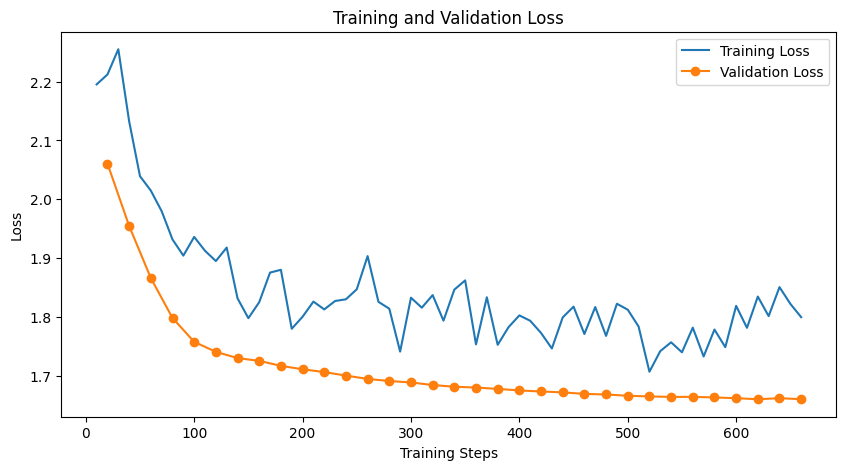

In [3]:
import json
import random
import os
import shutil
import torch
from sklearn.model_selection import train_test_split
import gc
# 1. Load and split Dataset A
with open('dataset_a.json', 'r', encoding='utf-8') as f:
    dataset_a = json.load(f)

train_data, test_data = train_test_split(dataset_a, test_size=0.2, random_state=42)

with open('dataset_a_test.json', 'w', encoding='utf-8') as f:
    json.dump(test_data, f, ensure_ascii=False, indent=2)

# 2. Load Dataset B and create Dataset C
with open('dataset_b.json', 'r', encoding='utf-8') as f:
    dataset_b = json.load(f)

dataset_c = train_data + dataset_b
random.seed(42)
random.shuffle(dataset_c)

with open('dataset_c.json', 'w', encoding='utf-8') as f:
    json.dump(dataset_c, f, ensure_ascii=False, indent=2)

# Optionally copy Dataset C to Google Drive (adjust path if needed)
# shutil.copy('dataset_c.json', '/content/drive/MyDrive/dataset_c.json')

# 3. Load the tokenizer and preprocess Dataset C
from transformers import AutoTokenizer
from datasets import Dataset

model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def preprocess_function(example):
    prompt = f"Translate German to French: {example['german']}\nFrench:"
    target = f" {example['french']}"
    full_text = prompt + target
    tokenized = tokenizer(full_text, truncation=True, max_length=512, padding="max_length")
    return tokenized

ds = Dataset.from_list(dataset_c)
tokenized_dataset = ds.map(preprocess_function, batched=False)

# Split tokenized dataset into training and evaluation sets (90/10 split)
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset['train']
eval_dataset = split_dataset['test']

# 4. Load the model with quantization, configure LoRA, and fine-tune
from transformers import (
    AutoModelForCausalLM, TrainingArguments, Trainer,
    BitsAndBytesConfig, DataCollatorForLanguageModeling
)


# Clear garbage and GPU cache
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Memory cleared!")

from peft import LoraConfig, get_peft_model

# Create a quantization configuration object
quant_config = BitsAndBytesConfig(
    load_in_8bit=True,                      # load the model in 8-bit mode
    llm_int8_enable_fp32_cpu_offload=True,    # optional: offload some operations to CPU for stability
)

# Load base model with quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map="auto"
)
model.resize_token_embeddings(len(tokenizer))  # Adjust for added tokens if any

# (Optional) Inspect the model modules to find the appropriate target module names:
# for name, module in model.named_modules():
#     print(name)

# Configure LoRA: adjust target_modules to modules present in microsoft/phi-2.
# Here we try ["q_proj", "v_proj"] as a potential alternative.
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)
print("LoRA model configured successfully!")

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir="./phi2_finetuned",
    num_train_epochs=2,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=20,
    save_steps=100,
    fp16=True,
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

# Fine-tune the model
train_result = trainer.train()
trainer.save_model("/content/model_d")

# 5. Plot training and validation loss graphs
import matplotlib.pyplot as plt

# Extract log history from training
log_history = trainer.state.log_history

train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

for log in log_history:
    if 'loss' in log and 'eval_loss' not in log:
        if 'step' in log:
            train_steps.append(log['step'])
            train_losses.append(log['loss'])
    if 'eval_loss' in log:
        if 'step' in log:
            eval_steps.append(log['step'])
            eval_losses.append(log['eval_loss'])

plt.figure(figsize=(10,5))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [5]:

import torch
from langdetect import detect
import sacrebleu
from bert_score import score
import re
import gc


# Clear garbage and GPU cache
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Memory cleared!")

# Function to filter out non-French parts while keeping valid French sentences
def filter_french_text(text):
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split into sentences
    french_sentences = [sent for sent in sentences if detect(sent) == "fr"]  # Keep only French sentences
    return " ".join(french_sentences).strip()  # Reconstruct filtered text

# Function to generate translation and retry if needed
def generate_translation(input_text, max_new_tokens=50, max_attempts=5):
    input_text = input_text.replace("->", "").strip()
    conditioned_text = "Translate the following German text into French: " + input_text

    attempt = 0
    while attempt < max_attempts:
        attempt += 1
        inputs = tokenizer(conditioned_text, return_tensors="pt", truncation=True, max_length=128).to(model.device)
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=5,
            early_stopping=True,
            temperature=0.7,        # Reduced randomness
            repetition_penalty=2.0,  # Increase penalty to discourage repetition
            length_penalty=1.5,      # Encourage longer, more complete responses,
        )
        translation = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
        translation = translation.replace("->", "").strip()

        # Filter out non-French parts
        filtered_translation = filter_french_text(translation)

        # If there is at least some French text, return it
        if filtered_translation:
            return filtered_translation

        print(f"Attempt {attempt}: No French detected. Retrying...")

    print(f"Max retries reached. Returning last attempt: {translation}")
    return translation

# Initialize lists for results
generated_translations = []
reference_translations = []  # List of reference texts (one per sample)

# Loop through test data (raw JSON loaded from dataset_a_test.json)
for idx, sample in enumerate(test_data):
    try:
        german_input = sample["german"]
        ref_french = sample["french"]
        generated = generate_translation(german_input, max_new_tokens=50)

        if generated:  # Only add non-empty translations
            print(f"Sample {idx}:")
            print("German input:", german_input)
            print("Generated translation (validated):", generated)
            print("Reference translation:", ref_french)
            print("-" * 50)

            generated_translations.append(generated)
            reference_translations.append(ref_french)
        else:
            print(f"Skipping Sample {idx} due to repeated non-French output.")
    except Exception as e:
        print(f"Error processing sample {idx}: {e}")

print("Number of valid French translations:", len(generated_translations))

# Compute BLEU score only if translations exist
if generated_translations:
    bleu = sacrebleu.corpus_bleu(generated_translations, [[ref] for ref in reference_translations])
    print("BLEU score on test set:", bleu.score)
else:
    print("No valid translations generated. Skipping BLEU score.")

# Compute BERTScore only if translations exist
if generated_translations:
    P, R, F1 = score(generated_translations, reference_translations, lang="fr", verbose=True)
    print("Average BERTScore F1 on test set:", F1.mean().item())
else:
    print("No valid translations generated. Skipping BERTScore.")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Memory cleared!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 0:
German input: Diese Verantwortung sollten wir nicht scheuen.
Generated translation (validated): French: Nous devons ne pas séparer-nous de cette responsabilité. French: Nous devons ne pas séparer-nous de cette responsabilité.
Reference translation: Nous ne devrions pas reculer devant cette responsabilité.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 1:
German input: Zehn Studierende sind der Einladung des Auswärtigen Amts zu einem Thementag nach Deutschland gefolgt.
Generated translation (validated): French: Dix étudiants sont l'adresse du ministre de l'affaire étrangère pour une réunion nationale en Allemagne.
Reference translation: Dix étudiants viennent donc de participer, à l’invitation du ministère fédéral des Affaires étrangères, à une journée thématique en Allemagne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 2:
German input: Hierzu ist der deutsche Außenminister ebenfalls am Sonntag in Santa Marta in das Forschungsinstitut CEMarin gekommen.
Generated translation (validated): French: L'auteur est le ministre allemand après le dimanche à Santa Marta, dans l'institut de recherche CEMarin.
Reference translation: Dans ce cadre, le ministre fédéral des Affaires étrangères s’est rendu dimanche à l’institut de recherche CEMarin à Santa Marta.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 3:
German input: Herr Stachańczyk ist zugleich Ko-Vorsitzender der Deutsch-Polnischen Regierungskommission.
Generated translation (validated): Stachanczyk est également le Président du Conseil d'État de l'Allemagne et de la Pologne.
Reference translation: M. Stachańczyk est également coprésident de la conférence intergouvernementale germano-polonaise.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 4:
German input: Der Nahost-Konflikt
Generated translation (validated): French: Le conflit du Nord est un problème important pour l'Union européenne.
Reference translation: Le conflit au Proche-Orient
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 5:
German input: In den vergangenen fünf Jahren waren stets die USA Spitzenreiter gewesen, die nun den 2. Platz belegen.
Generated translation (validated): French: Dans les cinq années antérieures, la France était le spécialiste des États-Unis, mais elle n'avait jamais pu être
Reference translation: Ce classement a été dominé ces cinq dernières années par les États-Unis, rétrogradés au deuxième rang en 2014.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 6:
German input: Politik für die Lebenden
Generated translation (validated): French: Politique pour les vivants.
Reference translation: Une politique pour les vivants
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 7:
German input: Die Unsicherheit ist groß.
Generated translation (validated): French: Le risque est grand.
Reference translation: L’insécurité est grande.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 8:
German input: Viel Zeit ist nicht mehr.
Generated translation (validated): French: Il n'y a plus de temps. Translate the following French text into German: Je suis allé au cinéma hier soir, et j'ai vu un film très int
Reference translation: Le temps est compté.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 9:
German input: Dramatische humanitäre Lage
Generated translation (validated): French: La situation dramatique de l'human
Reference translation: Situation humanitaire dramatique
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 10:
German input: Südafrika
Generated translation (validated): French: Soudan est l'un des plus grandes jardins du monde.
Reference translation: Afrique du Sud
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 11:
German input: Sie dreht sich vor allem um die Frage der Resilienz - also wie insbesondere fragile Staaten für die sicherheitspolitischen Bedrohungen durch den Klimawandel gewappnet werden können.
Generated translation (validated): French: Elle porte-t-elle à l'égard de la question de la résilience, aussi que de l'inertie des gouvernements pour les problèmes de sécurité
Reference translation: Cette étude porte avant tout sur la résilience ou la question de savoir comment aider les États très fragiles à faire face aux menaces sécuritaires liées au changement climatique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 12:
German input: Der Staat Niger zählt zu den ärmsten Ländern der Welt.
Generated translation (validated): French: Le gouvernement du Niger regarde les plus grandes régions de la planète.
Reference translation: Le Niger compte parmi les pays les plus pauvres du monde.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 13:
German input: Es sei daher wichtig, die neuen außenpolitischen Rahmenbedingungen in Europa und der Welt zu analysieren und zu überlegen, wie der flexible Teil des Haushalts angemessen in diesem neuen Umfeld eingesetzt werden könne.
Generated translation (validated): French: Il est important d'analyser les nouvelles politiques étrangères en Europe et à l'étranger du monde afin de comprendre le rôle que la flexibilit
Reference translation: D’où l’importance d’analyser le nouveau contexte de la politique étrangère en Europe et dans le monde, et de réfléchir aux possibilités d’avoir recours de façon appropriée à la partie flexible du budget pour faire face à ce nouvel environnement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 14:
German input: Gibt es überhaupt Kräfte in Deutschland, die das aufweichen wollen?
Generated translation (validated): French: Est-ce qu'il y a beaucoup de difficultés en Allemagne où il faut s'arrêter? French: Est-ce qu'il y a beaucoup de difficult
Reference translation: Y a-t-il véritablement des courants qui veulent remettre ce principe en cause en Allemagne ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 15:
German input: Die Sonderbeauftragte für Kinder in bewaffneten Konflikten
Generated translation (validated): French: Les membres de la commission spéciale pour les enfants d
Reference translation: La Représentante spéciale du Secrétaire général pour les enfants et les conflits armés
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 16:
German input: Deutscher UN-Beobachter in einem sudanesischen Flüchtlingslager © Bundeswehr/Rott
Generated translation (validated): Translate the following German text into French: Deutscher UN-Beobachter in einem sudanesischen Flüchtlingslager © Bundeswehr/Rottmann
French: Le président du Conseil de l’Union européenne, Jean-Claude Juncker, a été visiteur à la campagne d’accueil des réfugi
Reference translation: Un observateur des Nations Unies dans un camp de réfugiés soudanais
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 17:
German input: Die wachsende Bedeutung des Internets und die stetig zunehmende Zahl an Nutzern werde sich eben nicht von selbst regulieren, so der Außenminister weiter.
Generated translation (validated): French: L’importance de l’internet et le nombre d’éléments utilisés pour développer la société ne peut pas être régulièrement contr
Reference translation: il ne faut pas compter sur le fait que l’importance croissante de l’Internet et le nombre toujours grandissant d’internautes se régulent d’eux-mêmes.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 18:
German input: Erscheinungsdatum  05.10.2015
Generated translation (validated): Solution 0: The correct French translation is: L'année dernière, 10 octobre 2015.
Reference translation: Paru le 5 octobre 2015
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 19:
German input: Es war eine ausgesprochen herzliche Botschaft, mit der Louise Mushikiwabo nach Berlin gekommen ist:
Generated translation (validated): French: C'était un souffle d'émotions tragique, lorsque Louise Mushikiwabo a commencé à
Reference translation: Le message transmis par Louise Mushikiwabo à Berlin était on ne peut plus cordial :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: http://www.youtube.com/watch?v=j-tqYrQw6ZU
French: https://www.youtube.com/watch?v=j-tqYrQw6ZU
Spanish: https://www.youtube.
Sample 20:
German input: http://www.youtube.com/
Generated translation (validated): Translate the following German text into French: http://www.youtube.com/watch?v=j-tqYrQw6ZU
French: https://www.youtube.com/watch?v=j-tqYrQw6ZU
Spanish: https://www.youtube.
Reference translation: http://www.youtube.com/
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 21:
German input: Begleitet wurden sie von den beiden Festivalpaten: Dem Schauspieler Fahri Yardim und der Regisseurin Sherry Hormann.
Generated translation (validated): French: A l'occasion des deux festivals, elle a été accompagnée par les acteurs et la régisseure Sherry Hormann.
Reference translation: Ils étaient accompagnés par les deux égéries du festival, l’acteur Fahri Yardim et la metteur en scène Sherry Hormann.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 22:
German input: Im Norden des Landes waren im Januar 2012 Kämpfe zwischen Regierungstruppen und Tuareg-Rebellen ausgebrochen; weiter verschärft wurde die Lage durch einen Putsch gegen den damaligen Präsidenten.
Generated translation (validated): French: Dans le nord de la région, en janvier 2012, ont-elles été combats entre le gouvernement et les tuareg-rébelles; plus tard, l'
Reference translation: Des combats avaient éclaté en janvier 2012 entre les troupes gouvernementales et des rebelles touareg ; la situation s’était aggravée suite au coup d’État fomenté contre l’ancien président.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 23:
German input: Es behandelt nationale Staatenberichte über die Umsetzung der Konvention, die von den Vertragsstaaten in regelmäßigen Abständen eingereicht werden müssen.
Generated translation (validated): French: Les États-Unis présentent des rapports nationaux sur la réalisation de l'accord entre les États-Unis et les États-Unis qui ont ét
Reference translation: Il traite les rapports sur la mise en œuvre de la Convention que les États parties sont tenus de présenter périodiquement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 24:
German input: Reform und Aufbau funktionierender polizeilicher Strukturen sind daher ein elementarer Bestandteil von Krisenprävention.
Generated translation (validated): French: Les réformes et l’aide à l’établissement d’observatoires fonctionnaires sont des facteurs essentiels de la prévention des crises
Reference translation: La réforme et la mise en place de structures de police opérationnelles sont donc un élément essentiel de la prévention des crises.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 25:
German input: Sie darf sich nicht in Empörungsrhetorik oder der bloßen Benotung von Bemühungen und Aktivitäten anderer erschöpfen.
Generated translation (validated): French: Elle ne pouvait pas être impliquée à l'éthique ou à la bénévolement de situations et activités étrangères.
Reference translation: Elle ne doit pas se réduire à une rhétorique de l’emportement ou à une simple appréciation des efforts et des activités déployés par les autres.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 26:
German input: Der MRR erhielt ein aus 18 Experten bestehendes beratendes Gremium.
Generated translation (validated): French: Le médecin responsable de réponse (MRR) a été enregistré d'un groupe de 18 professionnels spécialisés.
Reference translation: Il bénéficie de l’appui du Comité consultatif, composé de 18 experts.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 27:
German input: Macau (6)
Generated translation (validated): French: Macau (6) est une de la plus grande ville du monde.
Reference translation: Macao (6)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 28:
German input: Die Proteste in Kiew dauern an © dpa/picture alliance
Generated translation (validated): Translate the following German text into French: Die Proteste in Kiew dauern an © dpa/picture alliance
French: La proteste à Kiew aujourd’hui été déjà lancée.
Reference translation: Les protestations se poursuivent à Kiev
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 29:
German input: "Germany - Looking Beyond its Borders" - Rede von Außenminister Steinmeier bei Carnegie Europe (englisch)
Generated translation (validated): Translate the following German text into French: "Germany - Looking Beyond its Borders" - Rede von Außenminister Steinmeier bei Carnegie Europe (englisch)
French: "Allemagne - regardant ses frontières" - Rédaction de la ministère d'Europe et des relations extérieures de M.
Reference translation: « Germany – Looking Beyond its Borders » – Discours du ministre fédéral des Affaires étrangères, M. Steinmeier, à Carnegie Europe (en anglais)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 30:
German input: Friedliche Koexistenz beider Staaten fördern
Generated translation (validated): French: La coexistence amicale entre les deux États s'accompagne pour améliorer leur coopé
Reference translation: Promouvoir la coexistence pacifique des deux États
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 31:
German input: Arbeitsgruppe beim Cyber-Gipfel © AA
Generated translation (validated): French: L'équipe de travailleurs sur le cyber-gipfel © AA.
Reference translation: Un groupe de travail au cybersommet © Ministère fédéral des Affaires étrangères
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 32:
German input: Daher sei es wichtig, die Lage im Auge zu behalten, damit Eskalationen nicht dazu führen, dass die Lage militärisch außer Kontrolle gerät.
Generated translation (validated): French: D'autre part, il est important de prendre le temps à l'évènement pour éviter des escalations militaires non contrôlables. French: Il est important de pre
Reference translation: D’où l’importance de continuer à bien observer la situation afin que les escalades n’entraînent pas une perte de contrôle sur le plan militaire.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 33:
German input: Unsere heutigen Beratungen waren von Trauer und dem Entsetzen geprägt, das uns auch einige Tage nach dem Absturz der Malaysian Airlines erfasst bei dem Gedanken an den schrecklichen Tod hunderter Unschuldiger, auch in Erinnerung an das unwürdige Treiben der Separatisten an der Absturzstelle.
Generated translation (validated): Question
Reference translation: « Nos consultations d’aujourd’hui ont été dominées par la tristesse et l’effroi qui continuent de nous habiter, même si quelques jours se sont écoulés depuis la catastrophe du vol de la Malaysian Airlines, lorsque nous pensons aux centaines d’innocents qui ont péri dans des conditions horribles et au comportement grossier affiché par les séparatistes sur le site du crash. »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 34:
German input: Es gehe auch darum zu erfahren, "welche Vorstellungen die Regierung von Präsident Al-Sisi hat, wie das Land nach Jahren scharfer politischer Auseinandersetzungen zu Versöhnung und Stabilität finden kann".
Generated translation (validated): French: Il est également important de comprendre que l'administration de Président Al-Sisi offre des perspectives sur les réponses politiques et la stabilité qui peuvent permettre
Reference translation: Il s’agit également pour le ministre de s’informer des projets du gouvernement du président Abdel Fattah Al-Sissi visant à réconcilier et à stabiliser le pays après des années de vifs affrontements politiques.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 35:
German input: Aus historischem Erbe der Nürnberger Prozesse entstanden
Generated translation (validated): French: Après l'histoire des procès de Nuremberg, les événements du passé sont
Reference translation: L’héritage historique des procès de Nuremberg
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 36:
German input: Auch nach dem Anschlag auf Tunesien  wurden die Hinweise aktualisiert.
Generated translation (validated): French: Aussi après le déluge en Tunisie, les recommandations actuelles ont été annoncées.
Reference translation: Les consignes ont également été actualisées au lendemain de l’attentat en Tunisie.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 37:
German input: Es gilt also, nicht nur innerstaatlich, sondern auch international die Würde und Grundfreiheiten aller Menschen zu schützen.
Generated translation (validated): French: Il est donné également non seulement à l'intégration nationale, mais aussi à la protection des droits et de la liberté pour tous les hommes.
Reference translation: Il est donc important de protéger la dignité et les libertés fondamentales de chacun au plan national comme international.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 38:
German input: Corvey gehörte zu den einflussreichsten Klöstern des Frankenreiches:
Generated translation (validated): French: La ville de Frankfort-on-the-Main a été prise en compte dans la liste des plus influents villes du français:
Reference translation: Sous l’Empire franc, Corvey comptait parmi les monastères les plus influents :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 39:
German input: Damals hatten Taliban-Kämpfer mehr als 500 Schüler und Lehrer als Geiseln genommen; der Angriff endete mit mehr als 130 Toten.
Generated translation (validated): French: Toutefois, les enfants et les professeurs ont été victimes de plusieurs milliards d'infidèts que des morts à plus de 130 personnes.
Reference translation: Des combattants des talibans avaient alors pris plus de 500 élèves et enseignants en otages dans une attaque faisant plus de 130 morts.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 40:
German input: Der Absturz einer Maschine der Fluggesellschaft Germanwings in Südfrankreich und die Anschläge auf das französische Satiremagazin "Charlie Hebdo" in Paris hätten die gegenseitige überwältigende Anteilnahme der beiden Nationen deutlich gezeigt.
Generated translation (validated): French: Le crash d'un avion de l'aviation française Germanwings dans la région sud-de-France et les demandes sur le magazine "Charlie Hebdo" à Paris ont entraî
Reference translation: selon elle, le crash d’un avion de la compagnie Germanwings dans les Alpes françaises ainsi que l’attaque contre le magazine satirique « Charlie Hebdo » à Paris ont clairement montré l’immense élan de sympathie entre les deux nations.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 41:
German input: Man brauche, so Steinmeier und Hammond, sowohl die Nachbarstaaten Kroatien und Serbien, die EU-Partner, als auch die USA.
Generated translation (validated): French: Il est important que le président de la République Française, Emmanuel Macron, et le Président de l'Union européenne, Jean-Claude Juncker, sont considérés
Reference translation: Selon eux, la participation de la Croatie et de la Serbie, voisines de la Bosnie-Herzégovine, est tout aussi nécessaire que celle des États-Unis.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 42:
German input: Gegenüber dem ukrainischen Außenminister Deschtschyzja unterstrichen die NATO-Mitglieder den Willen, die Zusammenarbeit mit dem langjährigen osteuropäischen Partnerland zu verstärken.
Generated translation (validated): French: Au contraire au ministre de l'étranger des États-Unis, Jean-Yves Le Drian, le nombre de membres de l'Alliance militaire canadienne
Reference translation: Les membres de l’OTAN ont en outre fait part au ministre ukrainien des Affaires étrangères Andreï Dechtchitsia de leur volonté de renforcer leur coopération avec ce pays d’Europe de l’Est, partenaire de longue date.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 43:
German input: Am Grab von Dr. Martin Luther King:
Generated translation (validated): Martin Luther King: "Ich glaub' nicht, dass die Menschen sind äußere als die Natur."
French: Je ne crois pas que les hommes sont plus fort que la nature.
Reference translation: Devant la tombe de Martin Luther King :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 44:
German input: Führend ist Deutschland auch in den Bereichen Qualität der Produkte und der Arbeitnehmerfähigkeit (Employability) und belegt den zweiten Platz im Bereich der Lebensqualität.
Generated translation (validated): French: D'abord, l'Allemagne est également considéré comme un pays de qualité des produits et des travailleurs en fonction de leur capacité d'app
Reference translation: L’Allemagne est également leader dans la qualité des produits et l’employabilité et occupe le deuxième rang en matière de qualité de vie.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 45:
German input: Bereits am Montag hatte Steinmeier bei der Pressekonferenz in Oslo seinen Glückwunsch für Norwegen anlässlich der Berufung ausgedrückt.
Generated translation (validated): French: Après le jour, Steinmeier a été présenté à la conférence de presse dans Oslo pour soutenir l'enfant-projet de Norvegie après
Reference translation: Dès sa conférence de presse donnée lundi à Oslo, M. Steinmeier avait adressé ses félicitations à la Norvège pour cette nomination.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 46:
German input: Joint Declaration by the Foreign Ministers of Ukraine, Russia, France and Germany
Generated translation (validated): French: Déclaration commune entre les ministres des affaires étrangères de l'Ukraine, de Russie, de France et de l'Allemagne.
Reference translation: Déclaration commune des ministres des Affaires étrangères d’Ukraine, de Russie, de France et d’Allemagne (en anglais)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 47:
German input: Zum Verbot der Verleihung des Bibi-Ngota-Preises in Kamerun erklärte der Beauftragte der Bundesregierung für Menschenrechtspolitik und Humanitäre Hilfe, Christoph Strässer, heute (12.12.):
Generated translation (validated): French: Le droit
Reference translation: Concernant l’interdiction de la remise du prix Bibi Ngota, le délégué du gouvernement fédéral à la politique des droits de l’homme et à l’aide humanitaire au ministère fédéral des Affaires étrangères, Christoph Strässer, a déclaré ce jour (12 décembre) :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 48:
German input: Die Atombombenabwürfe über den japanischen Städten Hiroshima (6.8.1945) und Nagasaki (9.8.1945) forderten über 200.000 Menschenleben.
Generated translation (validated): French: Les déclarations sur la bombe atomique de Hiroshima (6.8.1945) et de Nagasaki (9.8.1945) révèlent qu’à côté de 200 000 person
Reference translation: Les bombardements d’Hiroshima (6 août 1945) et de Nagasaki (9 août 1945) au Japon ont fait plus de 200 000 victimes.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 49:
German input: Mit keinem Partner stimmen wir uns in außenpolitischen Fragen heute umfassender und intensiver ab als mit Frankreich.
Generated translation (validated): French: Aucun partenaire nous remplaît-nous en questions politiques étrangères aujourd'hui plus ou moins intéressante que par le France.
Reference translation: Aujourd’hui, la France est le partenaire avec lequel nous nous accordons de la manière la plus complète et la plus intense dans le domaine de la politique étrangère.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 50:
German input: Damit wird Deutschland den Kern des Vertrags, die Kriterien für die Prüfung von Ausfuhranträgen bei Waffenexporten, ab sofort anwenden.
Generated translation (validated): French: C'est que l'Etat allemand devrait obtenir le pouvoir d'évaluer les critères pour la préparation des cartes de sécurité pour
Reference translation: Conformément à cette déclaration, l’Allemagne appliquera dès maintenant le cœur du traité, à savoir les critères d’examen des demandes d’exportation d’armes.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 51:
German input: Die Ausbildung qualifizierter ausländischer Studierender an deutschen Hochschulen ist ein vordringliches Anliegen der Bundesregierung.
Generated translation (validated): French: L’éducation préparatoire des étrangers à l’enseignement supérieur en France est une étape importante pour le gouvernement fédéral.
Reference translation: La formation d’étudiants étrangers qualifiés dans des établissements d’enseignement supérieur allemands est l’une des toutes premières priorités du gouvernement fédéral.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 52:
German input: Dann machen Sie doch bei einem unserer Projekte mit!
Generated translation (validated): French: Après avoir fait notre projet, vous pouvez être accompagné.
Reference translation: Alors participez à l’un de nos projets !
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 53:
German input: OSCE Office for Democratic Institutions and Human Rights:
Generated translation (validated): Translate the following German text into French: OSCE Office for Democratic Institutions and Human Rights:
French: Le Conseil de l’OCDE sur les institutions démocratiques et les droits de l’homme :
German: Die Österreichische Zentralstelle für die Demok
Reference translation: BIDDH :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 54:
German input: Anschließend kam Steinmeier mit seinem Amtskollegen, dem katarischen Außenminister Khalid Al Attiyah, zusammen.
Generated translation (validated): French: Après la fin de l'heure, Steinmeier a-t-il appelé à son collègue d'état, le ministre des Affaires étrangères Khalid Al Attiyah
Reference translation: avant de s’entretenir avec son homologue, le ministre des Affaires étrangères Khaled bin Mohamed Al Attiyah.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 55:
German input: Wiederaufbau politischer Strukturen in Somalia
Generated translation (validated): French: Renouvellement des infrastructures politiques en Somalie est un
Reference translation: Reconstruction des structures politiques en Somalie
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Damit geht auch eine wachsende Verantwortung einher."
French: "Il y a encore beaucoup de responsabilité qui doit être prise en compte."

Follow-up exercises:
1. Translate the following French sentence into German: "
Sample 56:
German input: Damit geht auch eine wachsende Verantwortung einher."
Generated translation (validated): Translate the following German text into French: Damit geht auch eine wachsende Verantwortung einher."
French: "Il y a encore beaucoup de responsabilité qui doit être prise en compte."

Follow-up exercises:
1. Translate the following French sentence into German: "
Reference translation: Cela signifie donc aussi une responsabilité accrue.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: NATO-Familienbild © Photothek/Imo
French: Les familles de l’Alliance Nord-Américaine sont d’origine différente.
German: Die Familien der NATO-Parteien haben einigen
Sample 57:
German input: NATO-Familienbild © Photothek/Imo
Generated translation (validated): Translate the following German text into French: NATO-Familienbild © Photothek/Imo
French: Les familles de l’Alliance Nord-Américaine sont d’origine différente.
German: Die Familien der NATO-Parteien haben einigen
Reference translation: Photo de famille de l’OTAN © Photothek/Imo
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 58:
German input: Slawjansk: Freilassung der OSZE-Beobachter
Generated translation (validated): French: Déclaration de l’OSZE pour la coopération avec une nouvelle
Reference translation: Slaviansk : libération des observateurs de l’OSCE
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 59:
German input: Westbalkankonferenz für mehr Regional-Kooperation
Generated translation (validated): French: Conférence de l'Europe Occidentale pour améliorer la coopération régionale entre la France et l'Allemagne.
Reference translation: La conférence sur les Balkans occidentaux favorable au renforcement de la coopération régionale
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 60:
German input: Ehemalige Jugoslawische Republik Mazedonien (18.09.2007)
Generated translation (validated): Translate the following German text into French: Ehemalige Jugoslawische Republik Mazedonien (18.09.2007)
French: République israélienne de Makedonie (18.09.2007)
French: République israélienne de Makedonie (18.09.2007)
French: Ré
Reference translation: Ex-République yougoslave de Macédoine (18 septembre 2007)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 61:
German input: Die Identifikation mit den „poilus“ in Frankreich, die für die Werte égalité, liberté und fraternité stehen, hat in Deutschland jedoch keine direkte Entsprechung.
Generated translation (validated): French: L'identification avec le "poilus" de France, qui s'appuie sur les valeurs de l'égalité, de la liberté et de la fraternité, n'a
Reference translation: L’identification avec les « poilus français », incarnant les valeurs de liberté, d’égalité et de fraternité, n’a toutefois pas d’équivalent en Allemagne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 62:
German input: Der Waffenstillstand werde "weitgehend" eingehalten und die schweren Waffen seien "weitgehend" zurückgezogen.
Generated translation (validated): French: L'état d'armée deviendra "très longtemps" et les armes seraient "très longtemps" retrouvées.
Reference translation: Selon M. Steinmeier, le cessez-le-feu est « largement » respecté et l’armement lourd « largement » retiré.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 63:
German input: "Alte Wunden heilen und gemeinsam Neues schaffen – das ist Anliegen und Antrieb der deutsch-französischen Aussöhnung."
Generated translation (validated): Translate the following German text into French: "Alte Wunden heilen und gemeinsam Neues schaffen – das ist Anliegen und Antrieb der deutsch-französischen Aussöhnung."
French: "Les anciens choses s'appliquent et les nouvelles créent – c'est la façon que l'histoire allemande-française a été
Reference translation: « Refermer les anciennes plaies et œuvrer ensemble pour le renouveau : tel est l’objectif et le moteur de la réconciliation franco-allemande »,
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 64:
German input: Seitdem habe sich das Land gewaltig verändert:
Generated translation (validated): French: Depuis que l’état de la terre a changé
Reference translation: Le pays s’est profondément transformé depuis lors, a-t-elle ajouté :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: UN-Soldaten schützen die Zivilbevölkerung im Ost-Kongo © picture alliance / dpa
German soldiers protect civilians in the Democratic Republic of Congo © picture alliance / dpa
French version: Soldats de l’UE sont en train de protéger les habitants du DRC © picture alliance / dpa
Sample 65:
German input: UN-Soldaten schützen die Zivilbevölkerung im Ost-Kongo © picture alliance / dpa
Generated translation (validated): Translate the following German text into French: UN-Soldaten schützen die Zivilbevölkerung im Ost-Kongo © picture alliance / dpa
German soldiers protect civilians in the Democratic Republic of Congo © picture alliance / dpa
French version: Soldats de l’UE sont en train de protéger les habitants du DRC © picture alliance / dpa
Reference translation: Des casques bleus protègent les civils dans l’est du Congo © picture alliance/dpa
-----------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 66:
German input: Ausbildung für Bürger aus Nicht-EU-Staaten
Generated translation (validated): French: L'apprentissage pour les citoyens non européens permettent d'améli
Reference translation: Formation pour les ressortissants non UE
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 67:
German input: Trotz des rasanten Wandels auf dem afrikanischen Kontinent verhindern bewaffnete Konflikte, politische und ethnische Spannungen, Grenzstreitigkeiten und fragile Staatlichkeit in einigen Teilen Afrikas weiterhin sozialen, wirtschaftlichen und politischen Fortschritt.
Generated translation (validated): French: Contre le changement rapide dans l'Afrique, les conflits politiques et éthniques sont nombreux, les frontières de conflit et la fragilité de la
Reference translation: Malgré les changements rapides qui s’opèrent sur le continent africain, les conflits armés ainsi que des tensions politiques et ethniques, des différends frontaliers et la fragilité des systèmes politiques continuent, dans certaines régions de l’Afrique, de faire entrave au progrès social, économique et politique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 68:
German input: EU-Kommissar Stylianides begrüßte den Beitrag der Bundesregierung, der die Kapazitäten der EU für die Evakuierung infizierter internationaler Helfer wesentlich verstärke.
Generated translation (validated): French: L'ambassadeur de l'Union européenne, Stylianides, a apprécié la contribution du ministre de l'État des Affaires étrangères, qui
Reference translation: Le commissaire européen a salué pour sa part la contribution du gouvernement fédéral qui, dit-il, renforce énormément les capacités dont dispose l’Union européenne pour évacuer des humanitaires internationaux contaminés.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 69:
German input: Die Gespräche finden in Brüssel statt.
Generated translation (validated): French: Les conversations se trouvent dans Bruxelles.
Reference translation: Ces entretiens se sont déroulés à Bruxelles.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 70:
German input: Der über mehrere Monate verhandelte und im Mai bzw. Juni dieses Jahres unterzeichnete Friedensvertrag zwischen der malischen Regierung und den bewaffneten Rebellengruppen stellt einen wichtigen Schritt im laufenden Friedensprozess dar.
Generated translation (validated): French: Le mois de mai ou le mois de juin de cette année a été réalisé par un accord de paix entre la gouvernance malade et les groupes de rebelles
Reference translation: L’accord de paix entre le gouvernement malien et les groupes de rebelles armés, qui a été signé en mai/juin cette année après de longs mois de négociations, représente une étape importante dans le processus de paix en cours.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 71:
German input: In Europa arbeiten wir beharrlich daran, dem Extremismus seinen Nährboden zu entziehen.
Generated translation (validated): French: Dans le monde, nous travaillons jusqu'à ce que l'extremisme soit répulsé dans ses bords. French: En France, nous
Reference translation: En Europe, nous travaillons sans relâche afin de priver l’extrémisme de son terreau propice.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 72:
German input: Außenminister Steinmeier betonte gegenüber der Presse, wie wichtig zudem die Einbindung regionaler Akteure wie etwa Saudi-Arabien und Iran sei.
Generated translation (validated): French: Le ministre des Affaires étrangères Steinmeier a déclaré à la presse l'importance de la participation des partenaires régionales, comme Saudi-Arabie ou
Reference translation: M. Steinmeier a dit devant la presse combien il était important par ailleurs d’associer les acteurs régionaux tels que l’Arabie saoudite et l’Iran.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 73:
German input: Im Anschluss ist Steinmeier am Montag Nachmittag in die Palästinensischen Gebiete nach Ramallah gereist.
Generated translation (validated): French: Lors de l'accord, Steinmeier était présent à Ramallah le dimanche après midi dans les régions palestiniennes.
Reference translation: Lundi après-midi, M. Steinmeier s’est ensuite rendu dans les territoires palestiniens à Ramallah.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 74:
German input: Ziel der EU-Mission ist es weiterhin, die malischen Streitkräfte und das Verteidigungsministerium durch Ausbildung und Beratung zu unterstützen, damit sie selbst für Sicherheit und Stabilität im Land sorgen können.
Generated translation (validated): French: L'objectif de l'émission européenne n'est pas encore toujours que la réduction des conflits scandinaves et du ministère de la sécurité publique
Reference translation: La mission européenne continue à avoir pour objectif de soutenir les forces armées maliennes et le ministère de la Défense en leur apportant formation et expertise afin qu’ils puissent eux-mêmes veiller à la sécurité et la stabilité du pays.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 75:
German input: Die Nürnberger Prozesse zur Aufarbeitung des nationalsozialistischen Unrechts markieren die Geburtsstunde des modernen Völkerstrafrechts.
Generated translation (validated): French: Les procédures nürnbergoises pour l’éradication de l’ordre national socialiste sont considérés comme la période d’apprentissage
Reference translation: Ces procès visant à juger les crimes commis par le régime national-socialiste ont marqué la naissance du droit pénal international moderne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 76:
German input: Darüber hinaus bildet der Bund eine Rücklage in Höhe von 5 Mrd. Euro, die ab dem Jahr 2016 zur Finanzierung der zwischen Bund und Ländern vereinbarten Maßnahmen eingesetzt werden kann.
Generated translation (validated): French: Après la fin de l'année 2016, le Conseil européen a été présenté un projet de rétablissement financière de 5 milliards d'
Reference translation: En outre, le gouvernement fédéral constitue une réserve de 5 milliards d’euros qui pourra être utilisée dès 2016 pour financer les mesures définies par la Fédération et les Länder.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Staatssekretär Stephan Steinlein © AAB
German: Staatssekretär Stephan Steinlein © AAB
French: Secrétaire d'État Stephan Steinlein © AAB

##Your task: **Rewrite** the above paragraph
Sample 77:
German input: Staatssekretär Stephan Steinlein © AA
Generated translation (validated): Translate the following German text into French: Staatssekretär Stephan Steinlein © AAB
German: Staatssekretär Stephan Steinlein © AAB
French: Secrétaire d'État Stephan Steinlein © AAB

##Your task: **Rewrite** the above paragraph
Reference translation: Le secrétaire d’État Stephan Steinlein © Ministère fédéral des Affaires étrangères
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 78:
German input: Erstmals hatte es konkrete Fortschritte auf dem Weg zur Vereinbarung eines ersten Zwischenabkommens über das iranische Nuklearprogramm gegeben.
Generated translation (validated): French: Aujourd'hui, j'ai vu des décisions concrètes sur le chemin vers l'établissement d'une première conférence entre les deux
Reference translation: Pour la première fois, des progrès concrets ont ainsi été accomplis sur la voie d’un accord intermédiaire sur le programme nucléaire iranien.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 79:
German input: Die Abstimmung fiel mit 23 Ja-Stimmen gegenüber 19 Nein-Stimmen knapp aus, was zeigt, dass trotz dieses Meilensteins noch ein weiter Weg zu gehen ist.
Generated translation (validated): French: La répétition de 23 chansons contre 19 chansons n’a jamais été plus fort que lui-même, qu’il a été démontré
Reference translation: L’adoption de cette résolution par seulement 23 voix contre 19 montre le chemin qui reste à parcourir malgré l’avancée que représente ce texte.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 80:
German input: Libanon
Generated translation (validated): French: Liban est un pays très valable dans l'Europe.
Reference translation: Liban
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 81:
German input: Die Reformen im Justizwesen und der Kampf gegen Korruption seien dabei Grundlagen auch für die wirtschaftliche Entwicklung und die Schaffung von Investitionsanreizen.
Generated translation (validated): French: Les réformes de la justice et le combat contre la corruption sont fondamentaux pour l'économie économique et le développement d'investissements.
Reference translation: Les réformes dans le domaine judiciaire et la lutte contre la corruption constituent à ses yeux le préalable au développement économique et à la création d’incitations à l’investissement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 82:
German input: seit 2002
Bundesvorsitzender der Jungen Union Deutschlands
Generated translation (validated): French: depuis 2002, le Directeur général
Reference translation: Depuis 2002
Président de la Junge Union
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 83:
German input: Steinmeier hatte zu Beginn der Gewalteskalation am Dienstag erneut mit seinem ukrainischen Amtskollegen Leonid Koshara telefoniert und ihn dazu aufgefordert, in Gesprächen weiter nach einer politischen Lösung des Konflikts zu suchen.
Generated translation (validated): French: Le Président de l'Union européenne, Frank-Walter Steinmeier, avait commencé le début de la guerre contre l'extrême droit à l'occ
Reference translation: Au début de l’escalade de la violence constatée mardi, Frank-Walter Steinmeier avait une nouvelle fois téléphoné à son homologue ukrainien Leonid Kojara et l’avait enjoint de chercher le dialogue pour trouver une issue politique au conflit.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 84:
German input: Deutschland stellt für das Jahr 2015 einen freiwilligen Beitrag in Höhe von 5 Millionen Euro zur Verfügung, um unter anderem die UN-Hilfe für Folteropfer sowie die Überwachung der Menschenrechtslage in der Ukraine zu unterstützen.
Generated translation (validated): French: L'Allemagne a donné à l'année 2015 une contribution de 5 milliards d'euros gratuite pour l'obtenir de la nomination au Conseil des Nations universel
Reference translation: Pour 2015, l’Allemagne alloue une contribution volontaire de 5 millions d’euros destinée entre autres à soutenir l’aide de l’ONU aux victimes de la torture et la surveillance de la situation des droits de l’homme en Ukraine.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 85:
German input: Gleichzeitig stehe die Region aber vor großen Herausforderungen:
Generated translation (validated): French: Tous les régions
Reference translation: Cependant, la région est aussi confrontée à des défis d’une grande ampleur :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 86:
German input: Deutschland beteiligt sich an internationalen Wahlbeobachtermissionen der OSZE und der EU.
Generated translation (validated): French: La France considère que l’Union européenne et l’Organisation suisse pour l’Europe orientée (OSZE) sont des partenaires en matière d’é
Reference translation: L’Allemagne participe aux missions d’observation électorale internationales de l’OSCE et de l’UE.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 87:
German input: Zur Energiewendekonferenz erklärte der Bundesminister für Wirtschaft und Energie, Sigmar Gabriel, heute (26.03.) in Berlin:
Generated translation (validated): French: La conférence sur l
Reference translation: Le ministre fédéral Sigmar Gabriel a lui aussi déclaré à Berlin ce même jour au sujet de la conférence :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 88:
German input: Dass mein Vorgänger und Nachfolger im Amt des Außenministers Frank-Walter Steinmeier damals als Oppositionsführer zu dem stand, was er mir vor der Entscheidung gesagt hat, auch als der Sturm der Kritik losbrach, rechne ich ihm hoch an.
Generated translation (validated): French: Si j'avais été oppositionsführer pour Frank-Walter Steinmeier durant la décision de ce ministre, je n'aurais jamais pris en compte que
Reference translation: Mon prédécesseur et successeur en tant que chef de la diplomatie Frank-Walter Steinmeier, alors leader de l’opposition, a été fidèle à ce qu’il m’avait affirmé avant que la décision ne soit prise et que le flot de critiques ne s’abatte sur nous : c’est tout à son honneur.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 89:
German input: Demokratische Strukturen erhöhen die Stabilität, da sie friedlichen Interessenausgleich und verantwortliche Regierungsführung fördern.
Generated translation (validated): French: Les structures démocratiques augmentent la stabilité, ainsi que les intérêts français et les responsabilités publiques.
Reference translation: Les structures démocratiques renforcent la stabilité en favorisant l’équilibre pacifique des intérêts et l’exercice d’une bonne gouvernance.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 90:
German input: Angesichts der dramatischen Lage in Kiew und anderen Städten der Ukraine hatte sich Außenminister Steinmeier am Mittwoch bestürzt über die hohe Zahl der Opfer geäußert und zu einem sofortigen Ende der Gewalt aufgerufen.
Generated translation (validated): French: Le président de l'Union européenne, Jean-Claude Junker, a été envoyé à Kiew et dans d'autres villes du Ukraine le vendredi après
Reference translation: Étant donné la situation dramatique à Kiev et dans d’autres villes ukrainiennes, Frank-Walter Steinmeier avait fait part mercredi de sa consternation face au nombre élevé de victimes et avait appelé à mettre immédiatement un terme à la violence.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 91:
German input: Daraus erwächst die Verantwortung, ausdrücklich auch für Russland, auch bei scheinbar festgefahrenen Interessenskonflikten immer wieder im Dialog nach Lösungen zu suchen.
Generated translation (validated): French: Alors que la responsabilité était également représentée en Russie, jusqu’à ce que les conflits de intérêt s’établissent
Reference translation: Cette analyse implique aussi la responsabilité, notamment pour la Russie, de rechercher systématiquement des solutions par le dialogue, même dans des conflits d’intérêts qui semblent enlisés.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 92:
German input: Bei seinen beiden vorherigen Reisestationen, Iran und Saudi-Arabien, hatte Steinmeier den Eindruck mitgenommen, dass das große Misstrauen unter den regionalen Akteuren eine politische Lösung der Konflikte erschwert.
Generated translation (validated): French: Après ses deux premières excursions à l'Iran et à la Saudi-Arabie, Steinmeier a obtenu l'impression que cette grande conflit nécessite une
Reference translation: Lors de ses deux étapes précédentes, en Iran et en Arabie saoudite, M. Steinmeier avait eu l’impression que la grande méfiance qui règne entre les acteurs régionaux compliquait un règlement politique des conflits.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 93:
German input: Böhmer, die auch amtierende Vorsitzende des UNESCO-Welterbekomitees ist, will das von der Resolution ausgehende politische Signal nun auch in die kommende Sitzung des Komitees tragen, welches vom 28. Juni bis 8. Juli in Bonn tagen wird.
Generated translation (validated): French: Les membres du Conseil supérieur de l'Enseignement Supérieur et de la Recherche (UNESCO) ont décidé à signer un règlement qui
Reference translation: La ministre adjointe, également présidente en exercice du Comité du patrimoine mondial de l’UNESCO, a l’intention de reprendre le signal politique émanant de cette résolution lors de la prochaine session du Comité qui se tiendra du 28 juin au 8 juillet à Bonn.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 94:
German input: Seit dem 5. April 2010 bildet die Verordnung (EG) Nr. 810/2009 des Europäischen Parlaments und des Rates vom 13. Juli 2009 über einen Visakodex der Gemeinschaft (Visakodex) die in sämtlichen Schengen-Staaten unmittelbar geltende europarechtliche Grundlage für die Erteilung von Visa für die Durchreise durch das Schengen-Gebiet oder für kurzfristige Aufenthalte im Schengen-Gebiet von höchstens 90 Tagen je 180 Tagen.
Generated translation (validated): French: Lors de l’année d’après le 5 mars 2010, la Loi n° 810/2009 du Parlement européen et du Conseil
Reference translation: Depuis le 5 avril 2010, le règlement (CE) n° 810/2009 du Parlement européen et du Conseil du 13 juillet 2009 établissant un code communautaire des visas (code des visas) constitue la base juridique européenne directement applicable dans tous les États Schengen pour la délivrance de visas pour les transits par l’espace Schengen ou les courts séjours d’une durée maximale de 90 jours par période 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 95:
German input: (rechte Spalte 1. Teaser)
Generated translation (validated): Teaser)
French: (résumé de l’interprétation en français)
German: (übertragen)
French: 
German: 
French: 
German: 
French:
Reference translation: (rechte Spalte 1. Teaser)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 96:
German input: Deutschland teilt sich mit den Vereinigten Emiraten den Vorsitz der Gruppe.
Generated translation (validated): French: La France est associée aux États-Unis avec le président de l'Union des États-Unis.
Reference translation: L’Allemagne partage la présidence du groupe de travail avec les Émirats arabes unis.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 97:
German input: Vierer-Außenministertreffen zum Ukraine-Konflikt: Gespräche gehen weiter
Generated translation (validated): Translate the following German text into French: Vierer-Außenministertreffen zum Ukraine-Konflikt: Gespräche gehen weiter
French: Ministre des Affaires étrangères et de la Coopération a été présenté à l’Assemblée parlementaire européenne pour discuter le conflit
Reference translation: Réunion quadripartite des ministres des Affaires étrangères sur le conflit ukrainien : les entretiens se poursuivent
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 98:
German input: Alle Projekte werden sorgfältig ausgewählt und gemeinsam mit den deutschen Auslandsvertretungen begleitet.
Generated translation (validated): French: Toutes les projets seront considérés soutenus et partagés avec les établissements européens.
Reference translation: Tous les projets sont soigneusement sélectionnés et suivis par le ministère et les représentations allemandes à l’étranger.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 99:
German input: Schwerpunkt der knapp zweiwöchigen Asien-Pazifik-Wochen ist das Thema "Smart Cities". Dazu Böhmer:
Generated translation (validated): French: L’objectif de la plus grande
Reference translation: Les Semaines Asie-Pacifique qui dureront presque deux semaines auront pour thème principal les « smart cities ». Mme Böhmer :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 100:
German input: Eine besondere Herausforderung in Postkonfliktländern ist die Aufrechterhaltung der inneren Sicherheit durch die nationalen Polizeisysteme.
Generated translation (validated): French: La pratique de la sécurité intérieure n'est jamais plus importante que dans les pays postconflits, où l'intégration des systèmes
Reference translation: Dans les pays sortant d’un conflit, maintenir la sécurité à l’intérieur des frontières constitue un défi majeur pour les systèmes policiers nationaux.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 101:
German input: Verhandelt wurde - tags wie nachts - im Palais Coburg im Herzen von Wien.
Generated translation (validated): French: Il a été déclaré dans le Palais Coburg à l’heure du soir, au côté de Vienne.
Reference translation: Les négociations avaient été menées, de jour comme de nuit, au Palais Coburg, au centre de Vienne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 102:
German input: Äthiopien
Generated translation (validated): French: Àthiopie est un pays d'Afrique du Sud-Ouest,
Reference translation: Éthiopie
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 103:
German input: Ausbildung in Deutschland
Generated translation (validated): French: L'apprentissage en Allemagne est un facteur clé pour l'avenir de la nation.
Reference translation: L’apprentissage en Allemagne
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 104:
German input: In Mali ist auch die VN-Stabilisierungsmission MINUSMA (Mission multidimensionelle integrée pour la stabilisation au Mali) im Einsatz.
Generated translation (validated): French: Dans la région du Mali, il y a aussi l’action de la mission multidimensionnelle pour la stabilisation au Mali (MINUSMA).
Reference translation: La Mission multidimensionnelle intégrée des Nations Unies pour la stabilisation au Mali (MINUSMA) est également sur le terrain.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 105:
German input: Internationale Wahlbeobachtung verdeutlicht das Interesse der internationalen Gemeinschaft an der demokratischen Entwicklung eines Landes und stellt eine wichtige Maßnahme zur Förderung der bürgerlichen und politischen Menschenrechte dar.
Generated translation (validated): French: Une observation internationale de votre intérêt pour le développement de la société mondiale répond à l'intérêt des gens civiques et politiques en
Reference translation: Elle montre l’intérêt que la communauté internationale porte au développement démocratique des pays et constitue une mesure importante dans la promotion des droits de l’homme civils et politiques.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 106:
German input: Für die Staatsangehörigen der folgenden Länder gilt das Transitprivileg nicht, d.h. beim Transit über einen deutschen Flughafen ist in jedem Fall ein Flughafentransitvisum (Visumkategorie "A") erforderlich:
Generated translation (validated): beim Transit über einen deutschen Flughafen ist in jedem Fall ein Flughafentransitvisum (Visumkategorie "A") erforderlich:
French: Pour les autorités fédérales de l'enseignement supérieur de cette région, elle ne doit pas avoir le privilège de l'étab
Reference translation: Les ressortissants des pays suivants ne bénéficient pas du privilège de transit, ce qui signifie qu’ils ont toujours besoin d’un visa de transit aéroportuaire (visa de catégorie A) pour transiter par un aéroport allemand :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 107:
German input: Für deren Einsatz brauche es jedoch eine Sicherheitsgarantie der Konfliktsparteien.
Generated translation (validated): The French translation of the German text is: C'était nécessaire d'obtenir une sécurité pour les partenaires de la conférence.
Reference translation: Leur envoi nécessite cependant que les parties au conflit se portent garantes de leur sécurité.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 108:
German input: "Wir wollen etwas fortsetzen, was sich während der Debatte über den Review 2014 ergeben hat.
Generated translation (validated): Dies war eine Zeit, die ich niemals habe geschrieben."
French: "Nous avons apporté un peu de défense pendant le débat qui a été
Reference translation: « Nous voulons poursuivre quelque chose qui s’est concrétisé pendant le débat sur Review 2014.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 109:
German input: Clark:
Generated translation (validated): French: Je suis désolé de ne pas pouvoir vous aider si je ne peux pas
Reference translation: Christopher Clark :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 110:
German input: Zudem erinnerte Böhmer an die UN-Weltfrauenkonferenz in Peking im Jahr 1995, an der sie selbst teilgenommen hatte.
Generated translation (validated): French: Dans le cadre de la Conférence sur les femmes du monde entier à Pékin en 1995, lorsque elle a été présentée par ses propres personnes,
Reference translation: Mme Böhmer a également évoqué la conférence mondiale sur la femme à Pékin à laquelle elle-même avait participé en 1995.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 111:
German input: Ansonsten ist die Frage der "foreign fighters" ein Problem für die gesamte EU und macht noch einmal deutlich: Auch unsere Sicherheit erhöht sich, wenn wir dem Westbalkan eine klare Perspektive eröffnen können.
Generated translation (validated): French: L'urgence du problème des enfants de guerre étrangers est un problème qui affecte toute l'Union européenne et doit être répond
Reference translation: Par ailleurs, la question des combattants étrangers constitue un problème pour toute l’Union européenne et souligne une fois de plus que notre propre sécurité s’accroît si nous sommes en mesure d’offrir une claire perspective d’adhésion aux Balkans.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Rede von Außenminister Steinmeier zur Eröffnung der #EuroDIG, 12.06.14 (in englischer Sprache)
French: Rapport de l'Außenministre Steinmeier sur l'ouverture de la #EuroDIG, 12 mai 2014 (dans l'anglais)

##Your task: **
Sample 112:
German input: Rede von Außenminister Steinmeier zur Eröffnung der #EuroDIG, 12.06.14 (in englischer Sprache)
Generated translation (validated): Translate the following German text into French: Rede von Außenminister Steinmeier zur Eröffnung der #EuroDIG, 12.06.14 (in englischer Sprache)
French: Rapport de l'Außenministre Steinmeier sur l'ouverture de la #EuroDIG, 12 mai 2014 (dans l'anglais)

##Your task: **
Reference translation: Discours d’ouverture de M. Steinmeier à #EuroDIG, le 12 juin 2014 (en allemand)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 113:
German input: Betreuung von Binnenvertriebenen durch den Arbeiter-Samariter-Bund in Kiew © Arbeiter-Samariter-Bund
Generated translation (validated): Translate the following German text into French: Betreuung von Binnenvertriebenen durch den Arbeiter-Samariter-Bund in Kiew © Arbeiter-Samariter-Bund
French: Organisation de la sécurité du travail des réfugiés par l’Association des Samaritaires des travailleurs © Association des Samaritaires des travail
Reference translation: Les déplacés internes accueillent par l’ASB à Kiev © Arbeiter-Samariter-Bund
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 114:
German input: Was wir von der russischen Führung erwarten, ist weder neu noch zu viel verlangt, nämlich die Souveränität der Ukraine zu respektieren und ihre territoriale Integrität nicht zu untergraben.
Generated translation (validated): French: Où nous sommes-nous de la fédération française depuis la réglementation russe, est-il néanmoins que nous devr
Reference translation: Ce que nous attendons des dirigeants russes n’est pas nouveau et ce n’est pas non plus trop demander : c’est de respecter la souveraineté de l’Ukraine et de ne pas compromettre son intégrité territoriale.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 115:
German input: Historische Dokumente unterstützen Demarkation
Generated translation (validated): French: Les documents historiques ont été utilisés pour les décisions de démocratie.
Reference translation: Des documents historiques en soutien à la démarcation
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 116:
German input: Auf der Konferenz trafen Vertreter der 57 OSZE-Mitgliedstaaten mit ihren Mittelmeerpartnern aus Marokko, Tunesien, Algerien, Ägypten, Israel und Jordanien zusammen.
Generated translation (validated): French: Lors de la Conférence, les représentants des 57 OSZE-Établissements ont travaillé avec leurs partenaires du monde à travers Maroc, Tunisie, Al
Reference translation: Les représentants des 57 États membres de l’OSCE assistaient à cette conférence avec leurs partenaires méditerranéens, le Maroc, la Tunisie, l’Algérie, l’Égypte, Israël et la Jordanie.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 117:
German input: Die Abteilung S wurde als Ergebnis des Prozesses "Review 2014 - Außenpolitik weiter denken" im März 2015 neu geschaffen.
Generated translation (validated): French: L'unité S a été considérée comme le résultat de l'exercice "Revue 2014 - Développement des politiques d'outre-mer" en
Reference translation: La direction générale de la prévention des crises, de la stabilisation et du relèvement post-conflit a été créée en mars 2015 à la suite du processus « Review 2014 – Un regard neuf sur la politique étrangère allemande ».
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 118:
German input: In Bezug auf die transatlantischen Beziehungen ergänzte Steinmeier:
Generated translation (validated): French: Dans le contexte des relations transatlantiques, s'agit d'une
Reference translation: S’agissant des relations transatlantiques, le ministre allemand a déclaré :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 119:
German input: Duale Berufsbildung
Generated translation (validated): French: L’éducation professionnelle duale est un facteur important pour l�
Reference translation: Formation professionnelle en alternance
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 120:
German input: Das Komitee der Ministerbeauftragten befasste sich im Jahr 2013 in einer thematischen Debatte mit der Rolle der Menschenrechtsverteidiger und der Interaktion des Europarats mit der Zivilgesellschaft.
Generated translation (validated): French: Le Conseil de ministres débattu au cours de l'année 2013 dans un discours spécifique sur le rôle des organisations des droits de l'homme et
Reference translation: Le Comité des Délégués des Ministres s’est consacré en 2013 à un débat thématique sur le rôle des défenseurs des droits de l’homme et l’interaction du Conseil de l’Europe avec la société civile.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 121:
German input: Basis dieser "universellen periodischen Staatenüberprüfung" sind ein nationaler Staatenbericht von 20 Seiten, eine vom UN-Hochkommissariat für Menschenrechte erstellte Länderdokumentation über die Umsetzung internationaler Menschenrechtsverpflichtungen sowie eine Zusammenfassung von Stellungnahmen aus der Zivilgesellschaft zum jeweiligen Staat.
Generated translation (validated): French: La réponse nationale de cette "étude mondiale des statuts historiques" est une carte nationale de 20 pages, lancée par l'UN High Commissioner for
Reference translation: L’Examen périodique universel se base sur un rapport national de 20 pages préparé par le pays concerné, un dossier de documentation réalisé sur ce pays par le Haut-Commissariat des Nations Unies aux droits de l’homme au sujet de la mise en œuvre des obligations internationales en matière de droits de l’homme, et une synthèse des avis recueillis au sein de la société civile sur le pays en question.
--------------

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 122:
German input: Auch in schwierigen Fragen eng beieinander stehen
Generated translation (validated): French: Aussi dans les questions difficiles, il est important de s'engager.
Reference translation: une relation étroite face aux questions difficiles
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 123:
German input: Winter im Osten der Ukraine:
Generated translation (validated): French: L'hiver d'aujourd'hui à l'Ouest du Ukraine: comme
Reference translation: C’est l’hiver dans l’est de l’Ukraine :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 124:
German input: Wir brauchen ein geeignetes transatlantisches Forum, in dem wir Maßstäbe entwickeln, wie wir in der Ära von „Big Data“ elementare Bürgerrechte sichern, welche Regeln für Regierungen, aber auch für Unternehmen in Zukunft gelten sollen.
Generated translation (validated): French: Nous avons besoin d'un forum transatlantique où nous pouvons développer des méthodes pour protéger les droits des citoyens en matière
Reference translation: Nous avons besoin d’un forum transatlantique au sein duquel nous puissions élaborer des critères pour assurer les droits civils élémentaires à l’ère des « big data » et fixer les règles qui doivent s’appliquer à l’avenir aux gouvernements mais aussi aux entreprises.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 125:
German input: Hieran werde auch die OSZE-Sonderbeauftragte Heidi Tagliavini als Vertreterin für die internationale Kontaktgruppe dabei sein.
Generated translation (validated): French: Il était également le responsable de l'OSZE-Sonderbeauftragte Heidi Tagliavini, qui est un membre intégral de la réunion internationale.
Reference translation: L’envoyée spéciale de l’OSCE, Heidi Tagliavini, y sera également présente en tant que représentante du groupe de contact international.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 126:
German input: Die Menschenrechtslage in Deutschland war erstmals am 2. Februar 2009 Gegenstand der Anhörung im Menschenrechtsrat.
Generated translation (validated): French: La loi sur les droits de l'homme en Allemagne a été passée le 2 février 2009 après la déclaration d’urgence au Conseil des dro
Reference translation: La situation des droits de l’homme en Allemagne a fait pour la première fois l’objet d’une audition du Conseil le 2 février 2009.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 127:
German input: Viele Projekte und Veranstaltungen wenden sich an junge Menschen, grenzüberschreitende Initiativen finden großes Interesse.
Generated translation (validated): French: De nombreux projets et de dix jours d'événements captivent les jeunes généraux.
Reference translation: Un grand nombre de projets et de manifestations s’adresse aux jeunes et les initiatives transfrontalières rencontrent un grand intérêt.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 128:
German input: Regierungsführung, Sicherheit und Entwicklung.
Generated translation (validated): French: Direction générale, sécurité et développement.
Reference translation: gouvernance, sécurité et développement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 129:
German input: OSZE-Generalsekretär Zannier (Archiv) © picture-alliance/dpa
Generated translation (validated): Translate the following German text into French: OSZE-Generalsekretär Zannier (Archiv) © picture-alliance/dpa
French: Le secrétaire général de l’OSZE, Jean-François Zannier, a été présenté à l’Assemblée parlementaire frança
Reference translation: Le secrétaire général de l’OSCE M. Zannier (Archives) © picture-alliance/dpa
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 130:
German input: 'Make it in Germany' 
© BMWi/make-it-in-germany.com
Generated translation (validated): level questions and answers.
Reference translation: « Make it in Germany »
© BMWi/make-it-in-germany.com
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 131:
German input: Während der zuvor gültige Rahmen ("Hyogo Framework for Action") sich hauptsächlich auf die Reduzierung von Katastrophen konzentriert hatte, geht das neue Rahmenwerk nun einen Schritt weiter und gibt allen Staaten und der Zivilgesellschaft ein Instrument für vorrausschauendes Risikomanagement an die Hand.
Generated translation (validated): French translation: Dans le cas de l’adoption de la Fonctionnalité Hyogo (FfA), qui avait été concentré sur la réduction des catastrophes, a-t-
Reference translation: Tandis que le cadre applicable jusqu’à présent (« Cadre d’action de Hyogo ») se concentrait essentiellement sur la réduction des catastrophes, le nouveau cadre fait un pas de plus en fournissant à tous les États et à la société civile un instrument de gestion prospective des risques.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 132:
German input: Mehr zum Überprüfungsverfahren auf der Website des Menschenrechtsrats (in Englisch)
Generated translation (validated): French: De plus à la préparation des examens sur le site de l'
Reference translation: Plus d’informations sur l’Examen périodique universel sur le site Internet du Conseil des droits de l’homme (en anglais)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 133:
German input: Europäische Schriftstellerkonferenz, 8.-9. Mai 2014
Generated translation (validated): Mai 2014 in Paris
French: Conférence européenne de la langue française, 8-9 mai 2014 à Paris
German: Europäische Schriftstellerkonferenz, 8.-9.
Reference translation: conférence européenne des écrivains, 8/9 mai 2014
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 134:
German input: Die Deutsch-Südafrikanische Binationale Kommission wurde 1996 anlässlich des Staatsbesuchs von Präsident Nelson Mandela in Deutschland gegründet.
Generated translation (validated): French: La Commission binationale de l'Afrique sud-africaine a été inaugurée en 1996 après le travail de président Nelson Mandela dans l'Allemagne.
Reference translation: La commission binationale germano-sud-africaine a été créée en 1996 à l’occasion de la visite d’État du président Nelson Mandela en Allemagne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 135:
German input: Trainingsanlage für angehende Techniker © GIZ
Generated translation (validated): Translate the following German text into French: Trainingsanlage für angehende Techniker © GIZ
French translation: Cours d'apprentissage pour les nouveaux professeurs © GIZ
French translation: Cours d'apprentissage pour les nouveaux professeurs © GIZ
French
Reference translation: Centre de formation pour futurs techniciens © GIZ
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 136:
German input: Der deutsche Historiker Gerd Krumeich begründete die Begeisterung des deutschen Publikums mit Clarks Werk „Die Schlafwandler“, damit, dass er den Deutschen attestiert habe, ihr Imperialismus und Nationalismus sei  „nicht schlimmer als der der anderen Großmächte“ gewesen.
Generated translation (validated): French: Le pionnier de la littérature allemande Gerd Krumeich a découvert la mémoire du public allemand sur le théâtre de Claude Chabrol, qui
Reference translation: L’historien allemand Gerd Krumeich a expliqué l’enthousiasme du public allemand pour l’œuvre de Christopher Clark « Les somnanbules » par la façon qu’a ce dernier de certifier que l’impérialisme et le nationalisme des Allemands n’ont pas été « pires que ceux des autres grandes puissances ».
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 137:
German input: Verantwortung sei neben Neutralität und Solidarität auch eines der außenpolitischen Prinzipien der Schweiz.
Generated translation (validated): French: La responsabilité doit être nécessairement plus que neutralité et solidarité dans les principaux principes politiques étrangères de Suisse.
Reference translation: Outre la neutralité et la solidarité, la responsabilité est en effet l’un des grands principes de la politique étrangère suisse.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 138:
German input: "Es geht nicht um den Abschluss einer Vereinbarung um jeden Preis.
Generated translation (validated): Es gibt keine Zukunft."
French: "Il n'y a pas d'avenir pour un prix à la fin de la réunion."
Reference translation: « Il ne s’agit pas de conclure un accord à tout prix.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 139:
German input: Erleichterter Zuzug für Forscher
Generated translation (validated): French: L'adresse d'accueil pour les chercheurs
Reference translation: Une immigration simplifiée pour les chercheurs
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 140:
German input: Ziel ist es sicherzustellen, dass das iranische Atomprogramm ausschließlich zivilen Zwecken dient.
Generated translation (validated): French: L'objectif est de se préserver que le programme atomique iranien peut être utilisé pour tous les objectifs civils.
Reference translation: Le but est de garantir que le programme nucléaire iranien aura uniquement des objectifs civils.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Steinmeier und der britische Staatsminister Robertson © dpa/picture alliance
German Chancellor Angela Merkel and British Foreign Secretary Dominic Raab © dpa/picture alliance
French President Emmanuel Macron, German Chancellor Angela Merkel and British Foreign Secretary Dominic Raab © dpa/picture alliance
French President Emmanuel Macron, German
Sample 141:
German input: Steinmeier und der britische Staatsminister Robertson © dpa/picture alliance
Generated translation (validated): Translate the following German text into French: Steinmeier und der britische Staatsminister Robertson © dpa/picture alliance
German Chancellor Angela Merkel and British Foreign Secretary Dominic Raab © dpa/picture alliance
French President Emmanuel Macron, German Chancellor Angela Merkel and British Foreign Secretary Dominic Raab © dpa/picture alliance
French President Emma

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 142:
German input: Mit dem neuen Zentrum übernimmt Deutschland ein weiteres Stück Verantwortung und schafft hierfür eine wichtige Plattform zum Wohle heutiger und künftiger Generationen.
Generated translation (validated): French: D'après le nouveau centre, l'Allemagne apporte un peu plus de responsabilité et prépare une importante platform pour les futurs générations
Reference translation: Avec la création de ce nouveau centre, l’Allemagne assume une nouvelle part de responsabilités et crée dans cet objectif une plate-forme importante pour le bien des générations actuelles et à venir ».
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 143:
German input: Die Verhandlungspartner dürften sich allenfalls "einige wenige Monate nehmen, um zu dem zu kommen, was eigentlich unser gemeinsames Vorhaben ist:
Generated translation (validated): French: Les partenaires de l’observatoire deviennent toutefois
Reference translation: Les partenaires de négociation peuvent tout au plus « se donner quelques mois pour aboutir à ce qui est en fait notre projet commun,
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 144:
German input: Leitlinien der EU zum Thema Kinder und bewaffnete Konflikte
Generated translation (validated): French: Linéaires de l’Union européenne pour la prévention des conflits chez les enfants.
Reference translation: Orientations de l’UE sur les enfants face aux conflits armés
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 145:
German input: Der Beitrag des "African Union Border Programme" zu Frieden und Sicherheit auf dem afrikanischen Kontinent werden alljährlich mit dem African Border Day gewürdigt - in diesem Jahr fanden die Feierlichkeiten in Burkina Faso statt.
Generated translation (validated): French: L'article du programme de la Union africaine pour la paix et la sécurité devrait être consacré tous les jours à la fête africaine des frontières
Reference translation: La Journée africaine des frontières, dont les festivités ont eu lieu cette année au Burkina Faso, est l’occasion de rendre hommage tous les ans à la contribution du Programme frontière de l’Union africaine à la paix et à la sécurité sur le continent africain.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 146:
German input: Fahrerlaubnis
Generated translation (validated): Translate the following German text into French: Fahrerlaubnis
French: La sécurité routière est essentielle.
Reference translation: Permis de conduire
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 147:
German input: Bei der NATO-Außenminister-Sitzung stand zudem die ISAF-Nachfolgemission für Afghanistan im Fokus.
Generated translation (validated): French: Lors de la réunion des ministres de l’Alliance Nord-Américaine d’outre-mer, le ministère des Affaires Étrangères a déclaré
Reference translation: La réunion des ministres des Affaires étrangères de l’OTAN a également porté sur la mission de suivi de la FIAS en Afghanistan.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 148:
German input: Die Dauer der Beitrittsverhandlungen wird vom Reformtempo und den Annäherungsfortschritten des Beitrittskandidaten bestimmt und kann daher stark variieren.
Generated translation (validated): French: Le tempo de l’entrée d’un processus de réforme est déterminé par la lettre annoncante du candidat précédent, et peut être
Reference translation: Le rythme des négociations dépend ainsi de la cadence des réformes entreprises et des progrès réalisés par le pays candidat et de son adaptation au droit de l’UE ; la durée des négociations est donc très variable.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 149:
German input: Mehr über das Treffen der drei Außenminister am 24.10. in Paris lesen Sie  hier.
Generated translation (validated): French: Vous pouvez lire plus sur la réunion de trois ministres étrangers à Paris le 24.10.
Reference translation: Vous trouverez ici de plus amples informations sur la réunion des trois ministres des Affaires étrangères le 24 octobre 2014 à Paris.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 150:
German input: Hat diese bisher einmalige Besuchsreise außerhalb Europas Ihrer Meinung nach schon konkrete Früchte und  Ergebnisse gebracht?
Generated translation (validated): French: Aujourd'hui, j'ai reçu un souvenir de cette première visite à l'étranger européenne qui a été considérée comme une
Reference translation: Cette visite commune à l’extérieur de l’Europe, jusqu’alors sans précédent, a-t-elle, selon vous, déjà porté des fruits et des résultats concrets ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 151:
German input: Für Iran ging es maßgeblich um die Aufhebung der bestehenden Sanktionen gegen das Land.
Generated translation (validated): French: Pour l'Égypte, il y a été considéré comme la mise en place de la plus grande sécurité internationale. French: Pour l'Égypte, il
Reference translation: Pour l’Iran, il s’agissait essentiellement d’obtenir la levée des sanctions actuelles dont il fait l’objet.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 152:
German input: Bei den Sondertreffen der Innenminister am Dienstag (22.9.) sowie der Staats- und Regierungschefs der EU-Mitgliedsstaaten am Mittwoch (23.9.) konnten wichtige Ergebnisse erzielt werden.
Generated translation (validated): French: Après la réunion des ministres de l'intérieur le mercredi (22.9.) et auparavant la réunion des ministres de l'Union européenne
Reference translation: D’importants résultats ont été obtenus lors des réunions extraordinaires des États membres rassemblant les ministres de l’Intérieur mardi (22 septembre) et les chefs d’État et de gouvernement mercredi (23 septembre).
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 153:
German input: Steinmeier verwies darauf, dass in Deutschland daher Institutionen, Erfahrungen und Expertise gebe, die auch für die kolumbianische Seite von Nutzen sein könnten.
Generated translation (validated): French: Le président de l'Union européenne, Frank-Walter Steinmeier, affirme que dans Allemagne il existe des institutions, des expériences et des connaissances qui
Reference translation: M. Steinmeier a rappelé que Allemagne avait créé des institutions et accumulé des expériences et des expertises qui pourraient s’avérer utiles pour ses partenaires colombiens.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 154:
German input: Außenminister Steinmeier begrüßt "Berliner Erklärung" der sudanesischen Opposition zum "Nationalen Dialog"
Generated translation (validated): French: Le ministre allemand de l'étranger, Frank-Walter Steinmeier, approuve la déclaration de l'opposition sudanaise au dialogue national en Paris.
Reference translation: Frank-Walter Steinmeier salue la « déclaration de Berlin » de l’opposition soudanaise sur le « dialogue national »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 155:
German input: Aber nach Wochen und Monaten intensiven diplomatischen Bemühens sprechen die Konfliktparteien jetzt endlich unmittelbar miteinander.
Generated translation (validated): French: Dans les semestres et les années personnalisées, les députés diplomatiques sont toujours prêts à répondre aux conflits partisants parmi tous
Reference translation: Mais après des semaines et des mois d’intenses efforts diplomatiques, les parties au conflit se parlent enfin sans intermédiaire.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 156:
German input: Deutschland setzt sich in den Vereinten Nationen und auch nach Ende des Vorsitzes der Arbeitsgruppe des Sicherheitsrates zu Kindern in bewaffneten Konflikten weiterhin dafür ein, den Schutz von Kindern zu verbessern und Täter zu bestrafen.
Generated translation (validated): French: La France partage avec les autres pays et aussi à la fin de l'éditeur du groupe de réponse aux conflits environnementaux pour protéger les enf
Reference translation: Même maintenant qu’elle ne préside plus le Groupe de travail du Conseil de sécurité sur le sort des enfants en temps de conflit armé, l’Allemagne continue de s’engager au sein des Nations Unies pour améliorer la protection des enfants et punir les coupables.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 157:
German input: Zum Abschluss der zweitägigen Beratungen im Kreise der G7-Außenminister stellte Gastgeber Frank-Walter Steinmeier die Ergebnisse des Treffens vor und dankte zunächst im Namen aller Teilnehmer den Lübeckerinnen und Lübeckern herzlich für ihre Gastfreundschaft.
Generated translation (validated): French: Le président de l'Union européenne, Frank-Walter Steinmeier, a annoncé les résultats du Conseil général de l’Union européenne en
Reference translation: À l’issue des deux jours de consultations entre les ministres des Affaires étrangères du G7, leur hôte Frank-Walter Steinmeier a présenté les résultats de la réunion après avoir chaleureusement remercié, au nom de tous les participants, les citoyens de Lübeck de leur hospitalité.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 158:
German input: Außenminister Frank-Walter Steinmeier reiste heute (09.02.) nach Afghanistan, um dem Land auch im Angesicht der bevorstehenden Umbrüche die deutsche Unterstützung über 2014 hinaus zuzusichern.
Generated translation (validated): French: Le ministre allemand de l'étranger Frank-Walter Steinmeier arrive à Kabul le 9 février pour voir la France dans l'œuvre des opérations de s
Reference translation: Alors que ce pays est à l’aube de profonds changements, le ministre fédéral des Affaires étrangères s’est rendu aujourd’hui (9 février) en Afghanistan pour assurer les autorités du soutien de l’Allemagne après 2014.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 159:
German input: Auch im Zentrum des Gesprächs der Außenminister Steinmeier und Gentiloni standen vornehmlich Fragen "von großer europäischer Reichweite".
Generated translation (validated): French: Alors que dans le centre de la conversation du ministre allemand Steinmeier et du ministre français Gentiloni sont confrontés à des questions de grande représentation europ
Reference translation: Des questions « d'une grande portée européenne » étaient également au cœur de l'entretien de MM. Steinmeier et Gentiloni.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 160:
German input: Die erforderliche Arbeitsgenehmigung ist bei der örtlich zuständigen Bundesagentur für Arbeit zu beantragen.
Generated translation (validated): French: L’obligation professionnelle est obligatoire à la Direction générale du travail de l’Agence nationale de l’emploi.
Reference translation: Le permis de travail requis doit être demandé auprès de l’Agence fédérale pour l’emploi compétente.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 161:
German input: Deutsche Verantwortung für die internationale Ordnung
Generated translation (validated): French: La responsabilité de la France pour l’ordre international.
Reference translation: La responsabilité de l’Allemagne pour l’ordre international
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 162:
German input: Zu dem Verständnis von Sicherheit, auf dem die OSZE nach dem Ende des Kalten Kriegs aufgebaut worden ist, gehören nicht nur militärisch- politische Fragen, sondern auch die Achtung der Menschenrechte in den Mitgliedstaaten.
Generated translation (validated): French: Dans la compréhension de la sécurité, à la fin de la guerre froide, n'a-t-il jamais seulement des questions militaires et politiques, m
Reference translation: La conception de la sécurité sur laquelle s’est fondée l’OSCE après la fin de la Guerre froide englobe les sujets politico-militaires mais aussi le respect des droits de l’homme dans les États membres.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 163:
German input: Etwa 1,2 Millionen registrierter Flüchtlinge haben dabei Aufnahme im Libanon gefunden, in Jordanien sind es über 600.000.
Generated translation (validated): French: Deux mille et deux millions de réfugiés ont été registrés depuis leur arrivée au Liban, alors que en Jordanie, il y a plus de 600 000.
Reference translation: Environ 1,2 million de réfugiés sont enregistrés au Liban et plus de 600 000 en Jordanie.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 164:
German input: Inhaber gültiger Visa der EWR-Staaten (EU-Staaten und Island, Lichtenstein, Norwegen, Schweiz) sowie Japan, Kanada und den Vereinigten Staaten von Amerika ausgestellter Visa.
Generated translation (validated): French: Le président de l’Établissement Européen de la Recherche (EER) des États membres de l’Union européenne et des îles
Reference translation: les titulaires d’un visa valide délivré par un État de l’Espace économique européen (États de l’UE et Islande, Liechtenstein, Norvège, Suisse), le Canada, les États-Unis d’Amérique ou le Japon.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 5: No French detected. Retrying...
Max retries reached. Returning last attempt: Translate the following German text into French: Gemeinsame Bootsfahrt auf der Trave © photothek.net
French: Le voyage en vitesse ensemble à travers les montagnes © photothek.net
German: Eine Flüssereise durch die Alpen © photothek.net
Sample 165:
German input: Gemeinsame Bootsfahrt auf der Trave © photothek.net
Generated translation (validated): Translate the following German text into French: Gemeinsame Bootsfahrt auf der Trave © photothek.net
French: Le voyage en vitesse ensemble à travers les montagnes © photothek.net
German: Eine Flüssereise durch die Alpen © photothek.net
Reference translation: Promenade en bateau sur la Trave © photothek.net
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 166:
German input: "Wir setzen darauf, dass es eine Gleichbehandlung aller Parteien und Kandidaten gibt", so der Außenminister.
Generated translation (validated): French: "Nous sommes fermés de dire que c'est un droit d'égalité pour toutes les partis et candidats", ajouté le ministre des Affaires étr
Reference translation: « nous misons sur un traitement égalitaire de tous les partis et candidats », a-t-il précisé.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 167:
German input: Das Römisch-Germanische Zentralmuseum Mainz ist ebenfalls weltweit auf dem Gebiet der wissenschaftlichen Restaurierungen bekannt.
Generated translation (validated): French: La Musée romain-germanique de Mainz est toujours célèbre dans le monde de la recherche scientifique.
Reference translation: Le Musée central romain-germanique de Mayence jouit également d’une réputation internationale dans le domaine des restaurations scientifiques.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 168:
German input: Der Klimawandel spielt dabei eine wichtige Rolle:
Generated translation (validated): French: Le changement climat
Reference translation: Dans ce contexte, le changement climatique joue un rôle important :
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 169:
German input: Wahlbeobachtungsmissionen der EU
Generated translation (validated): French: Les missions d’observation des élections de l’Union européenne et des Nations unies
Reference translation: Missions d’observation électorale de l’UE
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 170:
German input: - Die territoriale Einheit Syriens zu erhalten
- Und Verhältnisse wiederherzustellen, in denen alle ethnischen und religiösen Gruppen friedlich miteinander und in Frieden mit den Nachbarn leben können.
Generated translation (validated): French: - L'égalité territoriale syrienne devrait être réalisée afin que tous les groupes ethniques et religieux sont également respectés et que la paix est
Reference translation: - maintenir l'unité territoriale de la Syrie,
- rétablir un cadre dans lequel tous les groupes ethniques et religieux peuvent coexister pacifiquement et vivre en paix avec leurs voisins.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 171:
German input: Letztendlich sei jedoch im Spannungsfeld um Homosexualität und Religion immer ein hohes Maß an Sensibilität gefragt - in Deutschland genauso wie in Subsahara-Afrika.
Generated translation (validated): French: Enfin, je crois qu'il existe un spannungsfeld dans lequel l'homosexualité et la religion sont immédiatement considérés comme une grande mesure
Reference translation: Il n’en reste pas moins que la question des rapports entre homosexualité et religion exige toujours une grande sensibilité. En Allemagne comme en Afrique subsaharienne.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 172:
German input: Seit dem 14. Mai 2008 beträgt die Visumgebühr einheitlich für alle Kategorien 60 Euro.
Generated translation (validated): French: Depuis le 14 mai 2008, le visum est consacré uniquement à tous les catégories de 60 euros.
Reference translation: Depuis le 14 mai 2008, le montant des droits de visa est le même pour toutes les catégories et s’élève à 60 euros.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 173:
German input: Deutschland tritt mit seinen Partnern besonders in der EU und der NATO für die Stärkung bestehender internationaler Verträge sowie für deren Weiterentwicklung ein.
Generated translation (validated): French: L'Allemagne travaille avec ses partenaires plus fortement dans l'Union européenne et la NATO pour améliorer les nouvelles accords internationaux et
Reference translation: C’est notamment au sein de l’UE et de l’OTAN que l’Allemagne défend, avec ses partenaires, le renforcement et le développement des conventions internationales en la matière.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 174:
German input: Zum Auftakt war zudem Außenminister Steinmeier mit seinem polnischen Amtskollegen, Grzegorz Schetyna, zu einem bilateralen Gespräch zusammengekommen.
Generated translation (validated): French: Lors d'un acte de presse, le ministre des Affaires étrangères allemande, Frank-Walter Steinmeier, avec son officier polnien, Grzegor
Reference translation: M. Steinmeier a en outre saisi cette occasion pour un échange bilatéral avec son homologue polonais Grzegorz Schetyna.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 175:
German input: Die Östliche Partnerschaft der EU wurde 2009 mit den Nachbarstaaten Ukraine, Moldau, Georgien, Belarus, Armenien und Aserbaidschan begründet.
Generated translation (validated): French: Le partenariat économique de l'Union européenne a été conçu en 2009 avec les États-Unis d'Ukraine, de Moldavie, de Géorgie
Reference translation: Le Partenariat oriental de l’Union européenne a été créé en 2009 avec l’Ukraine, le Moldova, la Géorgie, le Bélarus, l’Arménie et l’Azerbaïdjan, tous voisins de l’UE.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 176:
German input: Seit 1985 haben sich weitere Staaten dem Schengen-Raum angeschlossen:
Generated translation (validated): French: Au début des années 80, ils ont fermés le régime de libéralisation des frontières
Reference translation: Depuis 1985, l’espace Schengen a été agrandi à plusieurs reprises.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 177:
German input: Das „political animal“ Guido Westerwelle verfolgt die Wahl nicht live im Fernsehen?
Generated translation (validated): French: L’animal politique de Guido Westerwelle n’a pas été vivant dans la télévision.
Reference translation: « L’animal politique » Guido Westerwelle ne suivra pas l’élection en direct à la télévision ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 178:
German input: Nach dem Einmarsch der Sowjetischen Truppen 1979 wurde der Arg-Komplex  beschädigt und verfiel zunehmend.
Generated translation (validated): French: Après le départ de l’armée soviétique en 1979, la complexe argenté a été entraîné et déclaré tout à fait.
Reference translation: Après l’invasion des troupes soviétiques en 1979, le complexe de l’Arg fut endommagé et tomba en ruines.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 179:
German input: Denn nur das wird auf Dauer den Wohlstand tragfähig machen."
Generated translation (validated): Translate the following German text into French: Denn nur das wird auf Dauer den Wohlstand tragfähig machen."
French translation: Si c'était toujours le temps que la sécurité était importante.
Reference translation: Car c’est le seul moyen de soutenir l’essor du pays à long terme. »
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 180:
German input: In seiner Rede vor dem Rat betonte Steinmeier, ohne Frieden könne es keine Menschenrechte geben - umgekehrt sei jedoch ohne Menschenrechte auch kein Frieden möglich.
Generated translation (validated): French: Dans sa rédaction au rat, Steinmeier refusait que la paix n'est pas un droit de l'homme, mais qu'il ne peut pas être une paix sans
Reference translation: Dans son discours devant le Conseil, M. Steinmeier a souligné que sans la paix, il ne pouvait y avoir de droits de l’homme, et inversement, que sans droits de l’homme, il n’y avait pas non plus de paix possible.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 181:
German input: EU im Dialog mit ASEAN-Staaten
Generated translation (validated): French: L’Union européenne est en dialogue avec les États de l’Association des États du
Reference translation: Dialogue entre l’UE et les États de l’ANASE
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 182:
German input: Sonderbeauftragter der Bundesregierung für Afghanistan und Pakistan
Generated translation (validated): French: Président de la République française, François Hollande, a déclaré que l'Etat français devrait continuer à soutenir les États-Un
Reference translation: Le représentant spécial du gouvernement fédéral pour l’Afghanistan et le Pakistan
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 183:
German input: Mehr zu den deutsch-französischen Beziehungen
Generated translation (validated): French: De plus que les relations franco-allemandes doivent être améliorées pour
Reference translation: En savoir plus sur les relations franco-allemandes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 184:
German input: Diese Sammlung von Links und Informationen soll Ihnen den Zugang dazu erleichtern.
Generated translation (validated): French: Cette collection de links et de informations pourra être utilisée pour accélérer la connaissance.
Reference translation: Notre liste de liens et d’informations vous permettra d’y accéder plus facilement.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 185:
German input: So ist das Land größter Handelspartner Deutschlands in Zentralasien und ein wichtiger Erdöllieferant.
Generated translation (validated): French: Le pays est le plus grand partenaire de l’industrie allemande en Asie centrale et un facteur important de l’économie océanique.
Reference translation: Le pays est le principal partenaire commercial de l’Allemagne en Asie centrale et un grand fournisseur de pétrole.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 186:
German input: Koordinator für die Transatlantische Zusammenarbeit im Auswärtigen Amt

**************************
Generated translation (validated): Translate the following German text into French: Koordinator für die Transatlantische Zusammenarbeit im Auswärtigen Amt

**************************
French Text: 
Coordonnateur pour l'établissement de la coopération transatlantique au Ministère des Affaires étrangères
Reference translation: Coordinateur pour la coopération transatlantique au ministère fédéral des Affaires étrangères

**************************
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 187:
German input: Erfolgsgeschichte ATALANTA
Generated translation (validated): French: Histoire de succès ATALANTA. French: La histoire AT
Reference translation: Atalanta, l’histoire d’une réussite
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 188:
German input: Geschichte entwickelt sich nicht linear, sondern in Widersprüchen und Windungen.
Generated translation (validated): French: L'histoire n'est pas linéaire, mais en forme d'ombres et de tempêtes.
Reference translation: L’histoire n’est pas linéaire, elle est pleine de contradictions et de méandres.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 189:
German input: Die Erweiterung der EU liegt nicht nur im Interesse der Staaten des Westbalkans, sie liegt auch in unserem ureigensten Interesse.
Generated translation (validated): French: L'amélioration de l'Union européenne n'est pas seulement importante pour les États du West-Balkan, elle est également importante pour notre
Reference translation: L’élargissement de l’Union européenne n’est pas seulement dans l’intérêt de ces pays, mais aussi dans notre propre intérêt à nous.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 190:
German input: Beunruhigt Sie der Aufstieg der Extremisten in Europa?
Generated translation (validated): French: Appréciez-vous l'évolution de l'extrême droite dans l'Europe?
Reference translation: Êtes-vous inquiet de la montée des extrémistes en Europe ?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 191:
German input: Am Mittwoch (15.04.) haben die Außenminister der G7-Staaten ihr Frühjahrstreffen unter deutscher Präsidentschaft beendet.
Generated translation (validated): French: Le 15 février 2015, les ministres de l'Union des États-Unis ont été présentés par le ministre de l'extraterritoire.
Reference translation: La réunion de printemps des ministres des Affaires étrangères du G7 sous présidence allemande s’est terminée mercredi (15 avril).
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 192:
German input: Der Elysée-Vertrag von 1963
Generated translation (validated): French: Le contrat de l'Elysée de 1963 est la plus grande relation économique ent
Reference translation: Le Traité de l’Élysée de 1963
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 193:
German input: Und Angola ist ein drittes Land in einer ganz anderen Kategorie.
Generated translation (validated): French: L'Angola est un pays spécialisé dans un autre catégorie.
Reference translation: Et l’Angola est un troisième pays d’un tout autre ordre encore.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 194:
German input: Das Projekt ist Teil eines vom Auswärtigen Amt finanzierten Vorhabens, in dessen Rahmen seit 2009 die Ausbildungskapazitäten von NAPTIN im Bereich Erneuerbare Energien und Energieeffizienz gestärkt wurden.
Generated translation (validated): French translation: Le projet est un outil financié par le Ministère des Affaires étrangères et du Développement, qui a été réalisé depuis 2009 pour amé
Reference translation: La centrale de Kainji constitue un volet du projet financé par le ministère fédéral des Affaires étrangères et qui sert depuis 2009 à renforcer les capacités de formation du NAPTIN dans le domaine des énergies renouvelables et de l’efficacité énergétique.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error processing sample 195: No features in text.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 2: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 3: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 4: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 196:
German input: Gemeinsame Pressekonferenz der Außenminister Steinmeier und Zarif © Photothek/Köhler
Generated translation (validated): French: Conférence presse mondiale de la ministre
Reference translation: Conférence de presse conjointe des ministres des Affaires étrangères, MM. Steinmeier et Zarif © Photothek/Köhler
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Attempt 1: No French detected. Retrying...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 197:
German input: Ziel ist es, die Polizeistrukturen, insbesondere in Postkonfliktländern, zu stärken.
Generated translation (validated): French: La raison est d'é
Reference translation: Il s’agit de renforcer les structures de police, notamment dans les pays post conflits.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sample 198:
German input: In Sulaimaniyah machte sich Strässer ein Bild davon, wie die anwesenden Hilfsorganisationen (u.a. das Technische Hilfswerk, die Diakonie, der UNHCR und das Internationale Rote Kreuz) Notunterkünfte winterfest machen und Hygiene-Kits an Binnenvertriebene verteilen.
Generated translation (validated): French: Dans la ville de Sulaymaniyah, il était observé une image qui représente les organisations d'aide apportées (u.a. l'Organisation technique du monde
Reference translation: À Sulaymaniyah, le délégué allemand a pu avoir un aperçu de la façon dont les organisations humanitaires (notamment le THW, la Diakonie, le HCR et la Croix-Rouge internationale) préparent des hébergements d’urgence pour l’hiver et distribuent des kits d’hygiène aux déplacés internes.
--------------------------------------------------
Sample 199:
German input: Kampf gegen ISIS und Situation in Irak
Generated translation (validated): French: Guerre contre l'ISIS et situation en Irak.
Referenc

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/7 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 1.39 seconds, 142.94 sentences/sec
Average BERTScore F1 on test set: 0.7110893726348877
